In [100]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [101]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [102]:
# max_component_num = 100
# max_bezier_curve_num = 1000

# image_floder = 'CS 3570 Final Project Topic5'

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100)

In [103]:
import numpy as np
from scipy.linalg import lstsq
from scipy.spatial import distance

def compute_arc_length_params(points):
    """
    計算弧長參數化的參數 t_i
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 弧长参数化后的参数列表 [t0, t1, ..., tn]
    """
    n = len(points)
    dists = [np.linalg.norm(np.array(points[i]) - np.array(points[i-1])) for i in range(1, n)]
    s = [0] + np.cumsum(dists).tolist()
    total_length = s[-1]
    t = [si / total_length for si in s]
    return t

def fit_bezier_curve(points):
    """
    拟合三次贝塞尔曲线
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 控制点 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
    """
    points = np.array(points)
    t = compute_arc_length_params(points)
    
    # 设定 P0 和 P3
    P0 = points[0]
    P3 = points[-1]
    
    # 构建矩阵 A 和向量 B
    A = []
    Bx = []
    By = []
    
    for i in range(1, len(points) - 1):
        ti = t[i]
        A.append([3 * (1 - ti)**2 * ti, 3 * (1 - ti) * ti**2])
        Bx.append(points[i, 0] - ((1 - ti)**3 * P0[0] + ti**3 * P3[0]))
        By.append(points[i, 1] - ((1 - ti)**3 * P0[1] + ti**3 * P3[1]))
    
    A = np.array(A)
    Bx = np.array(Bx)
    By = np.array(By)
    
    # 解最小二乘问题
    Px, _, _, _ = lstsq(A, Bx)
    Py, _, _, _ = lstsq(A, By)
    
    P1 = (Px[0], Py[0])
    P2 = (Px[1], Py[1])
    
    return [tuple(P0), P1, P2, tuple(P3)],t

def bezier_curve(t, p0, p1, p2, p3):
    """
    计算贝塞尔曲线上的点
    :param t: 参数t（0到1之间）
    :param p0: 控制点P0
    :param p1: 控制点P1
    :param p2: 控制点P2
    :param p3: 控制点P3
    :return: 贝塞尔曲线上的点
    """
    return (1-t)**3 * p0 + 3*(1-t)**2 * t * p1 + 3*(1-t) * t**2 * p2 + t**3 * p3

def compute_approximation_error(points, control_points, points_t,important_mask,V22):
    if V22:
        """
        计算逼近误差
        依據面積計算
        """
        error_area=np.zeros(important_mask.shape)
        curve_points = []
        
        # 遍历样本点
        for t in points_t:
            curve_point = bezier_curve(t, *control_points)
            curve_points.append(curve_point)
        curve_points.reverse()
        curve_points = np.array(curve_points)
        poly_points = np.concatenate([points,curve_points],0).astype(np.int32)
        cv2.fillPoly(error_area,[poly_points],(1))
        error_area=important_mask*error_area
        # plt.imshow(error_area)
        # plt.show()
        total_error=np.sum(error_area)
        
        return total_error
    else:
        """
        计算逼近误差
        :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
        :param control_points: 控制点列表 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
        :return: 逼近误差
        """
        total_error = 0
        n = len(points)
        
        # 遍历样本点
        for point, t in zip(points,points_t):
            curve_point = bezier_curve(t, *control_points)
            dist = distance.euclidean(point, curve_point)
            total_error +=dist
        
        return total_error

def fit_bezier_curve_and_error(points,important_mask,V22):
    control_points,points_t = fit_bezier_curve(points)
    loss=compute_approximation_error(points,np.array(control_points),points_t,important_mask,V22)
    return control_points,loss

def mask_to_contours(mask,V21):
    mask = mask.astype(np.uint8)*255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_points = []
    filled_masks_area = []
    filled_masks = []
    for contour in contours:
        filled_mask = np.zeros(mask.shape, dtype=np.uint8)
        cv2.drawContours(filled_mask, [contour], -1, (1), thickness=cv2.FILLED)
        filled_masks.append(filled_mask)
        filled_masks_area.append(np.sum(filled_mask))
        if V21:
            contours_points.append(np.concatenate([contour[:, 0, :],contour[:1, 0, :]],0)+0.5)
        else:
            contours_points.append(np.concatenate([contour[:, 0, :],contour[:1, 0, :]],0))
    return contours_points,filled_masks,filled_masks_area

def split_bezier_curve(ma,mt,max_loss_control_points_set,V22):
    control_points_set_1 = dict()
    t1=max_loss_control_points_set["range"][0]
    t2=mt
    control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2],ma["important_mask"],V22)
    control_points_set_1["control_points"]=control_points
    control_points_set_1["loss"]=loss
    control_points_set_1["range"]=[t1,t2]
    control_points_set_2 = dict()
    t1=mt
    t2=max_loss_control_points_set["range"][1]
    control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2],ma["important_mask"],V22)
    control_points_set_2["control_points"]=control_points
    control_points_set_2["loss"]=loss
    control_points_set_2["range"]=[t1,t2]
    return control_points_set_1,control_points_set_2,control_points_set_1["loss"]+control_points_set_2["loss"]

In [104]:
def write_svg(filename,sorted_masks,scale,V21):
    with open(filename, 'w') as f:
        f.write('<svg xmlns="http://www.w3.org/2000/svg" width="'+str(scale[3])+'" height="'+str(scale[2])+'" viewbox="0 0 '+str(scale[3])+' '+str(scale[2])+'">\n')
        for ma in sorted_masks:
            control_points_sets = ma["control_points_sets"]
            rgb = ma["color"]
            control_points = control_points_sets[0]["control_points"]
            f.write('<path d="M {:.2f} {:.2f} '.format(control_points[0][0]*scale[1], control_points[0][1]*scale[0]))
            for control_points_set in control_points_sets:
                control_points = control_points_set["control_points"]
                f.write('C {:.2f} {:.2f}, {:.2f} {:.2f}, {:.2f} {:.2f} '.format(control_points[1][0]*scale[1], control_points[1][1]*scale[0],control_points[2][0]*scale[1], control_points[2][1]*scale[0], control_points[3][0]*scale[1],control_points[3][1]*scale[0]))
            if V21:
                f.write('Z" fill="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" stroke="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" stroke-width="1" />\n')
            else:
                f.write('Z" fill="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" />\n')
        f.write('</svg>')

In [105]:
def SAMVGV1(image_path,max_component_num,max_bezier_curve_num,V21=True,V22=False,V23=False,V31=True,V32=False,Vis=100000):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale = [1,1,image.shape[0],image.shape[1]]
    if image.shape[0]*image.shape[1]>1024*1024:
        scale = [image.shape[0]/1024,image.shape[1]/1024,image.shape[0],image.shape[1]]
        image = cv2.resize(image, (1024, 1024))
    masks = mask_generator.generate(image)
    m=np.ones(image.shape[0:2])
    # 找輪廓
    contours_points,filled_masks,filled_masks_area=mask_to_contours(m,V21)
    ma = dict()
    ma["contours_points"] = contours_points[0]
    ma["filled_mask"] = filled_masks[0]
    ma["filled_mask_area"] = filled_masks_area[0]
    new_masks=[ma]
    for i in range(len(masks)):
        m = masks[i]['segmentation']
        contours_points,filled_masks,filled_masks_area=mask_to_contours(m,V21)
        for i in range(len(contours_points)):
            ma = dict()
            ma["contours_points"] = contours_points[i]
            ma["filled_mask"] = filled_masks[i]
            ma["filled_mask_area"] = filled_masks_area[i]
            if len(ma["contours_points"])>=4:
                new_masks.append(ma)
    sorted_masks = sorted(new_masks, key=(lambda x: x['filled_mask_area']), reverse=True)[:max_component_num]
    sorted_masks.reverse()

    # important_mask
    important_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
    for i,ma in enumerate(sorted_masks):
        sorted_masks[i]["important_mask"] = important_mask.copy()
        important_mask = important_mask*(1-sorted_masks[i]["filled_mask"])
        # plt.imshow(important_mask)
        # plt.show()
    
    # 優化bezier_curve，初始化，每人一條
    use_bezier_curve_num = 0
    for ma in sorted_masks:
        control_points,loss=fit_bezier_curve_and_error(ma["contours_points"],ma["important_mask"],V22)
        control_points_set = dict()
        control_points_set["control_points"]=control_points
        control_points_set["loss"]=loss
        control_points_set["range"]=[0,len(ma["contours_points"])-1]
        ma["control_points_sets"]=[control_points_set]
        use_bezier_curve_num+=1
        if use_bezier_curve_num>=max_bezier_curve_num:
            break
    if V32:
        # 基於curve重算fillmask
        for i1,ma in enumerate(sorted_masks):
            bezier_curve_conuter = []
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                ts=np.linspace(0, 1, curve_sample_num)
                for t in ts:
                    curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                    bezier_curve_conuter.append(curve_point)
            bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
            bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
            sorted_masks[i1]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))

    if V32:
        # 重算important_mask
        important_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
        for i,ma in enumerate(sorted_masks):
            sorted_masks[i]["important_mask"] = important_mask.copy()
            important_mask = important_mask*(1-sorted_masks[i]["filled_mask"])
            # plt.imshow(important_mask)
            # plt.show()

    # 優化bezier_curve
    while use_bezier_curve_num<max_bezier_curve_num:
        use_bezier_curve_num+=1
        max_loss_control_points_set = sorted_masks[0]["control_points_sets"][0]
        max_loss_ma_index = 0
        max_loss_ma_control_points_sets_index = 0
        for i1,ma in enumerate(sorted_masks):
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                if control_points_set["loss"]>max_loss_control_points_set["loss"]:
                    max_loss_control_points_set = control_points_set
                    max_loss_ma_index = i1
                    max_loss_ma_control_points_sets_index = i2
        if max_loss_control_points_set["range"][1]-max_loss_control_points_set["range"][0]<8:
            break
        ma = sorted_masks[max_loss_ma_index]
        sorted_masks[max_loss_ma_index]["control_points_sets"].pop(max_loss_ma_control_points_sets_index)
        #2log search
        tmin = max_loss_control_points_set["range"][0]+4
        tmax = max_loss_control_points_set["range"][1]-4
        tmid=int((tmin+tmax)//2)
        trange = int((tmax-tmin)//4)
        control_points_set_1,control_points_set_2,mtloss=split_bezier_curve(ma,tmid,max_loss_control_points_set,V22)
        if V23:
            while trange>=1:
                Lcontrol_points_set_1,Lcontrol_points_set_2,Lmtloss=split_bezier_curve(ma,tmid-trange,max_loss_control_points_set,V22)
                Rcontrol_points_set_1,Rcontrol_points_set_2,Rmtloss=split_bezier_curve(ma,tmid+trange,max_loss_control_points_set,V22)
                if Lmtloss<mtloss:
                    control_points_set_1 = Lcontrol_points_set_1
                    control_points_set_2 = Lcontrol_points_set_2
                    mtloss = Lmtloss
                    tmid = tmid-trange
                if Rmtloss<mtloss:
                    control_points_set_1 = Rcontrol_points_set_1
                    control_points_set_2 = Rcontrol_points_set_2
                    mtloss = Rmtloss
                    tmid = tmid+trange
                trange = int(trange//2)

        ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index,control_points_set_1)
        ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index+1,control_points_set_2)
        if V32:
            #重算filled_mask
            bezier_curve_conuter = []
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                ts=np.linspace(0, 1, curve_sample_num)
                for t in ts:
                    curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                    bezier_curve_conuter.append(curve_point)
            bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
            bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
            sorted_masks[max_loss_ma_index]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
        
        if V32:
            # 重算important_mask
            important_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
            for i,ma in enumerate(sorted_masks):
                sorted_masks[i]["important_mask"] = important_mask.copy()
                important_mask = important_mask*(1-sorted_masks[i]["filled_mask"])
                # plt.imshow(important_mask)
                # plt.show()
        
        if use_bezier_curve_num%Vis==0:
            
            # 決定顏色
            if V31:
                for i1,ma in enumerate(sorted_masks):
                    bezier_curve_conuter = []
                    for i2,control_points_set in enumerate(ma["control_points_sets"]):
                        curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                        ts=np.linspace(0, 1, curve_sample_num)
                        for t in ts:
                            curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                            bezier_curve_conuter.append(curve_point)
                    bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
                    bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
                    sorted_masks[i1]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
            
            image_color_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
            for i,ma in enumerate(sorted_masks):
                tm = image_color_mask*ma["filled_mask"]
                sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)
                image_color_mask = image_color_mask * (1-ma["filled_mask"])
            sorted_masks.reverse()
            write_svg('SVG_'+image_path.split('.')[0]+'-'+str(use_bezier_curve_num)+'.svg', sorted_masks,scale,V21)
        
    print(image_path,"\nuse_bezier_curve_num :",use_bezier_curve_num,"\ncomponent_num :",len(sorted_masks))
    
    # 決定顏色
    if V31:
        for i1,ma in enumerate(sorted_masks):
            bezier_curve_conuter = []
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                ts=np.linspace(0, 1, curve_sample_num)
                for t in ts:
                    curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                    bezier_curve_conuter.append(curve_point)
            bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
            bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
            sorted_masks[i1]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
    
    image_color_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
    for i,ma in enumerate(sorted_masks):
        tm = image_color_mask*ma["filled_mask"]
        sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)
        image_color_mask = image_color_mask * (1-ma["filled_mask"])
    sorted_masks.reverse()
    write_svg('SVG_'+image_path.split('.')[0]+'.svg', sorted_masks,scale,V21)

In [106]:
#evaluation
def calculate_mse(image1, image2):
    image1 = cv2.imread(image1)
    image2 = cv2.imread(image2)
    # Ensure images are the same shape
    if image1.size != image2.size:
        raise ValueError("Images must have the same dimensions for MSE calculation")
    


    
    # Compute MSE
    mse = np.mean((image1 - image2) ** 2)
    return mse


128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 29


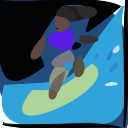

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 69.69333902994792
128\emoji_u1f3e7.png 
use_bezier_curve_num : 40 
component_num : 14


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


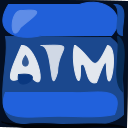

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 55.01678466796875
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 40 
component_num : 28


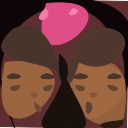

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 82.49458821614583
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 40 
component_num : 31


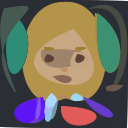

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 106.15486653645833
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


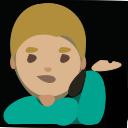

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 44.962666829427086
128\emoji_u1f4b5.png 
use_bezier_curve_num : 40 
component_num : 14


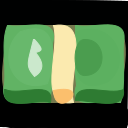

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 27.539164225260418
128\emoji_u1f58a.png 
use_bezier_curve_num : 40 
component_num : 16


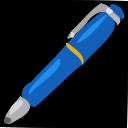

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 15.758544921875
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 40 
component_num : 23


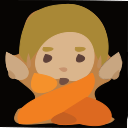

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 48.124796549479164
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 23


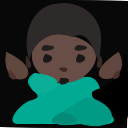

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 60.368387858072914
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 40 
component_num : 21


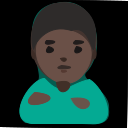

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 29.5701904296875
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 40 
component_num : 19


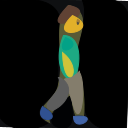

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 16.810078938802082
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 40 
component_num : 23


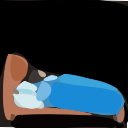

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 25.118245442708332
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 40 
component_num : 15


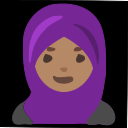

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 38.590413411458336
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 40 
component_num : 33


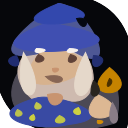

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 73.75978597005208
128\emoji_u1f9ea.png 
use_bezier_curve_num : 40 
component_num : 18


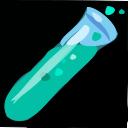

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 13.384867350260416
128 Total MSE: 707.3467203776044
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 29


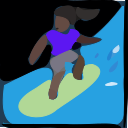

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 63.451314290364586
128\emoji_u1f3e7.png 
use_bezier_curve_num : 80 
component_num : 14


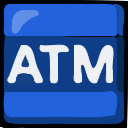

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 35.638387044270836
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 80 
component_num : 28


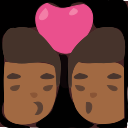

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 32.777933756510414
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 80 
component_num : 31


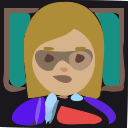

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 76.81402587890625
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


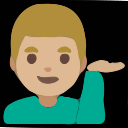

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 27.099629720052082
128\emoji_u1f4b5.png 
use_bezier_curve_num : 80 
component_num : 14


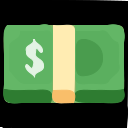

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 25.382425944010418
128\emoji_u1f58a.png 
use_bezier_curve_num : 80 
component_num : 16


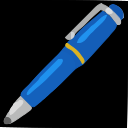

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.86553955078125
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 80 
component_num : 23


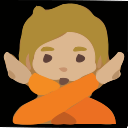

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 28.90679931640625
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 23


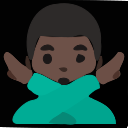

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 27.929931640625
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 80 
component_num : 21


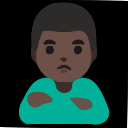

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 22.115397135416668
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 80 
component_num : 19


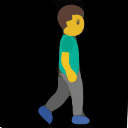

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 8.952168782552084
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 80 
component_num : 23


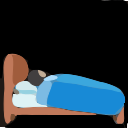

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 12.70977783203125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 80 
component_num : 15


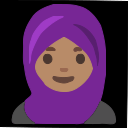

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 35.43536376953125
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 80 
component_num : 33


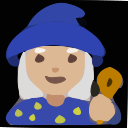

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 42.197428385416664
128\emoji_u1f9ea.png 
use_bezier_curve_num : 80 
component_num : 18


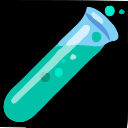

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 9.209940592447916
128 Total MSE: 461.486063639323
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 29


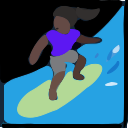

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 58.876973470052086
128\emoji_u1f3e7.png 
use_bezier_curve_num : 120 
component_num : 14


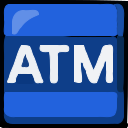

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 30.831339518229168
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 120 
component_num : 28


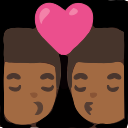

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 28.539591471354168
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 120 
component_num : 31


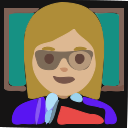

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 79.93892415364583
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


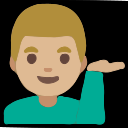

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.9652099609375
128\emoji_u1f4b5.png 
use_bezier_curve_num : 120 
component_num : 14


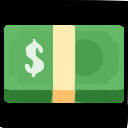

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 23.3865966796875
128\emoji_u1f58a.png 
use_bezier_curve_num : 120 
component_num : 16


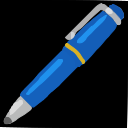

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 12.968851725260416
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 120 
component_num : 23


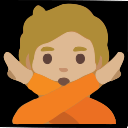

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 24.137349446614582
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 23


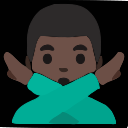

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 26.151346842447918
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 120 
component_num : 21


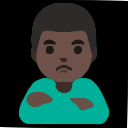

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.9752197265625
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 120 
component_num : 19


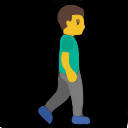

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 8.116800944010416
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 120 
component_num : 23


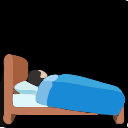

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 8.83087158203125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 120 
component_num : 15


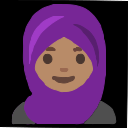

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.531270345052086
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 120 
component_num : 33


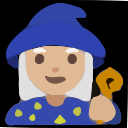

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 30.252217610677082
128\emoji_u1f9ea.png 
use_bezier_curve_num : 120 
component_num : 18


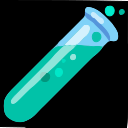

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 8.306681315104166
128 Total MSE: 419.8092447916667
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 29


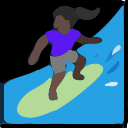

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 57.50634765625
128\emoji_u1f3e7.png 
use_bezier_curve_num : 160 
component_num : 14


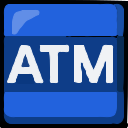

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 29.560994466145832
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 160 
component_num : 28


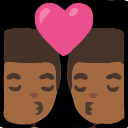

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 26.470723470052082
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 160 
component_num : 31


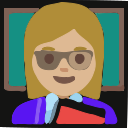

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 73.93391927083333
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


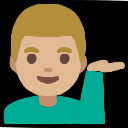

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.300882975260418
128\emoji_u1f4b5.png 
use_bezier_curve_num : 160 
component_num : 14


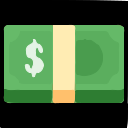

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 24.335795084635418
128\emoji_u1f58a.png 
use_bezier_curve_num : 127 
component_num : 16


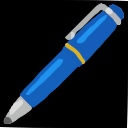

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.030680338541666
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 160 
component_num : 23


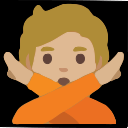

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 23.6885986328125
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 23


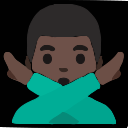

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.695271809895832
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 160 
component_num : 21


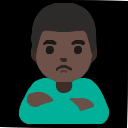

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 20.258402506510418
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 160 
component_num : 19


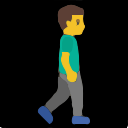

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.597900390625
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 160 
component_num : 23


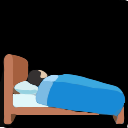

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.531107584635416
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 160 
component_num : 15


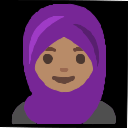

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.4344482421875
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 160 
component_num : 33


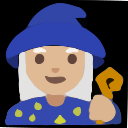

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 27.523946126302082
128\emoji_u1f9ea.png 
use_bezier_curve_num : 160 
component_num : 18


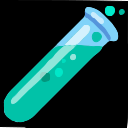

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.762471516927083
128 Total MSE: 404.63149007161456
128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 29


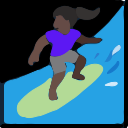

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 56.577006022135414
128\emoji_u1f3e7.png 
use_bezier_curve_num : 166 
component_num : 14


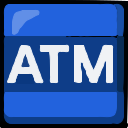

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 29.5247802734375
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 200 
component_num : 28


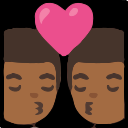

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 25.412556966145832
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 200 
component_num : 31


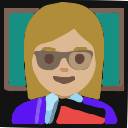

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 69.78228759765625
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


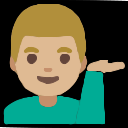

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 25.277994791666668
128\emoji_u1f4b5.png 
use_bezier_curve_num : 177 
component_num : 14


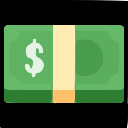

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 24.242594401041668
128\emoji_u1f58a.png 
use_bezier_curve_num : 127 
component_num : 16


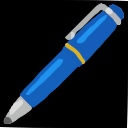

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 13.030680338541666
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 200 
component_num : 23


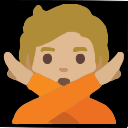

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 23.486409505208332
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 23


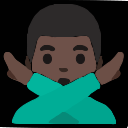

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 25.50103759765625
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 21


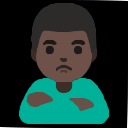

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 19.668558756510418
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 187 
component_num : 19


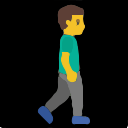

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 7.334716796875
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 200 
component_num : 23


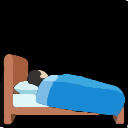

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 9.65655517578125
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 170 
component_num : 15


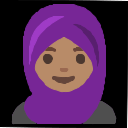

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 32.42352294921875
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 33


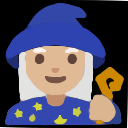

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 26.654500325520832
128\emoji_u1f9ea.png 
use_bezier_curve_num : 187 
component_num : 18


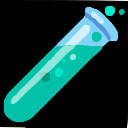

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 7.6409912109375
128 Total MSE: 396.2141927083333
908.3917932510376


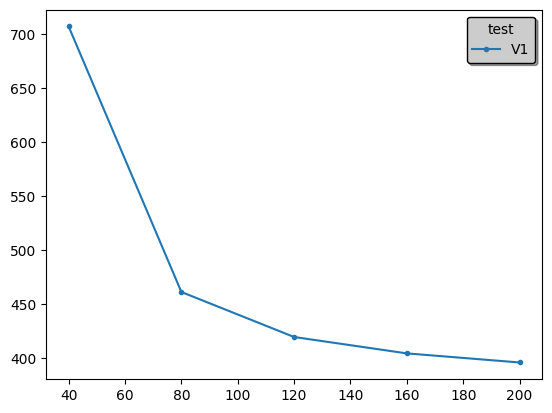

In [107]:
max_component_num = 40
max_bezier_curve_nums = [40,80,120,160,200]

image_floder = '128'

import os

gtkbin = r'C:\Program Files\GTK3-Runtime Win64\bin'
add_dll_dir = getattr(os, 'add_dll_directory', None)
if callable(add_dll_dir):
    add_dll_dir(gtkbin)
else:
    os.environ['PATH'] = os.pathsep.join((gtkbin, os.environ['PATH']))

import glob
import random
import time
from cairosvg import svg2png
from IPython.display import display, SVG


image_paths=glob.glob(image_floder+"/*.jpg")+glob.glob(image_floder+"/*.png")

tmsess = dict()

# random.shuffle(image_paths)
def Test(V21=False,V22=False,V23=False,V31=False,V32=False,labelname="V"):
    ti=time.time()
    tmses=[]
    for max_bezier_curve_num in max_bezier_curve_nums:
        tmse=0

        for image_path in image_paths:
            SAMVGV1(image_path,max_component_num,max_bezier_curve_num,V21,V22,V23,V31,V32)

            #convert SVG to PNG
            svg_path = 'SVG_' + image_path.split('.')[0]+'.svg'
            write_path = 'SVG2PNG_' + image_path.split('.')[0] + '.png'
            # Display an SVG file directly from its path
            display(SVG(filename=svg_path))
            svg2png(url=svg_path, write_to=write_path, unsafe=True)
            mse=calculate_mse(image_path, write_path)
            tmse+=mse
            print(image_path +" vs " + write_path + ": " + str(mse))
        print(image_floder+" Total MSE:",tmse)
        tmses.append(tmse)
    print(time.time()-ti)
    plt.plot(max_bezier_curve_nums,tmses,'.-',label=labelname)
    tmsess[labelname] = tmses
    
Test(V21=True,V31=True,labelname="V1")
plt.legend(
    loc='best',
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=10)
plt.show()


Topic5\fallingwater.jpg 
use_bezier_curve_num : 200 
component_num : 139


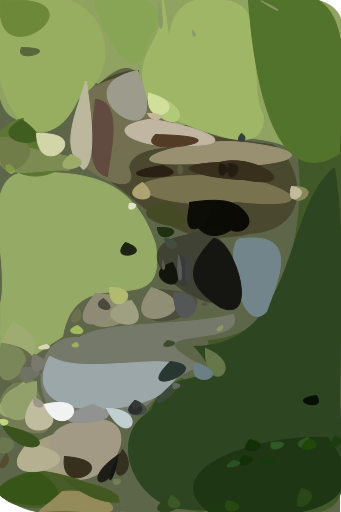

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 98.1098408479961
Topic5\flower.jpg 
use_bezier_curve_num : 200 
component_num : 177


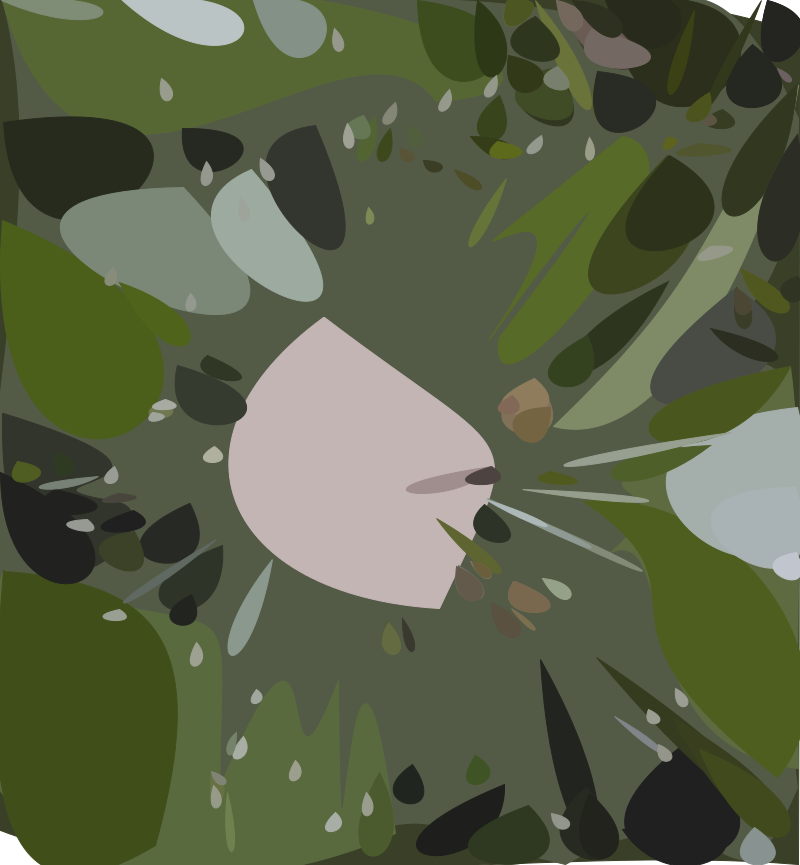

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 88.86413487475916
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 200 
component_num : 98


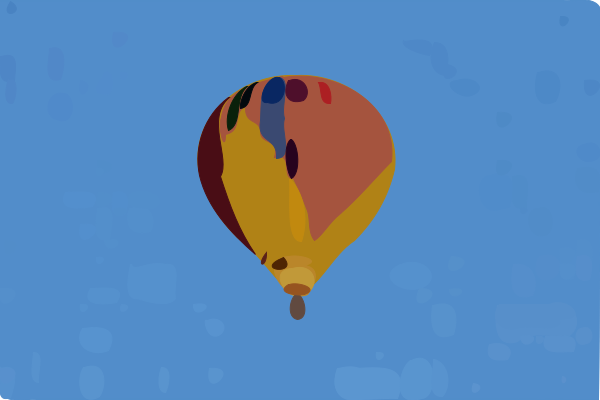

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.250608333333332
Topic5\autumn_01.png 
use_bezier_curve_num : 200 
component_num : 22


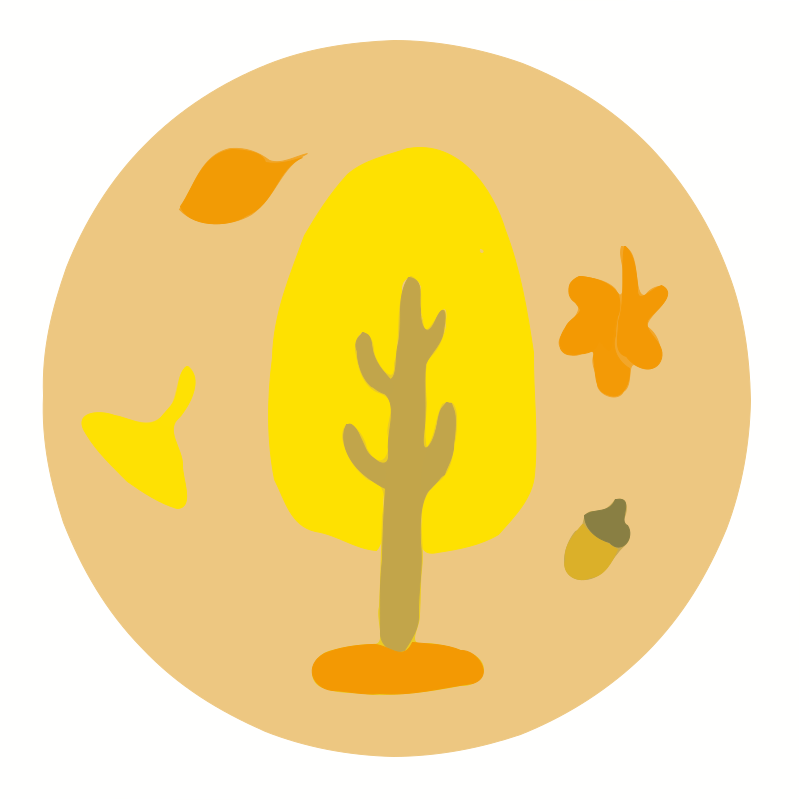

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 2.405375
Topic5\dolphin.png 
use_bezier_curve_num : 200 
component_num : 78


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


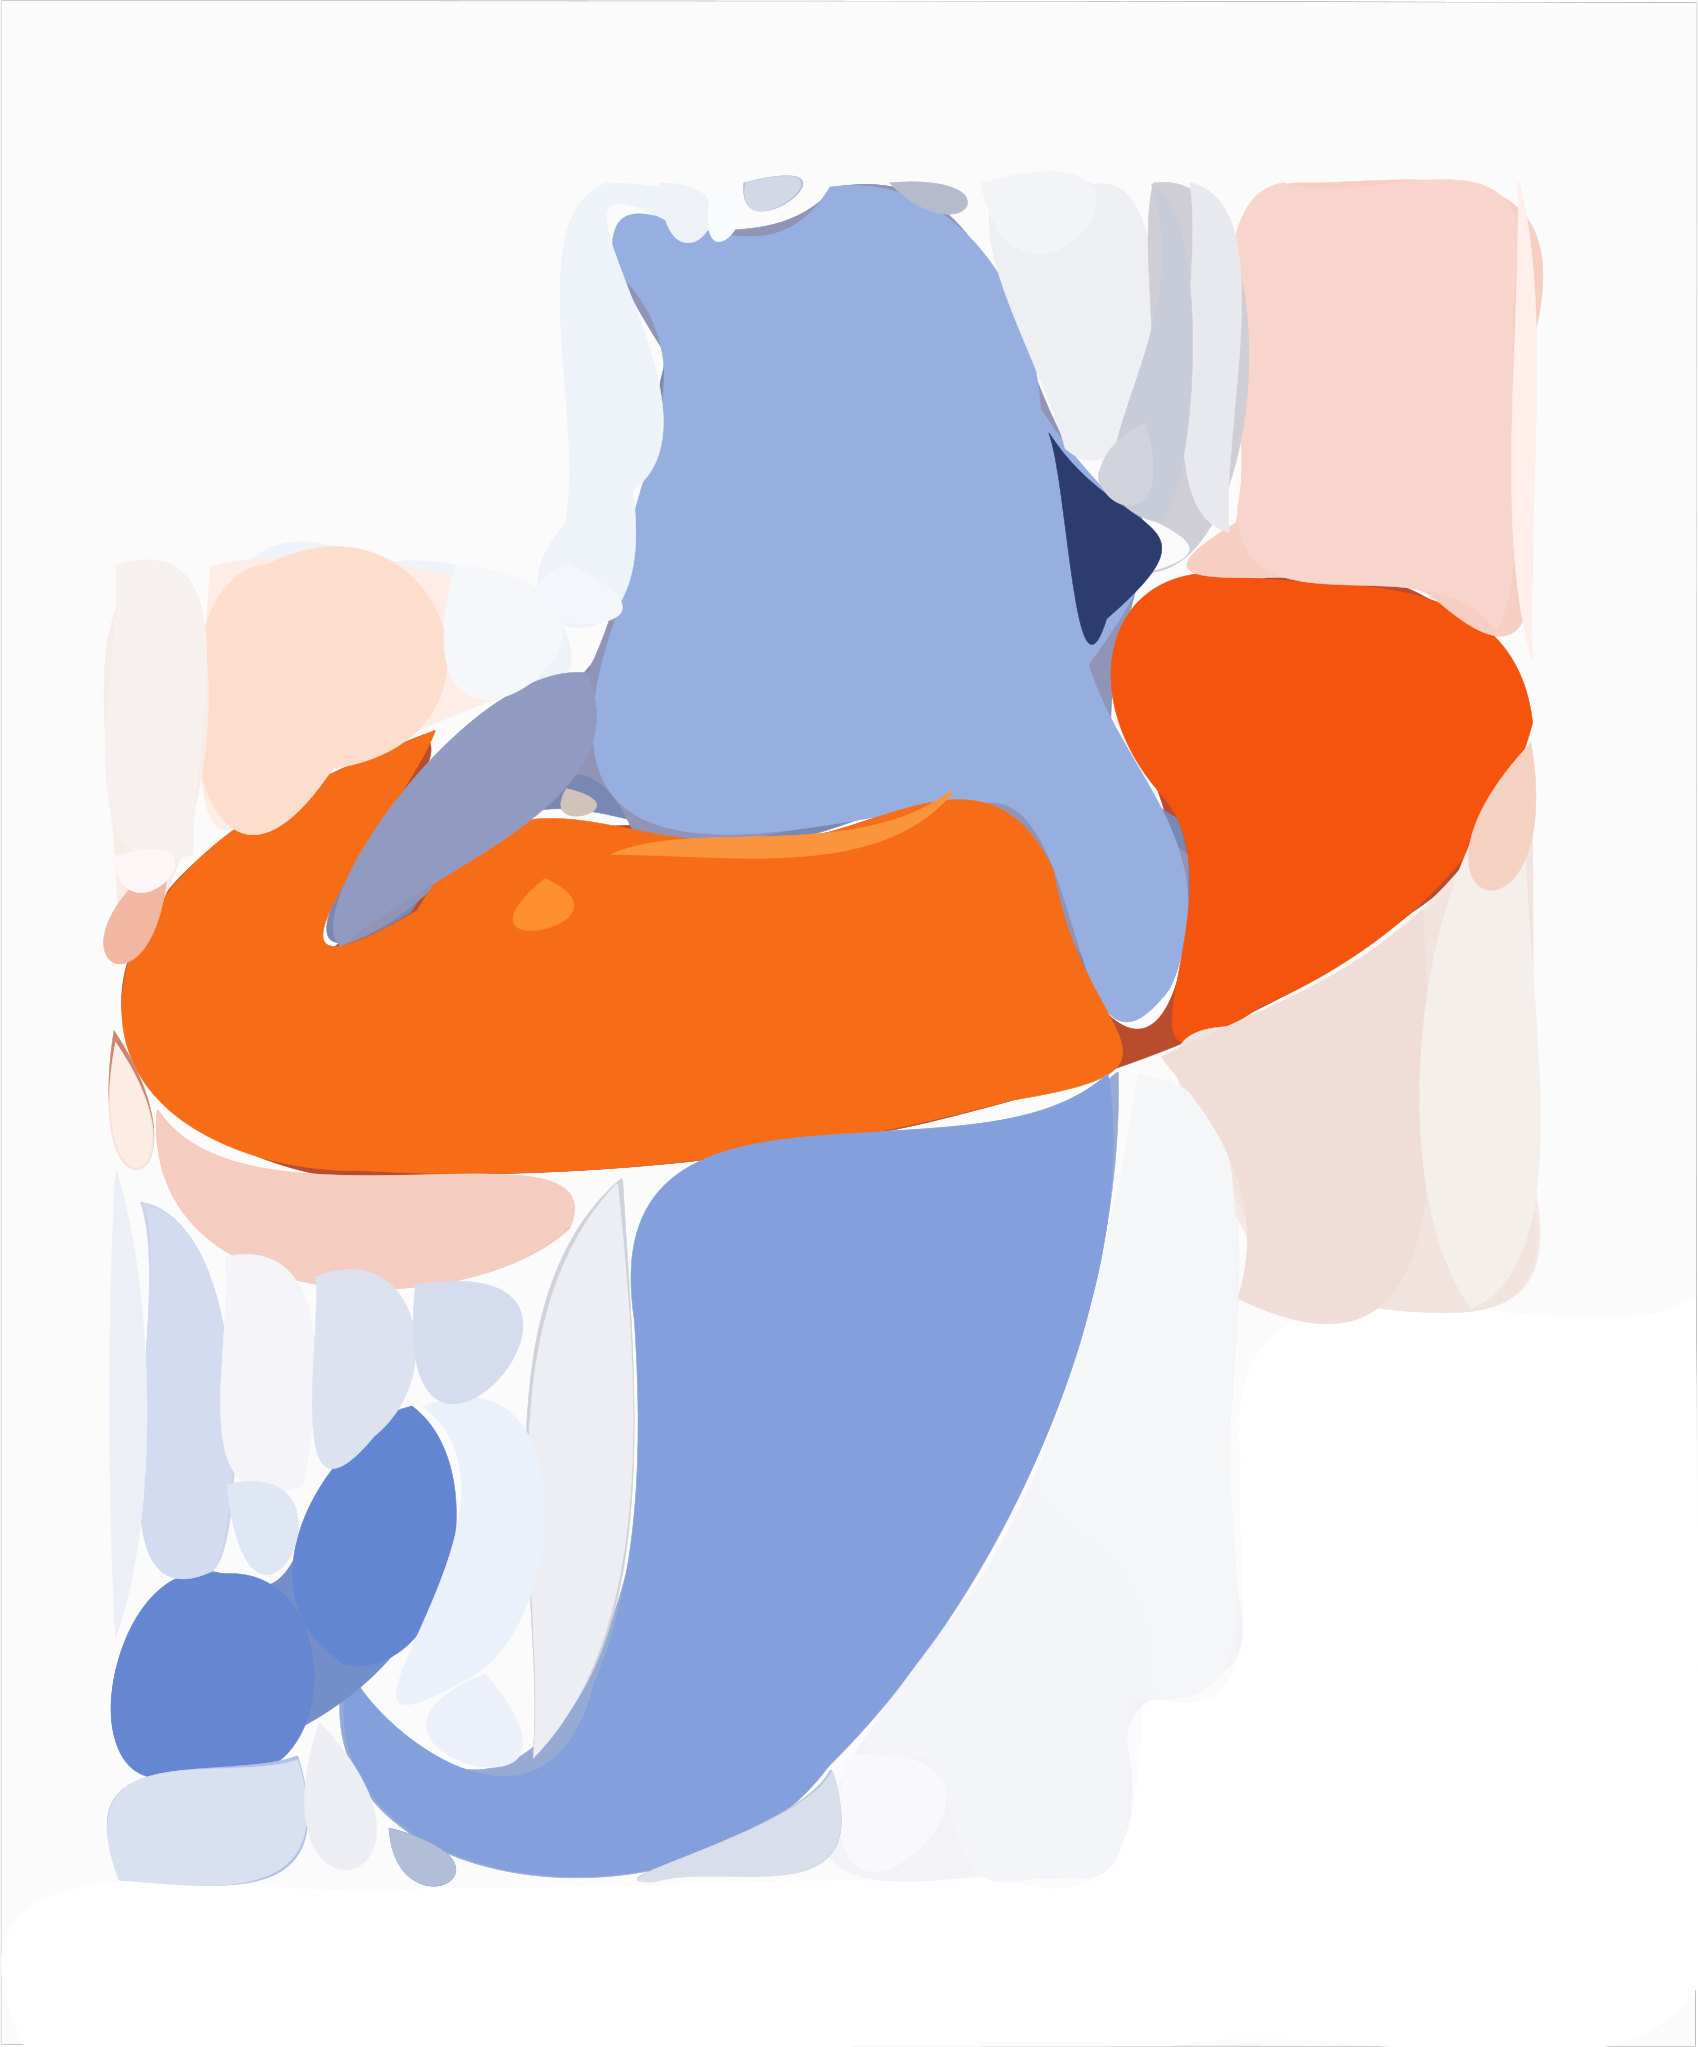

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 50.30384073270122
Topic5\house.png 
use_bezier_curve_num : 200 
component_num : 57


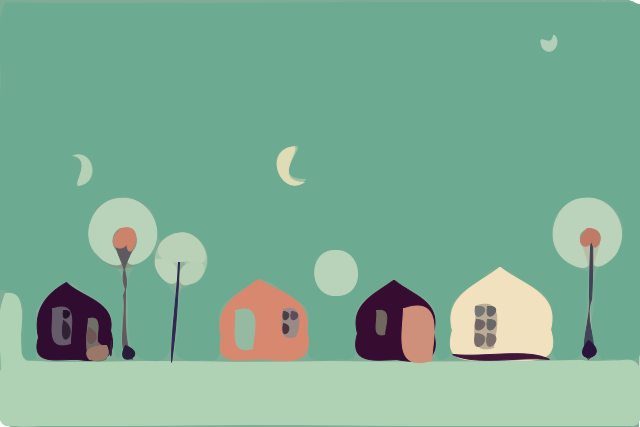

Topic5\house.png vs SVG2PNG_Topic5\house.png: 8.117183840749414
Topic5\meditation.png 
use_bezier_curve_num : 200 
component_num : 60


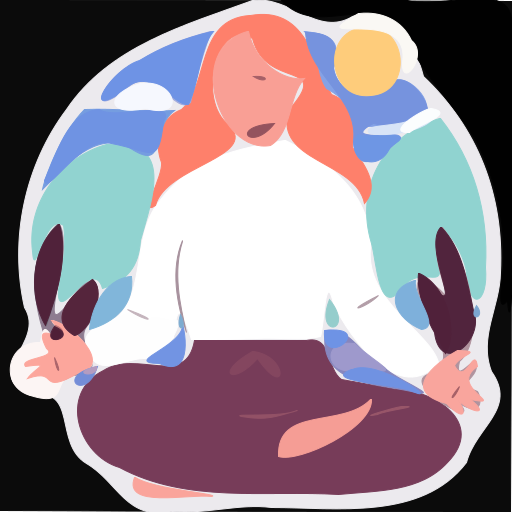

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 38.840048472086586
Topic5\tree.png 
use_bezier_curve_num : 200 
component_num : 200


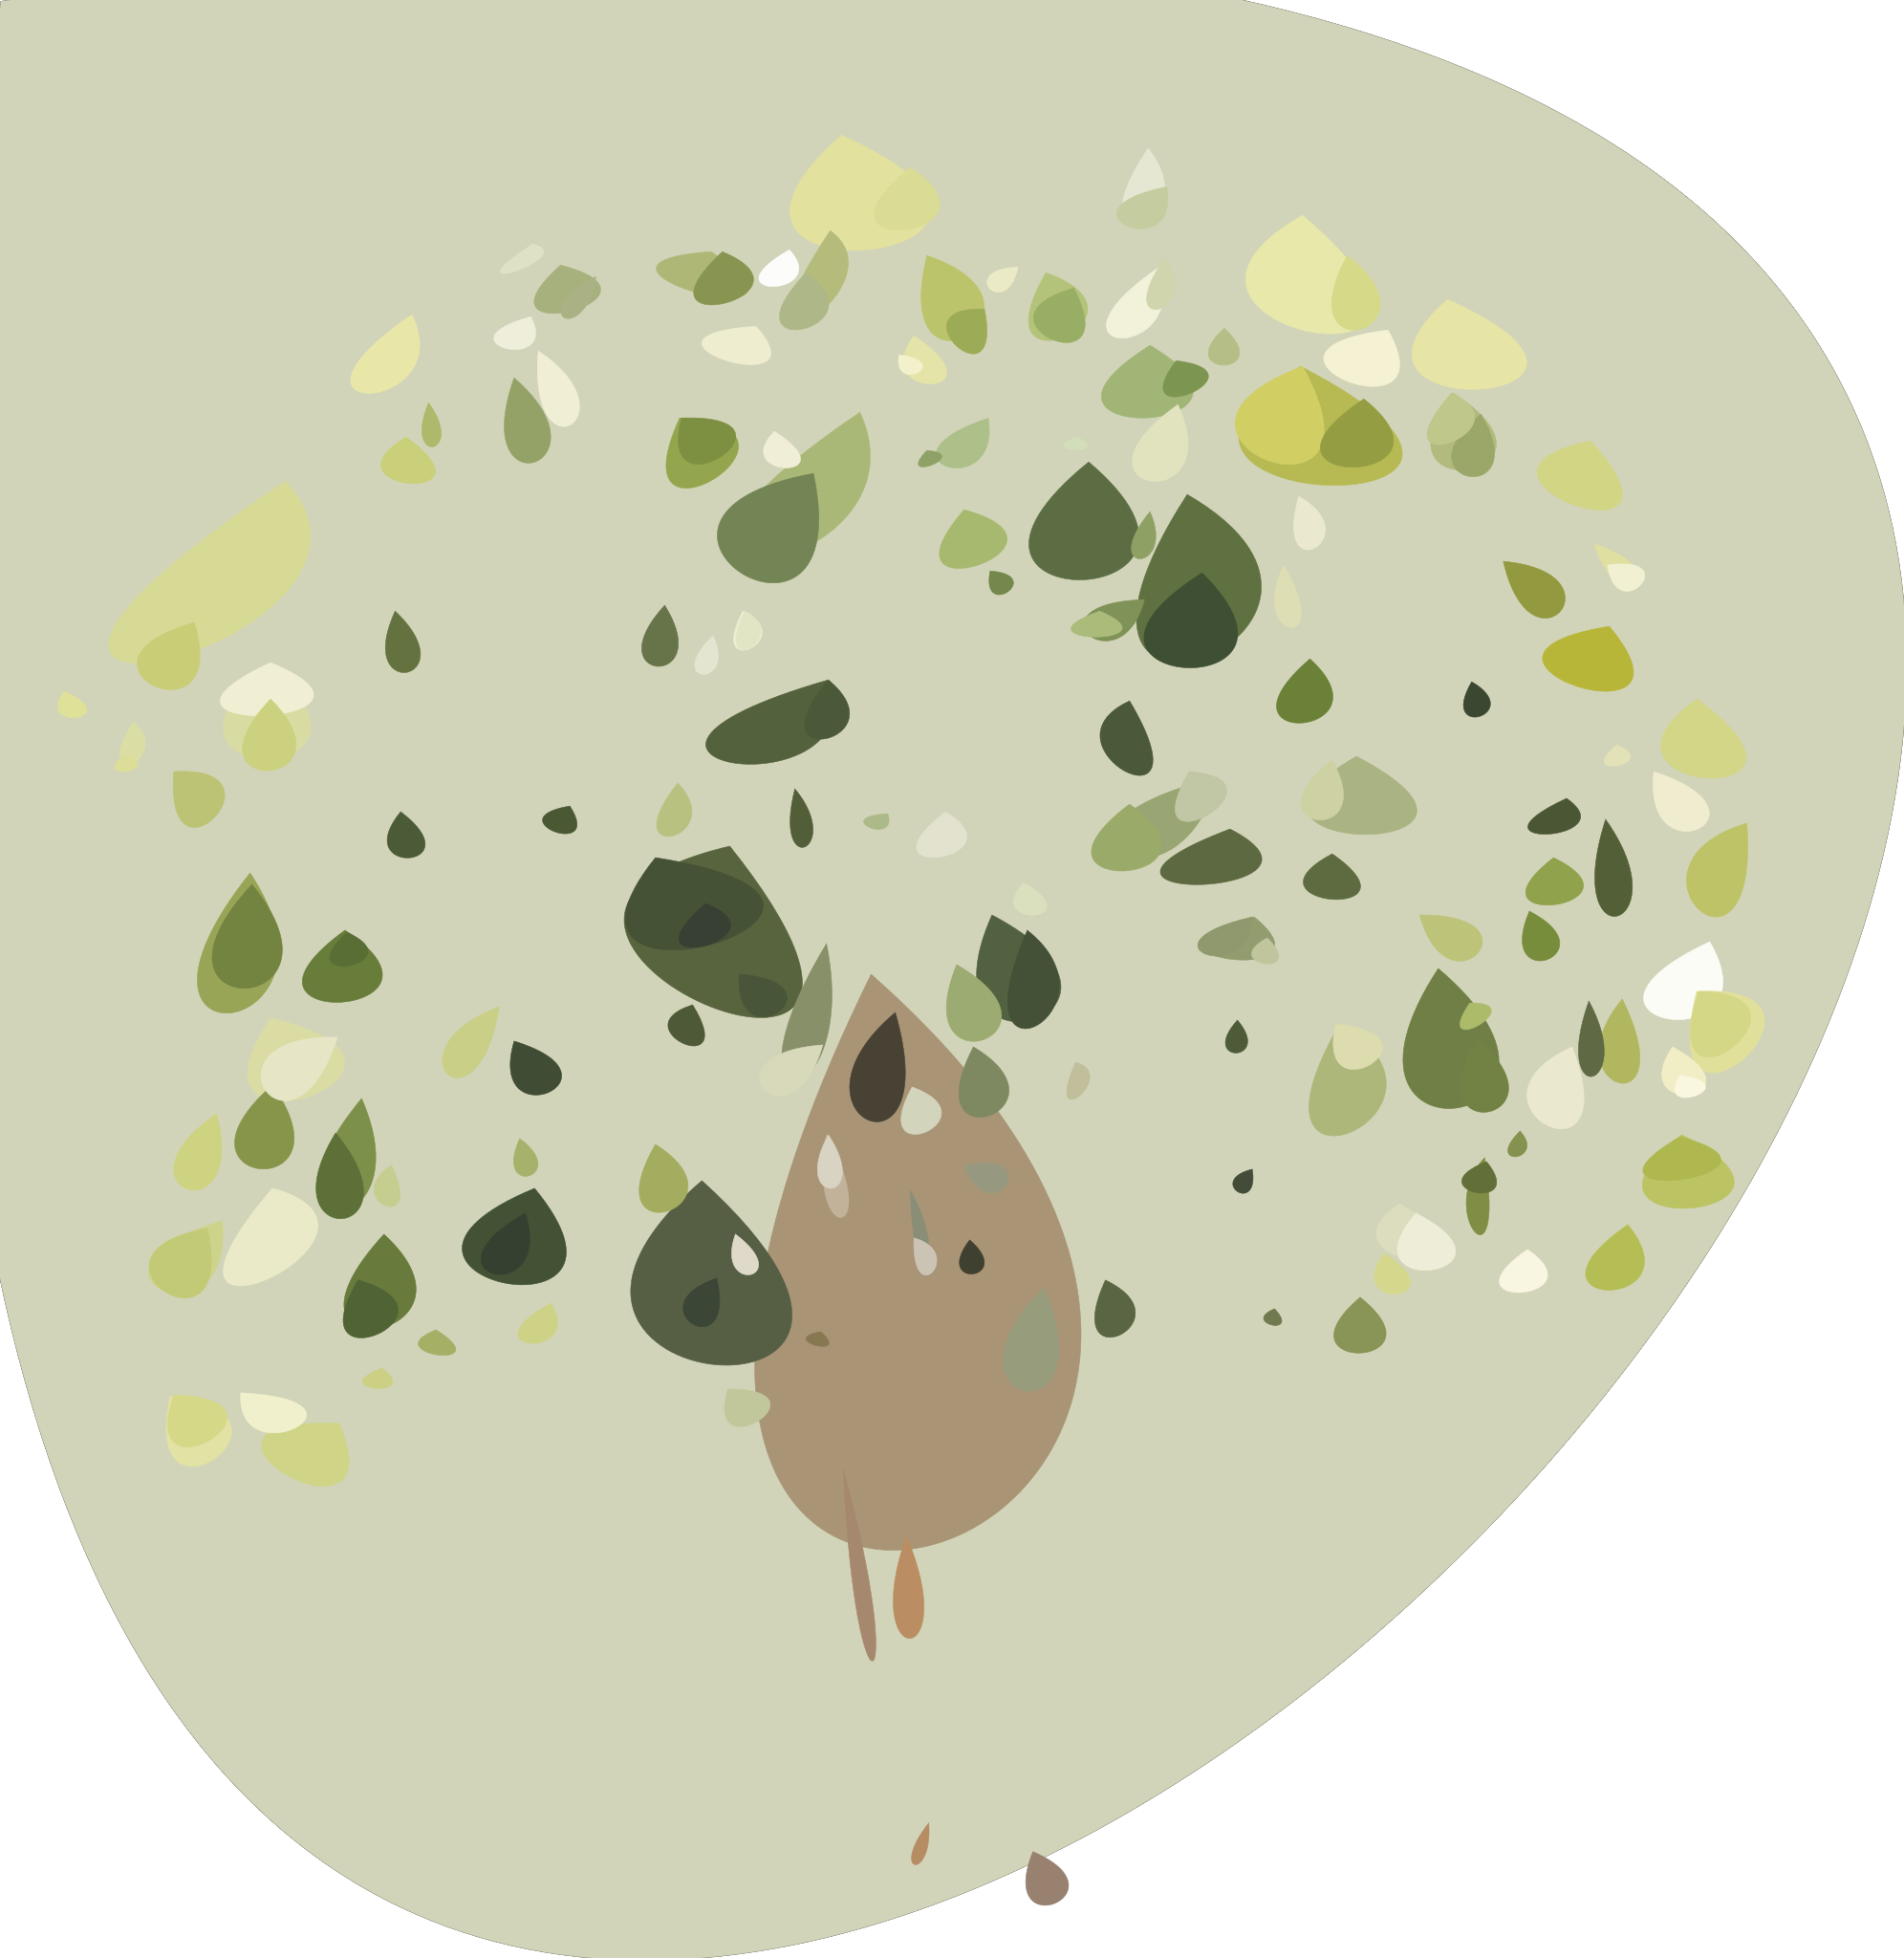

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 80.12982530303712
Topic5\work-from-home.png 
use_bezier_curve_num : 200 
component_num : 42


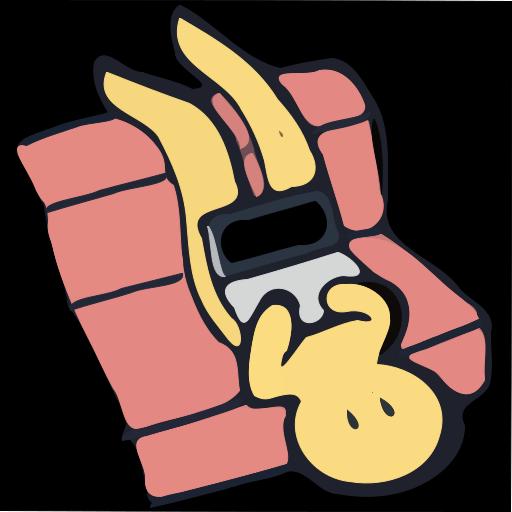

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 18.08319600423177
Topic5 Total MSE: 412.1040534088947
Topic5\fallingwater.jpg 
use_bezier_curve_num : 400 
component_num : 139


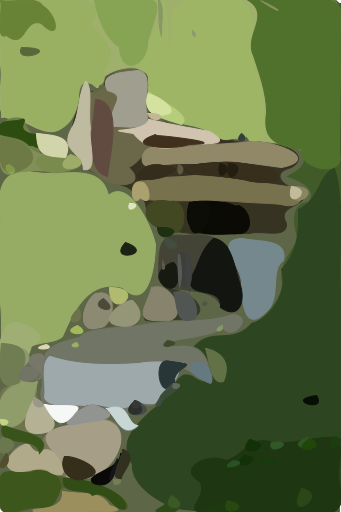

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.71022536351417
Topic5\flower.jpg 
use_bezier_curve_num : 400 
component_num : 177


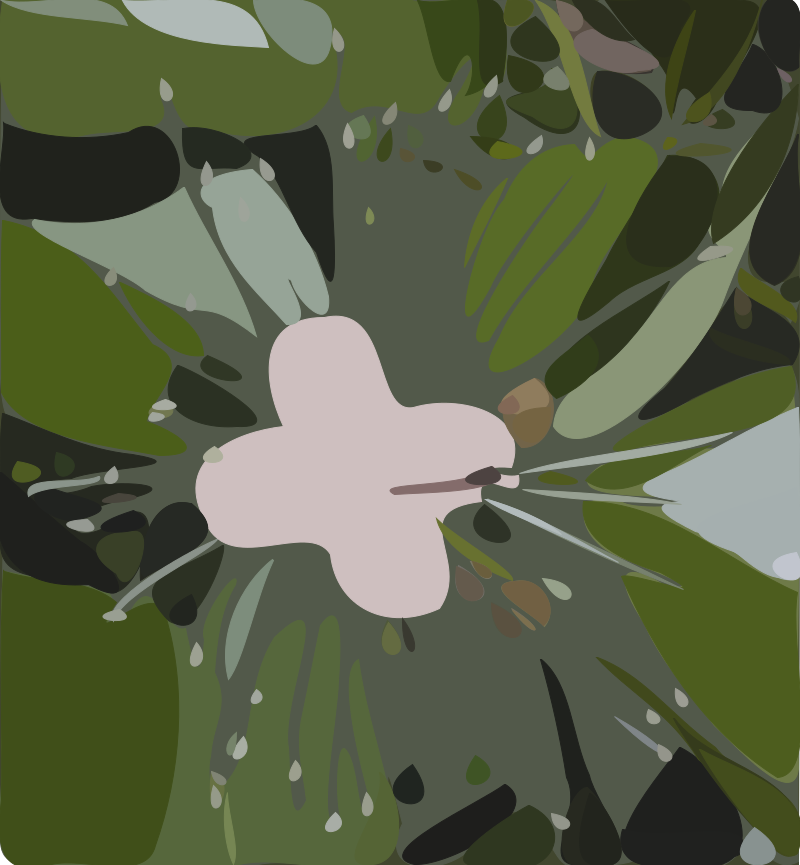

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 81.11325433526011
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 400 
component_num : 98


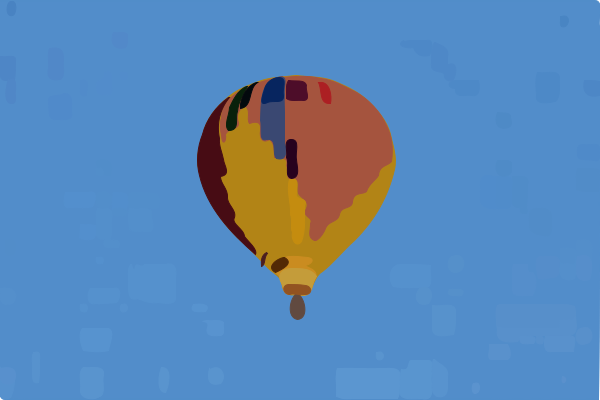

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.066022222222223
Topic5\autumn_01.png 
use_bezier_curve_num : 400 
component_num : 22


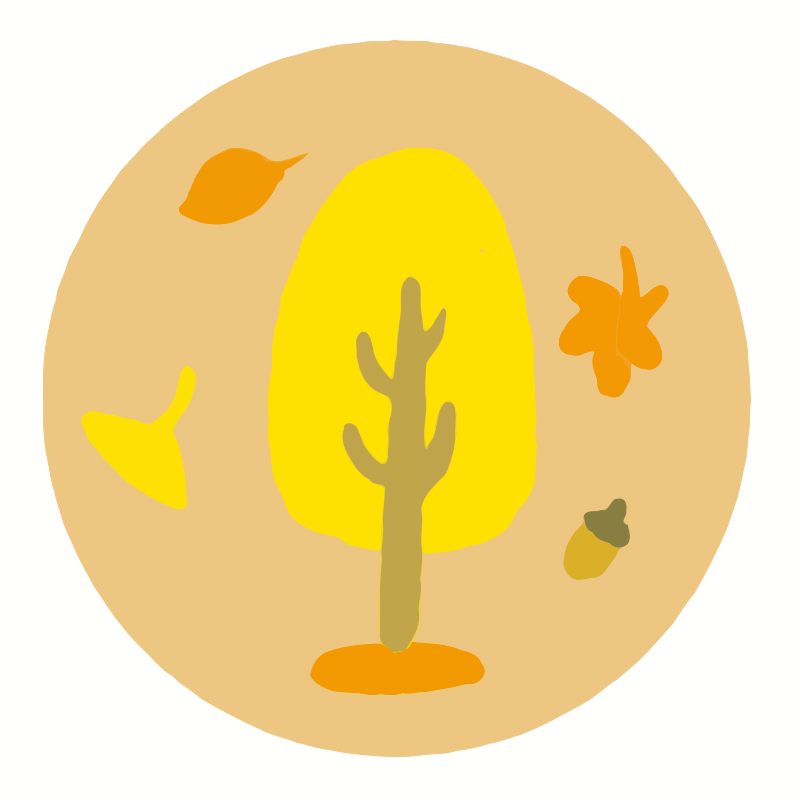

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.9659395833333333
Topic5\dolphin.png 
use_bezier_curve_num : 400 
component_num : 78


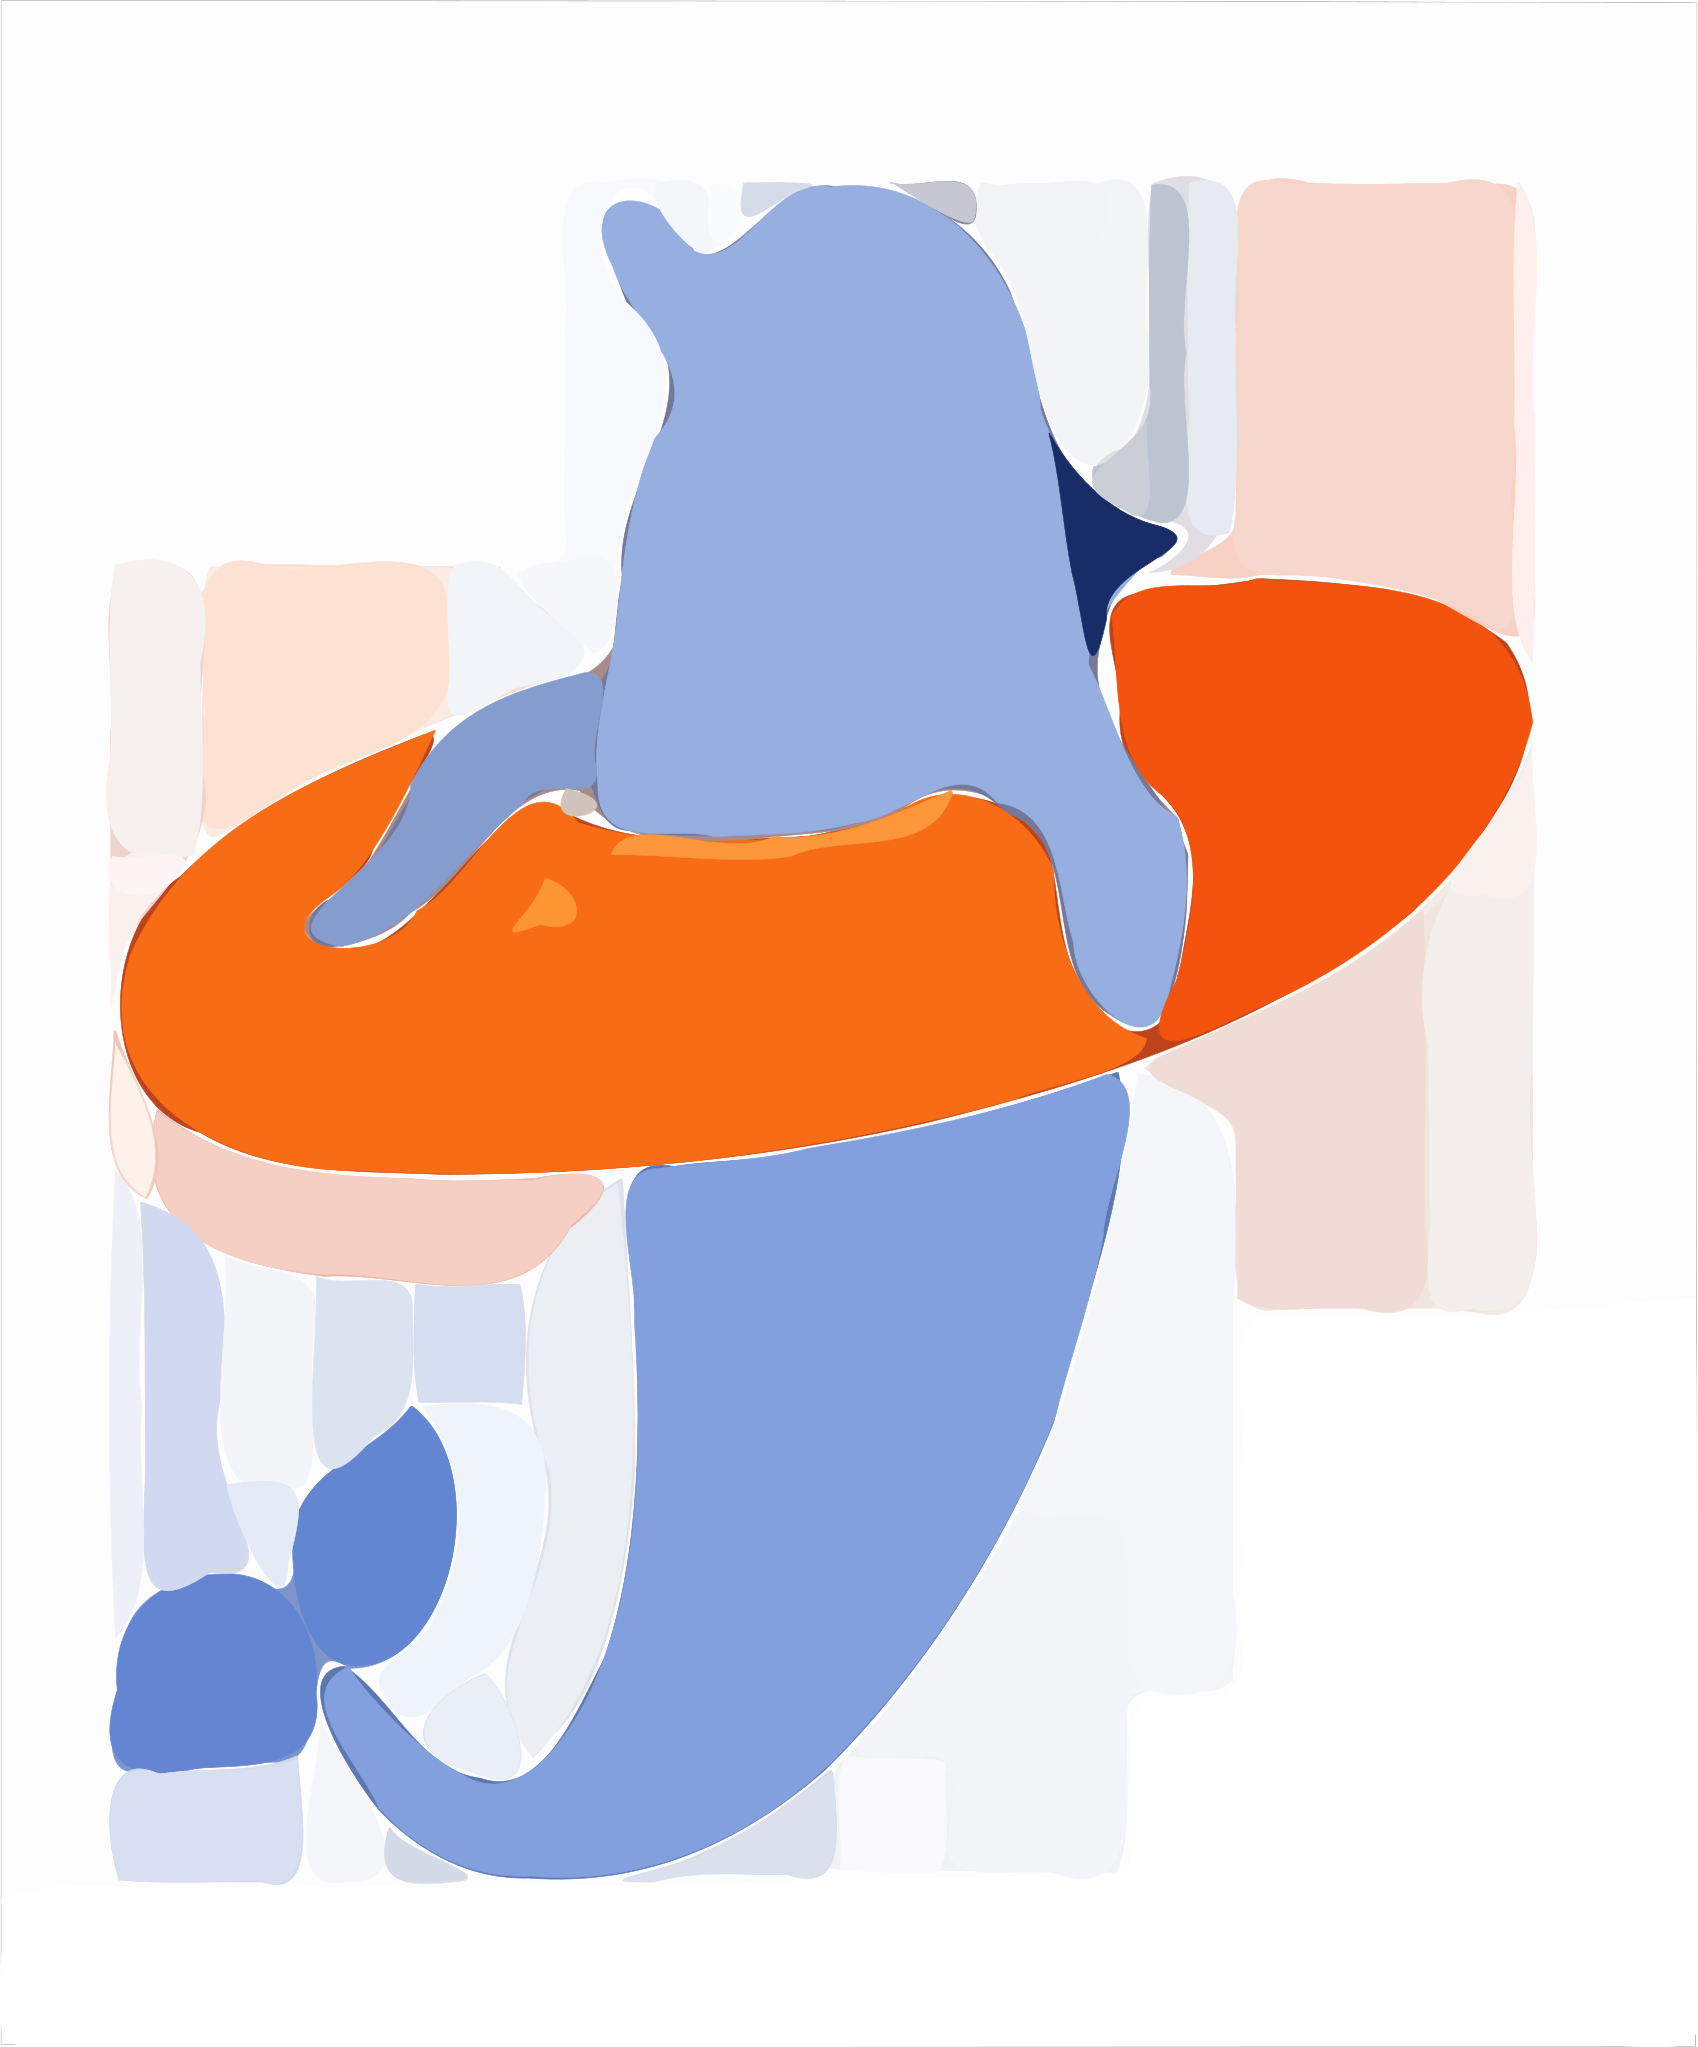

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.49348912341309
Topic5\house.png 
use_bezier_curve_num : 400 
component_num : 57


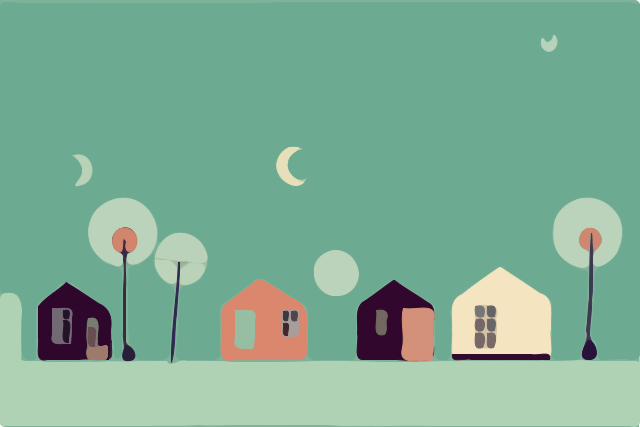

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.3501512490242
Topic5\meditation.png 
use_bezier_curve_num : 400 
component_num : 60


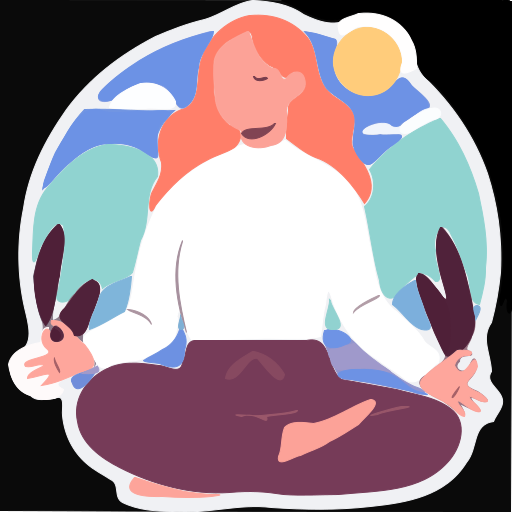

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 34.862962086995445
Topic5\tree.png 
use_bezier_curve_num : 400 
component_num : 200


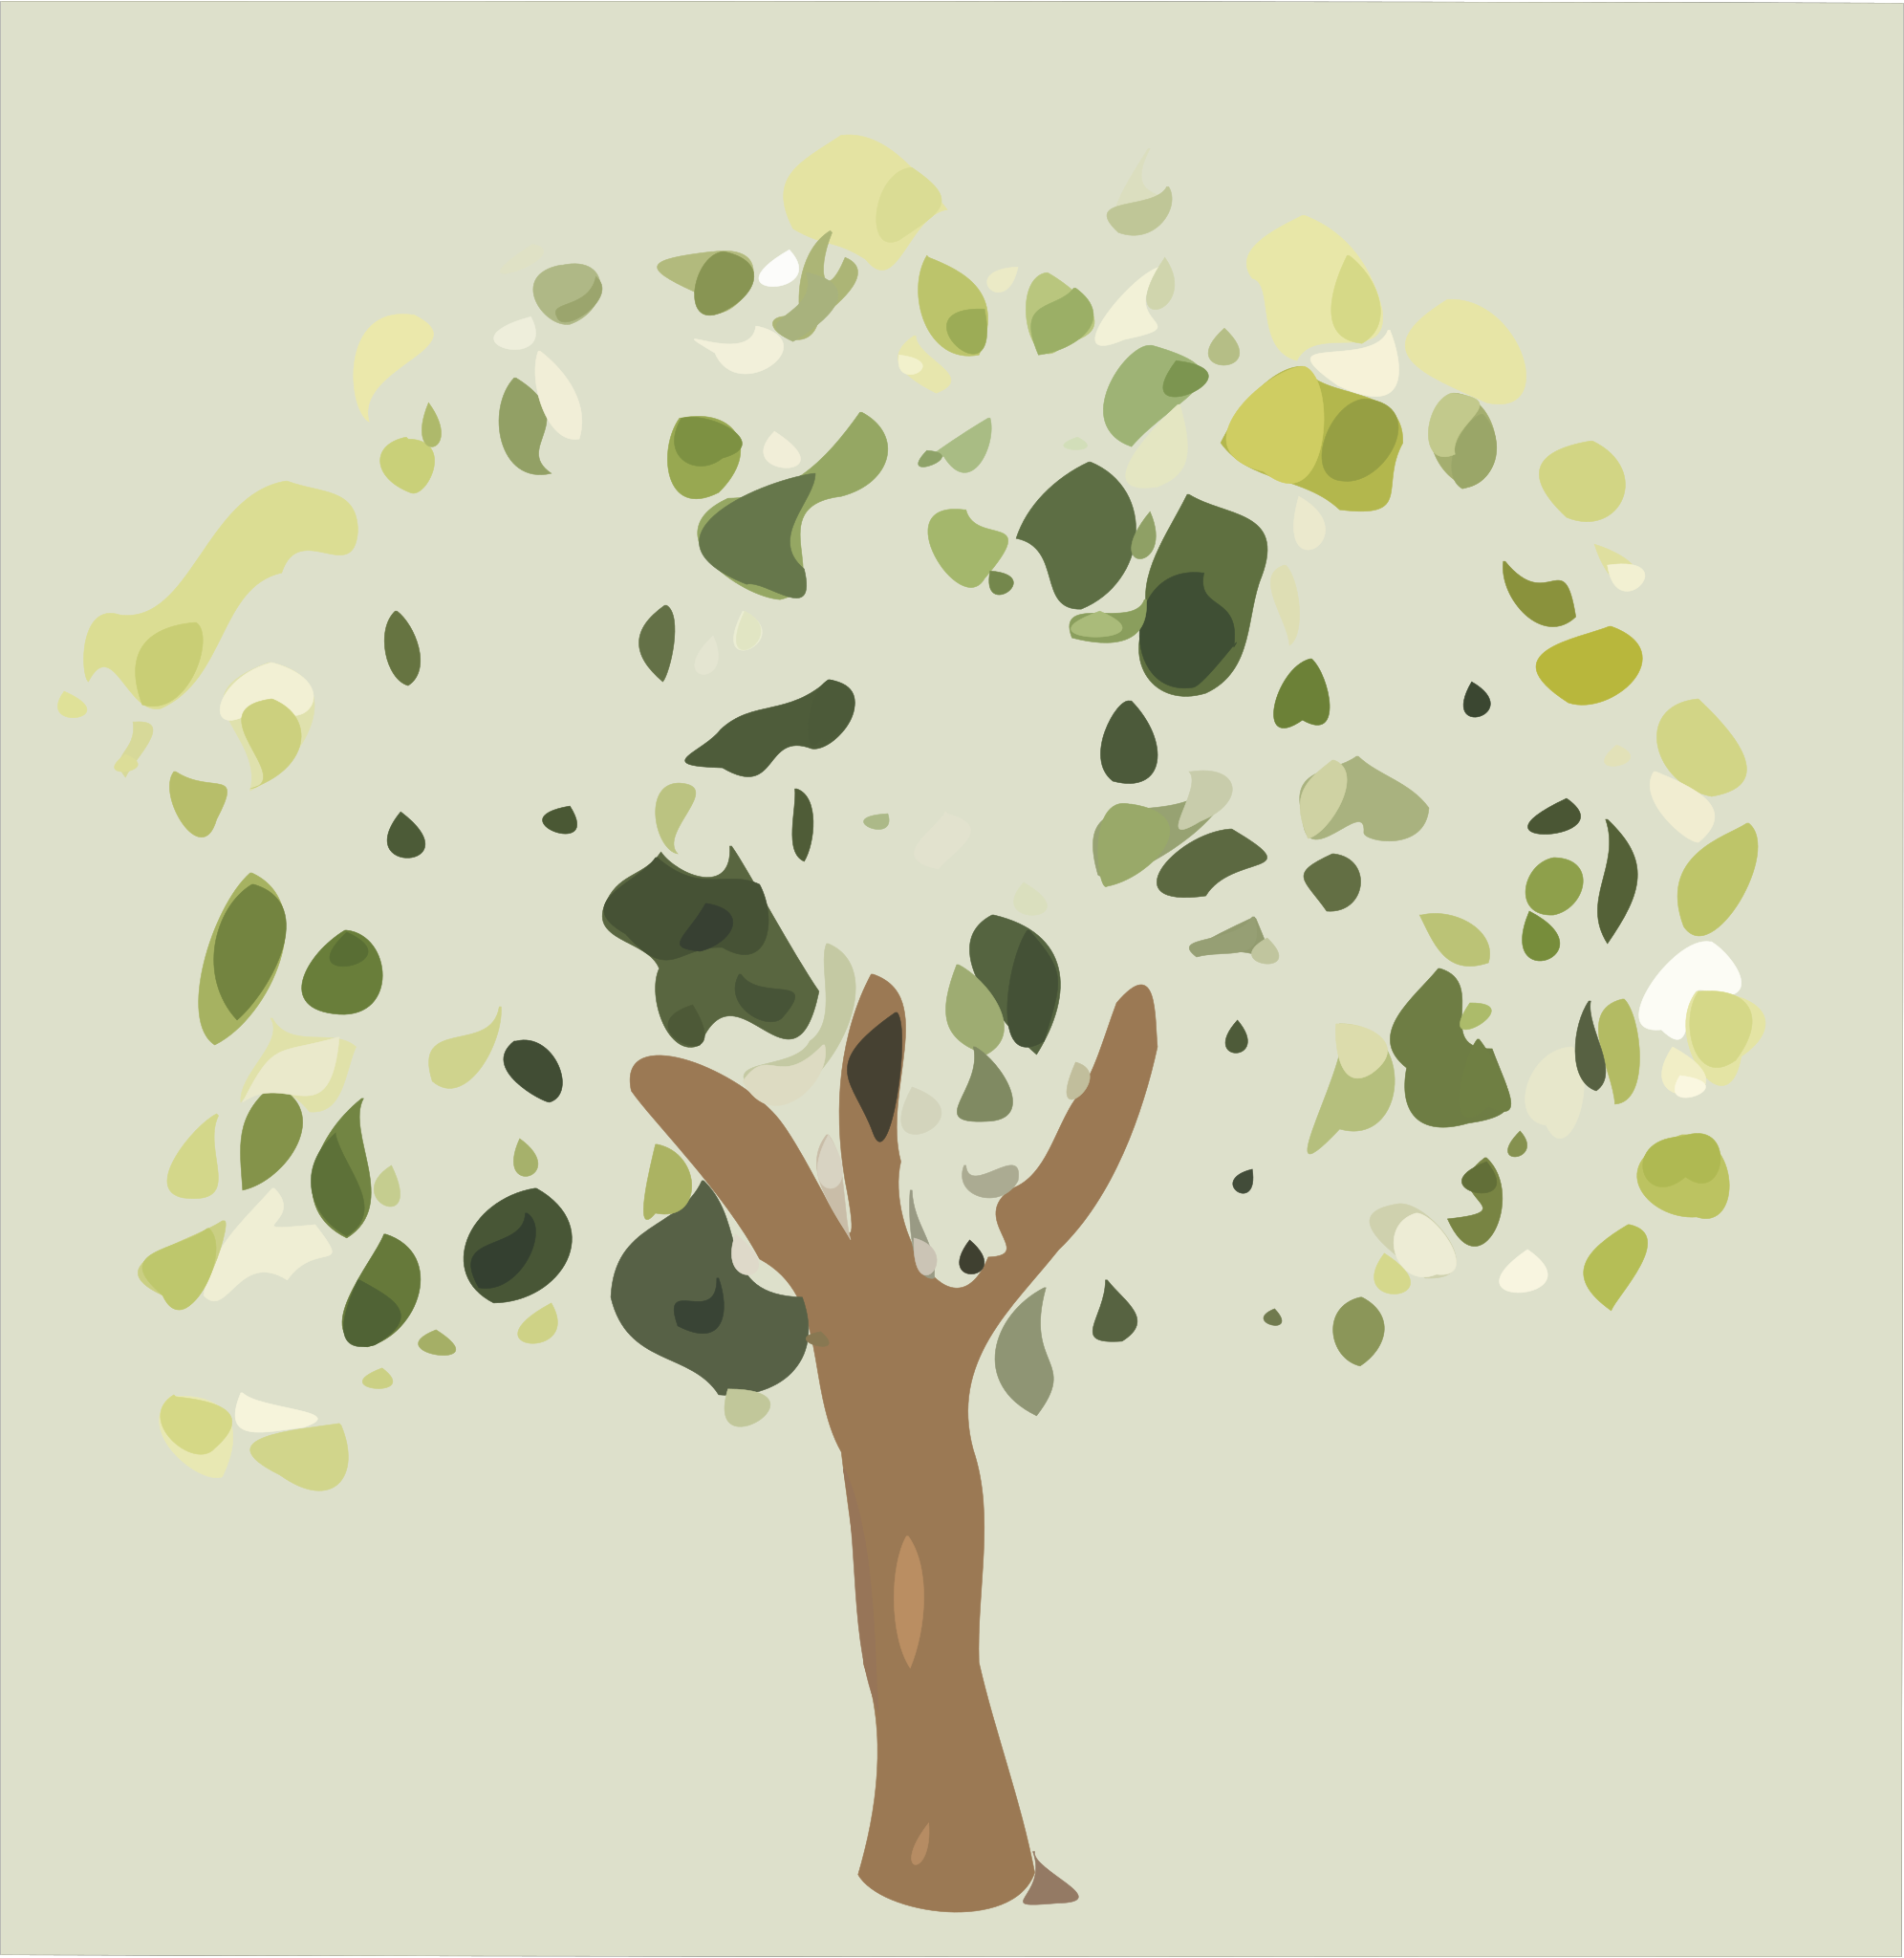

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 123.27527312092622
Topic5\work-from-home.png 
use_bezier_curve_num : 400 
component_num : 42


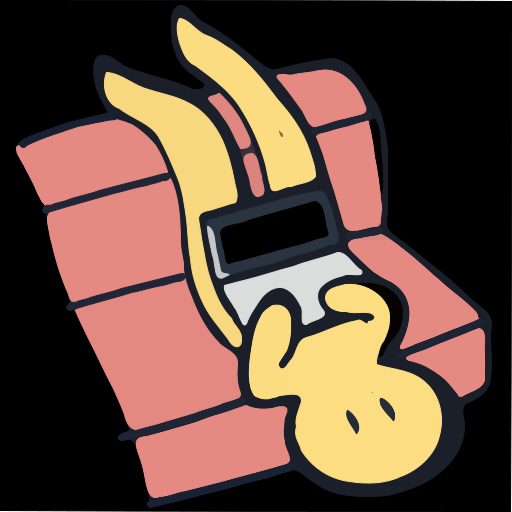

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 15.207590738932291
Topic5 Total MSE: 434.0449078236211
Topic5\fallingwater.jpg 
use_bezier_curve_num : 600 
component_num : 139


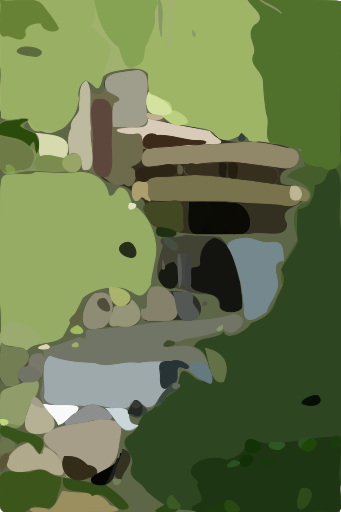

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.41423432917888
Topic5\flower.jpg 
use_bezier_curve_num : 600 
component_num : 177


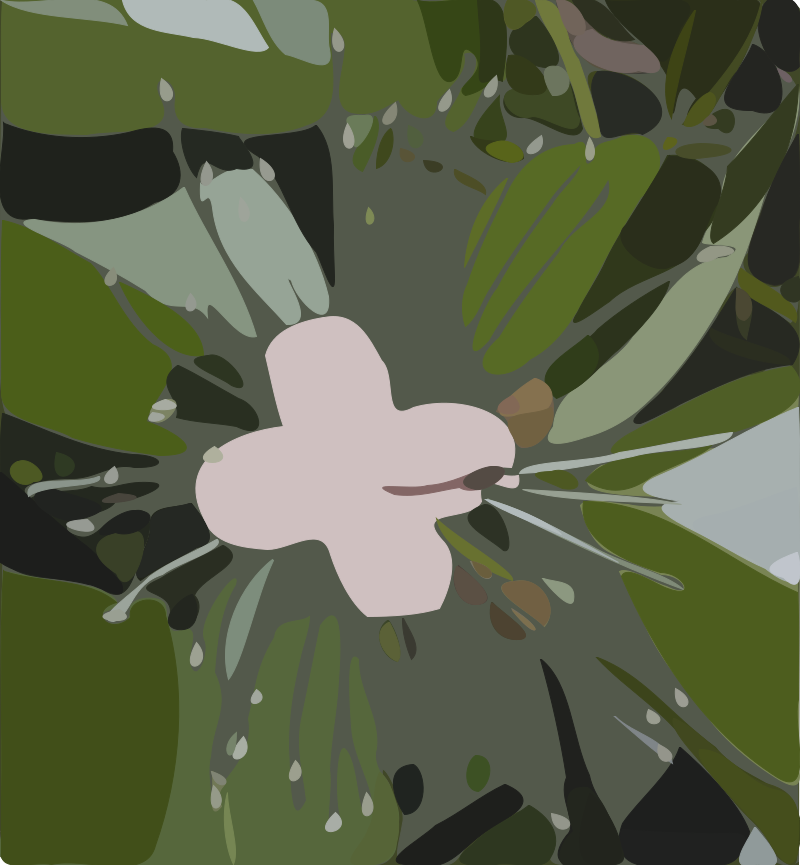

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 80.10166136801541
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 600 
component_num : 98


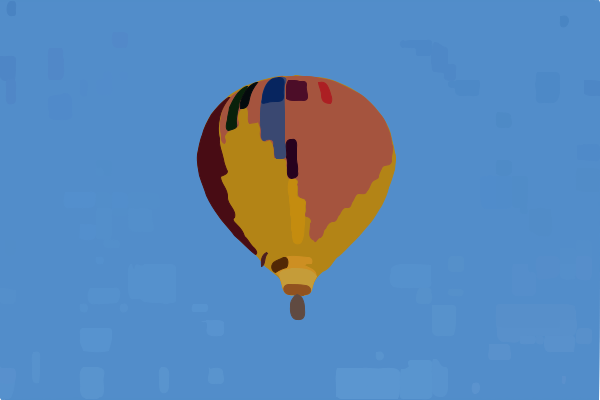

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.092056944444444
Topic5\autumn_01.png 
use_bezier_curve_num : 600 
component_num : 22


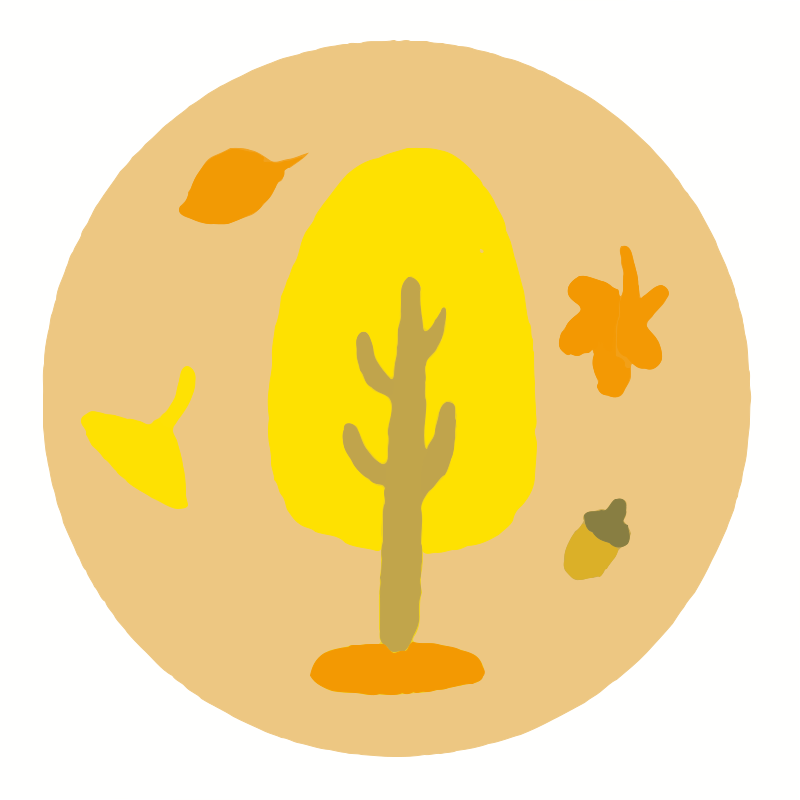

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.9000682291666666
Topic5\dolphin.png 
use_bezier_curve_num : 600 
component_num : 78


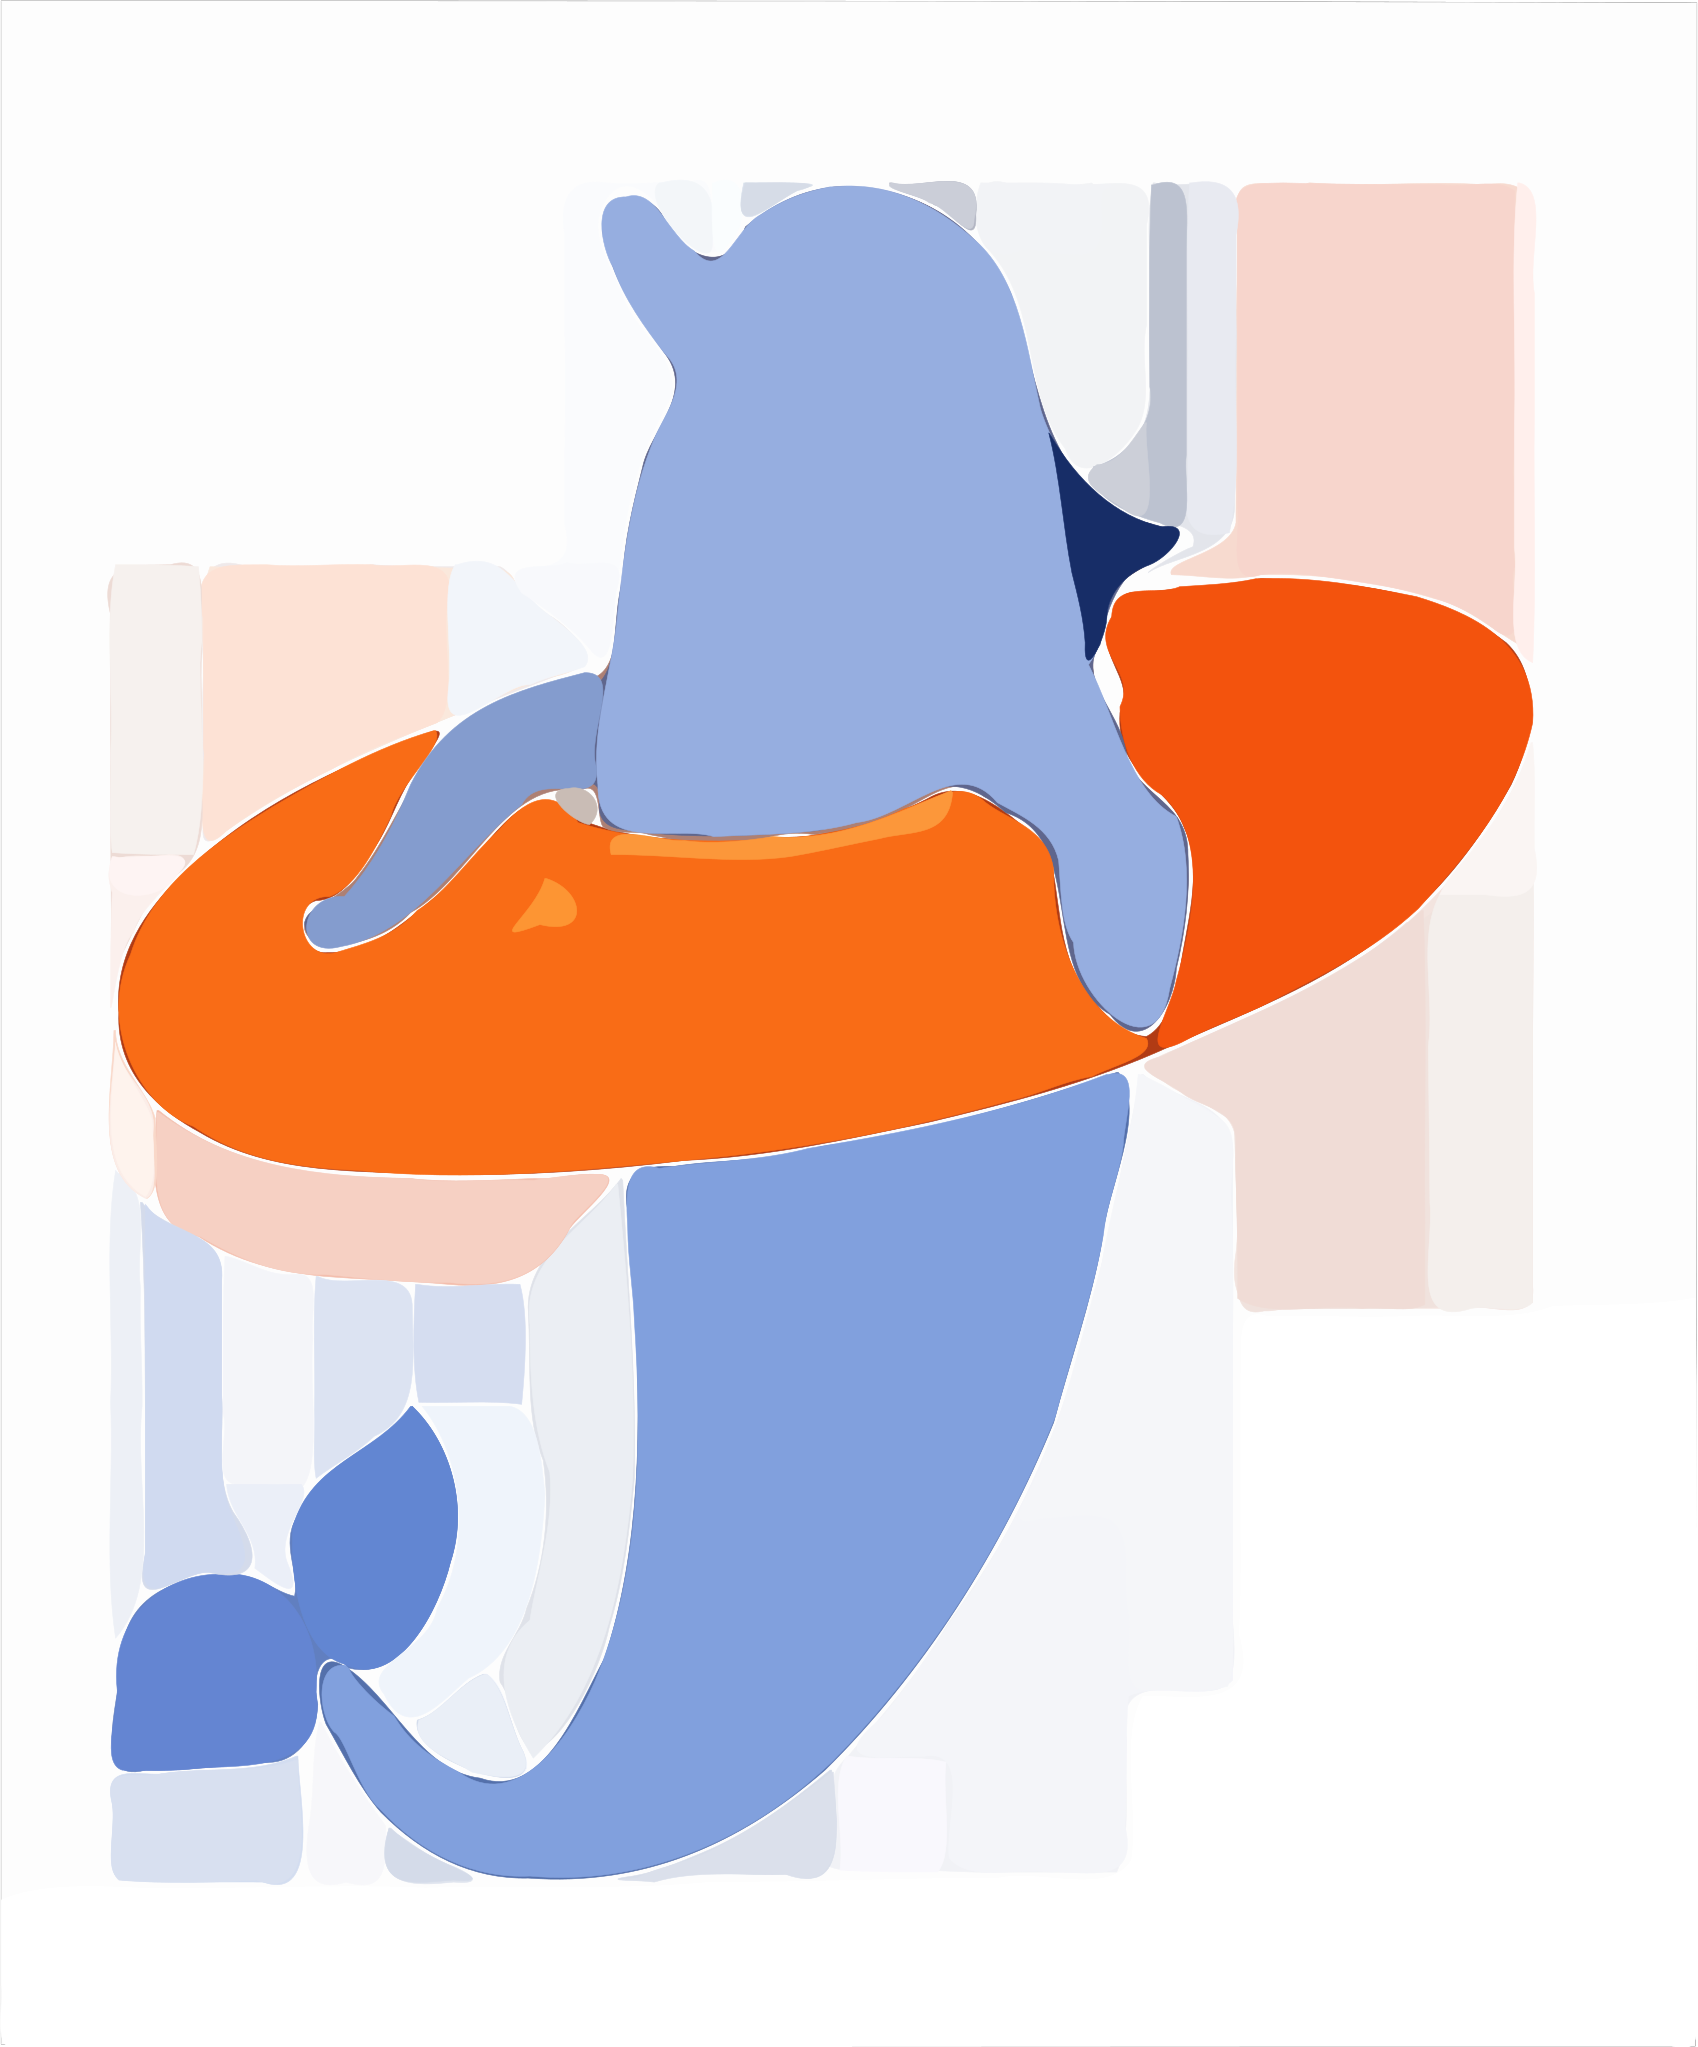

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.24043849201566
Topic5\house.png 
use_bezier_curve_num : 600 
component_num : 57


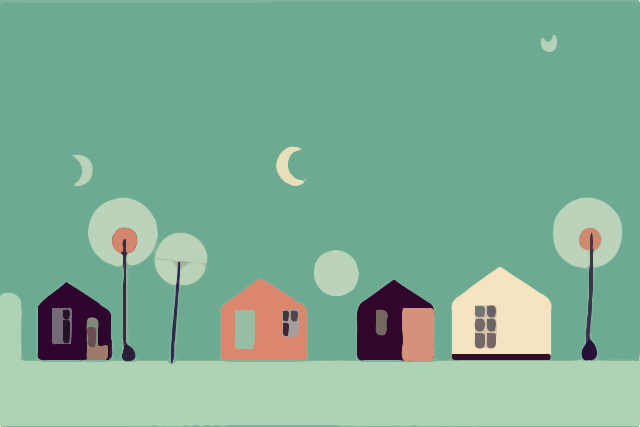

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.34108606557377
Topic5\meditation.png 
use_bezier_curve_num : 600 
component_num : 60


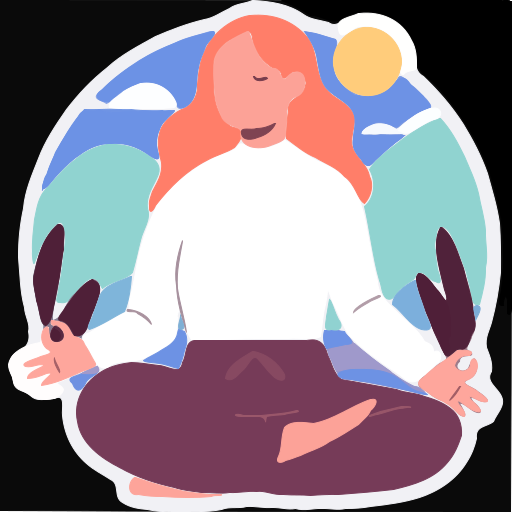

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 33.134961446126304
Topic5\tree.png 
use_bezier_curve_num : 600 
component_num : 200


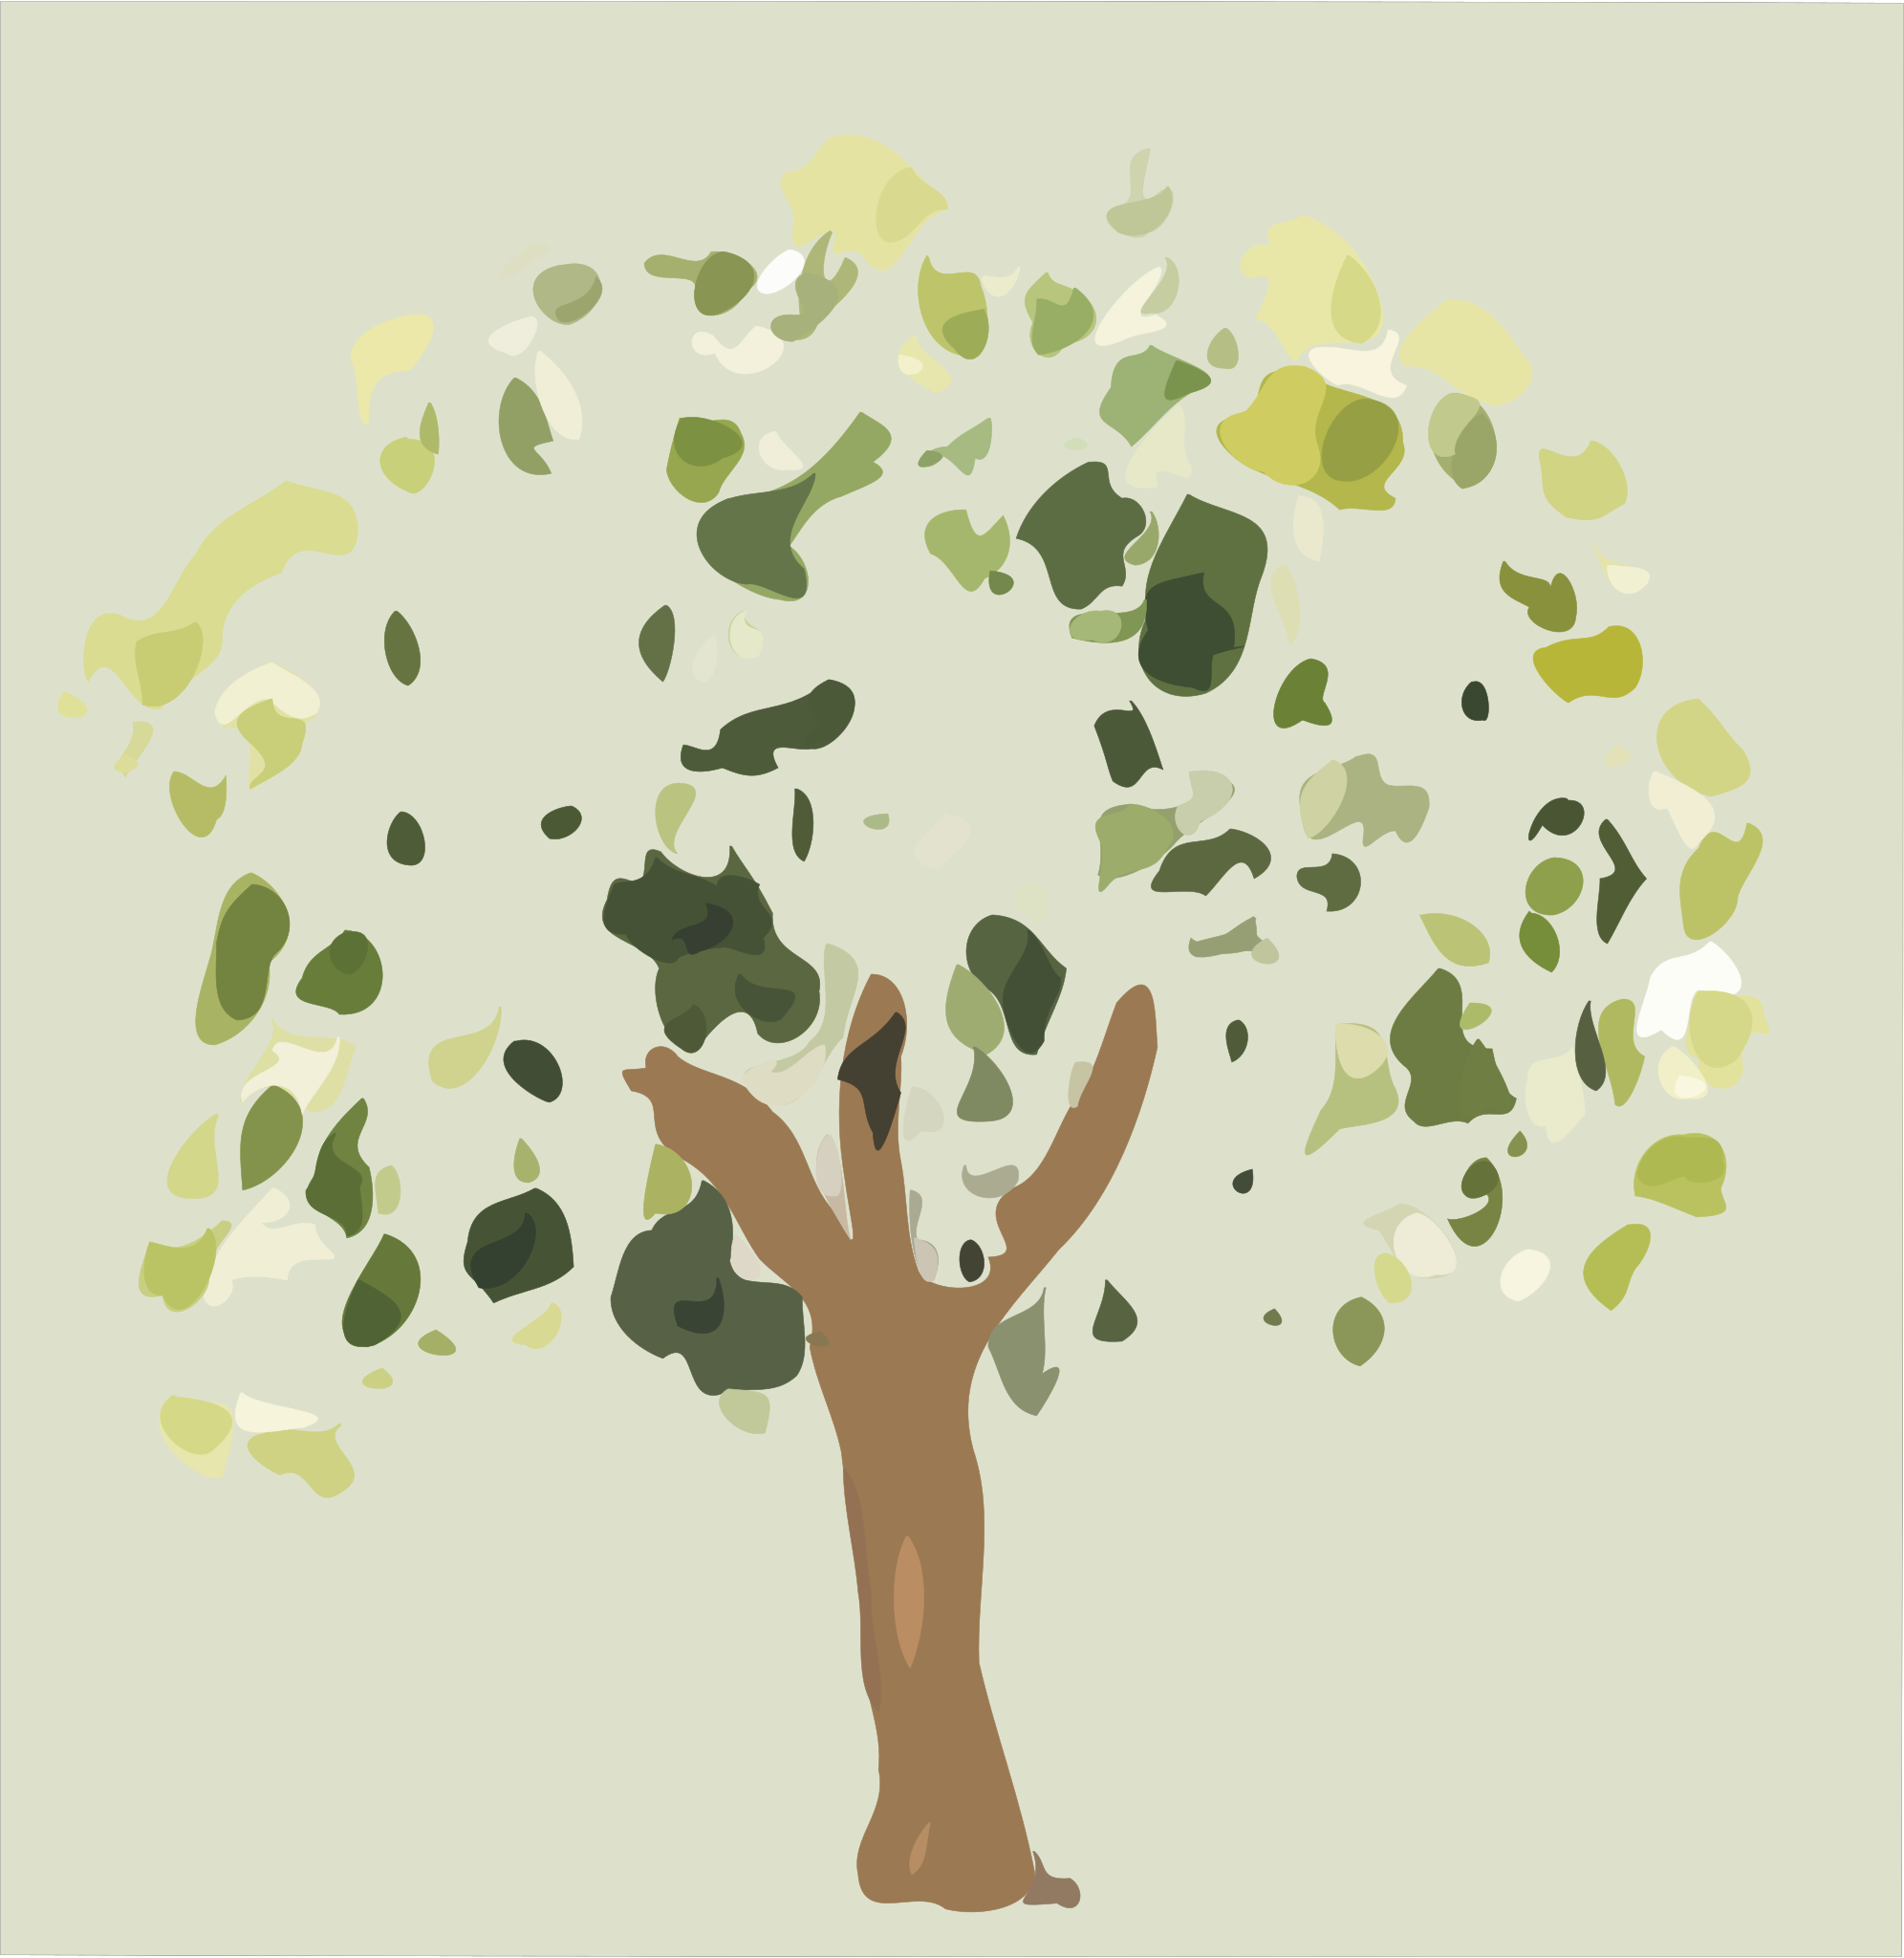

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.6716306858458
Topic5\work-from-home.png 
use_bezier_curve_num : 600 
component_num : 42


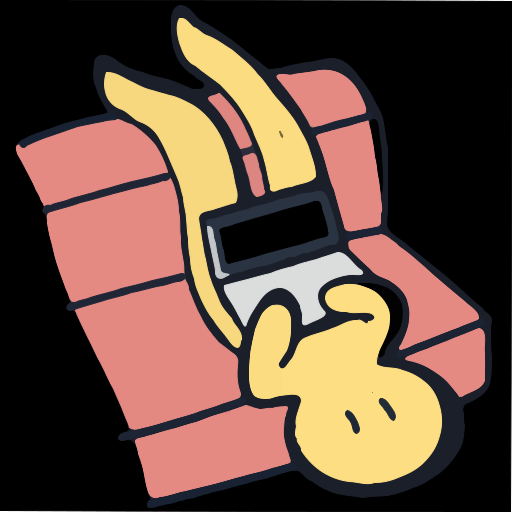

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 14.110486348470053
Topic5 Total MSE: 400.00662390883696
Topic5\fallingwater.jpg 
use_bezier_curve_num : 800 
component_num : 139


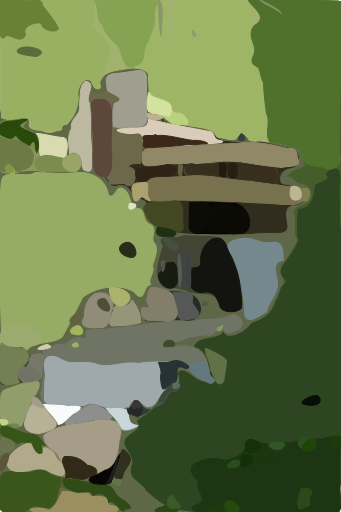

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.1306951826735
Topic5\flower.jpg 
use_bezier_curve_num : 800 
component_num : 177


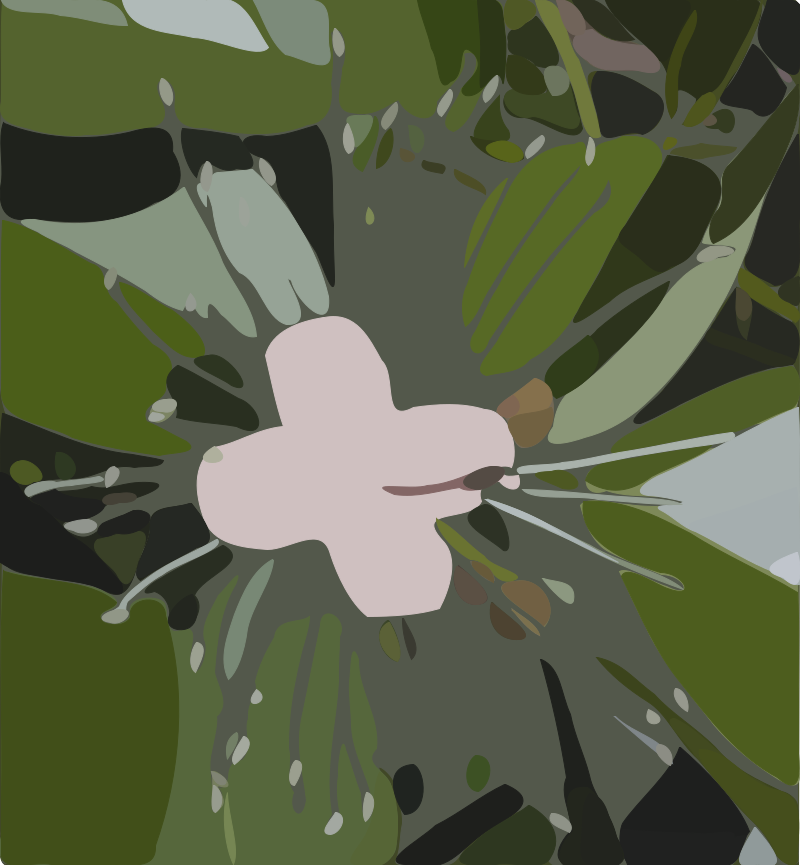

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.97203564547206
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 800 
component_num : 98


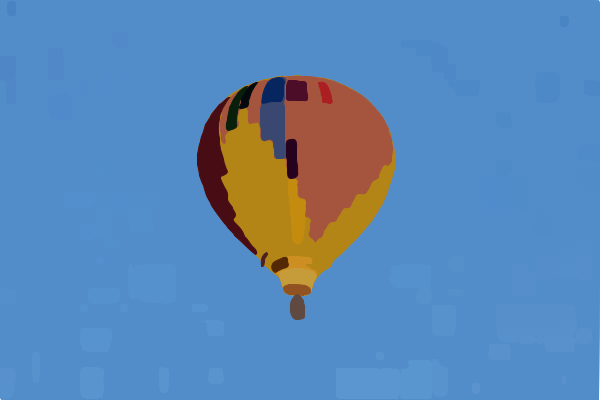

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.070058333333332
Topic5\autumn_01.png 
use_bezier_curve_num : 800 
component_num : 22


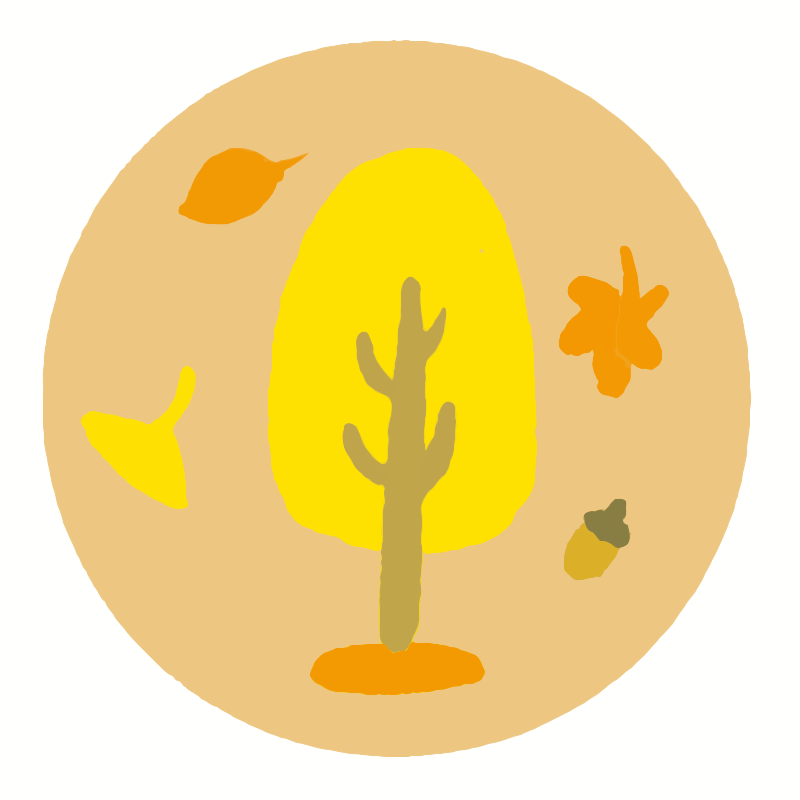

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.8730625
Topic5\dolphin.png 
use_bezier_curve_num : 800 
component_num : 78


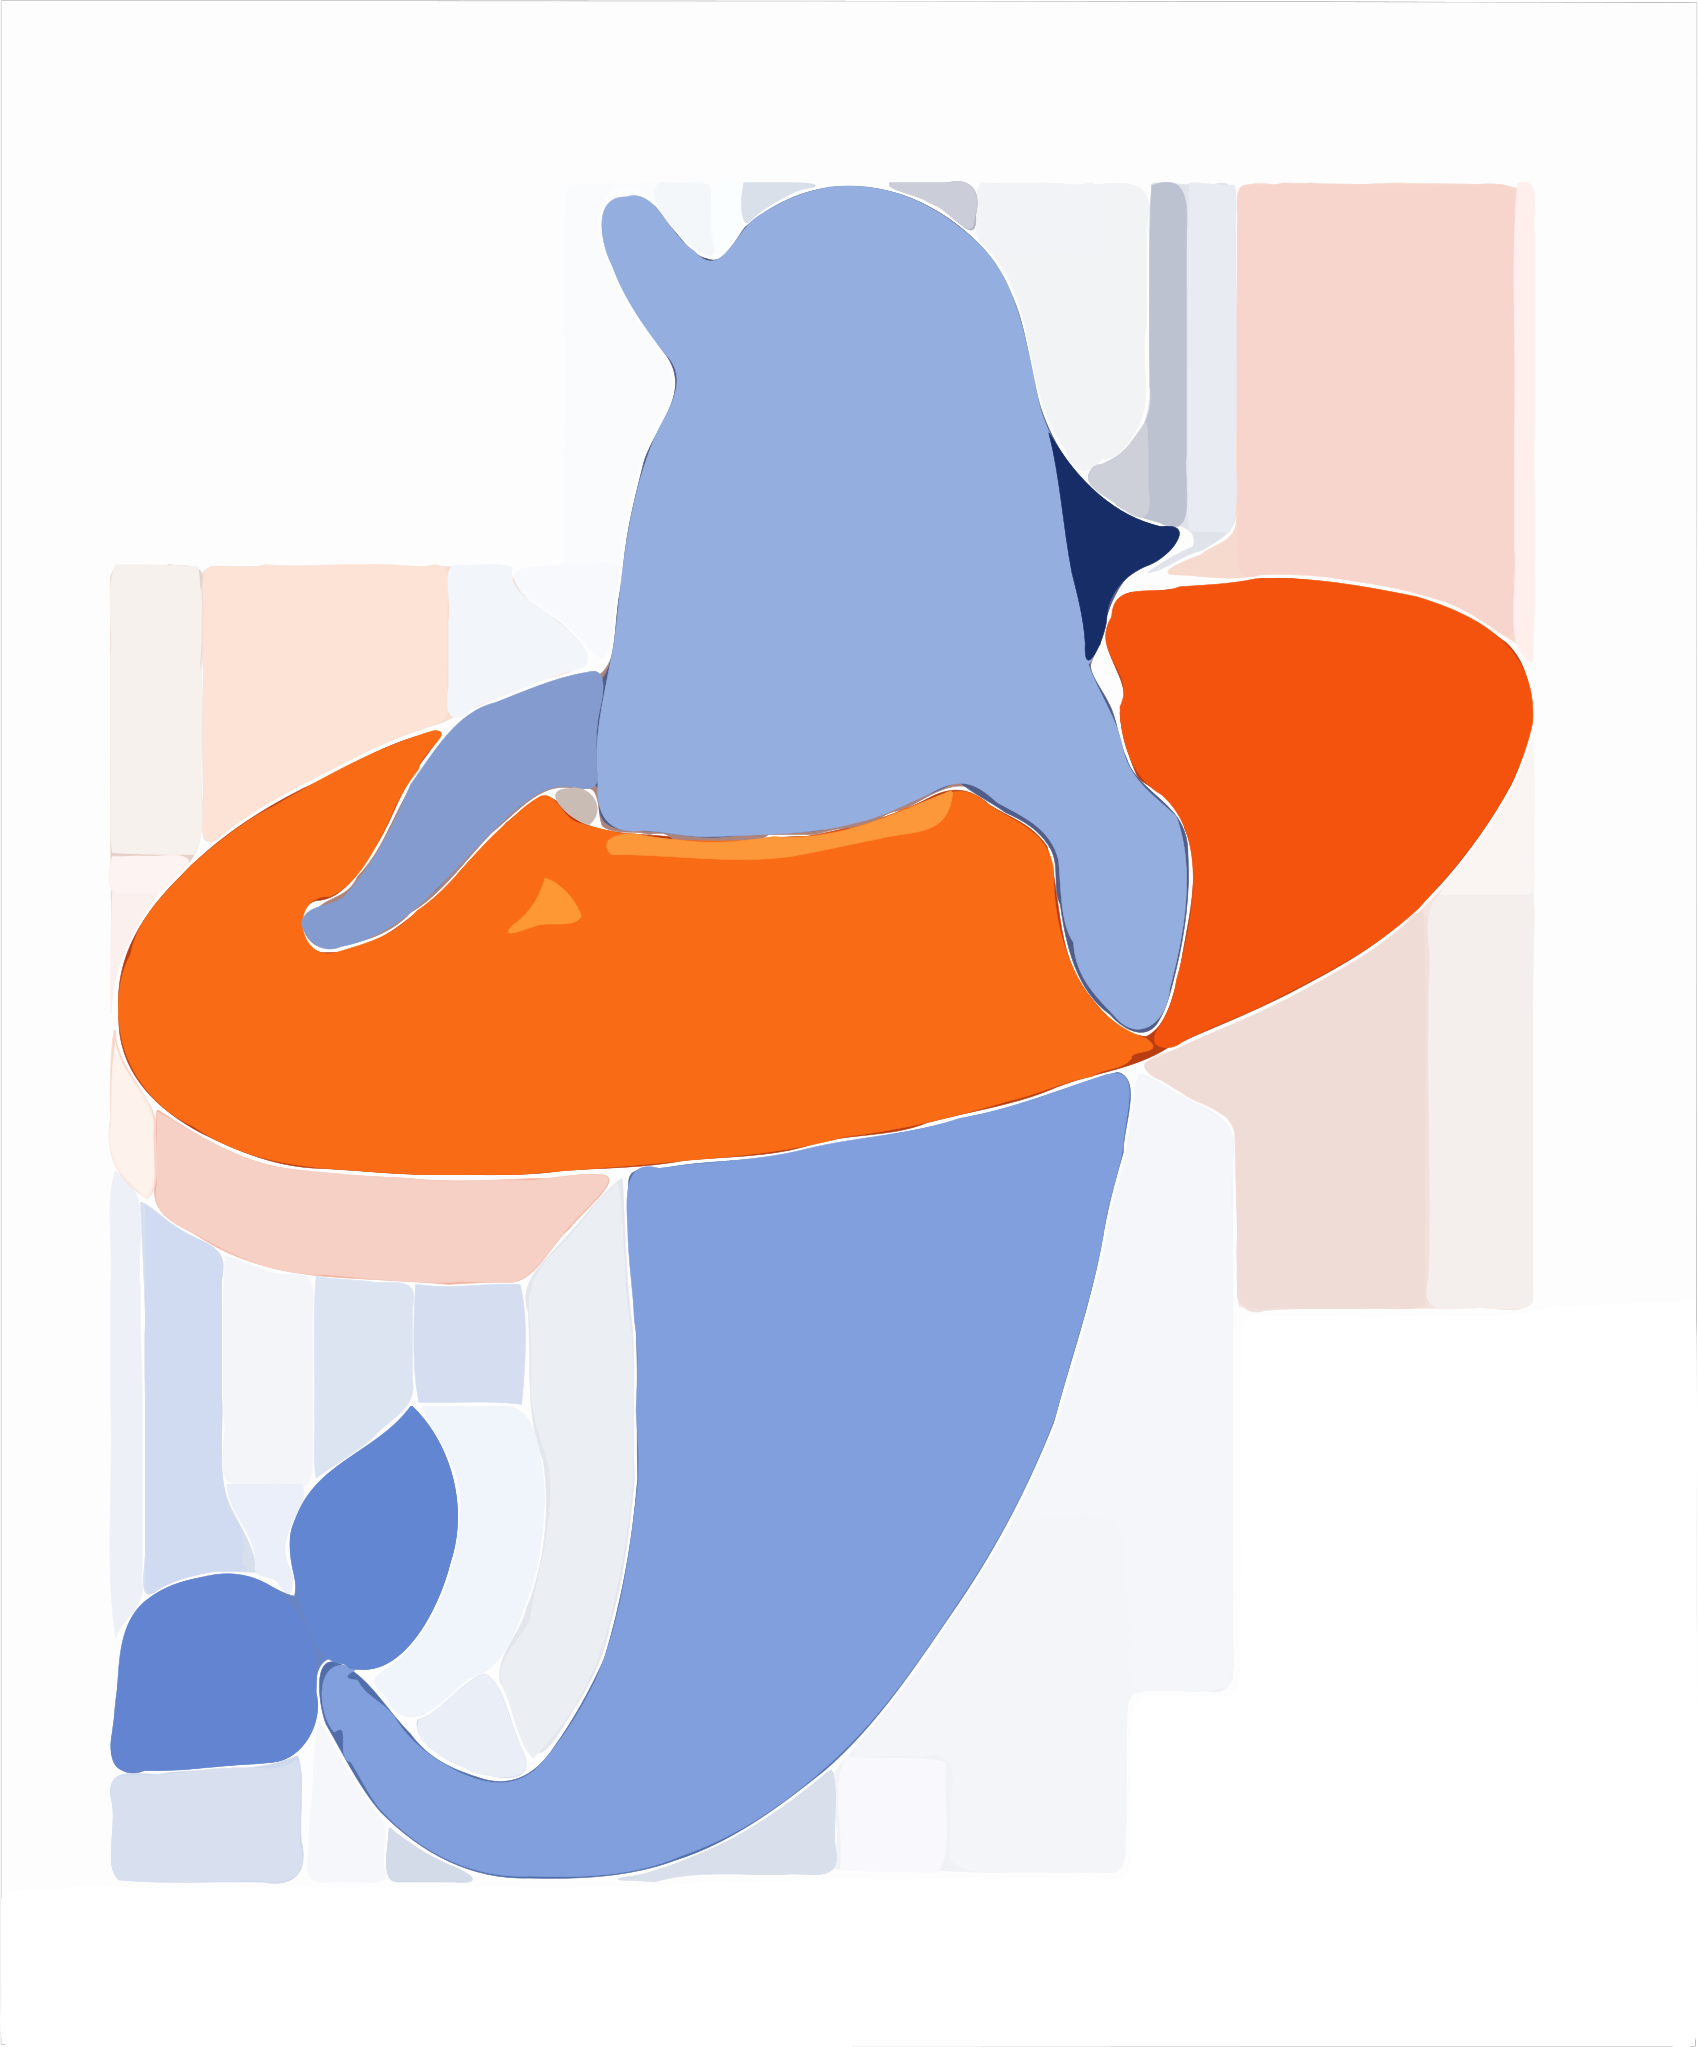

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.215778920701865
Topic5\house.png 
use_bezier_curve_num : 800 
component_num : 57


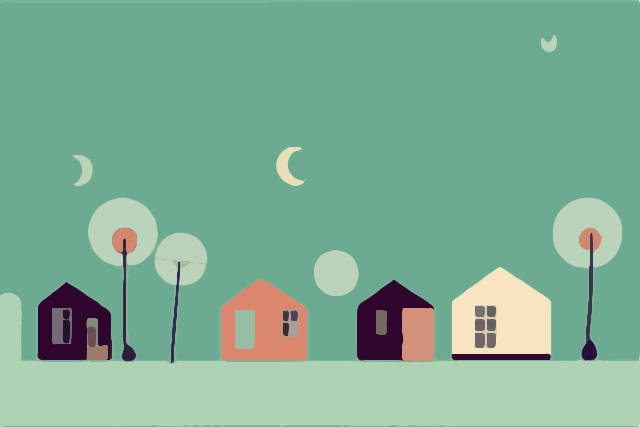

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.278547033567525
Topic5\meditation.png 
use_bezier_curve_num : 800 
component_num : 60


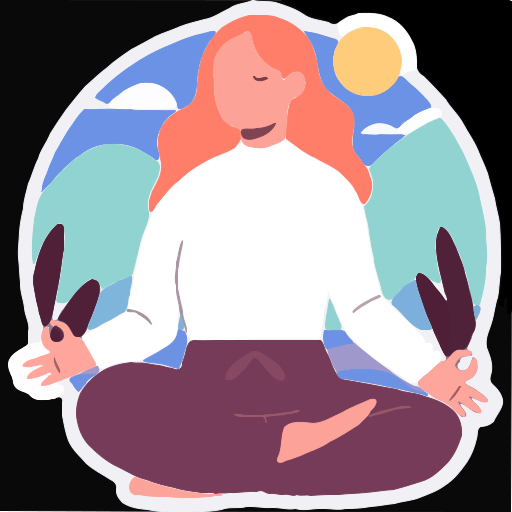

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 30.081231435139973
Topic5\tree.png 
use_bezier_curve_num : 800 
component_num : 200


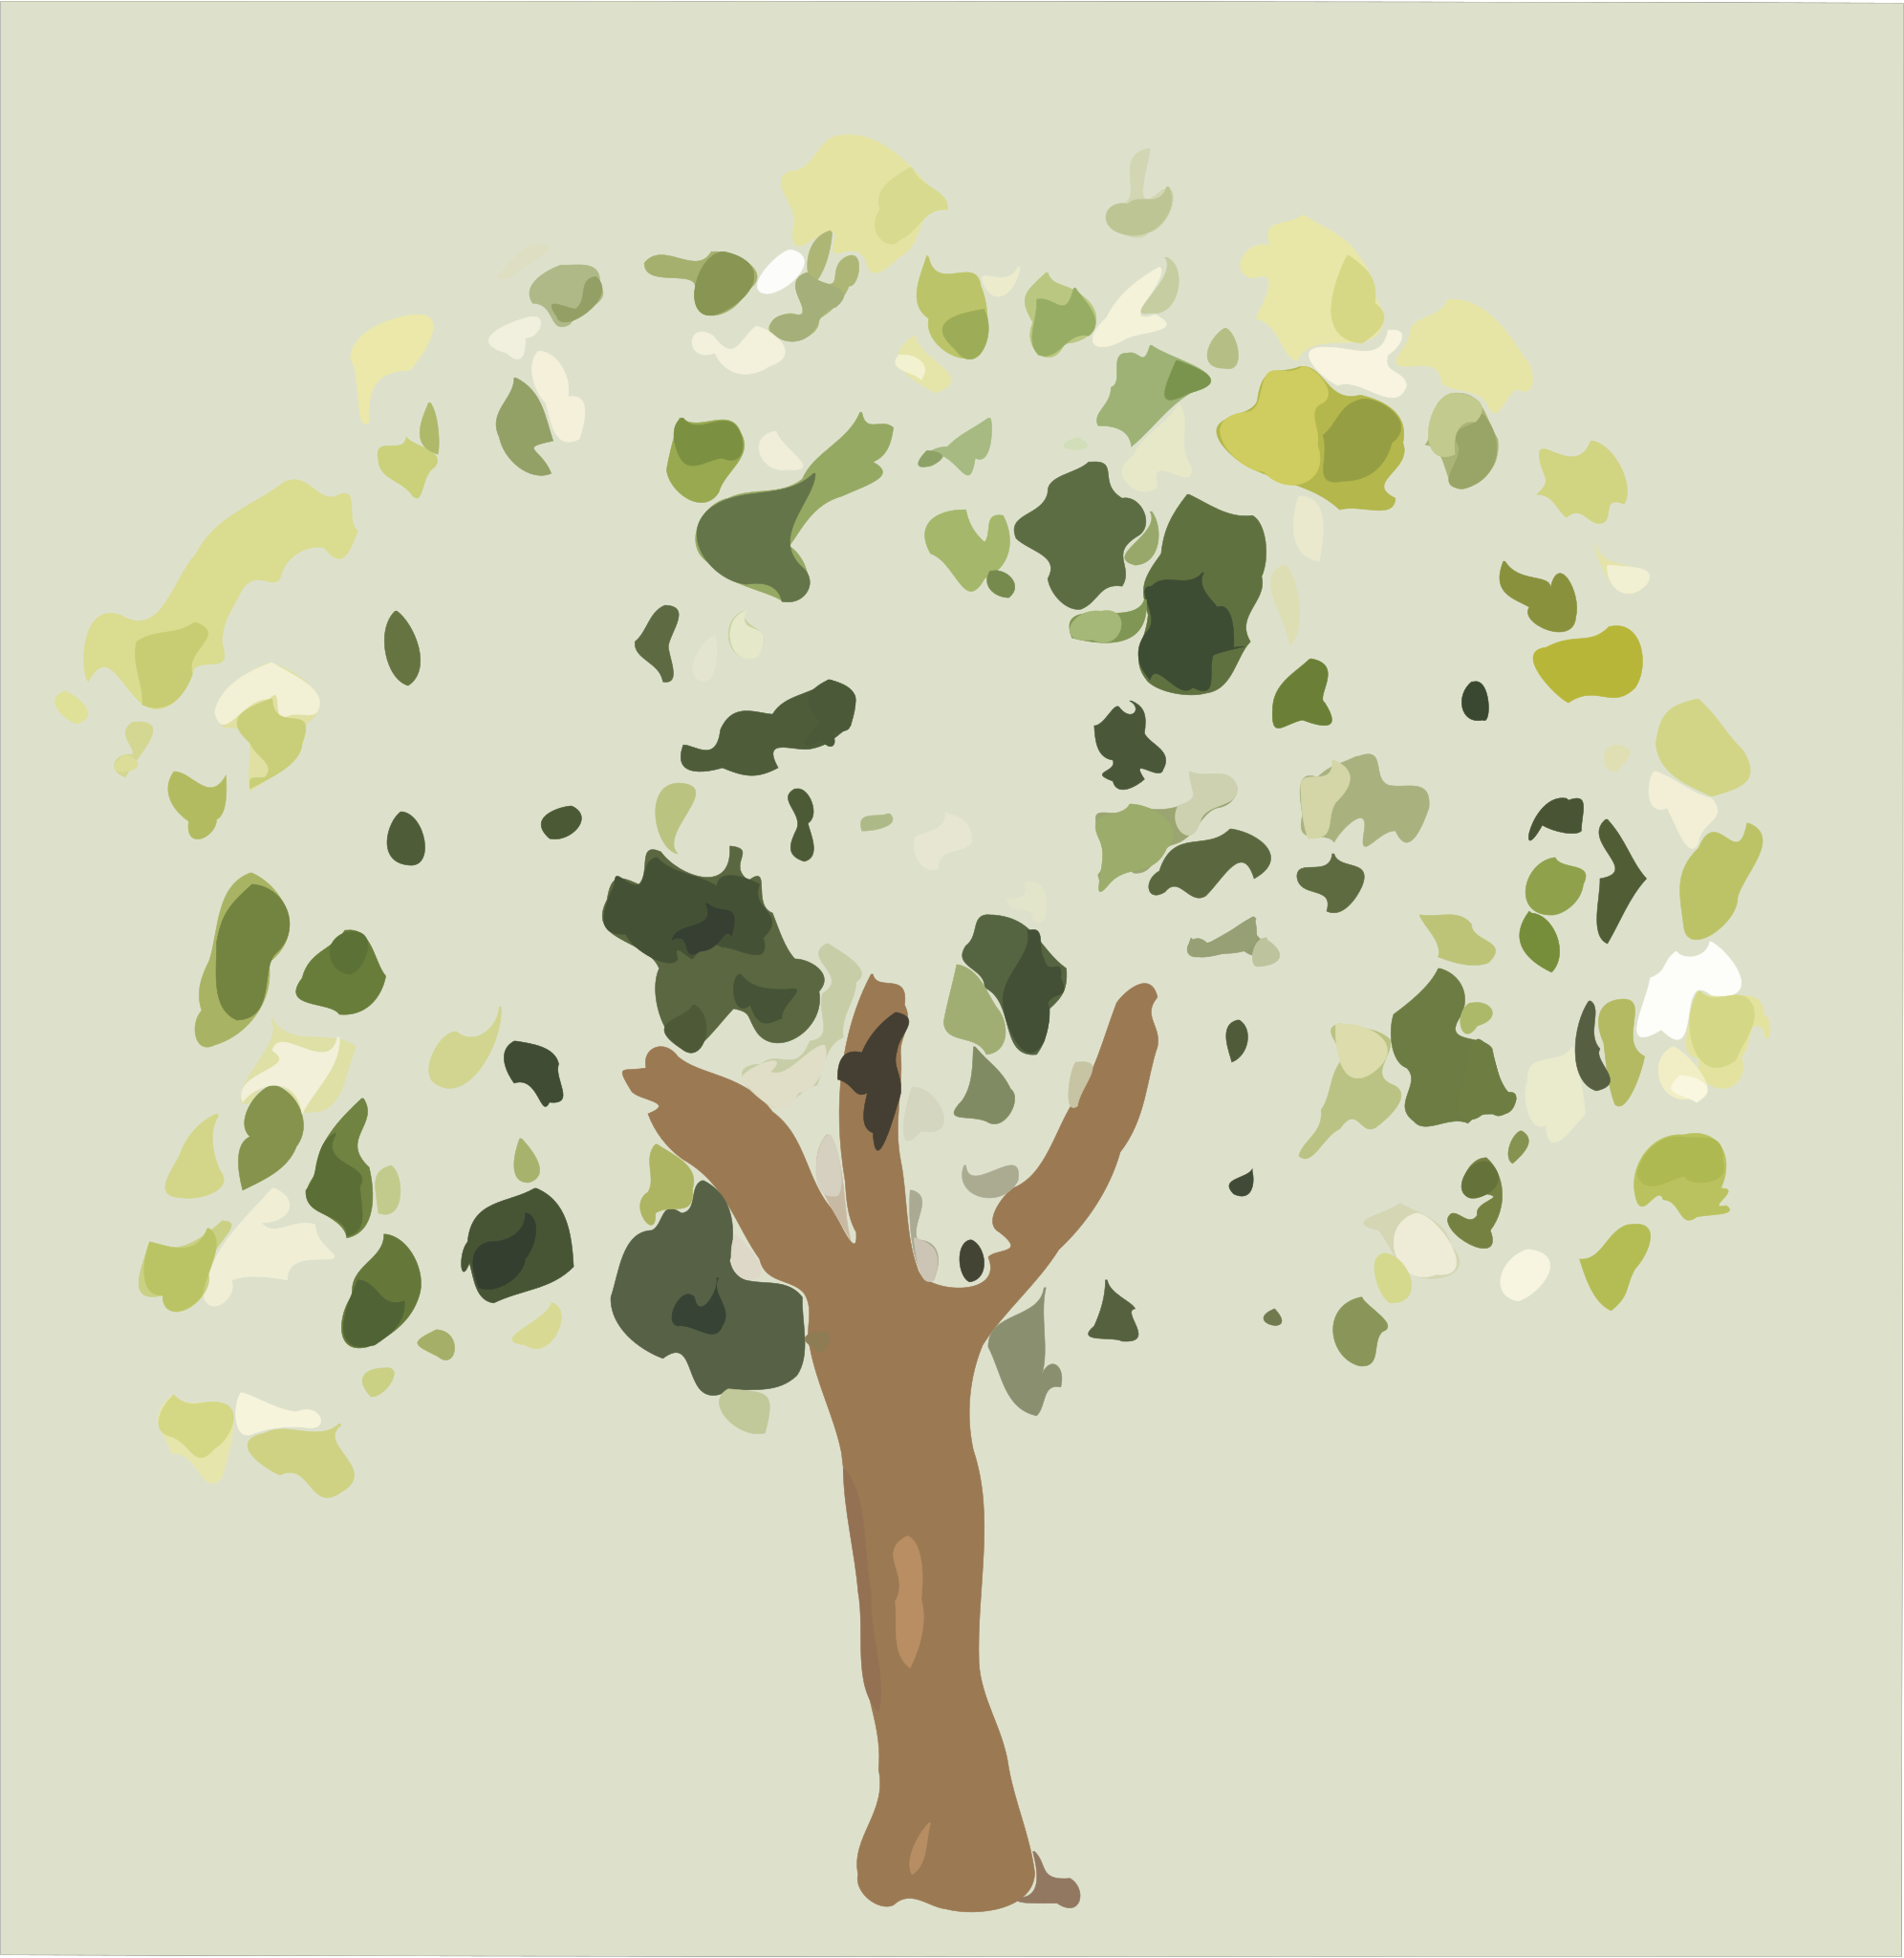

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.45332389994415
Topic5\work-from-home.png 
use_bezier_curve_num : 800 
component_num : 42


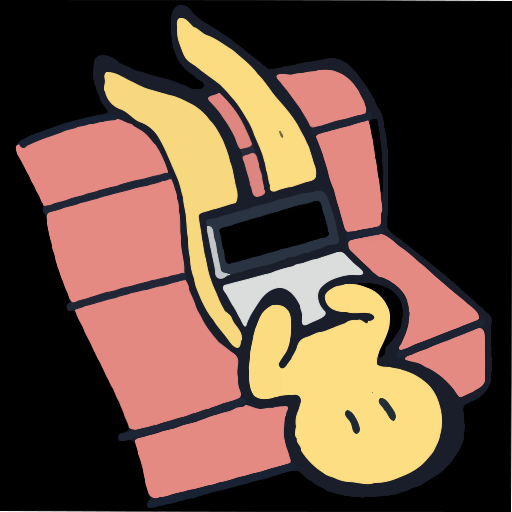

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 13.634674072265625
Topic5 Total MSE: 395.70940702309804
Topic5\fallingwater.jpg 
use_bezier_curve_num : 1000 
component_num : 139


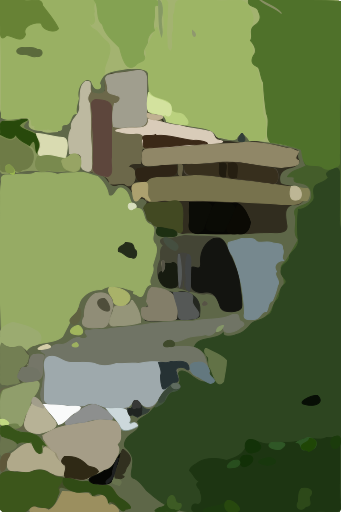

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.1173306909824
Topic5\flower.jpg 
use_bezier_curve_num : 1000 
component_num : 177


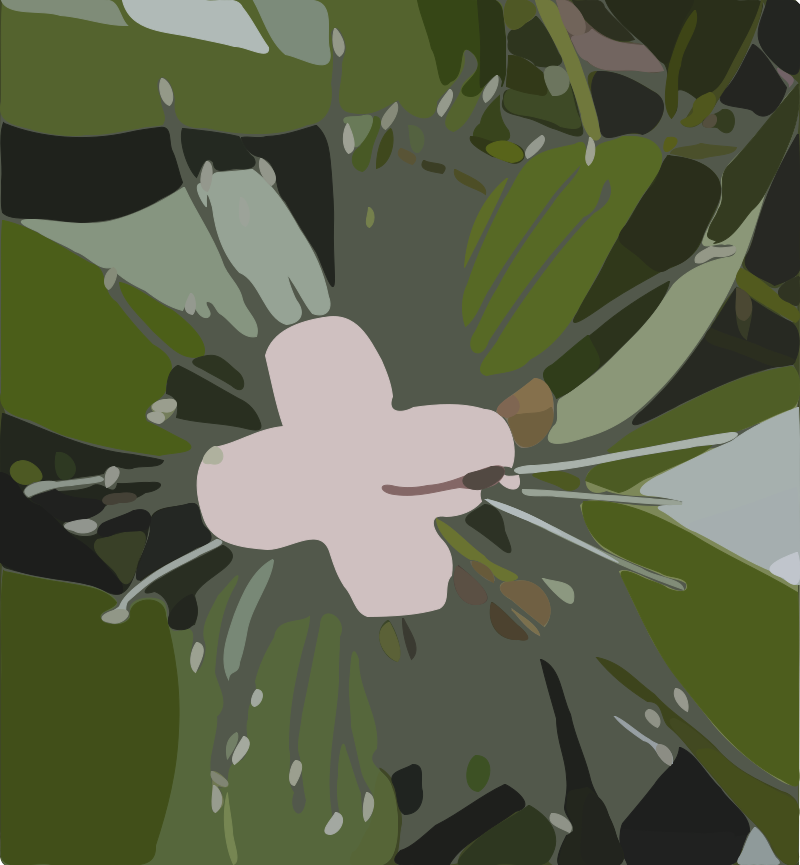

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.67441811175337
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 1000 
component_num : 98


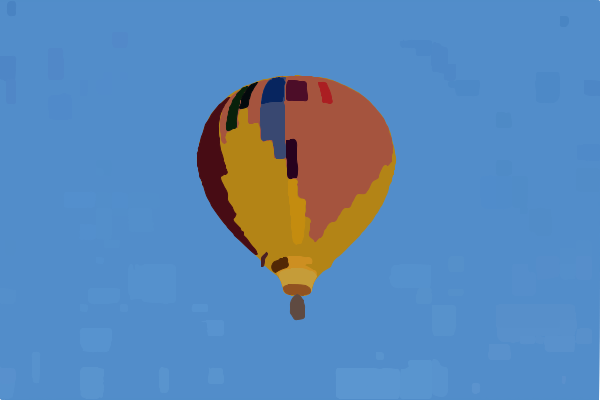

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.135279166666667
Topic5\autumn_01.png 
use_bezier_curve_num : 1000 
component_num : 22


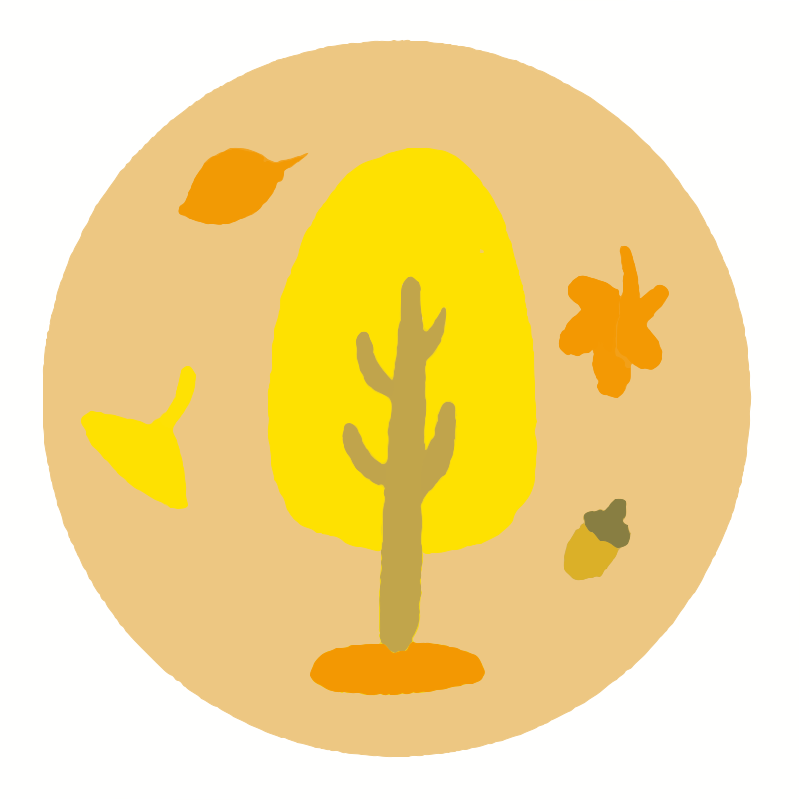

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.8421036458333333
Topic5\dolphin.png 
use_bezier_curve_num : 1000 
component_num : 78


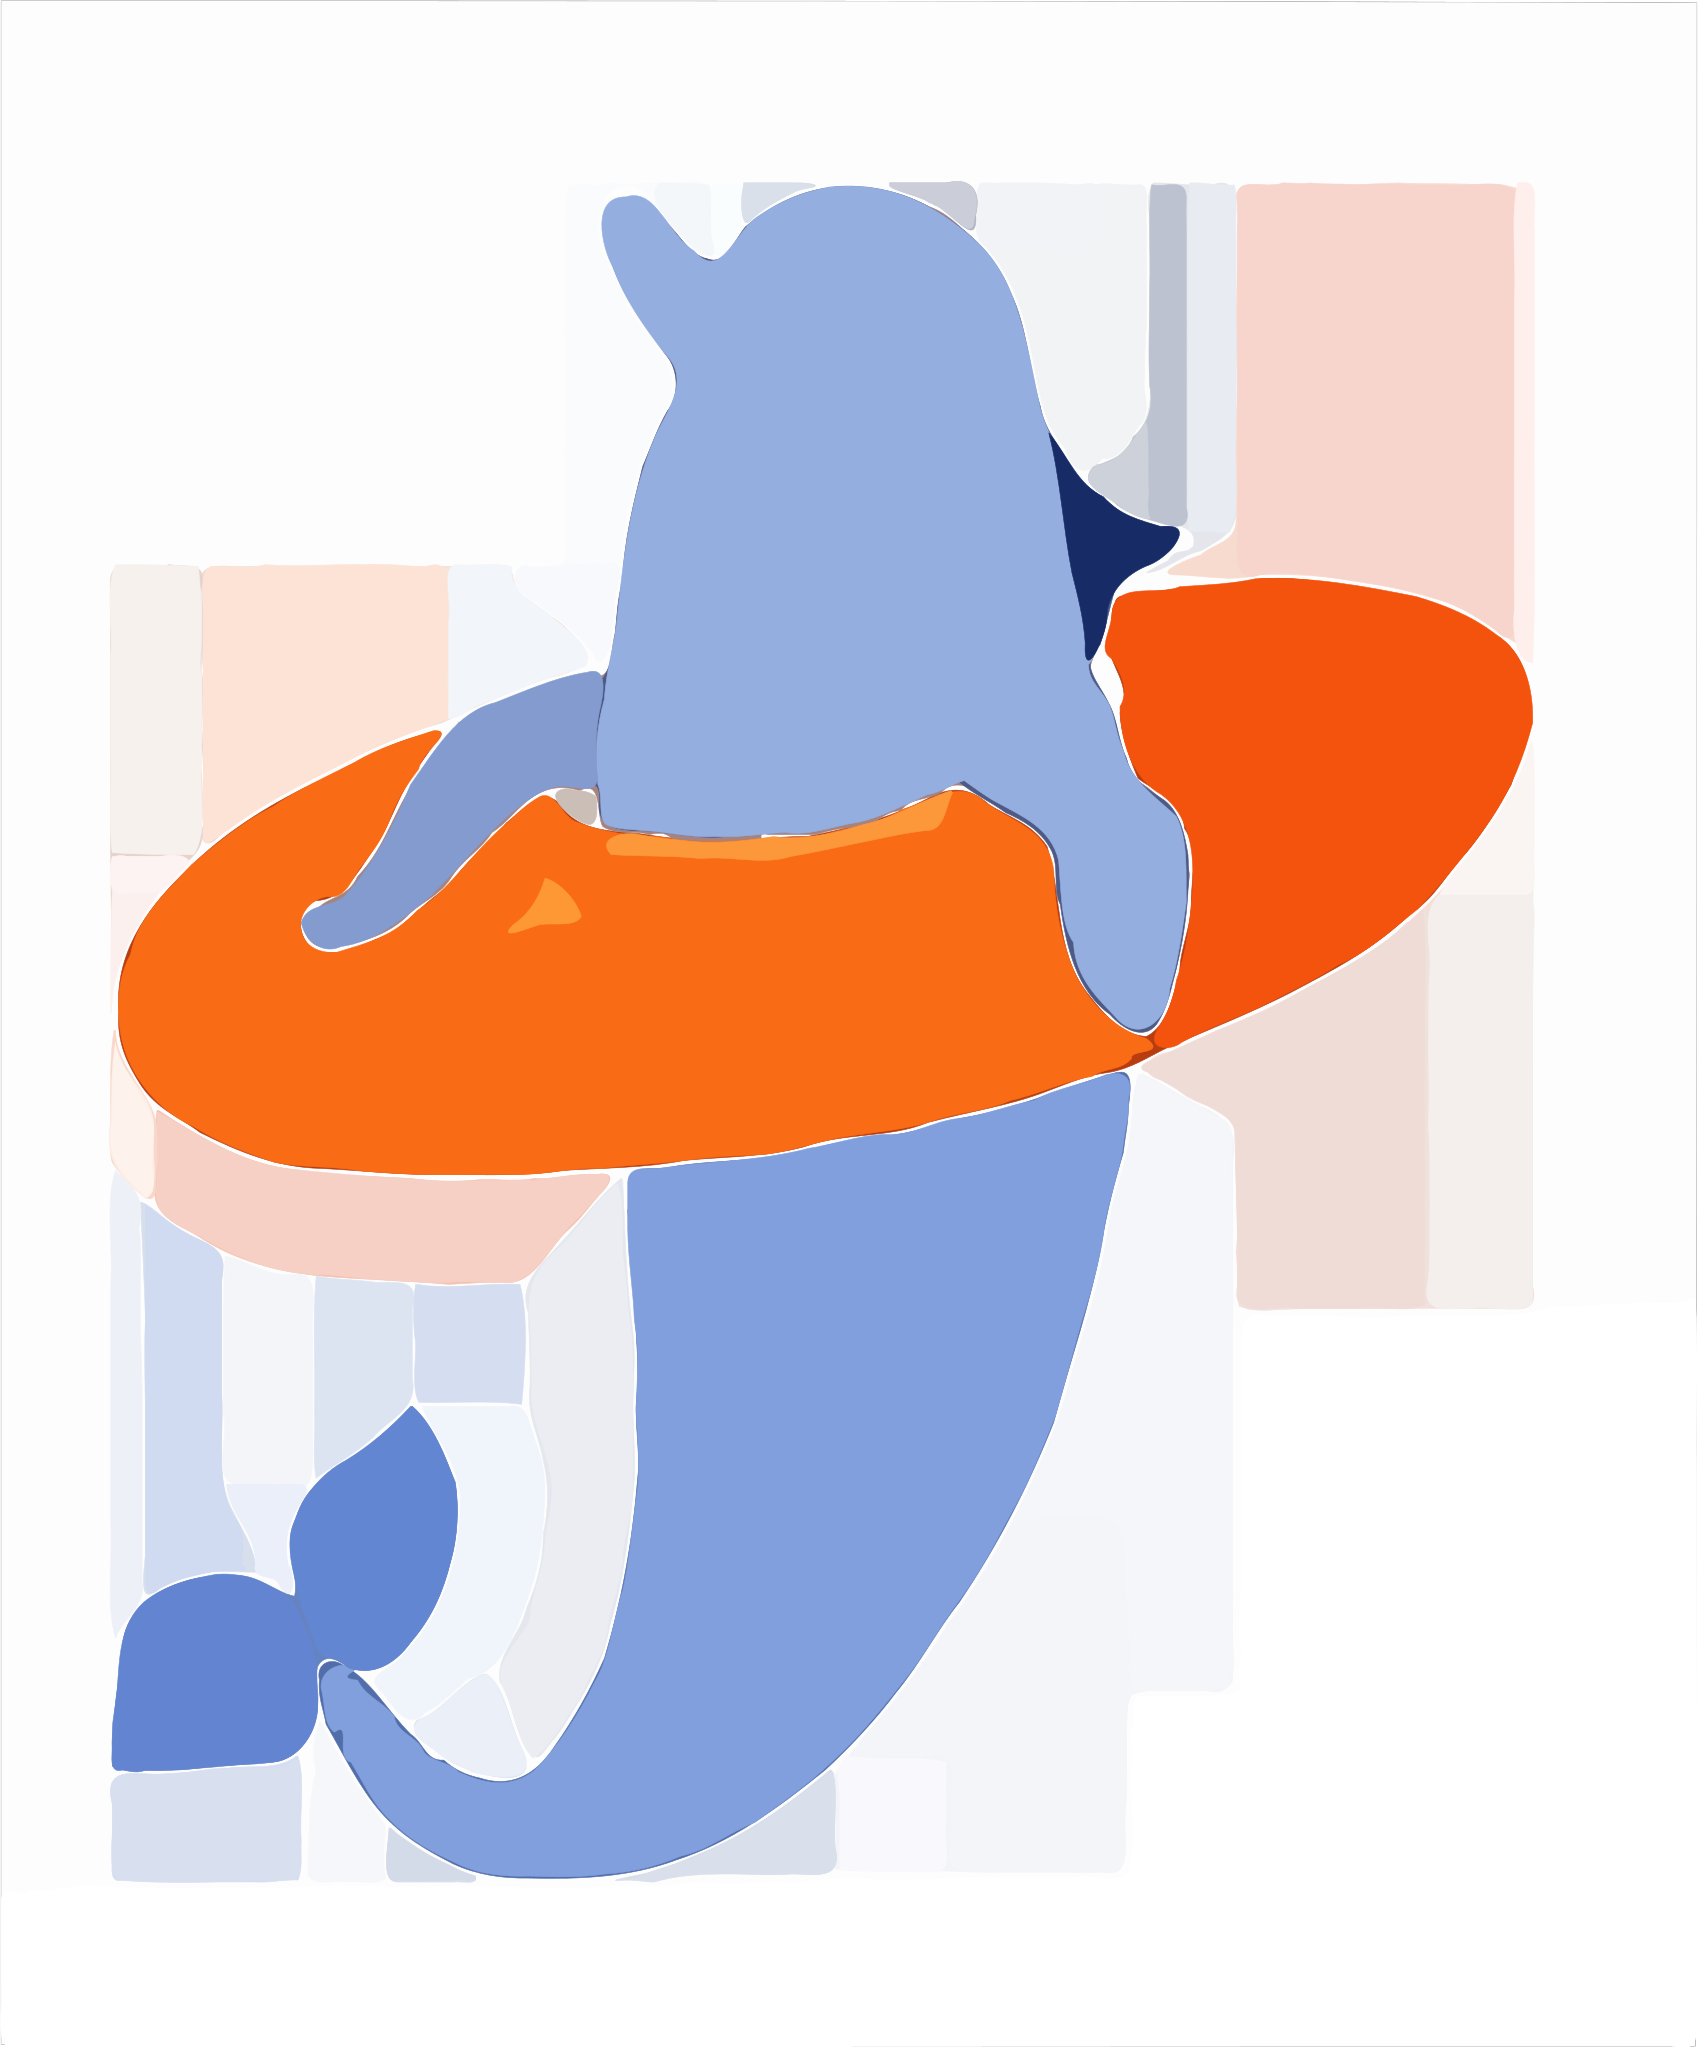

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.207512722804104
Topic5\house.png 
use_bezier_curve_num : 1000 
component_num : 57


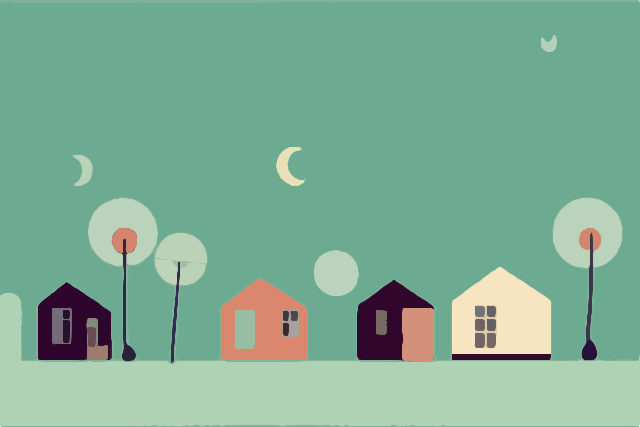

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.270369828259173
Topic5\meditation.png 
use_bezier_curve_num : 1000 
component_num : 60


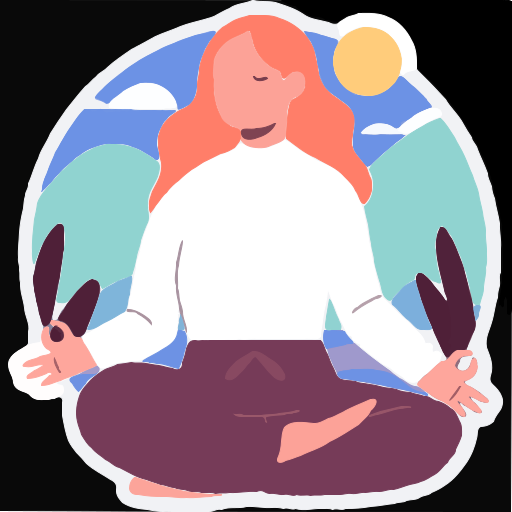

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 29.468644460042317
Topic5\tree.png 
use_bezier_curve_num : 1000 
component_num : 200


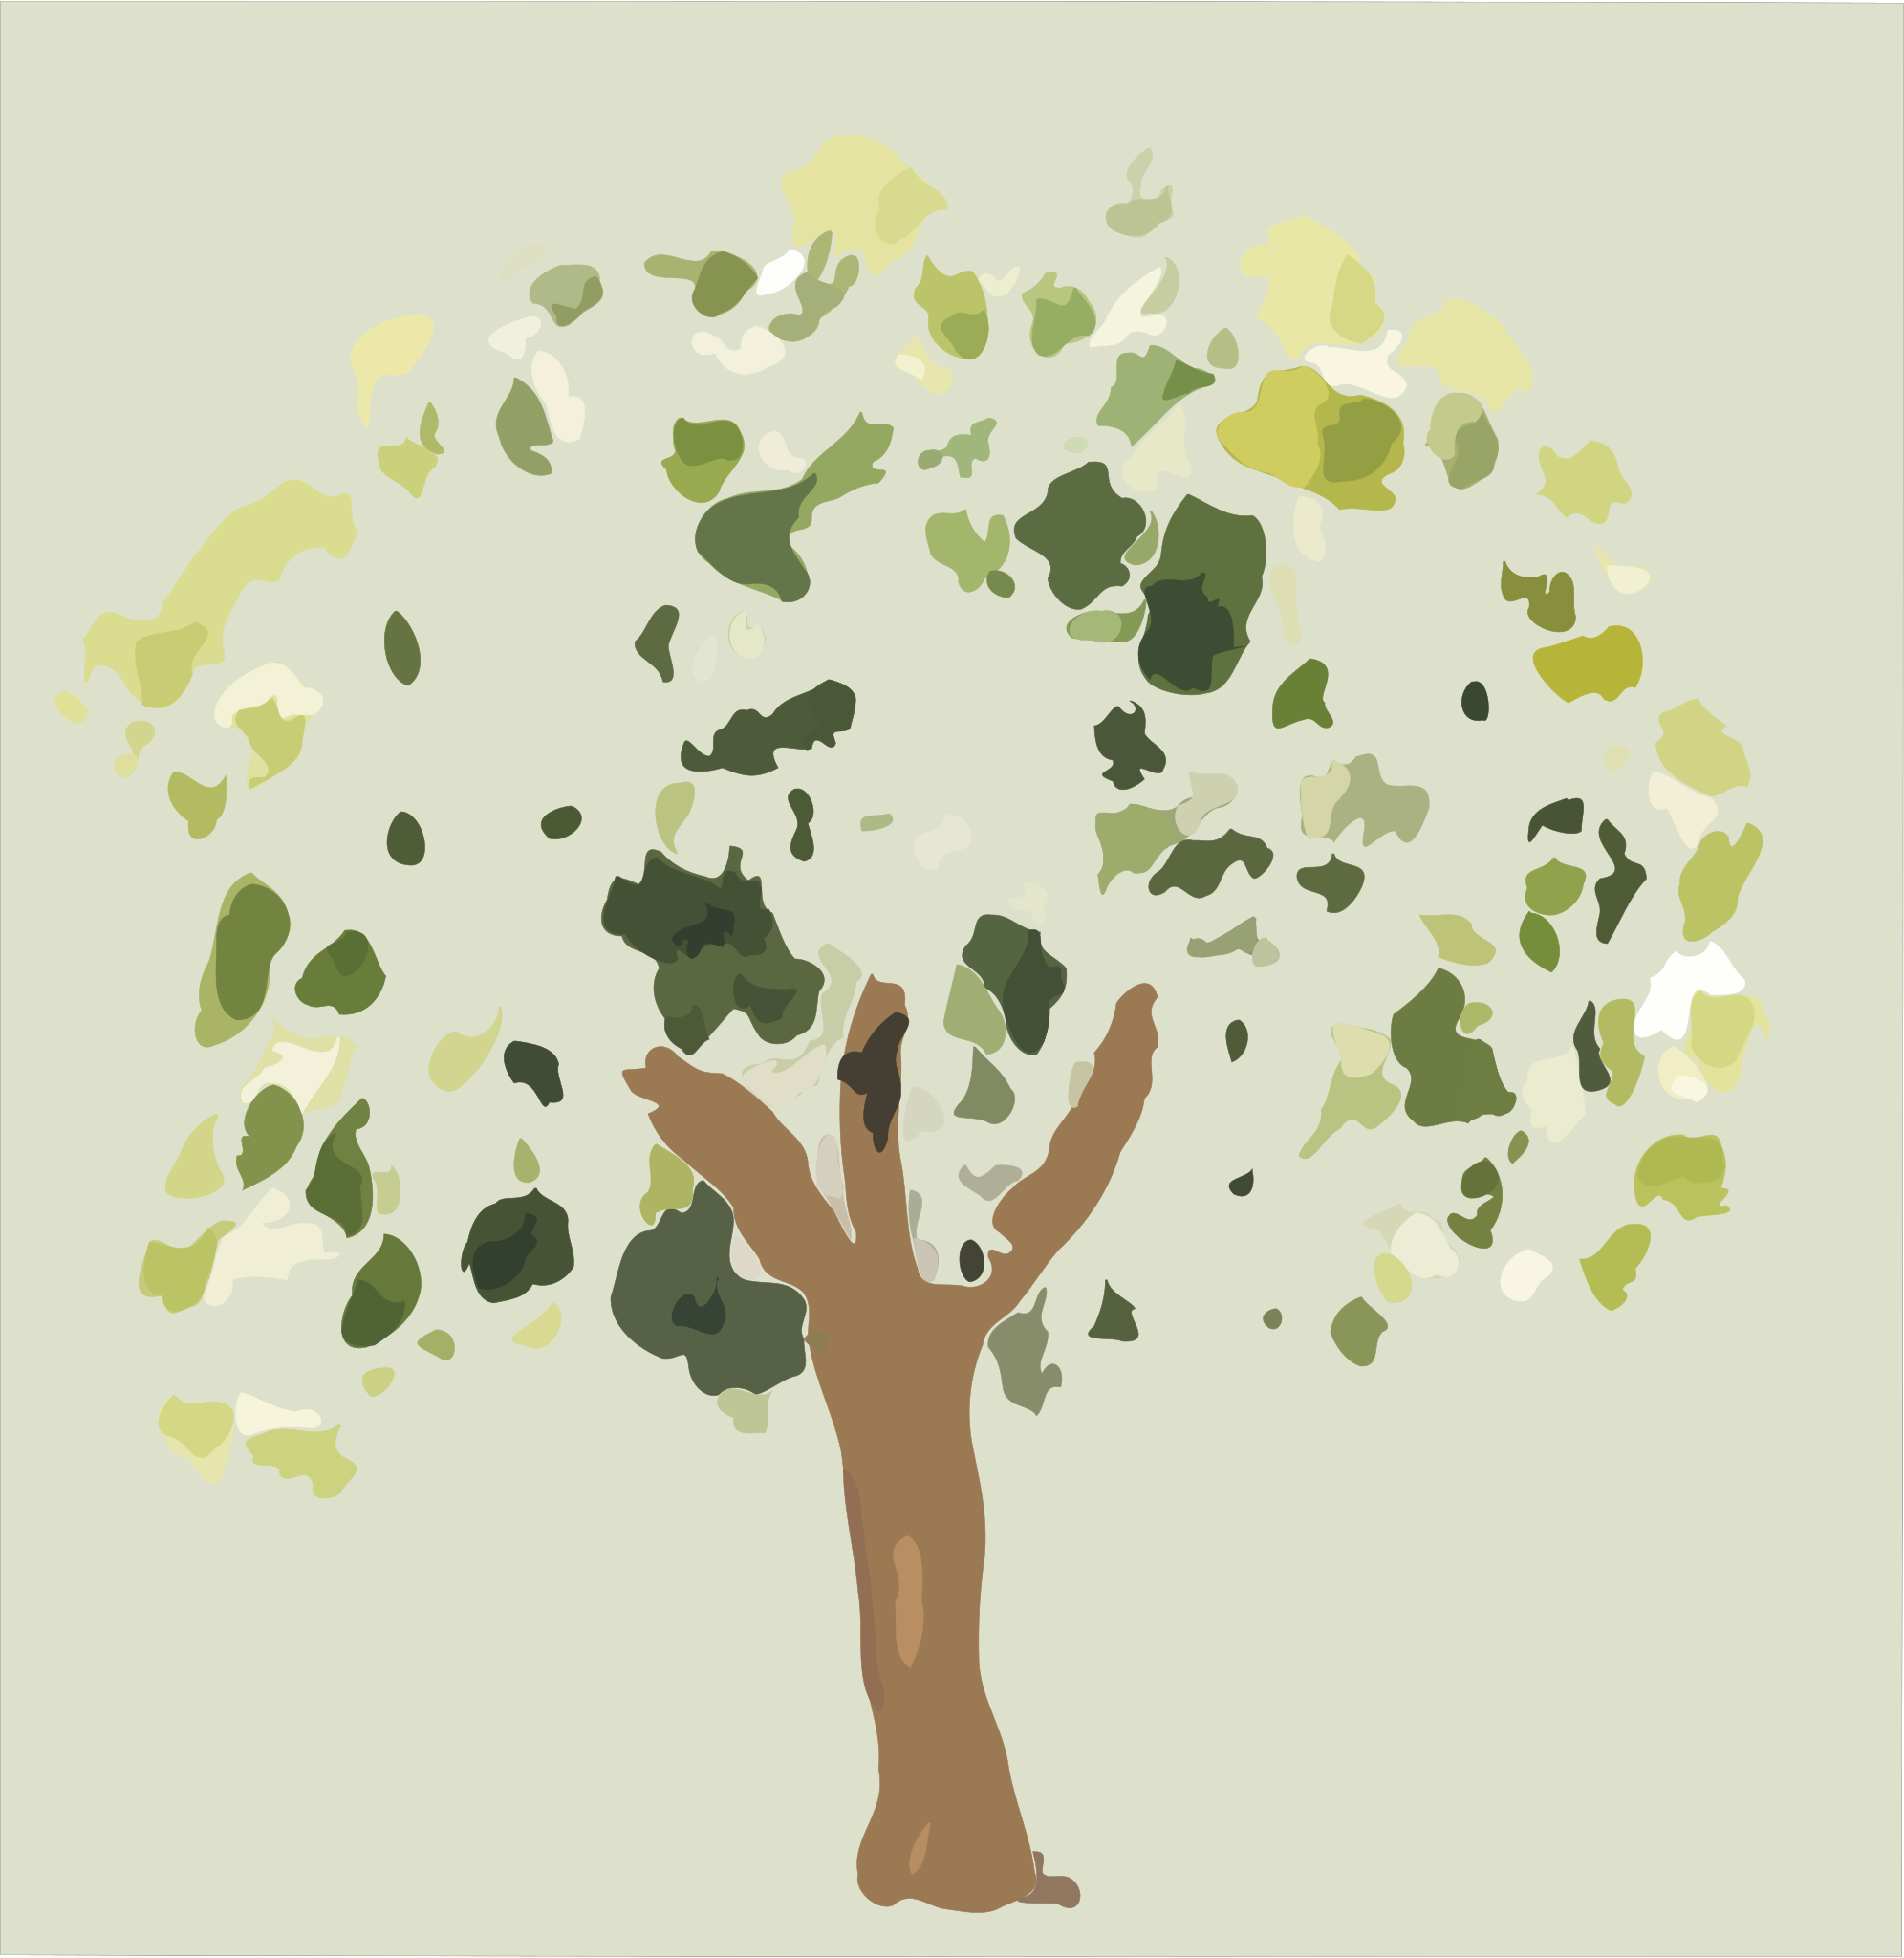

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.1684704685555
Topic5\work-from-home.png 
use_bezier_curve_num : 1000 
component_num : 42


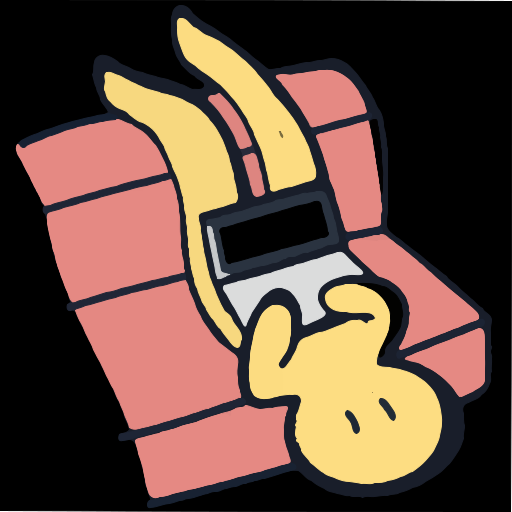

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 13.822642008463541
Topic5 Total MSE: 394.7067711033604
768.5641703605652


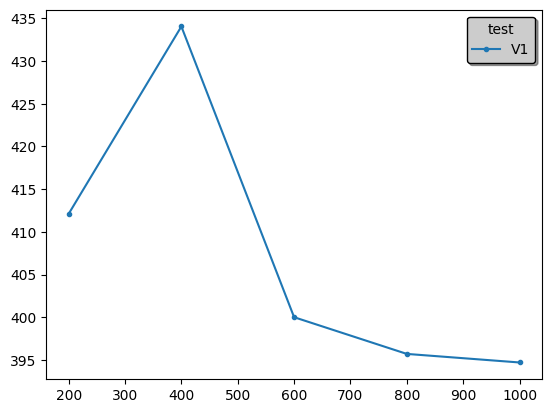

In [108]:
max_component_num = 200
max_bezier_curve_nums = [200,400,600,800,1000]

image_floder = 'Topic5'

import os

gtkbin = r'C:\Program Files\GTK3-Runtime Win64\bin'
add_dll_dir = getattr(os, 'add_dll_directory', None)
if callable(add_dll_dir):
    add_dll_dir(gtkbin)
else:
    os.environ['PATH'] = os.pathsep.join((gtkbin, os.environ['PATH']))

import glob
import random
import time
from cairosvg import svg2png
from IPython.display import display, SVG


image_paths=glob.glob(image_floder+"/*.jpg")+glob.glob(image_floder+"/*.png")

tmsess = dict()

# random.shuffle(image_paths)
def Test(V21=False,V22=False,V23=False,V31=False,V32=False,labelname="V"):
    ti=time.time()
    tmses=[]
    for max_bezier_curve_num in max_bezier_curve_nums:
        tmse=0

        for image_path in image_paths:
            SAMVGV1(image_path,max_component_num,max_bezier_curve_num,V21,V22,V23,V31,V32)

            #convert SVG to PNG
            svg_path = 'SVG_' + image_path.split('.')[0]+'.svg'
            write_path = 'SVG2PNG_' + image_path.split('.')[0] + '.png'
            # Display an SVG file directly from its path
            display(SVG(filename=svg_path))
            svg2png(url=svg_path, write_to=write_path, unsafe=True)
            mse=calculate_mse(image_path, write_path)
            tmse+=mse
            print(image_path +" vs " + write_path + ": " + str(mse))
        print(image_floder+" Total MSE:",tmse)
        tmses.append(tmse)
    print(time.time()-ti)
    plt.plot(max_bezier_curve_nums,tmses,'.-',label=labelname)
    tmsess[labelname] = tmses
    
Test(V21=True,V31=True,labelname="V1")
plt.legend(
    loc='best',
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=10)
plt.show()


Topic5\fallingwater.jpg 
use_bezier_curve_num : 200 
component_num : 139


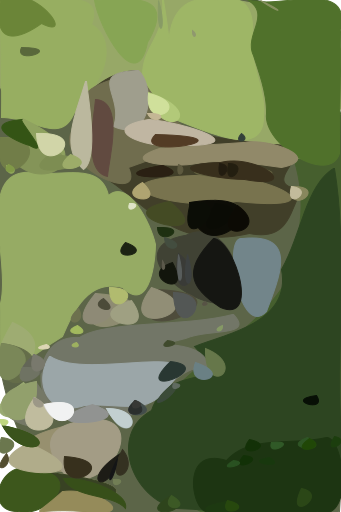

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 98.40271222812805
Topic5\flower.jpg 
use_bezier_curve_num : 200 
component_num : 177


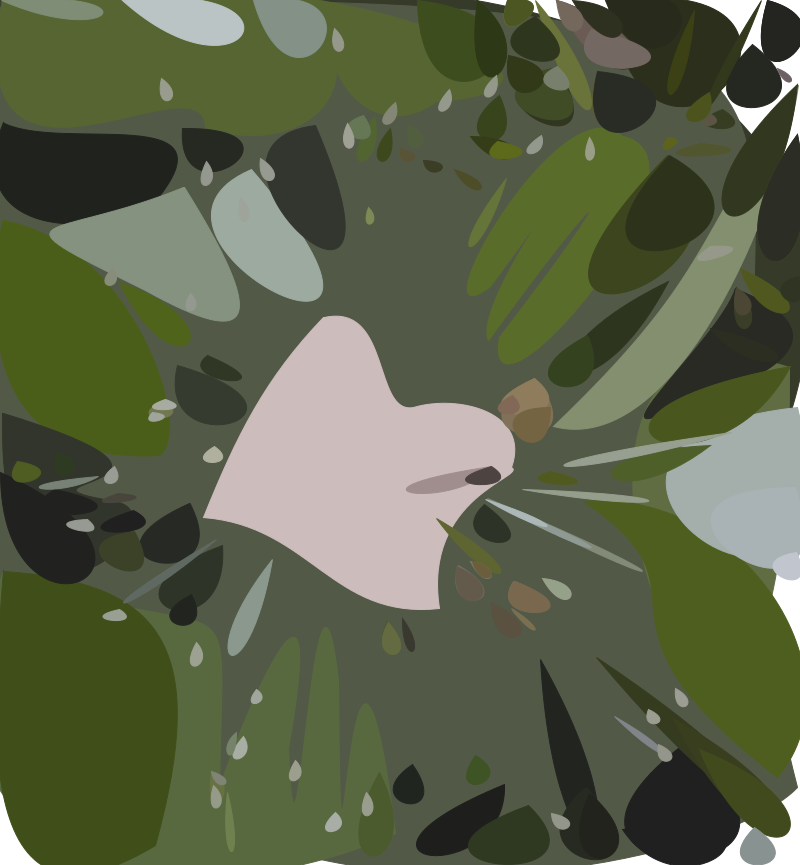

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 86.41533236994219
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 200 
component_num : 98


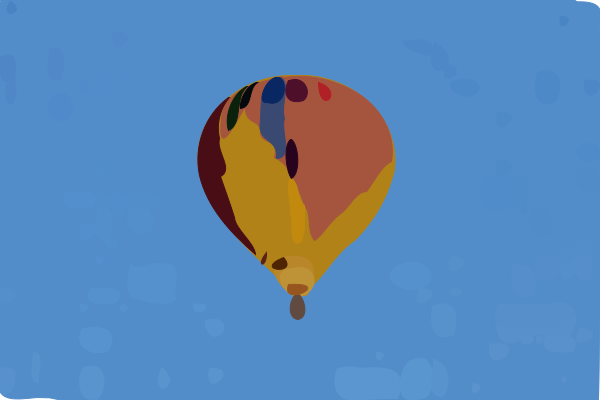

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 26.600768055555555
Topic5\autumn_01.png 
use_bezier_curve_num : 200 
component_num : 22


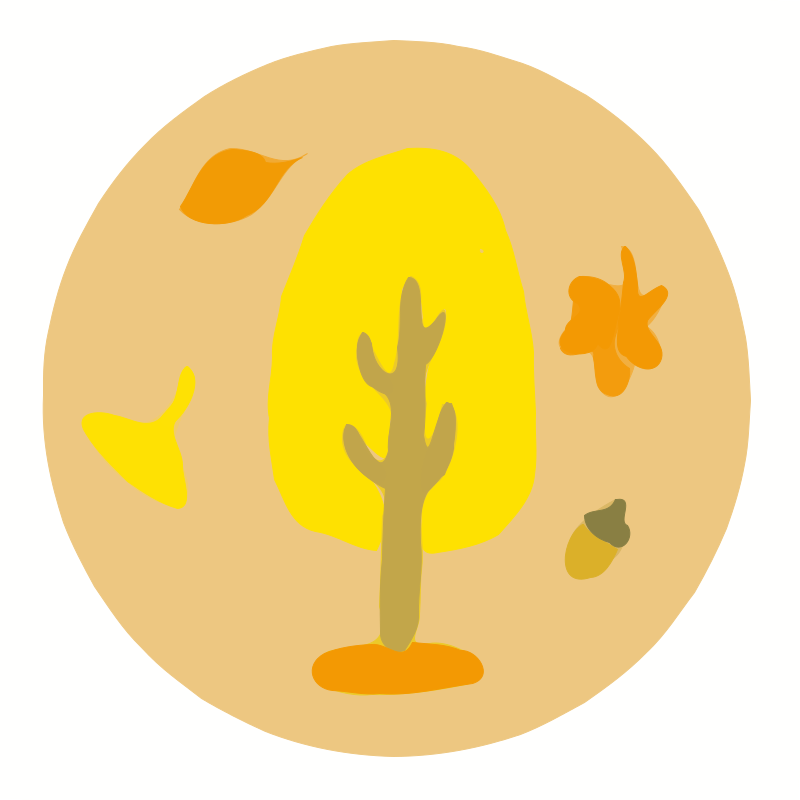

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 2.5858322916666667
Topic5\dolphin.png 
use_bezier_curve_num : 200 
component_num : 78


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


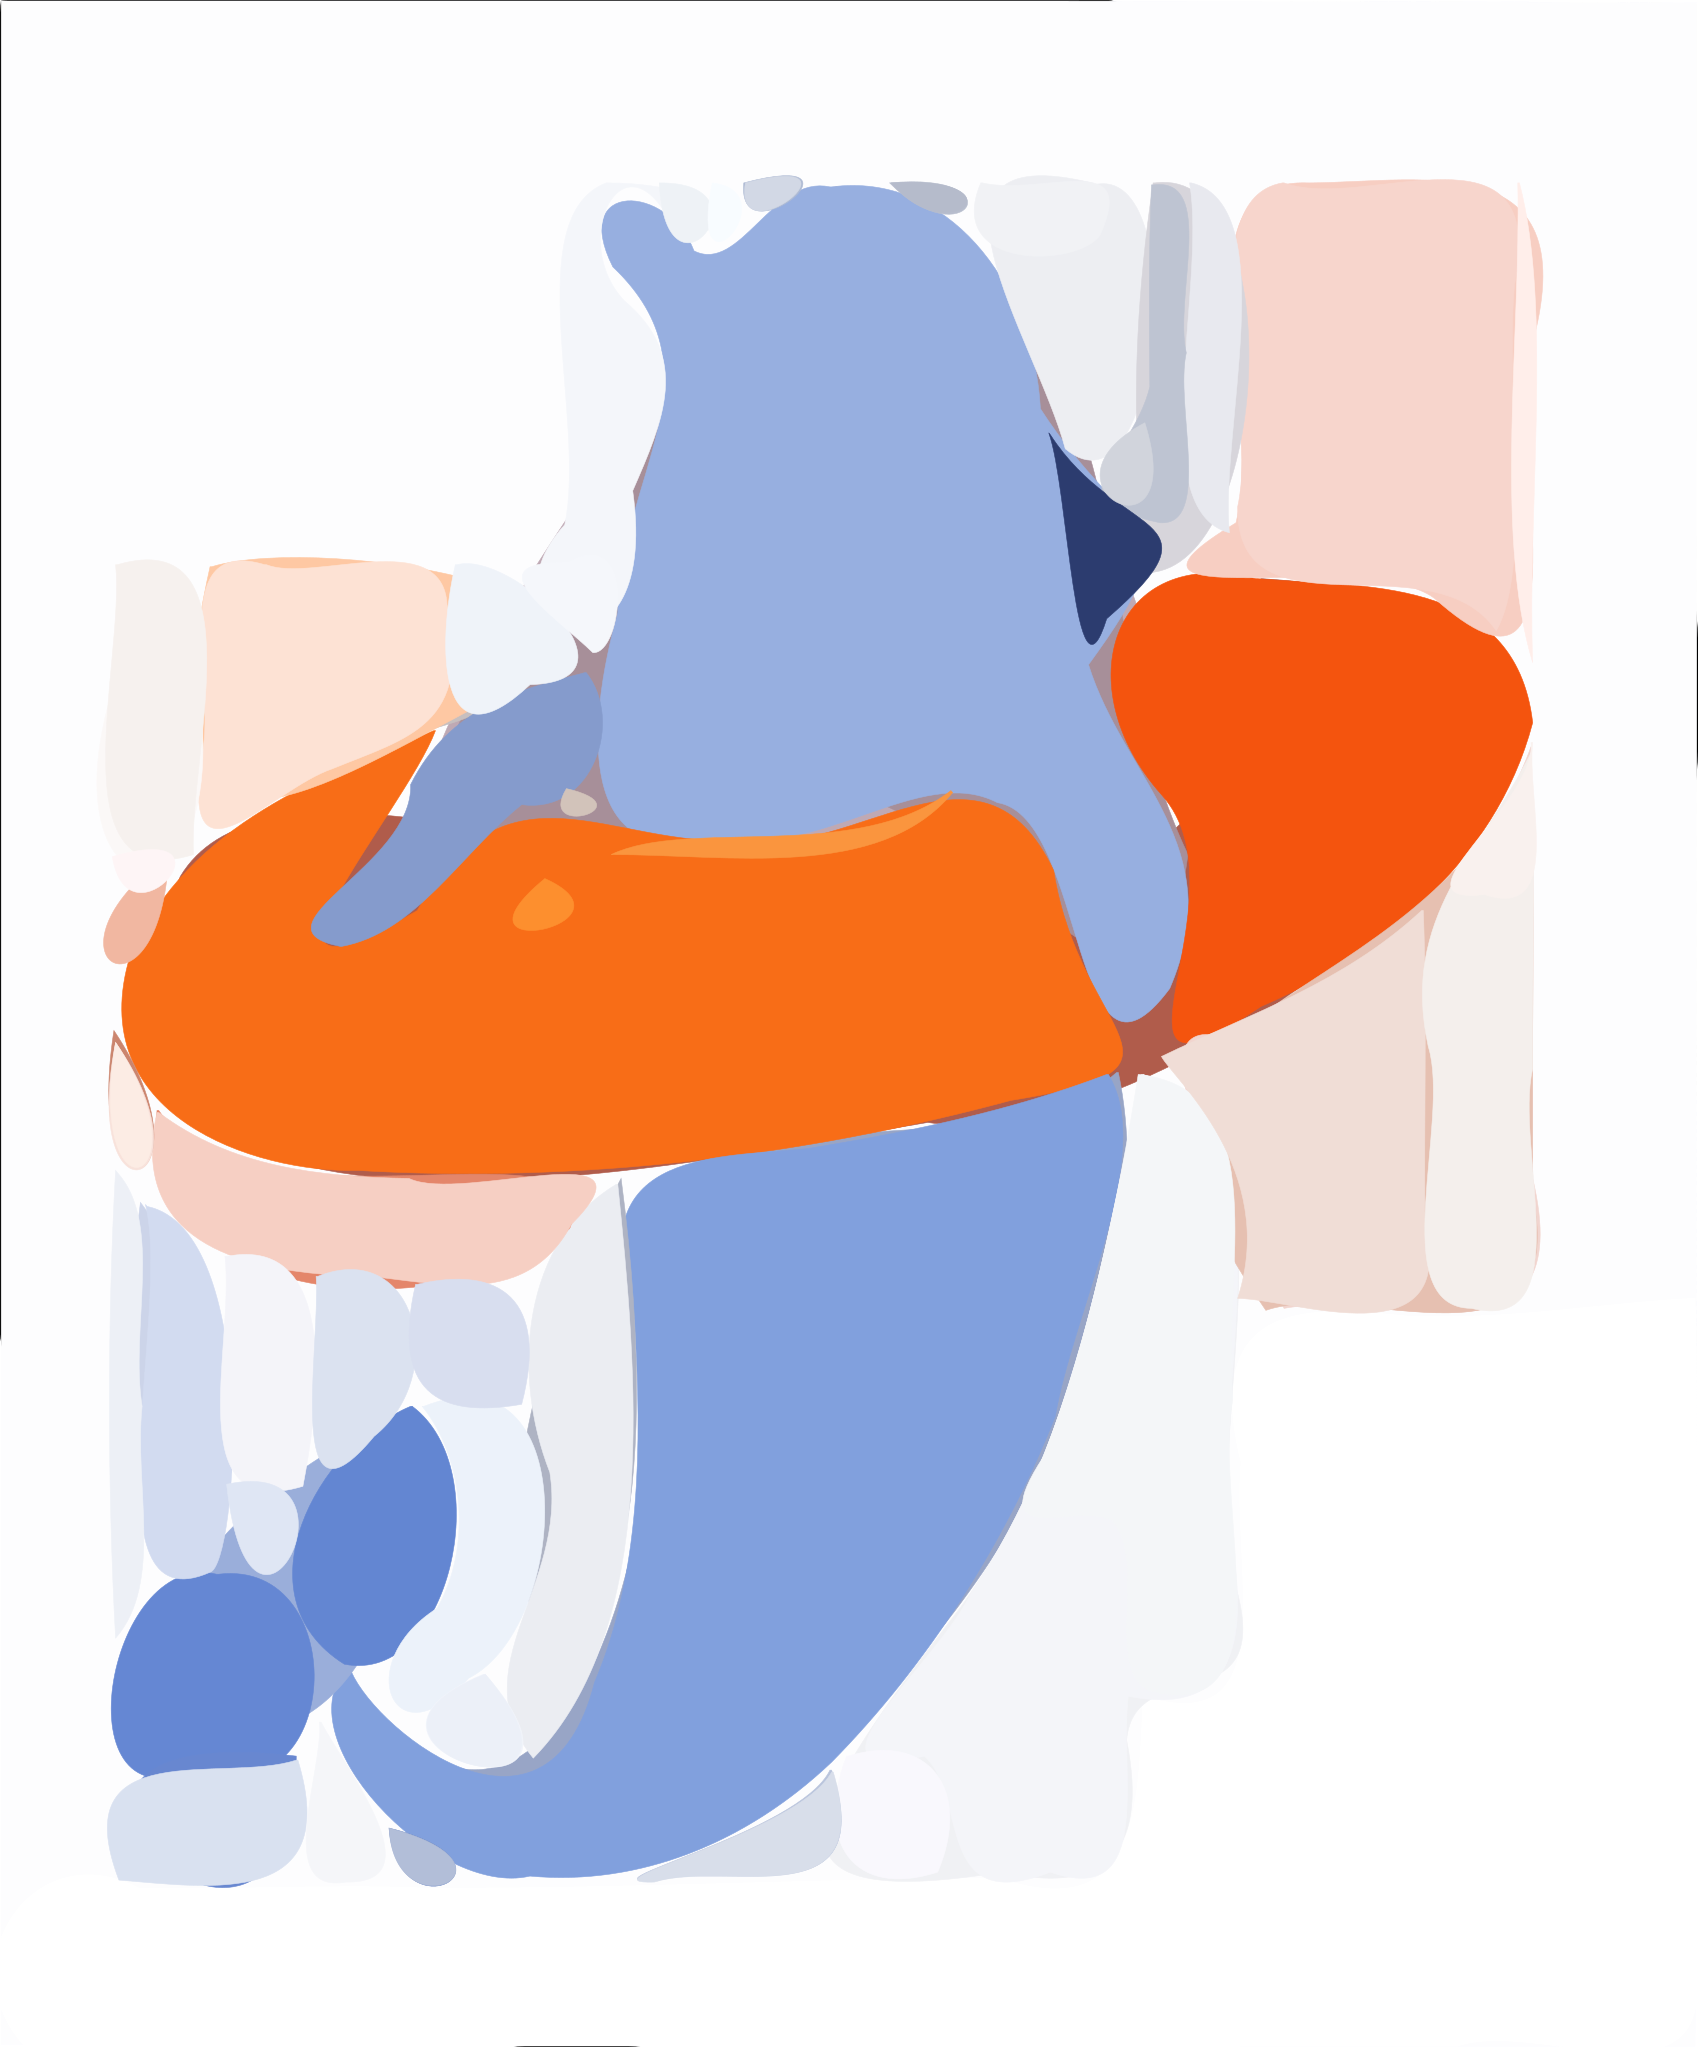

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 47.669521036313284
Topic5\house.png 
use_bezier_curve_num : 200 
component_num : 57


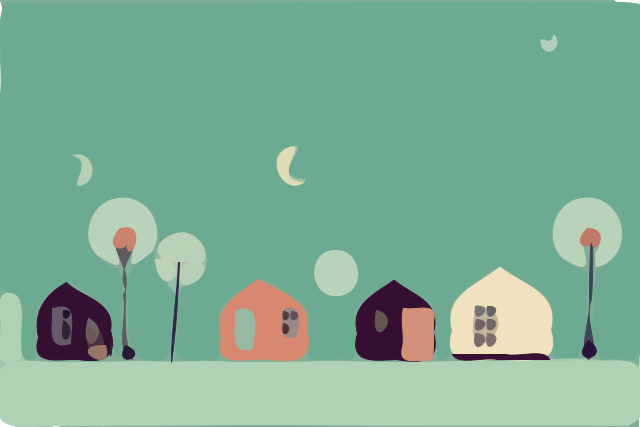

Topic5\house.png vs SVG2PNG_Topic5\house.png: 8.93037543911007
Topic5\meditation.png 
use_bezier_curve_num : 200 
component_num : 60


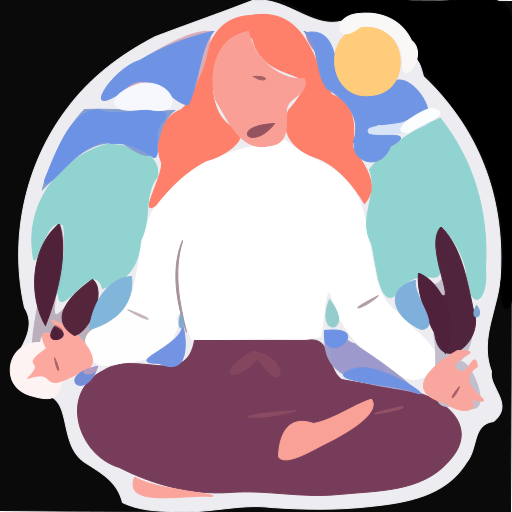

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 35.74971389770508
Topic5\tree.png 
use_bezier_curve_num : 200 
component_num : 200


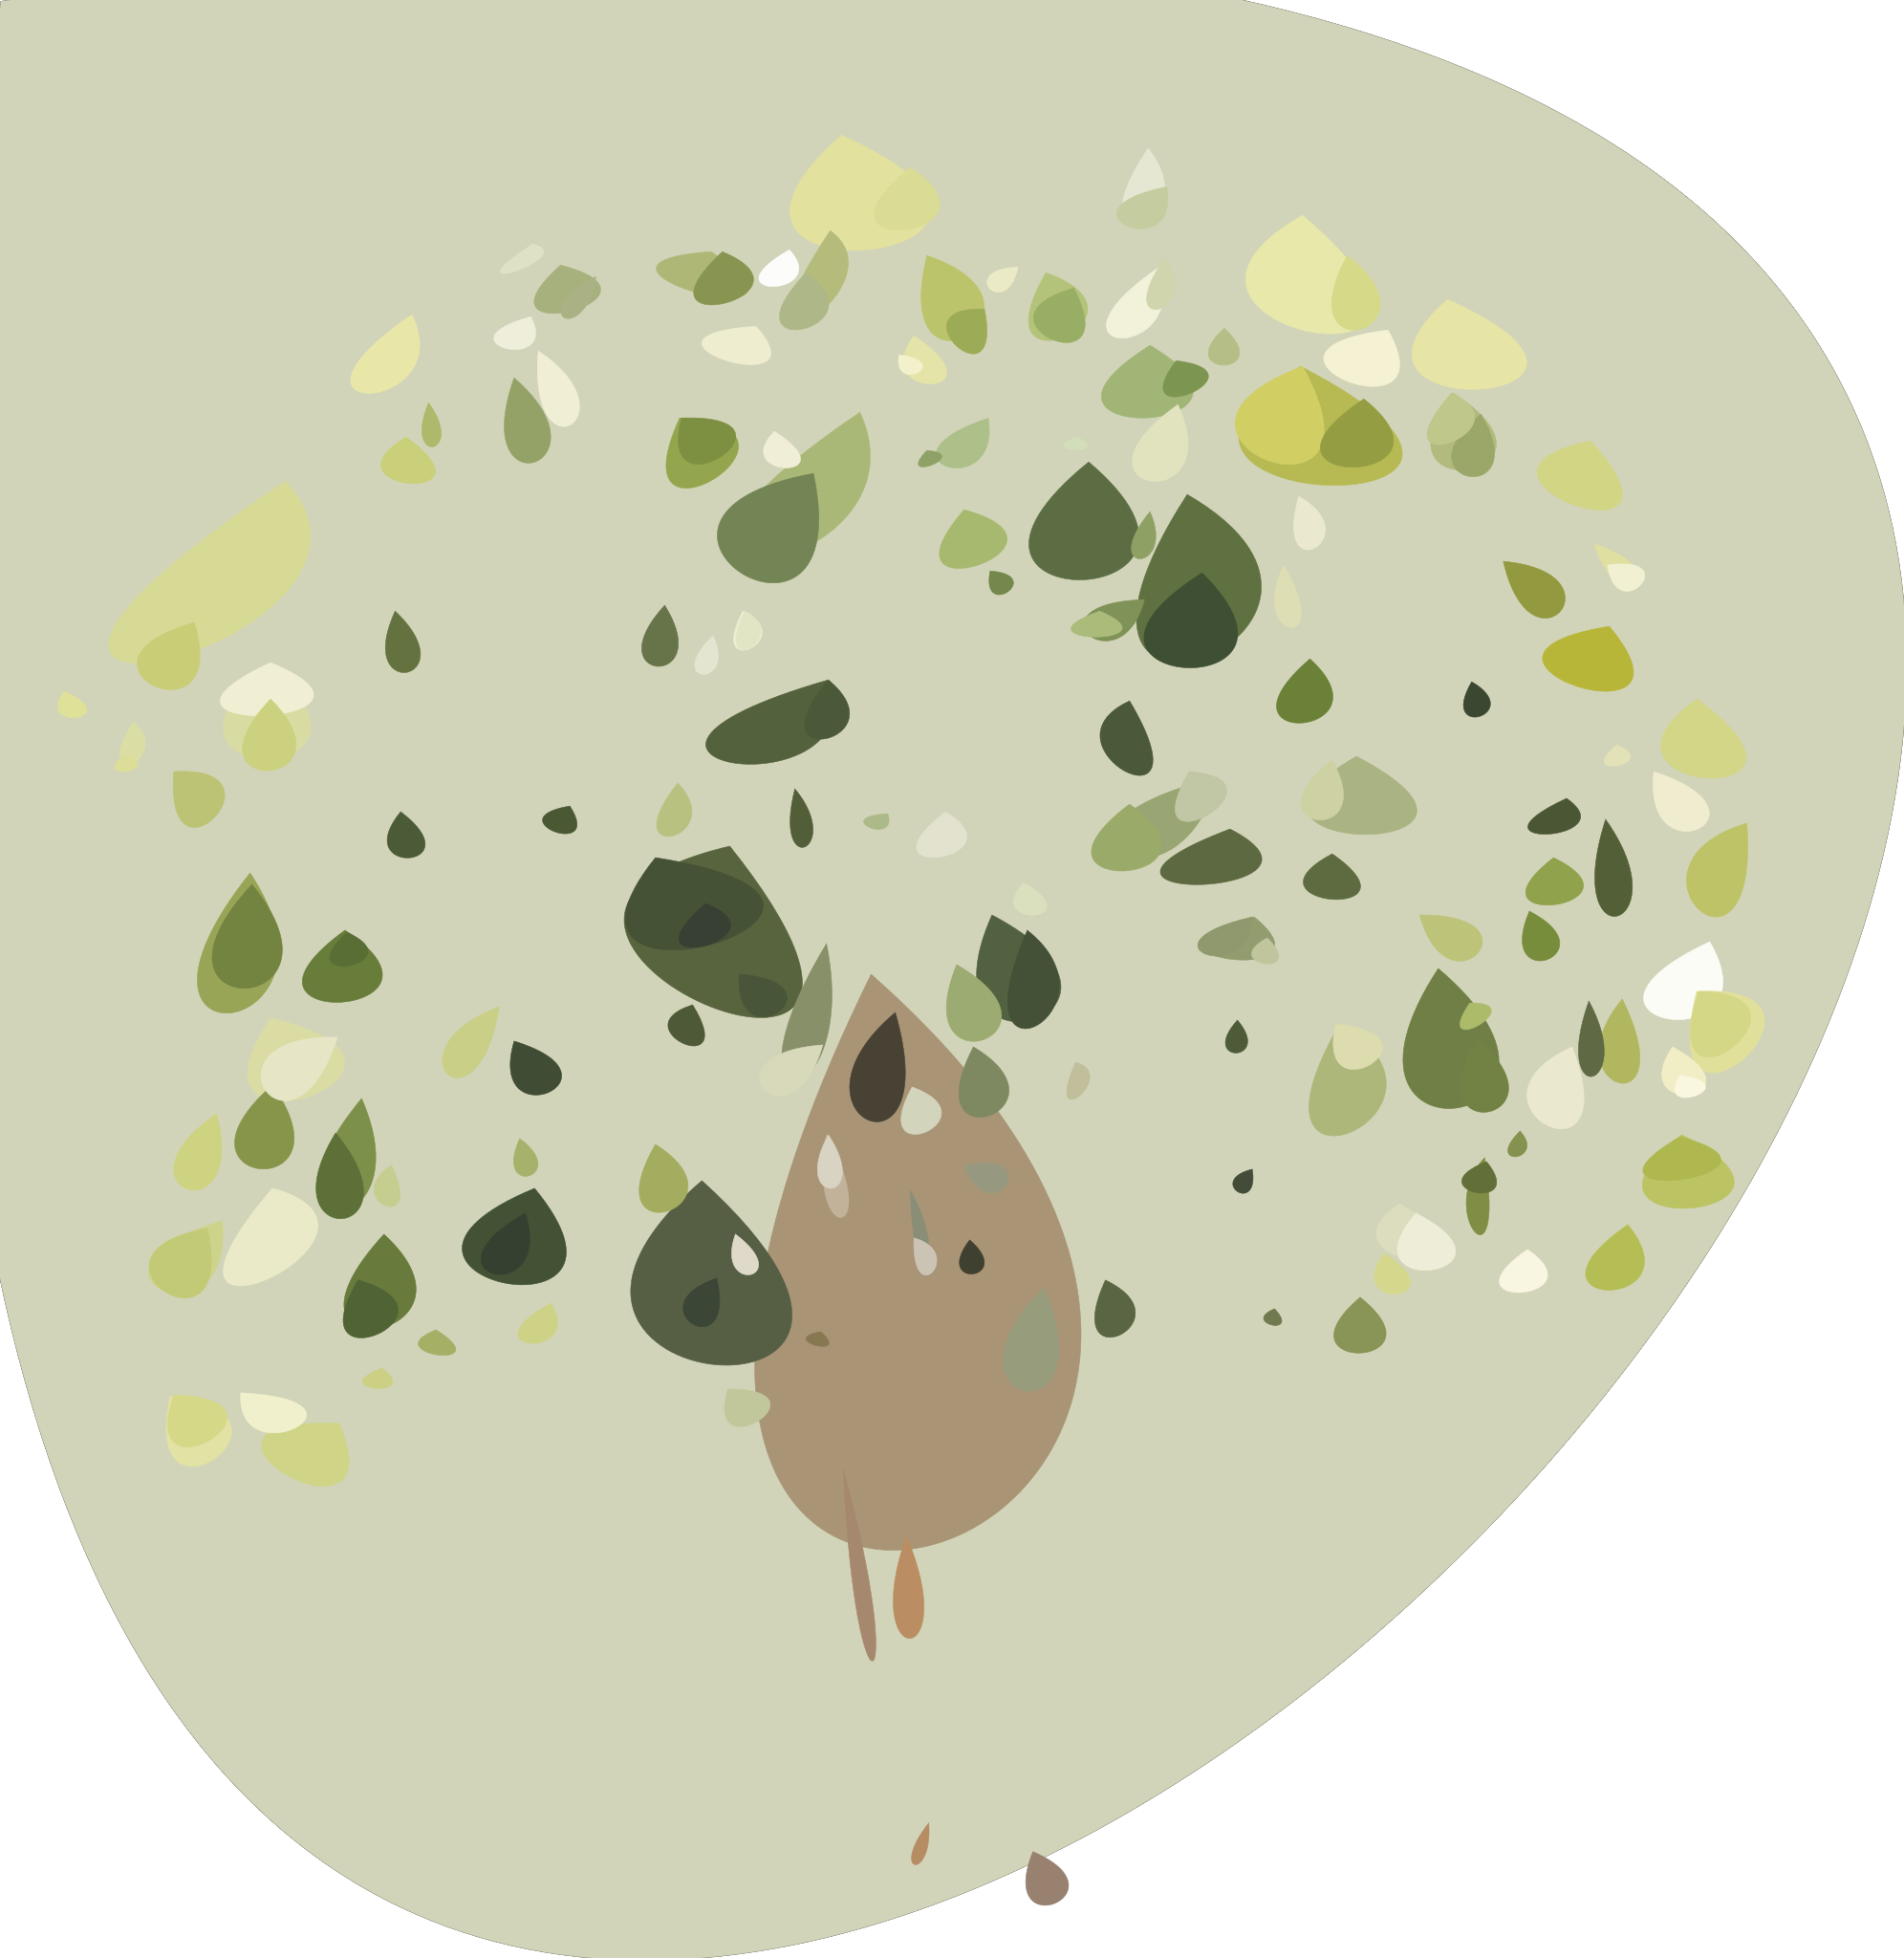

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 80.12982530303712
Topic5\work-from-home.png 
use_bezier_curve_num : 200 
component_num : 42


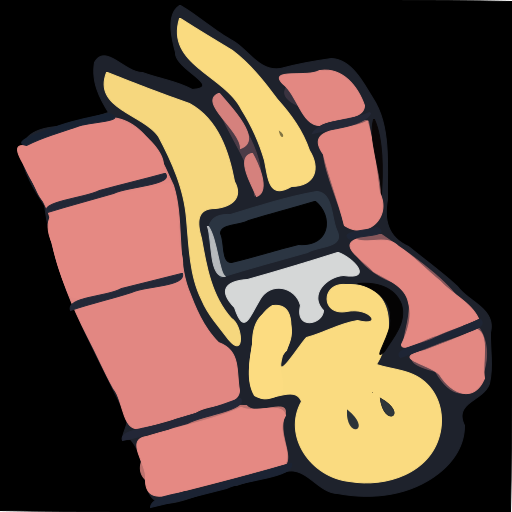

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 17.559187571207683
Topic5 Total MSE: 404.0432681926657
Topic5\fallingwater.jpg 
use_bezier_curve_num : 400 
component_num : 139


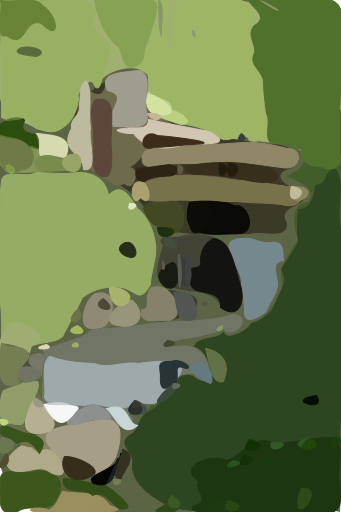

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.7949237842131
Topic5\flower.jpg 
use_bezier_curve_num : 400 
component_num : 177


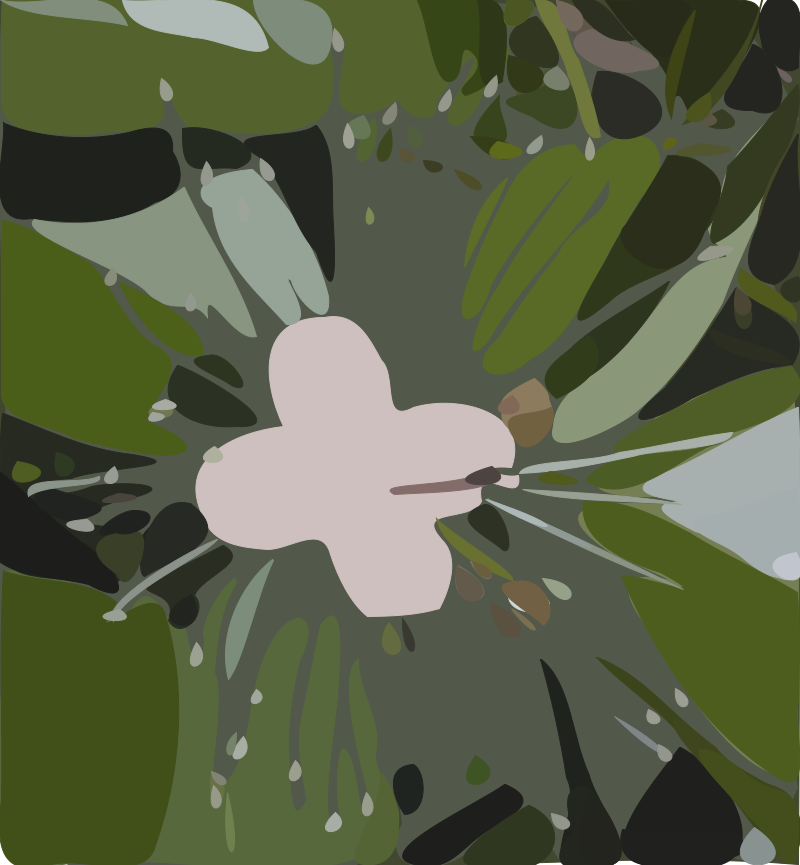

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 80.69674132947976
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 400 
component_num : 98


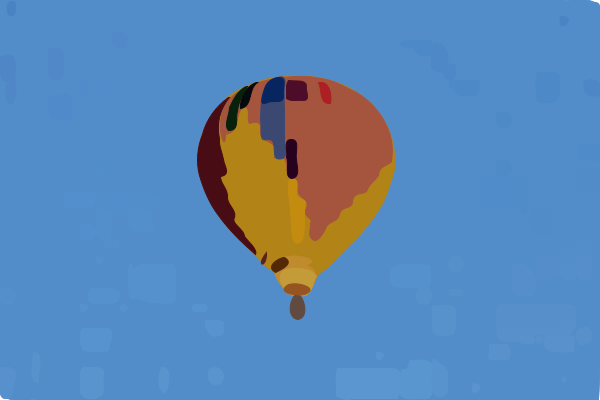

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.0962625
Topic5\autumn_01.png 
use_bezier_curve_num : 400 
component_num : 22


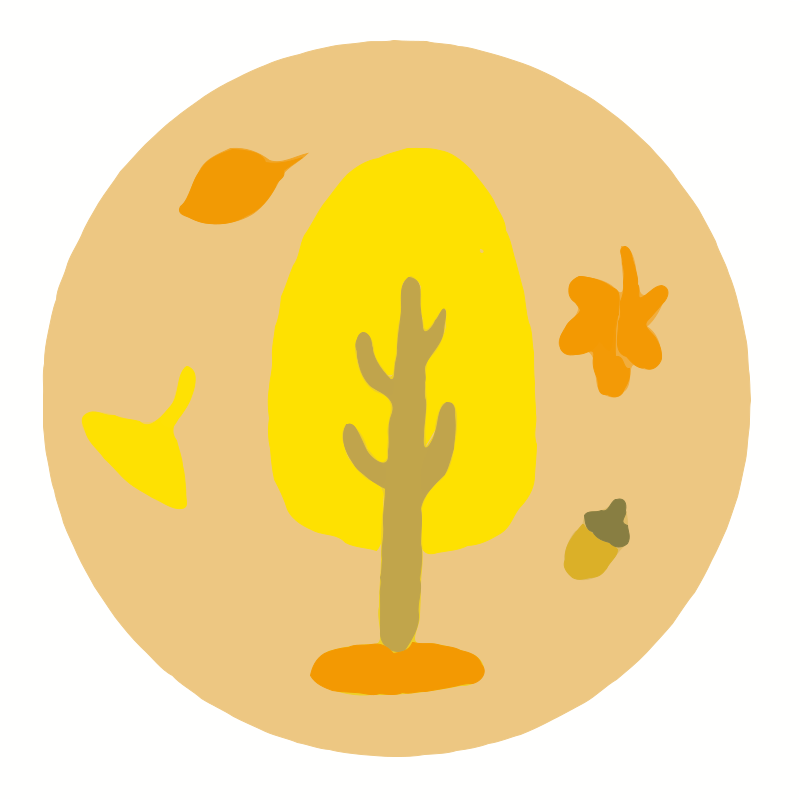

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 2.031888020833333
Topic5\dolphin.png 
use_bezier_curve_num : 400 
component_num : 78


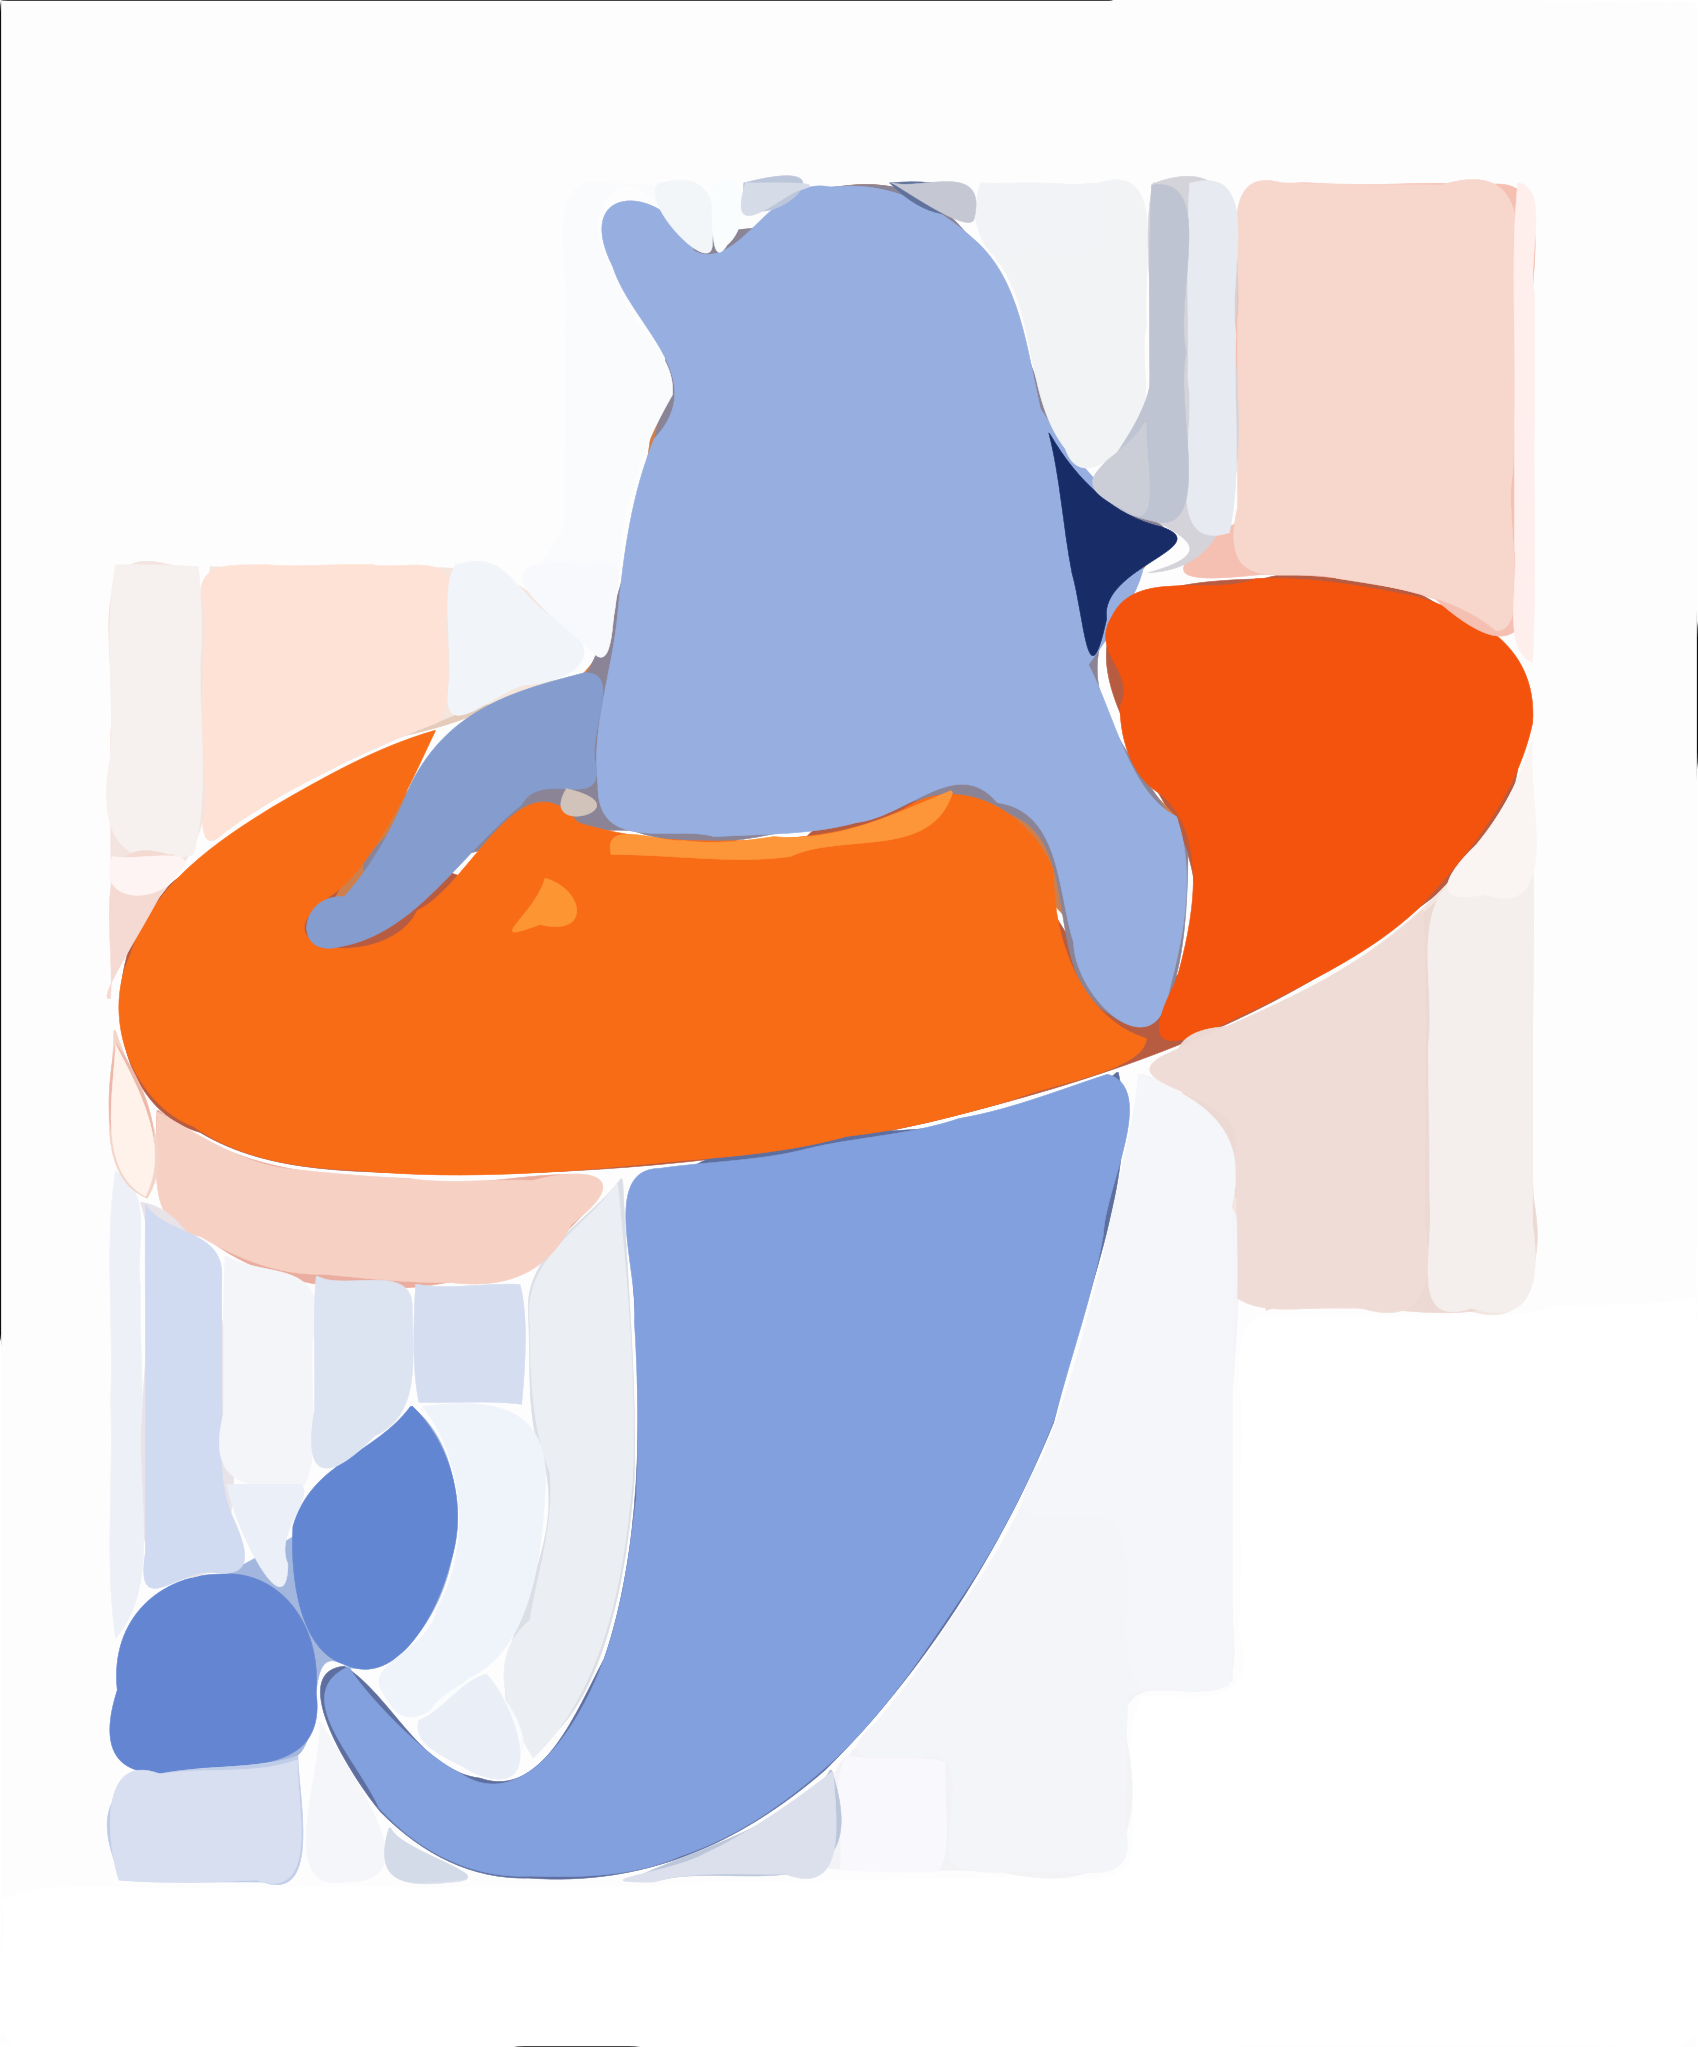

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 45.87510671969257
Topic5\house.png 
use_bezier_curve_num : 400 
component_num : 57


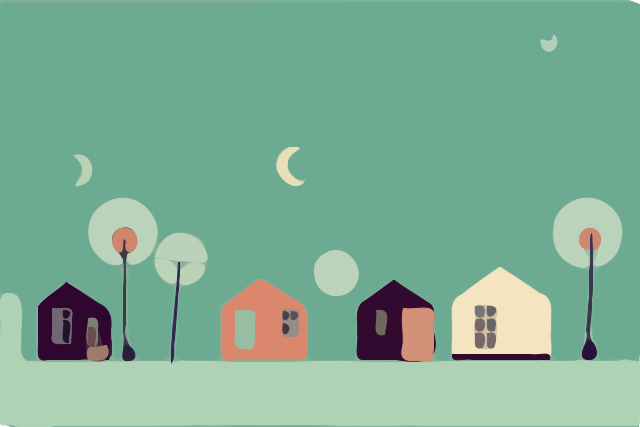

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.358859045667447
Topic5\meditation.png 
use_bezier_curve_num : 400 
component_num : 60


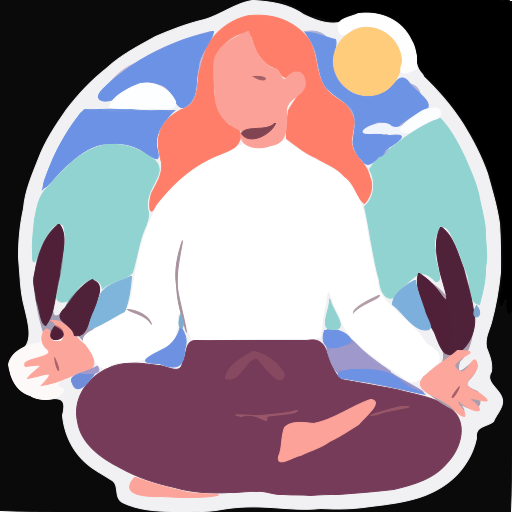

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 34.53596750895182
Topic5\tree.png 
use_bezier_curve_num : 400 
component_num : 200


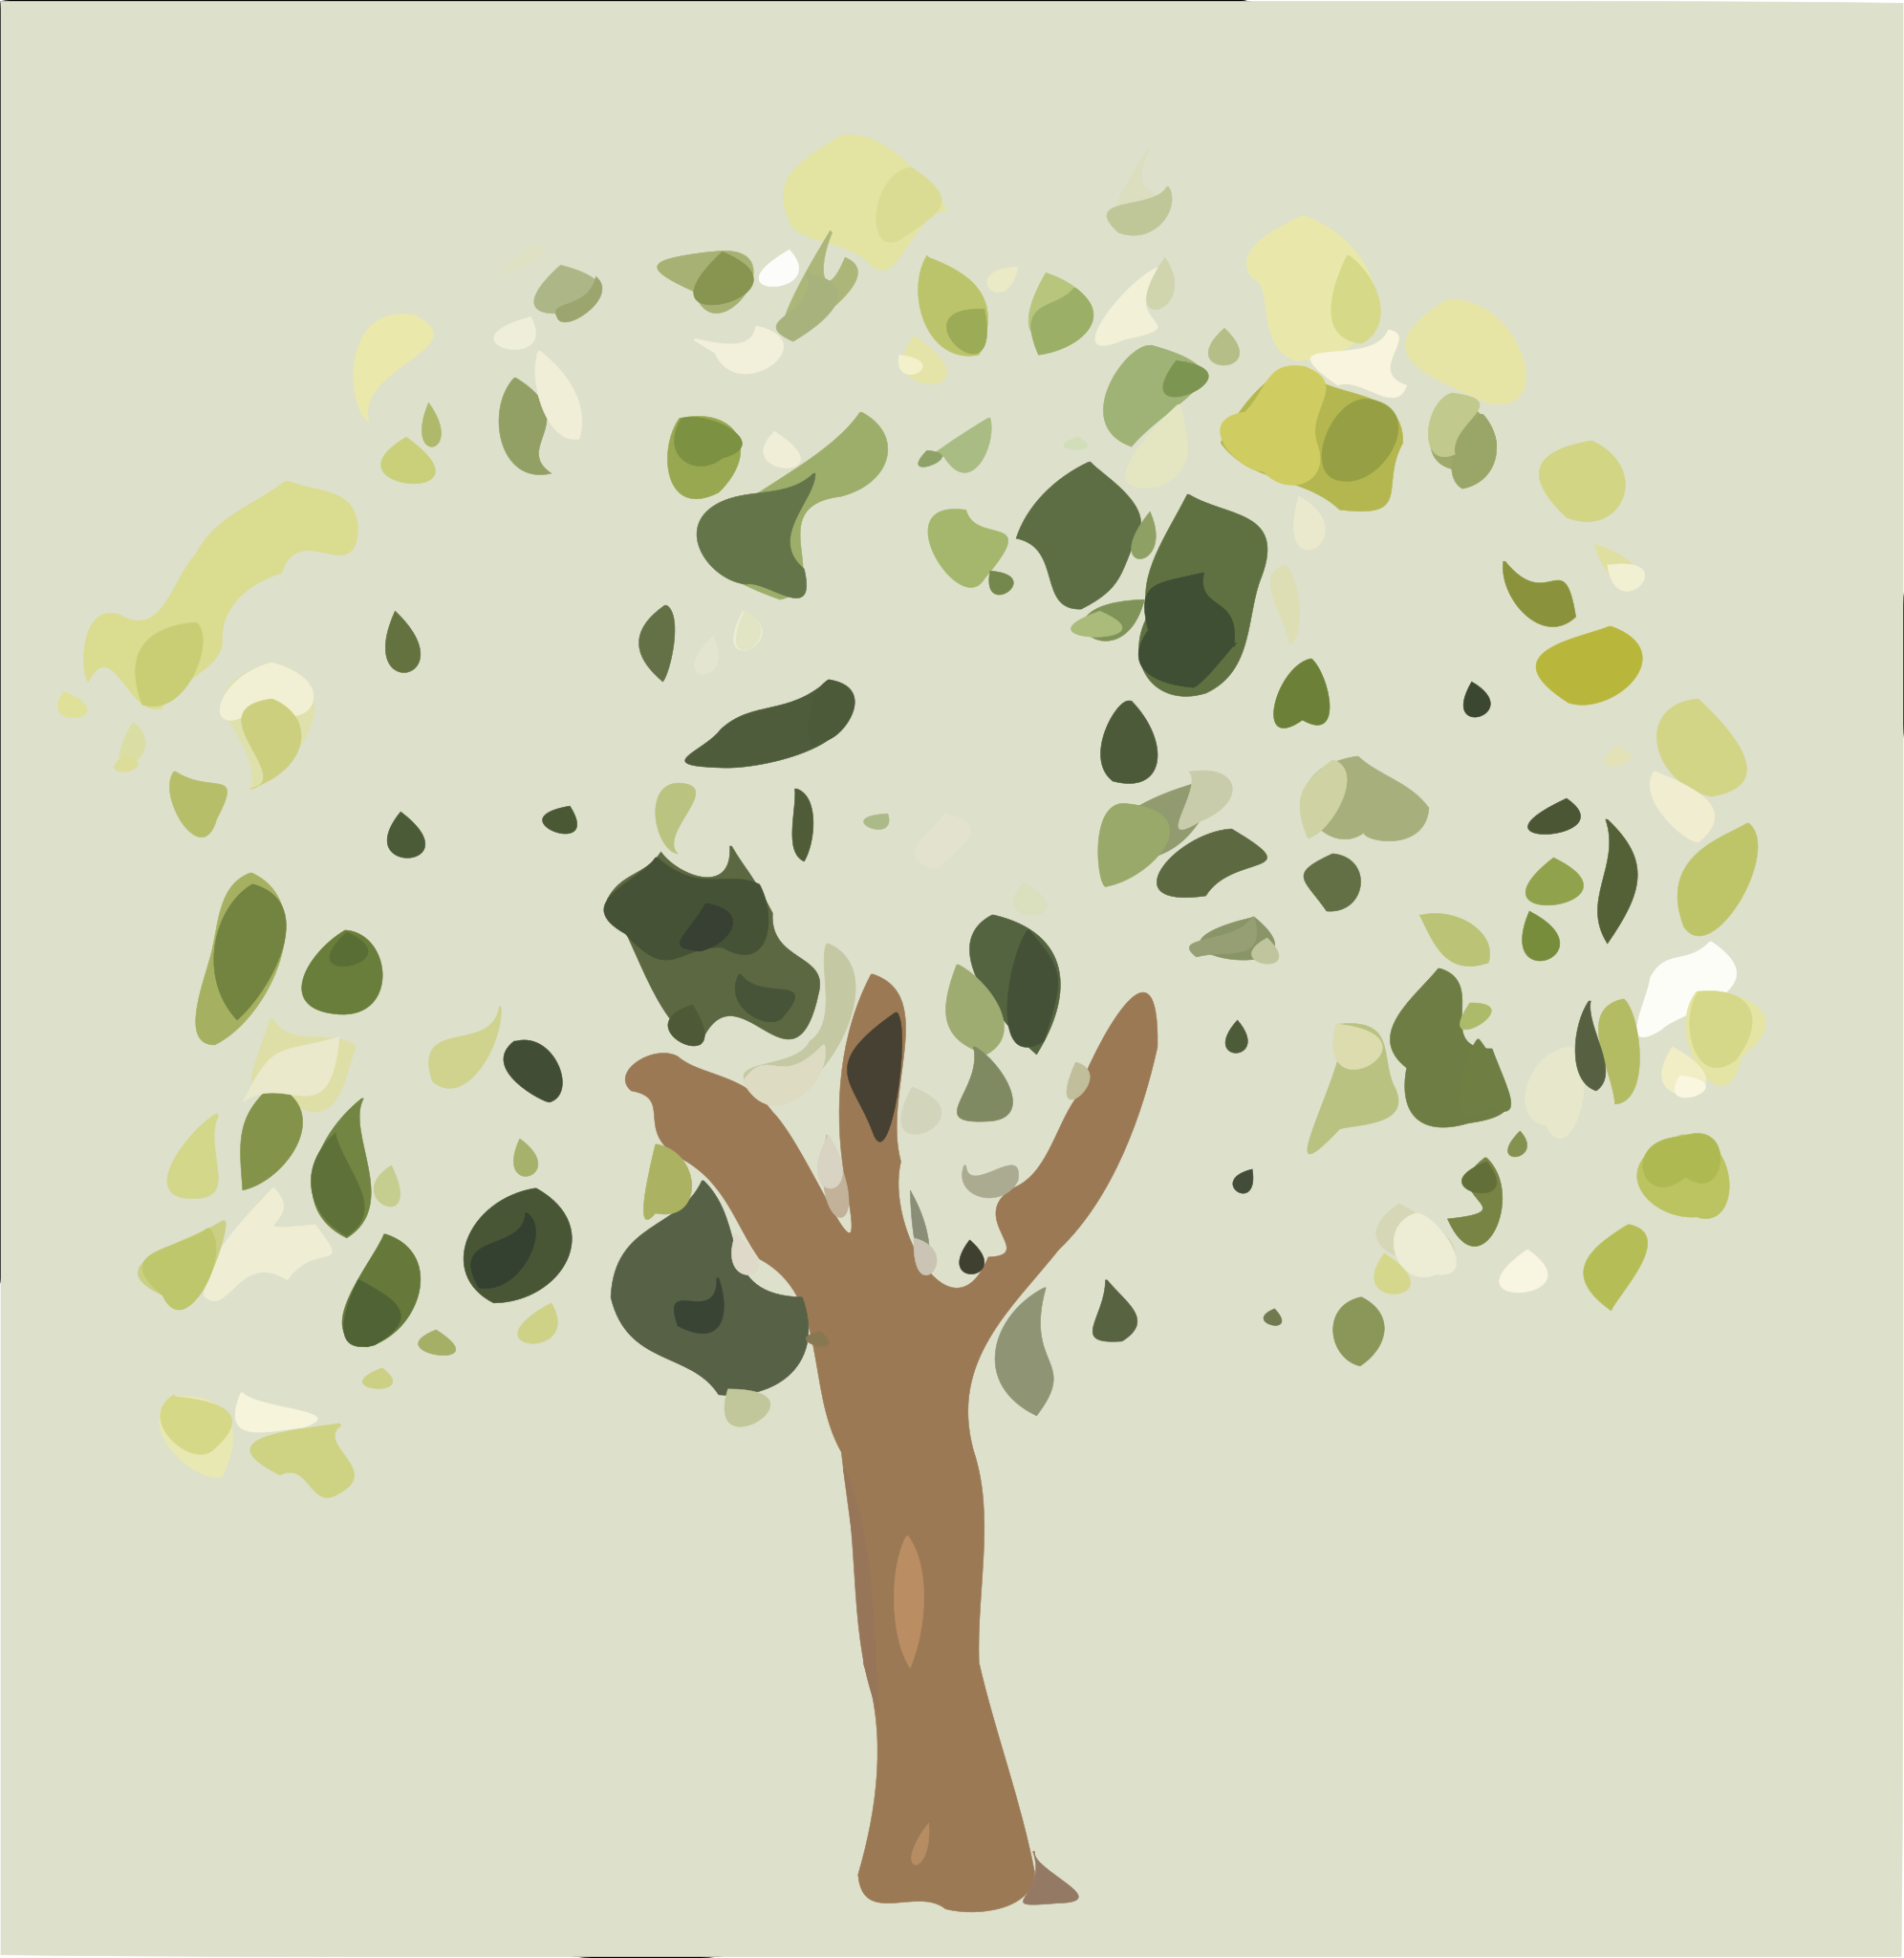

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 123.26207033901794
Topic5\work-from-home.png 
use_bezier_curve_num : 400 
component_num : 42


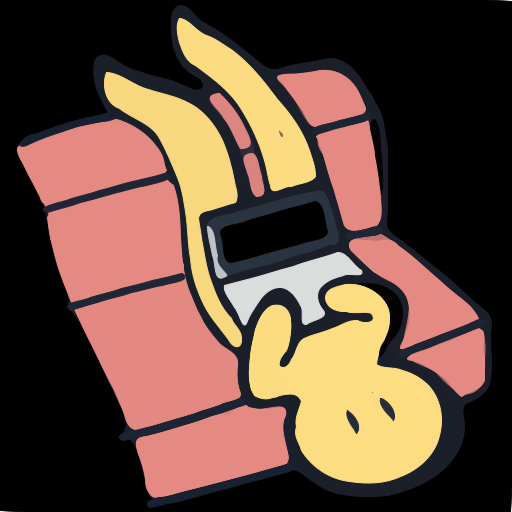

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 16.080942789713543
Topic5 Total MSE: 433.73276203756956
Topic5\fallingwater.jpg 
use_bezier_curve_num : 600 
component_num : 139


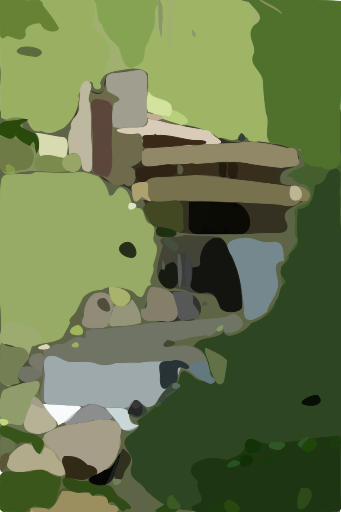

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.29920042155425
Topic5\flower.jpg 
use_bezier_curve_num : 600 
component_num : 177


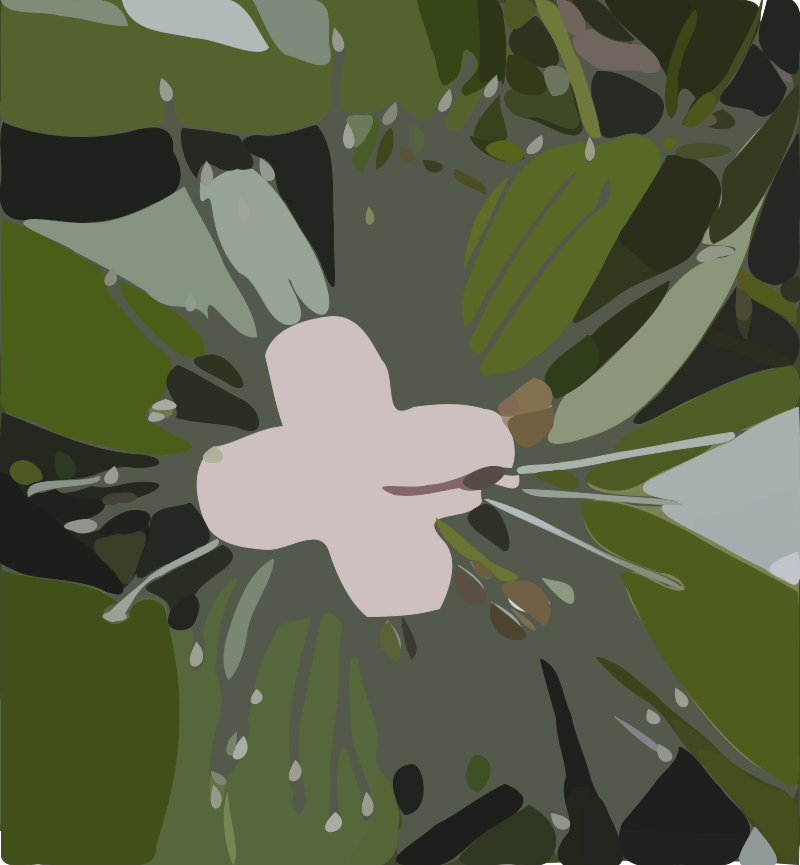

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 80.09123458574182
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 600 
component_num : 98


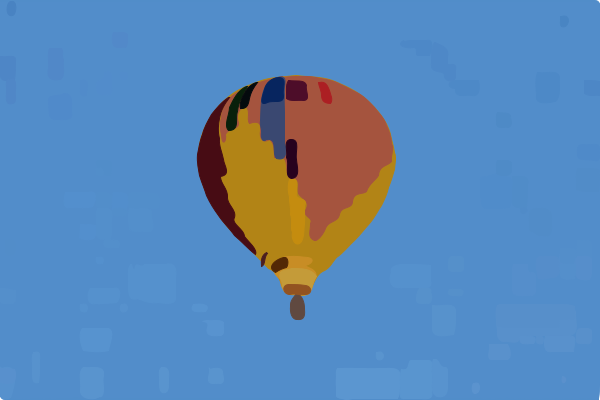

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.073119444444444
Topic5\autumn_01.png 
use_bezier_curve_num : 600 
component_num : 22


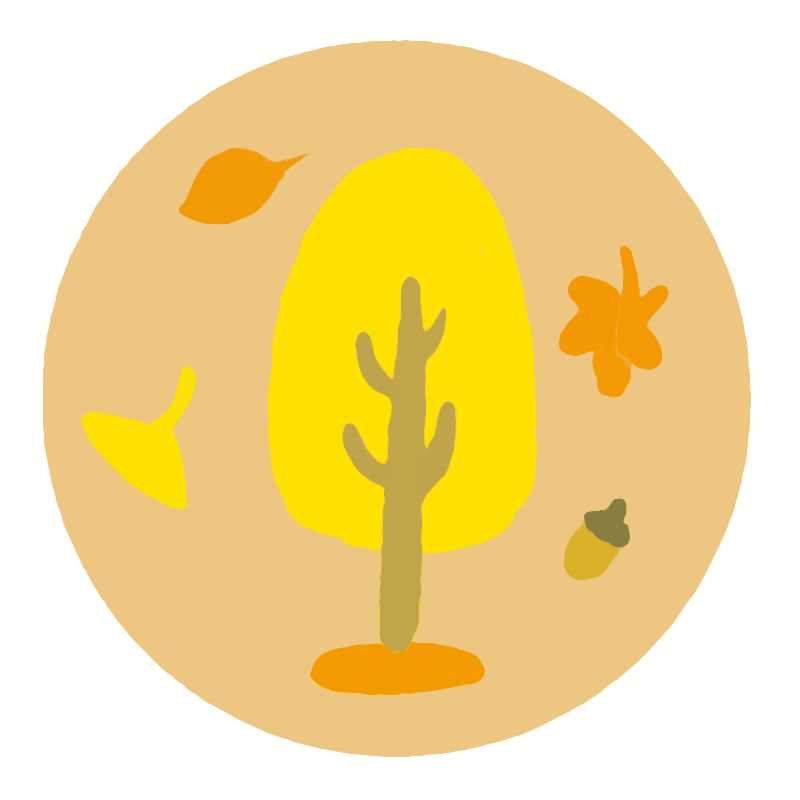

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.9596270833333334
Topic5\dolphin.png 
use_bezier_curve_num : 600 
component_num : 78


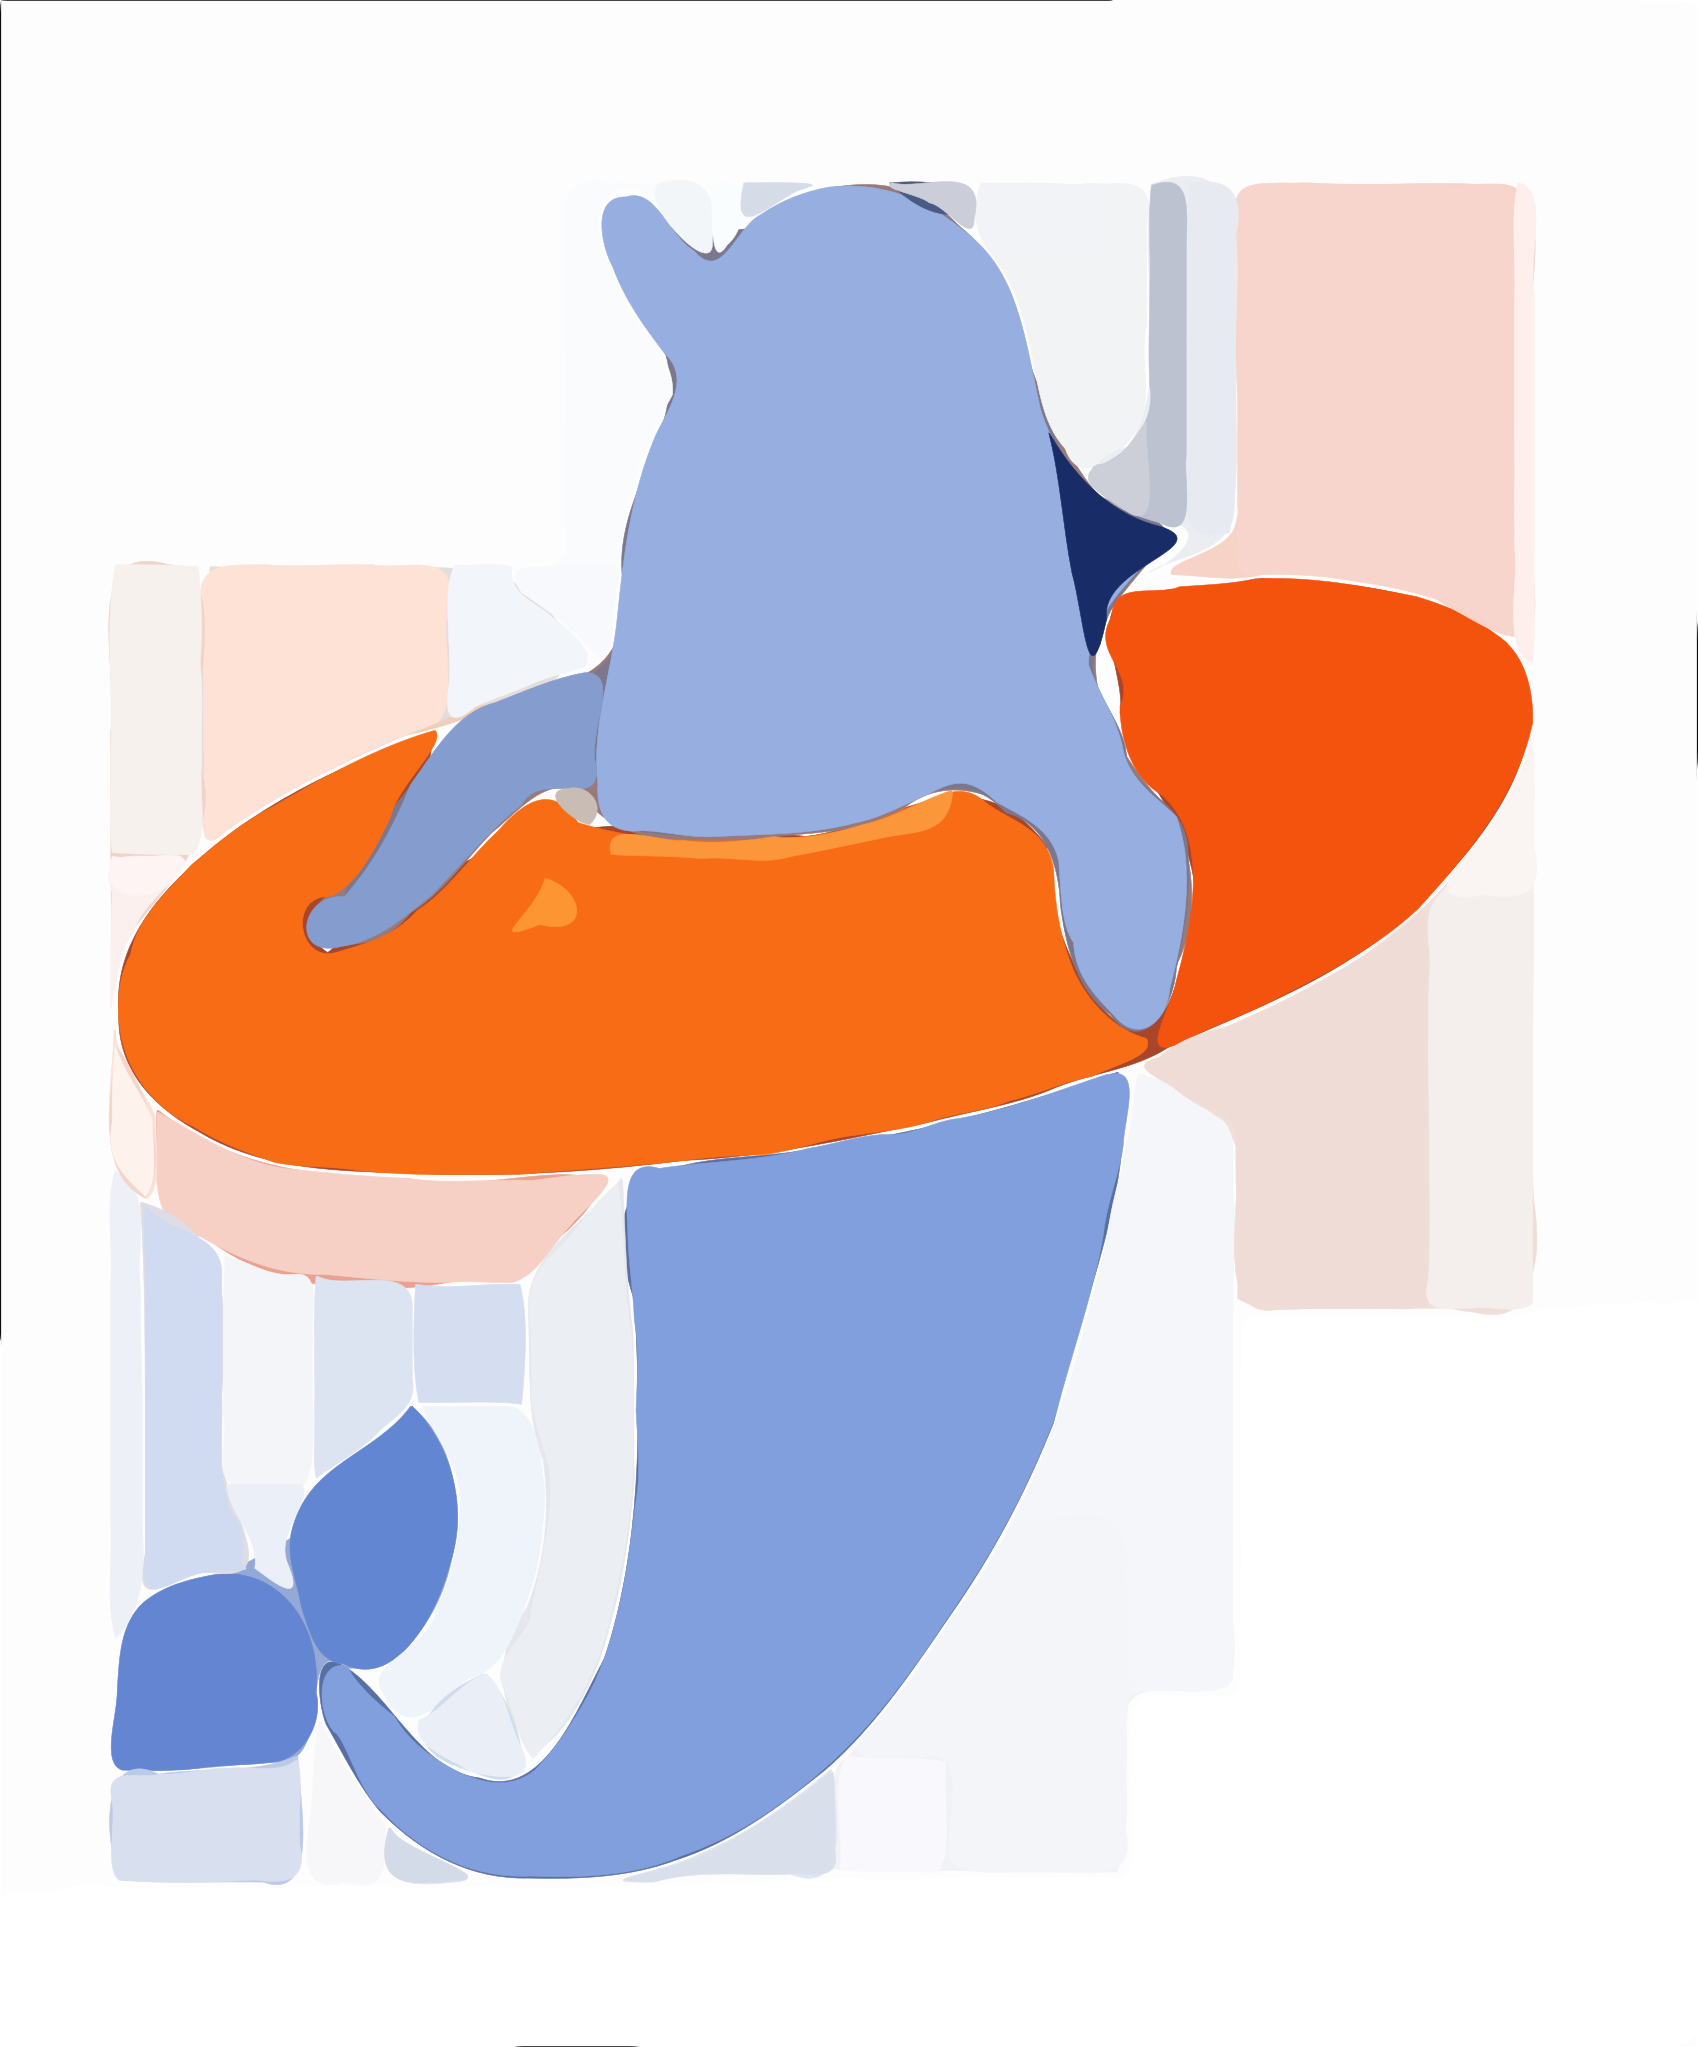

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.091586138499245
Topic5\house.png 
use_bezier_curve_num : 600 
component_num : 57


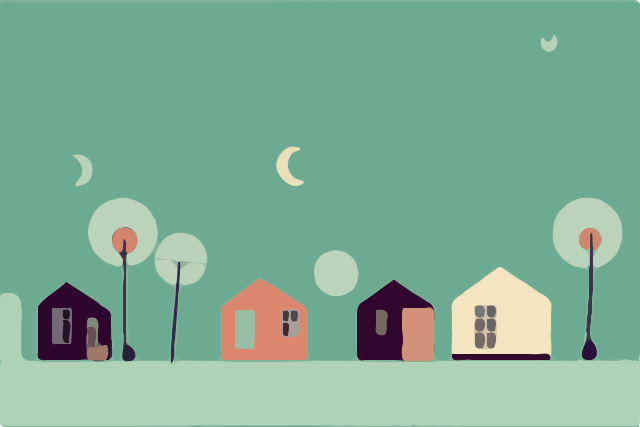

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.324602361436378
Topic5\meditation.png 
use_bezier_curve_num : 600 
component_num : 60


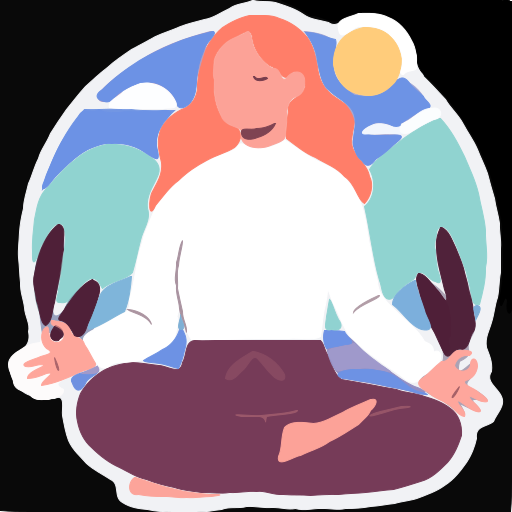

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 29.825542449951172
Topic5\tree.png 
use_bezier_curve_num : 600 
component_num : 200


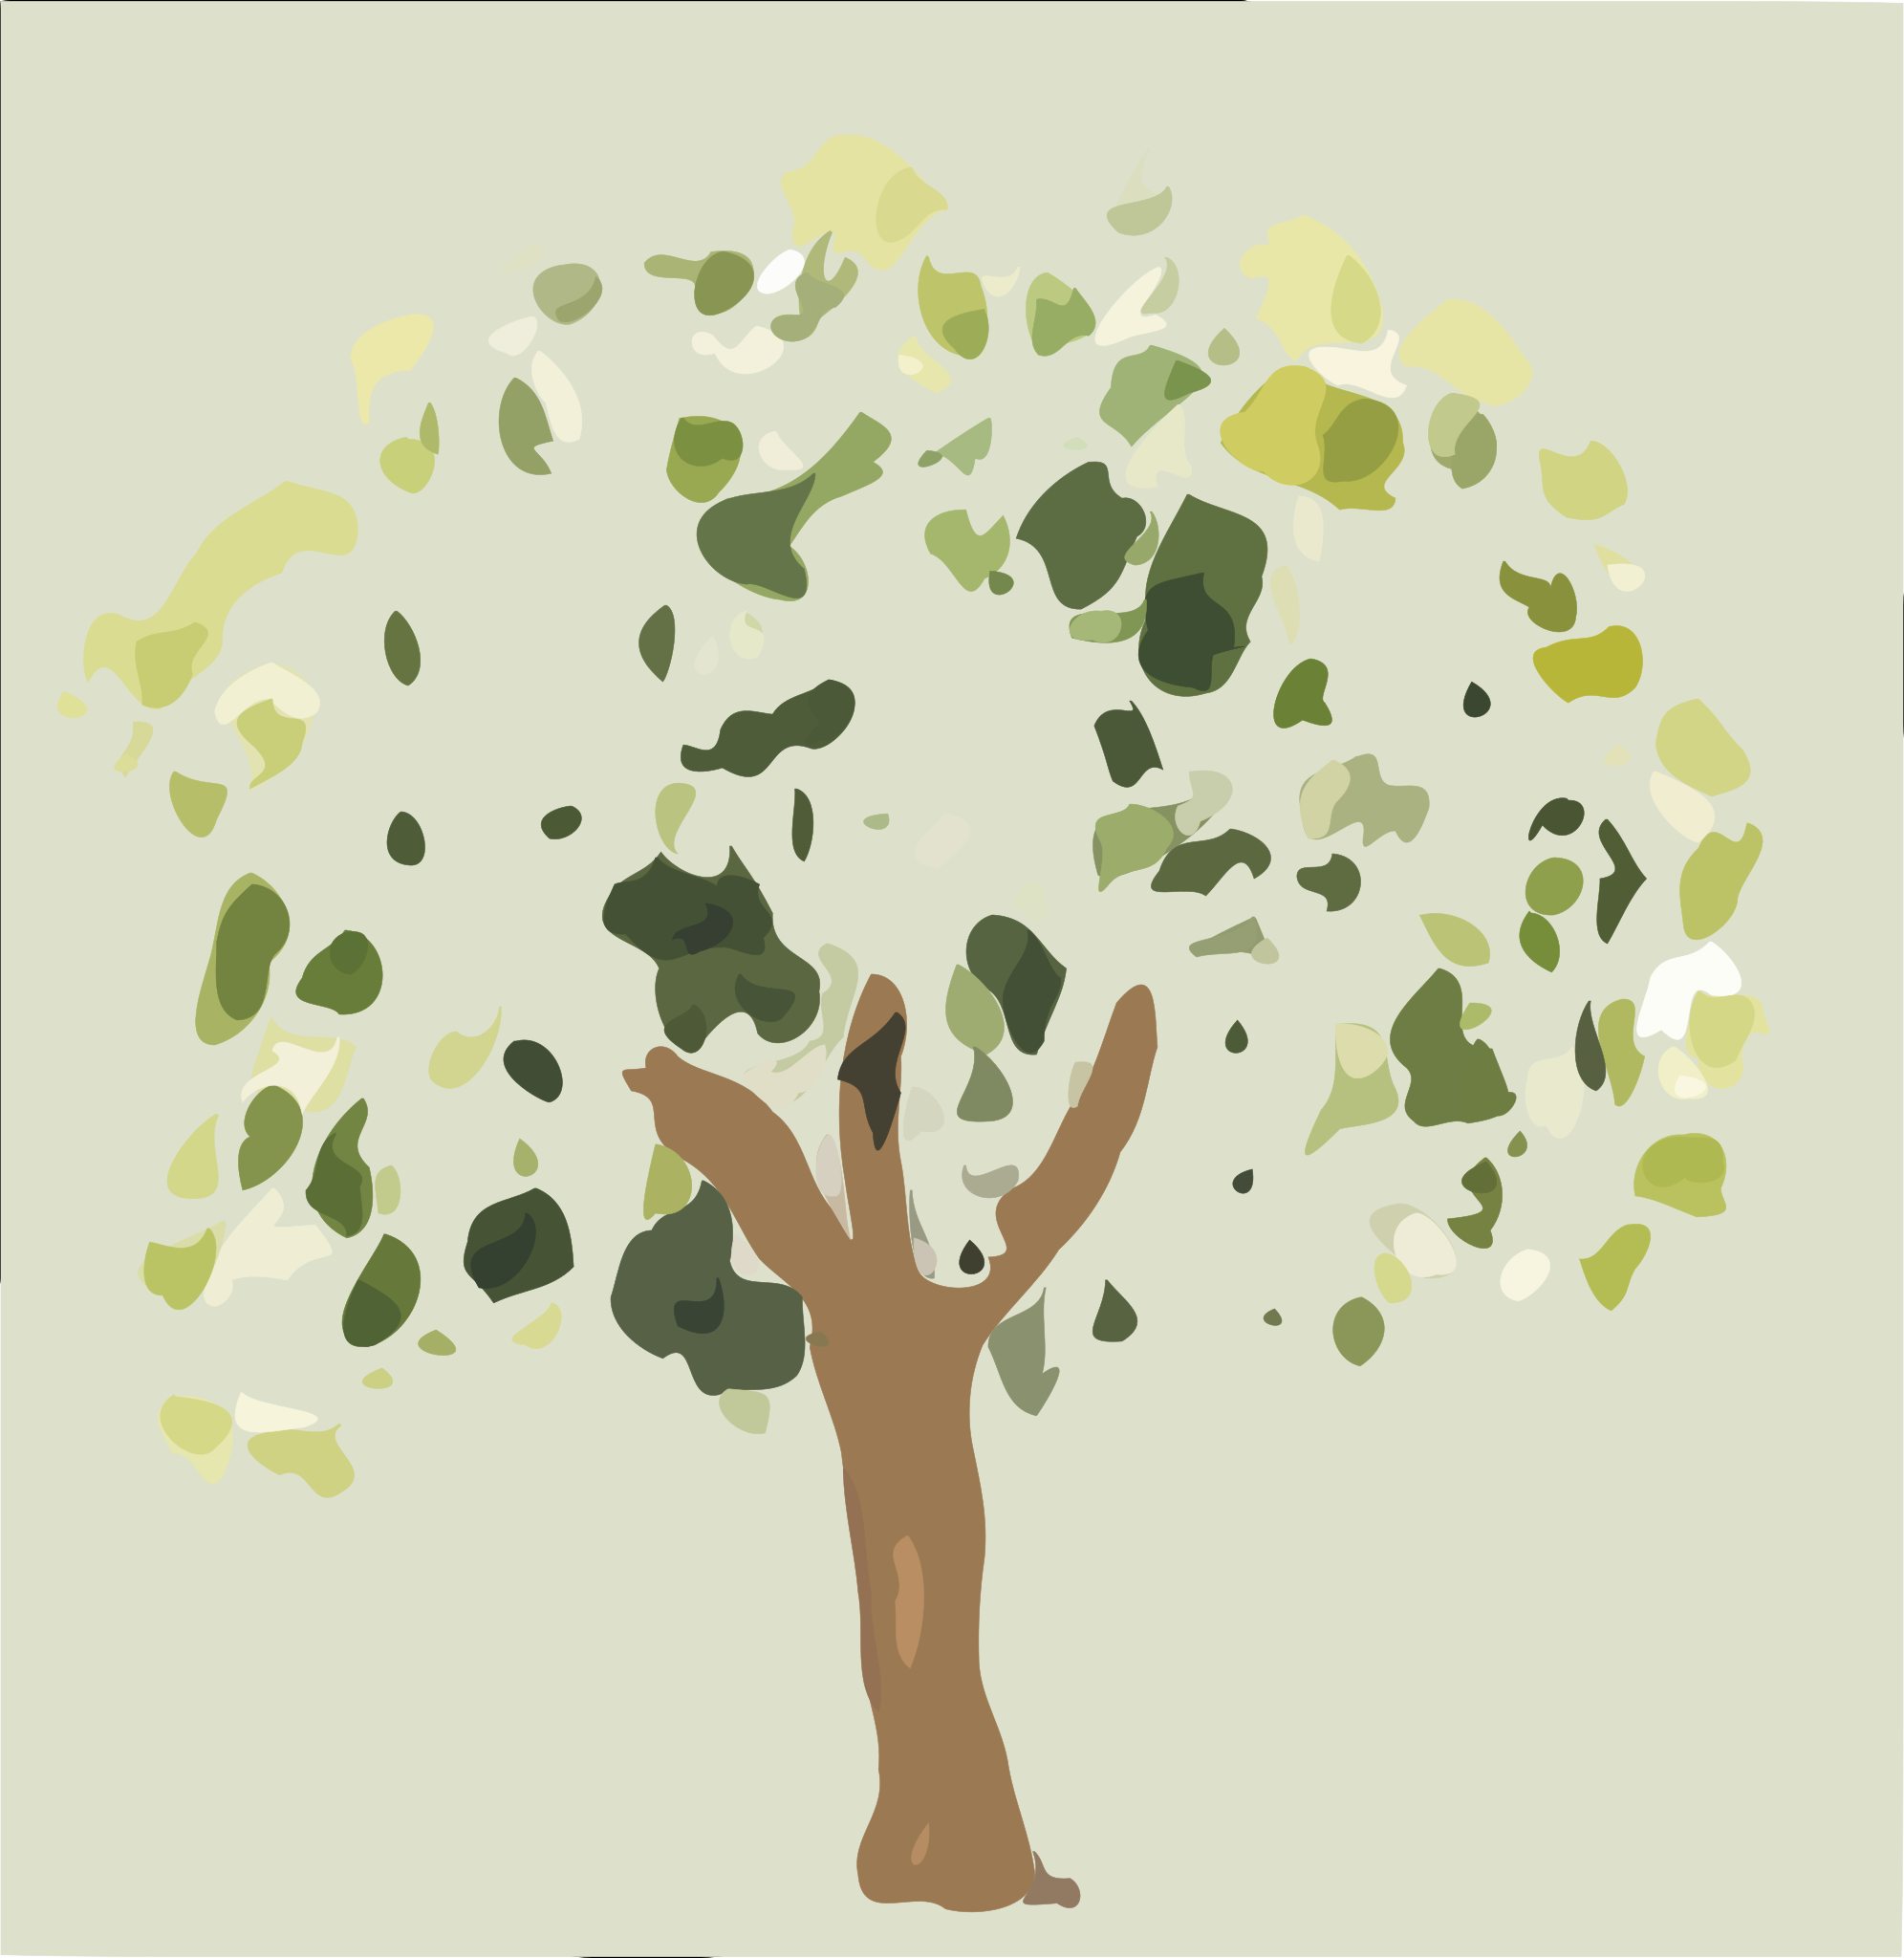

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.73969327495207
Topic5\work-from-home.png 
use_bezier_curve_num : 600 
component_num : 42


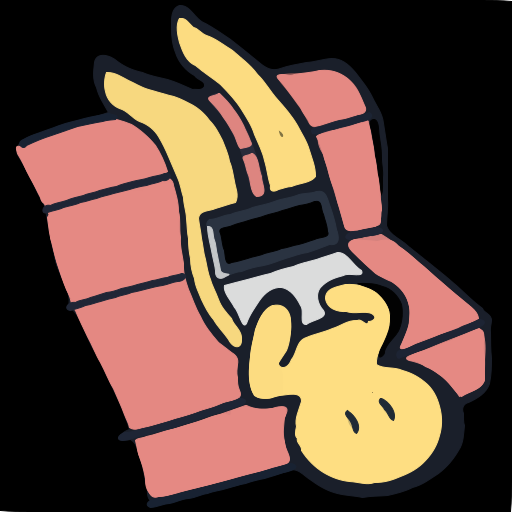

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 14.553117116292318
Topic5 Total MSE: 396.957722876205
Topic5\fallingwater.jpg 
use_bezier_curve_num : 800 
component_num : 139


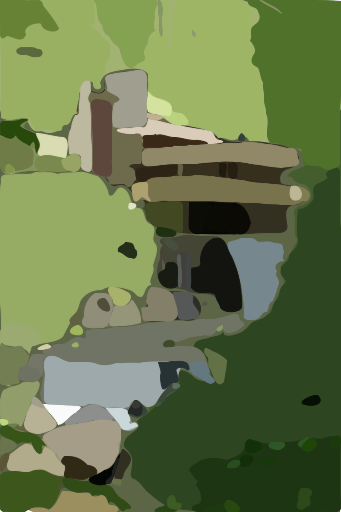

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.00234260447215
Topic5\flower.jpg 
use_bezier_curve_num : 800 
component_num : 177


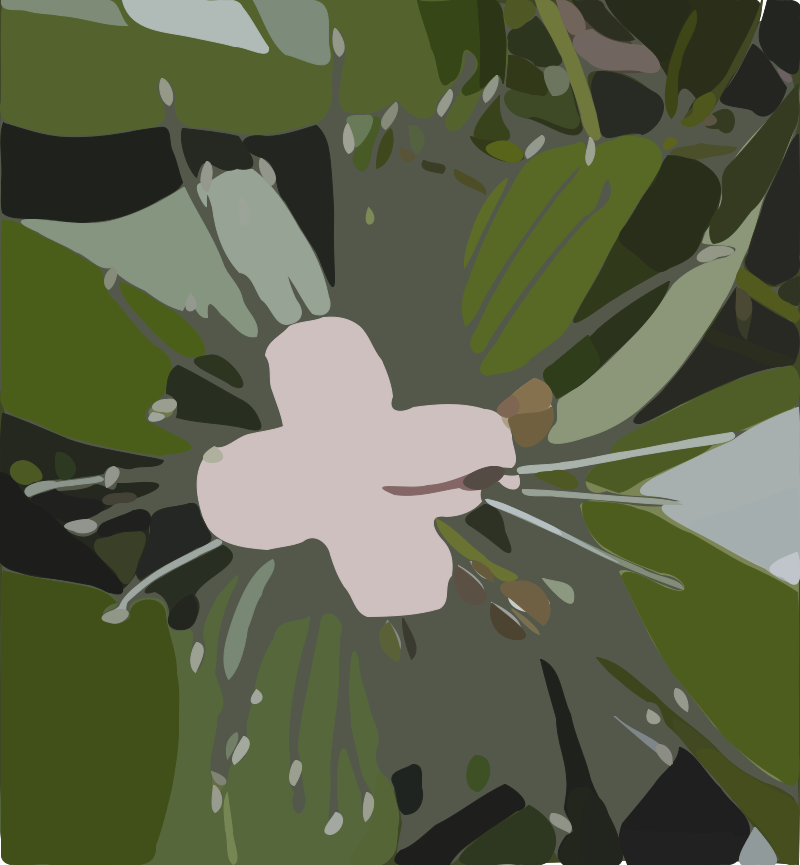

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.82173265895953
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 800 
component_num : 98


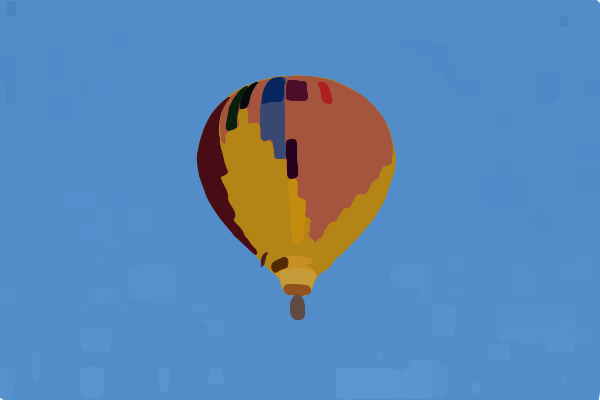

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.130605555555555
Topic5\autumn_01.png 
use_bezier_curve_num : 800 
component_num : 22


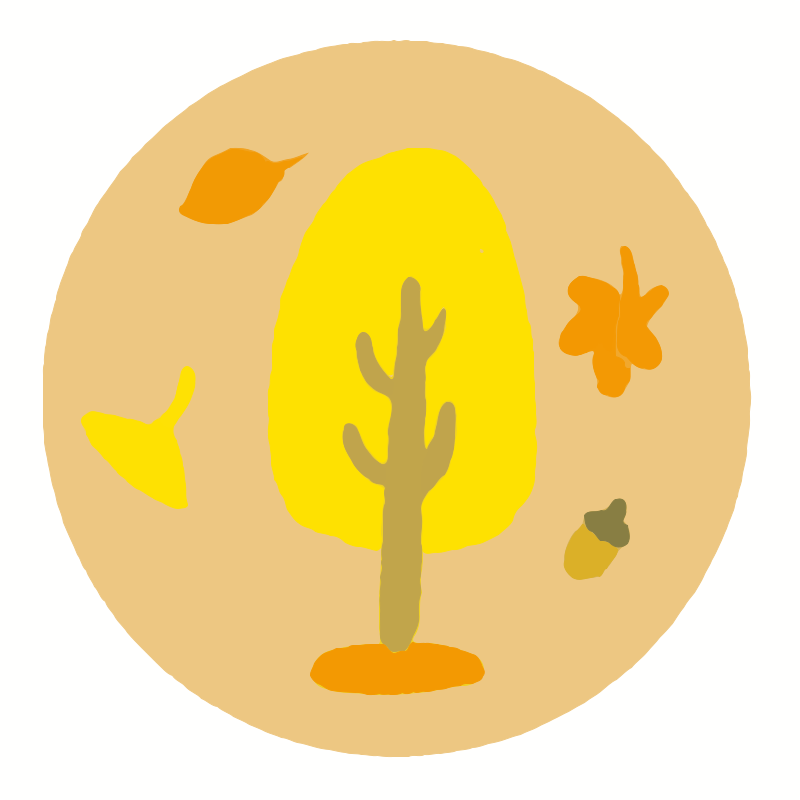

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.9110427083333332
Topic5\dolphin.png 
use_bezier_curve_num : 800 
component_num : 78


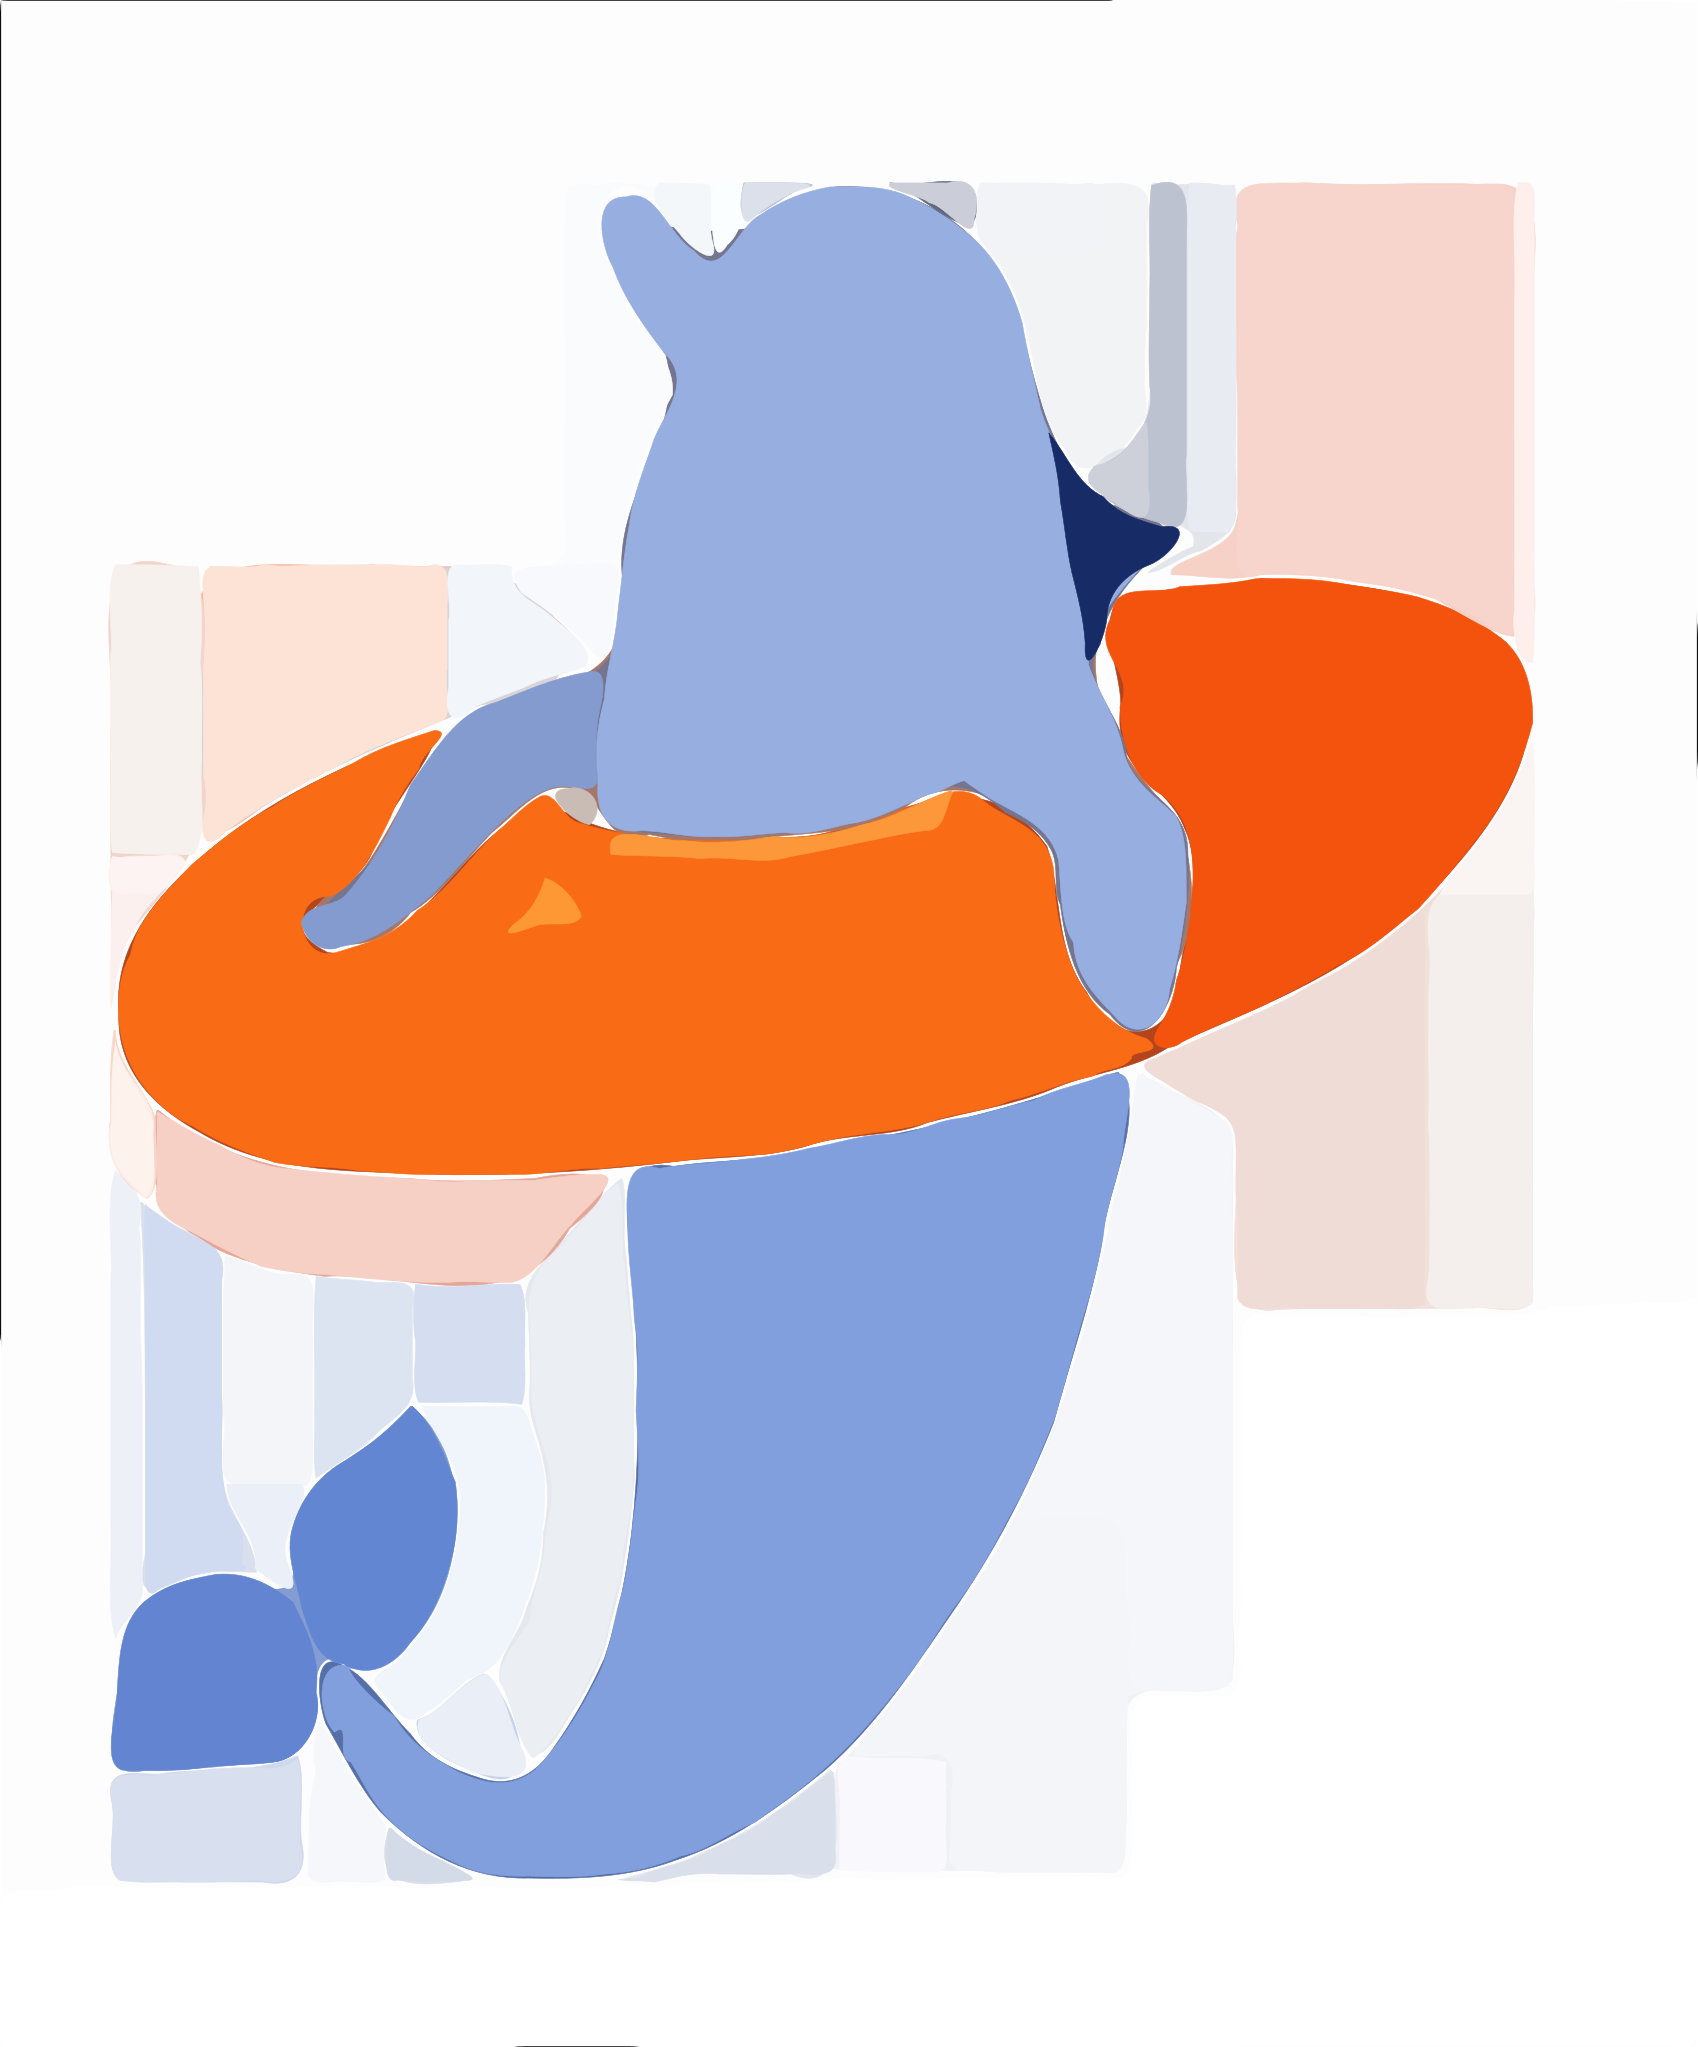

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 45.956360278228765
Topic5\house.png 
use_bezier_curve_num : 800 
component_num : 57


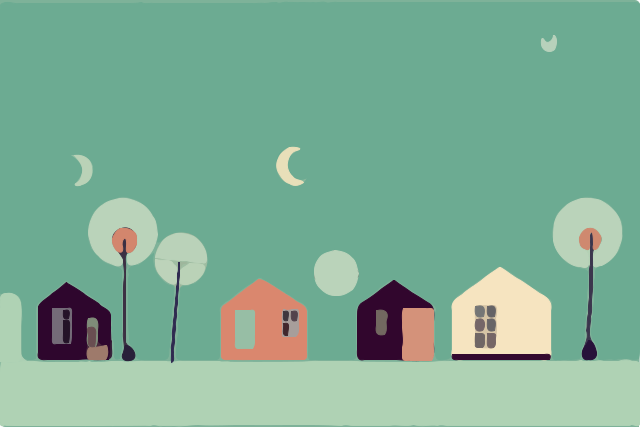

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.172823965651834
Topic5\meditation.png 
use_bezier_curve_num : 800 
component_num : 60


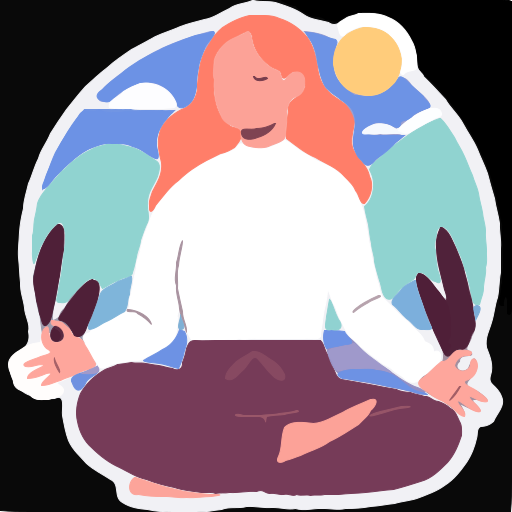

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 30.213144938151043
Topic5\tree.png 
use_bezier_curve_num : 800 
component_num : 200


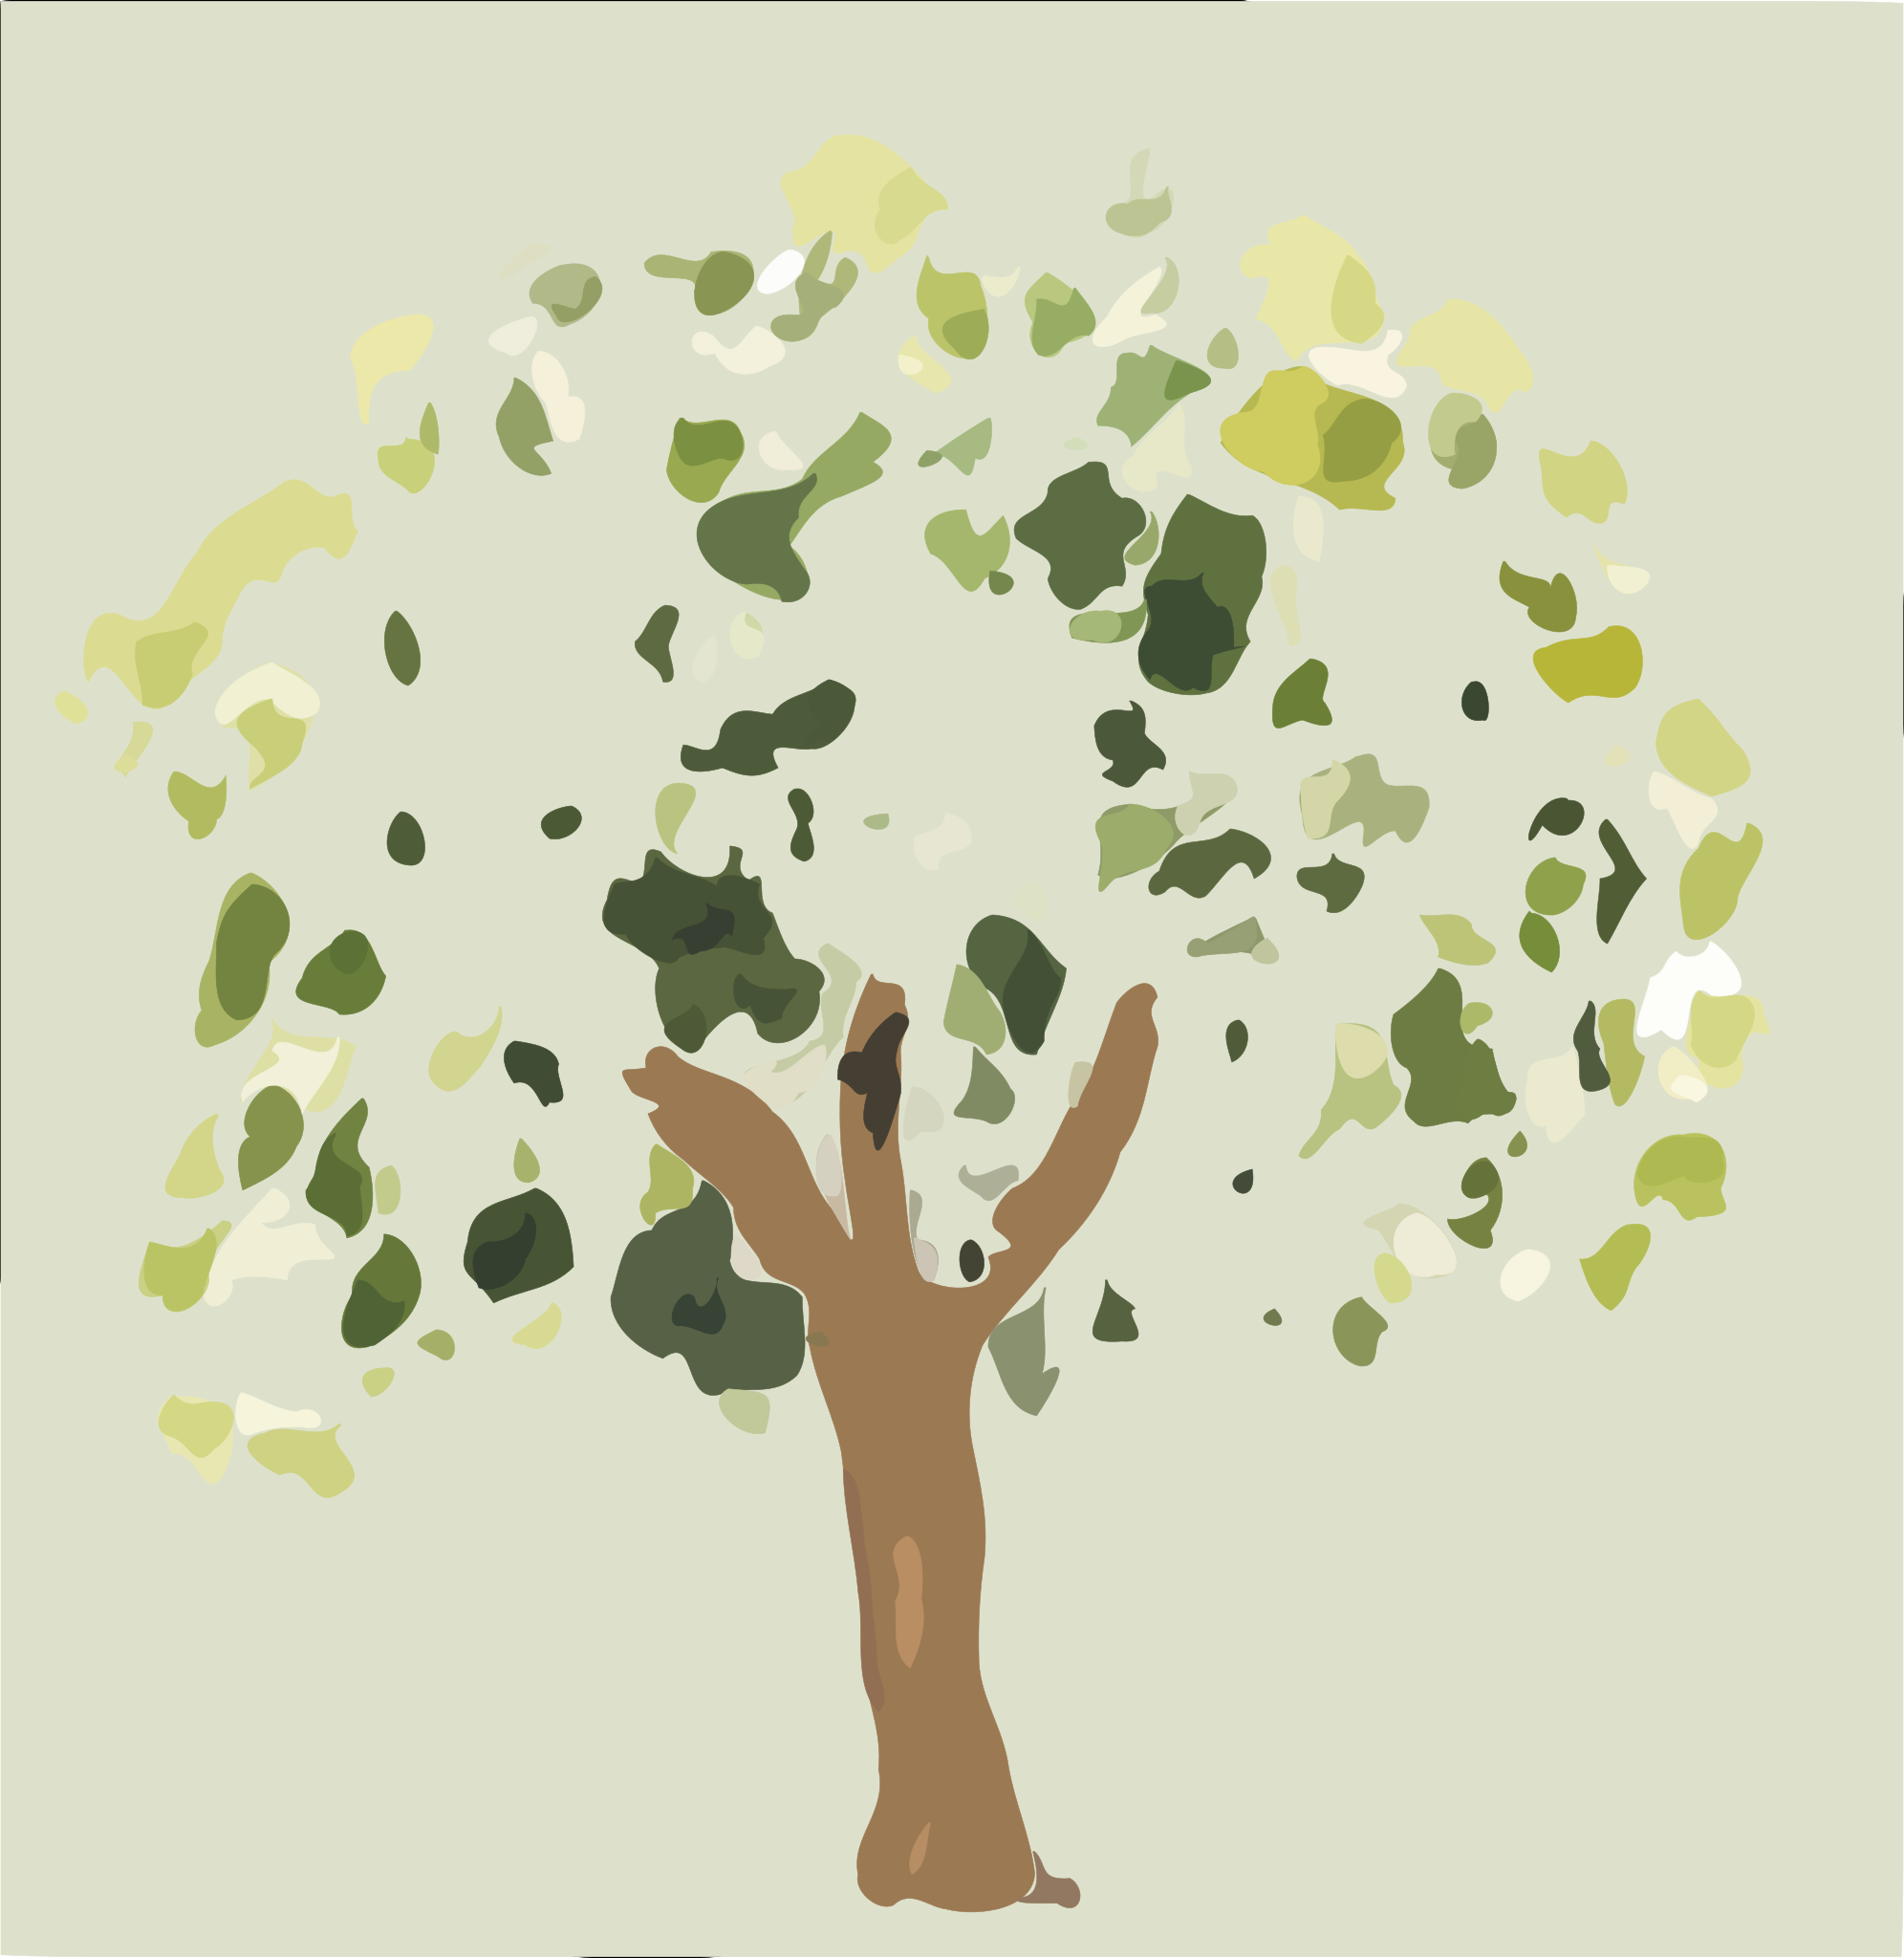

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.54270582092349
Topic5\work-from-home.png 
use_bezier_curve_num : 800 
component_num : 42


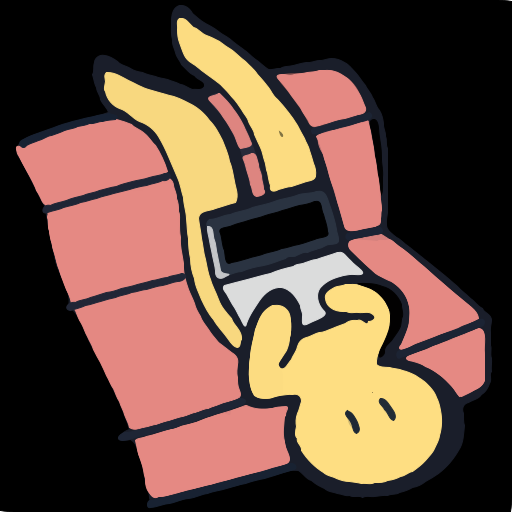

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 13.815116882324219
Topic5 Total MSE: 395.5658754125999
Topic5\fallingwater.jpg 
use_bezier_curve_num : 1000 
component_num : 139


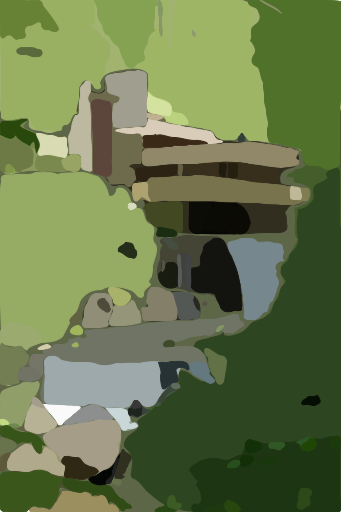

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 96.921430153348
Topic5\flower.jpg 
use_bezier_curve_num : 1000 
component_num : 177


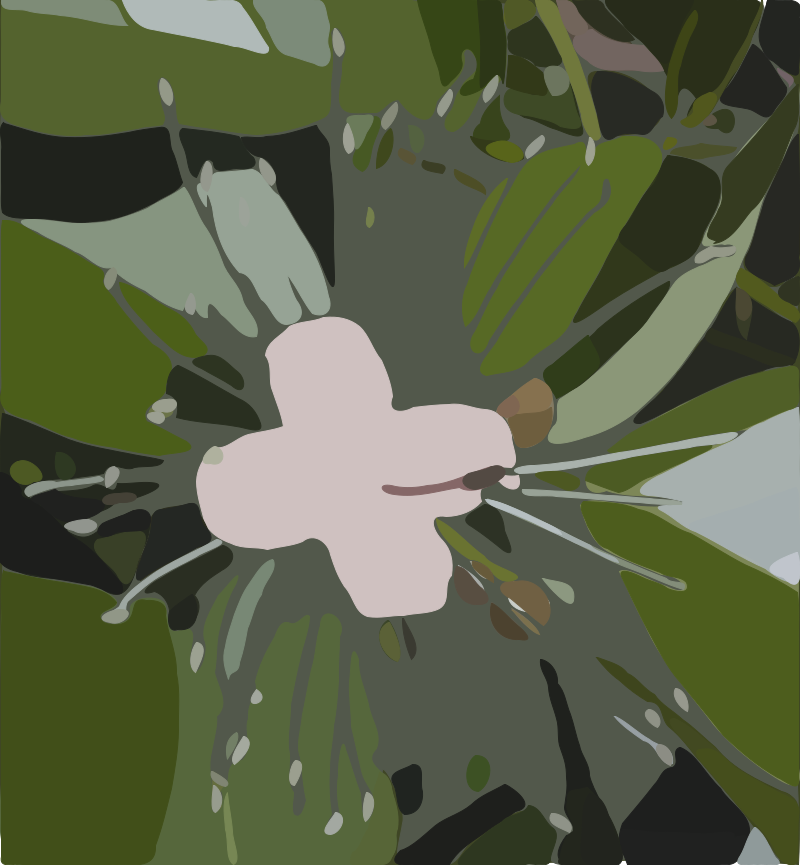

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.73124518304432
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 1000 
component_num : 98


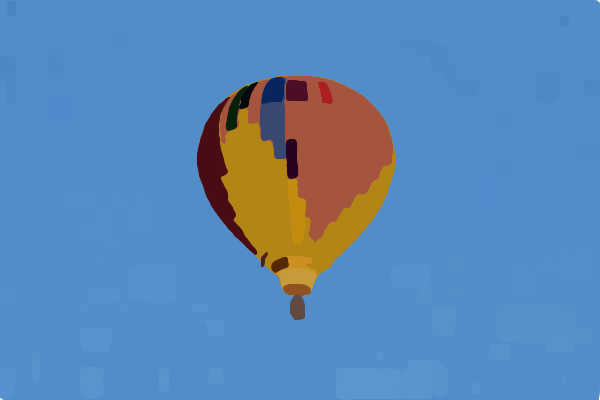

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.1144125
Topic5\autumn_01.png 
use_bezier_curve_num : 1000 
component_num : 22


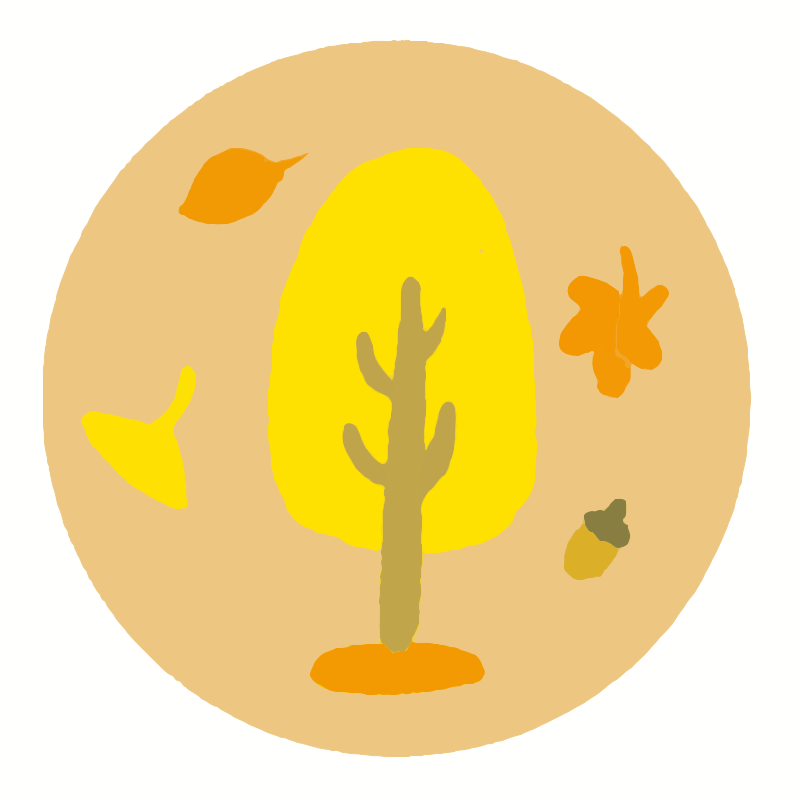

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.8993067708333333
Topic5\dolphin.png 
use_bezier_curve_num : 1000 
component_num : 78


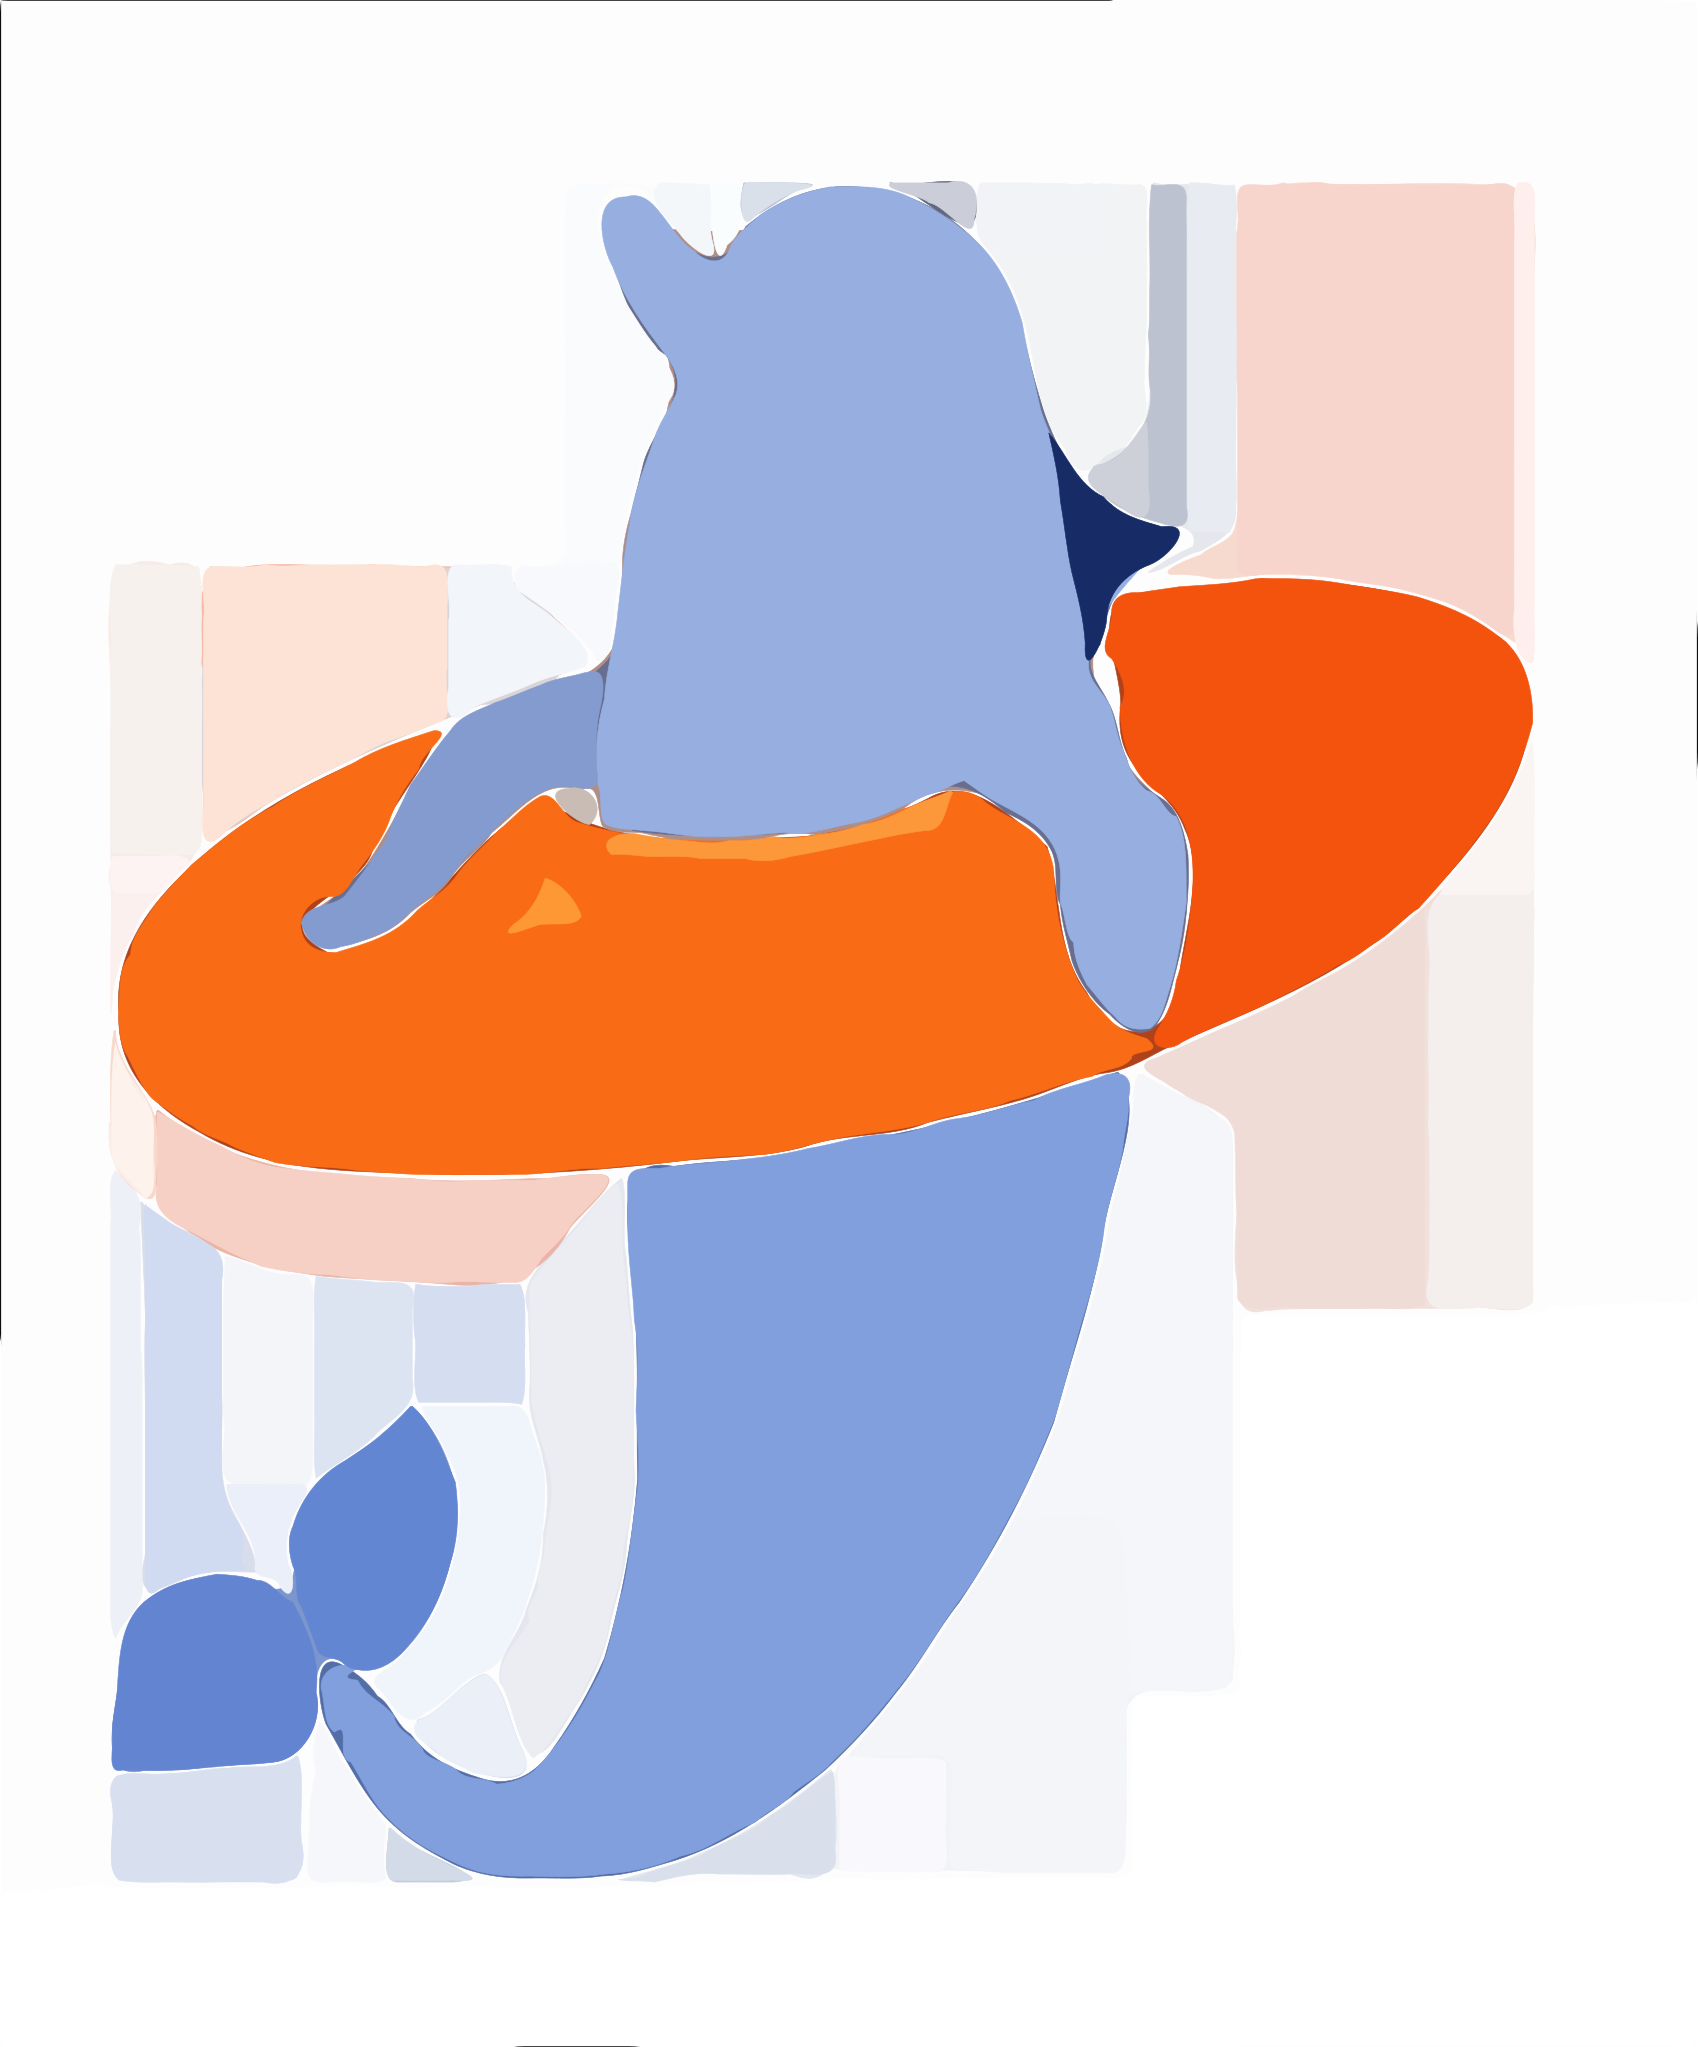

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 45.93641325987595
Topic5\house.png 
use_bezier_curve_num : 1000 
component_num : 57


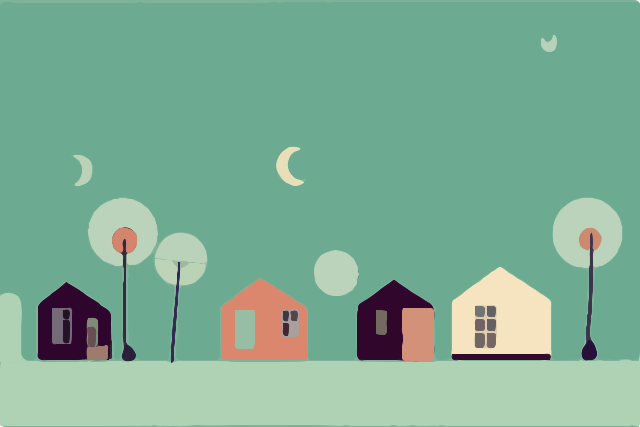

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.351452722482436
Topic5\meditation.png 
use_bezier_curve_num : 1000 
component_num : 60


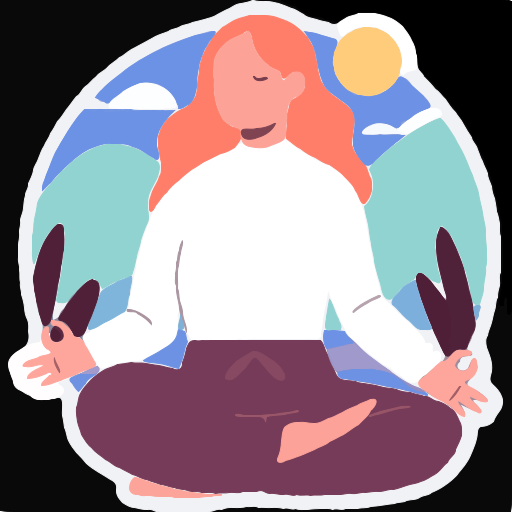

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 29.58033498128255
Topic5\tree.png 
use_bezier_curve_num : 1000 
component_num : 200


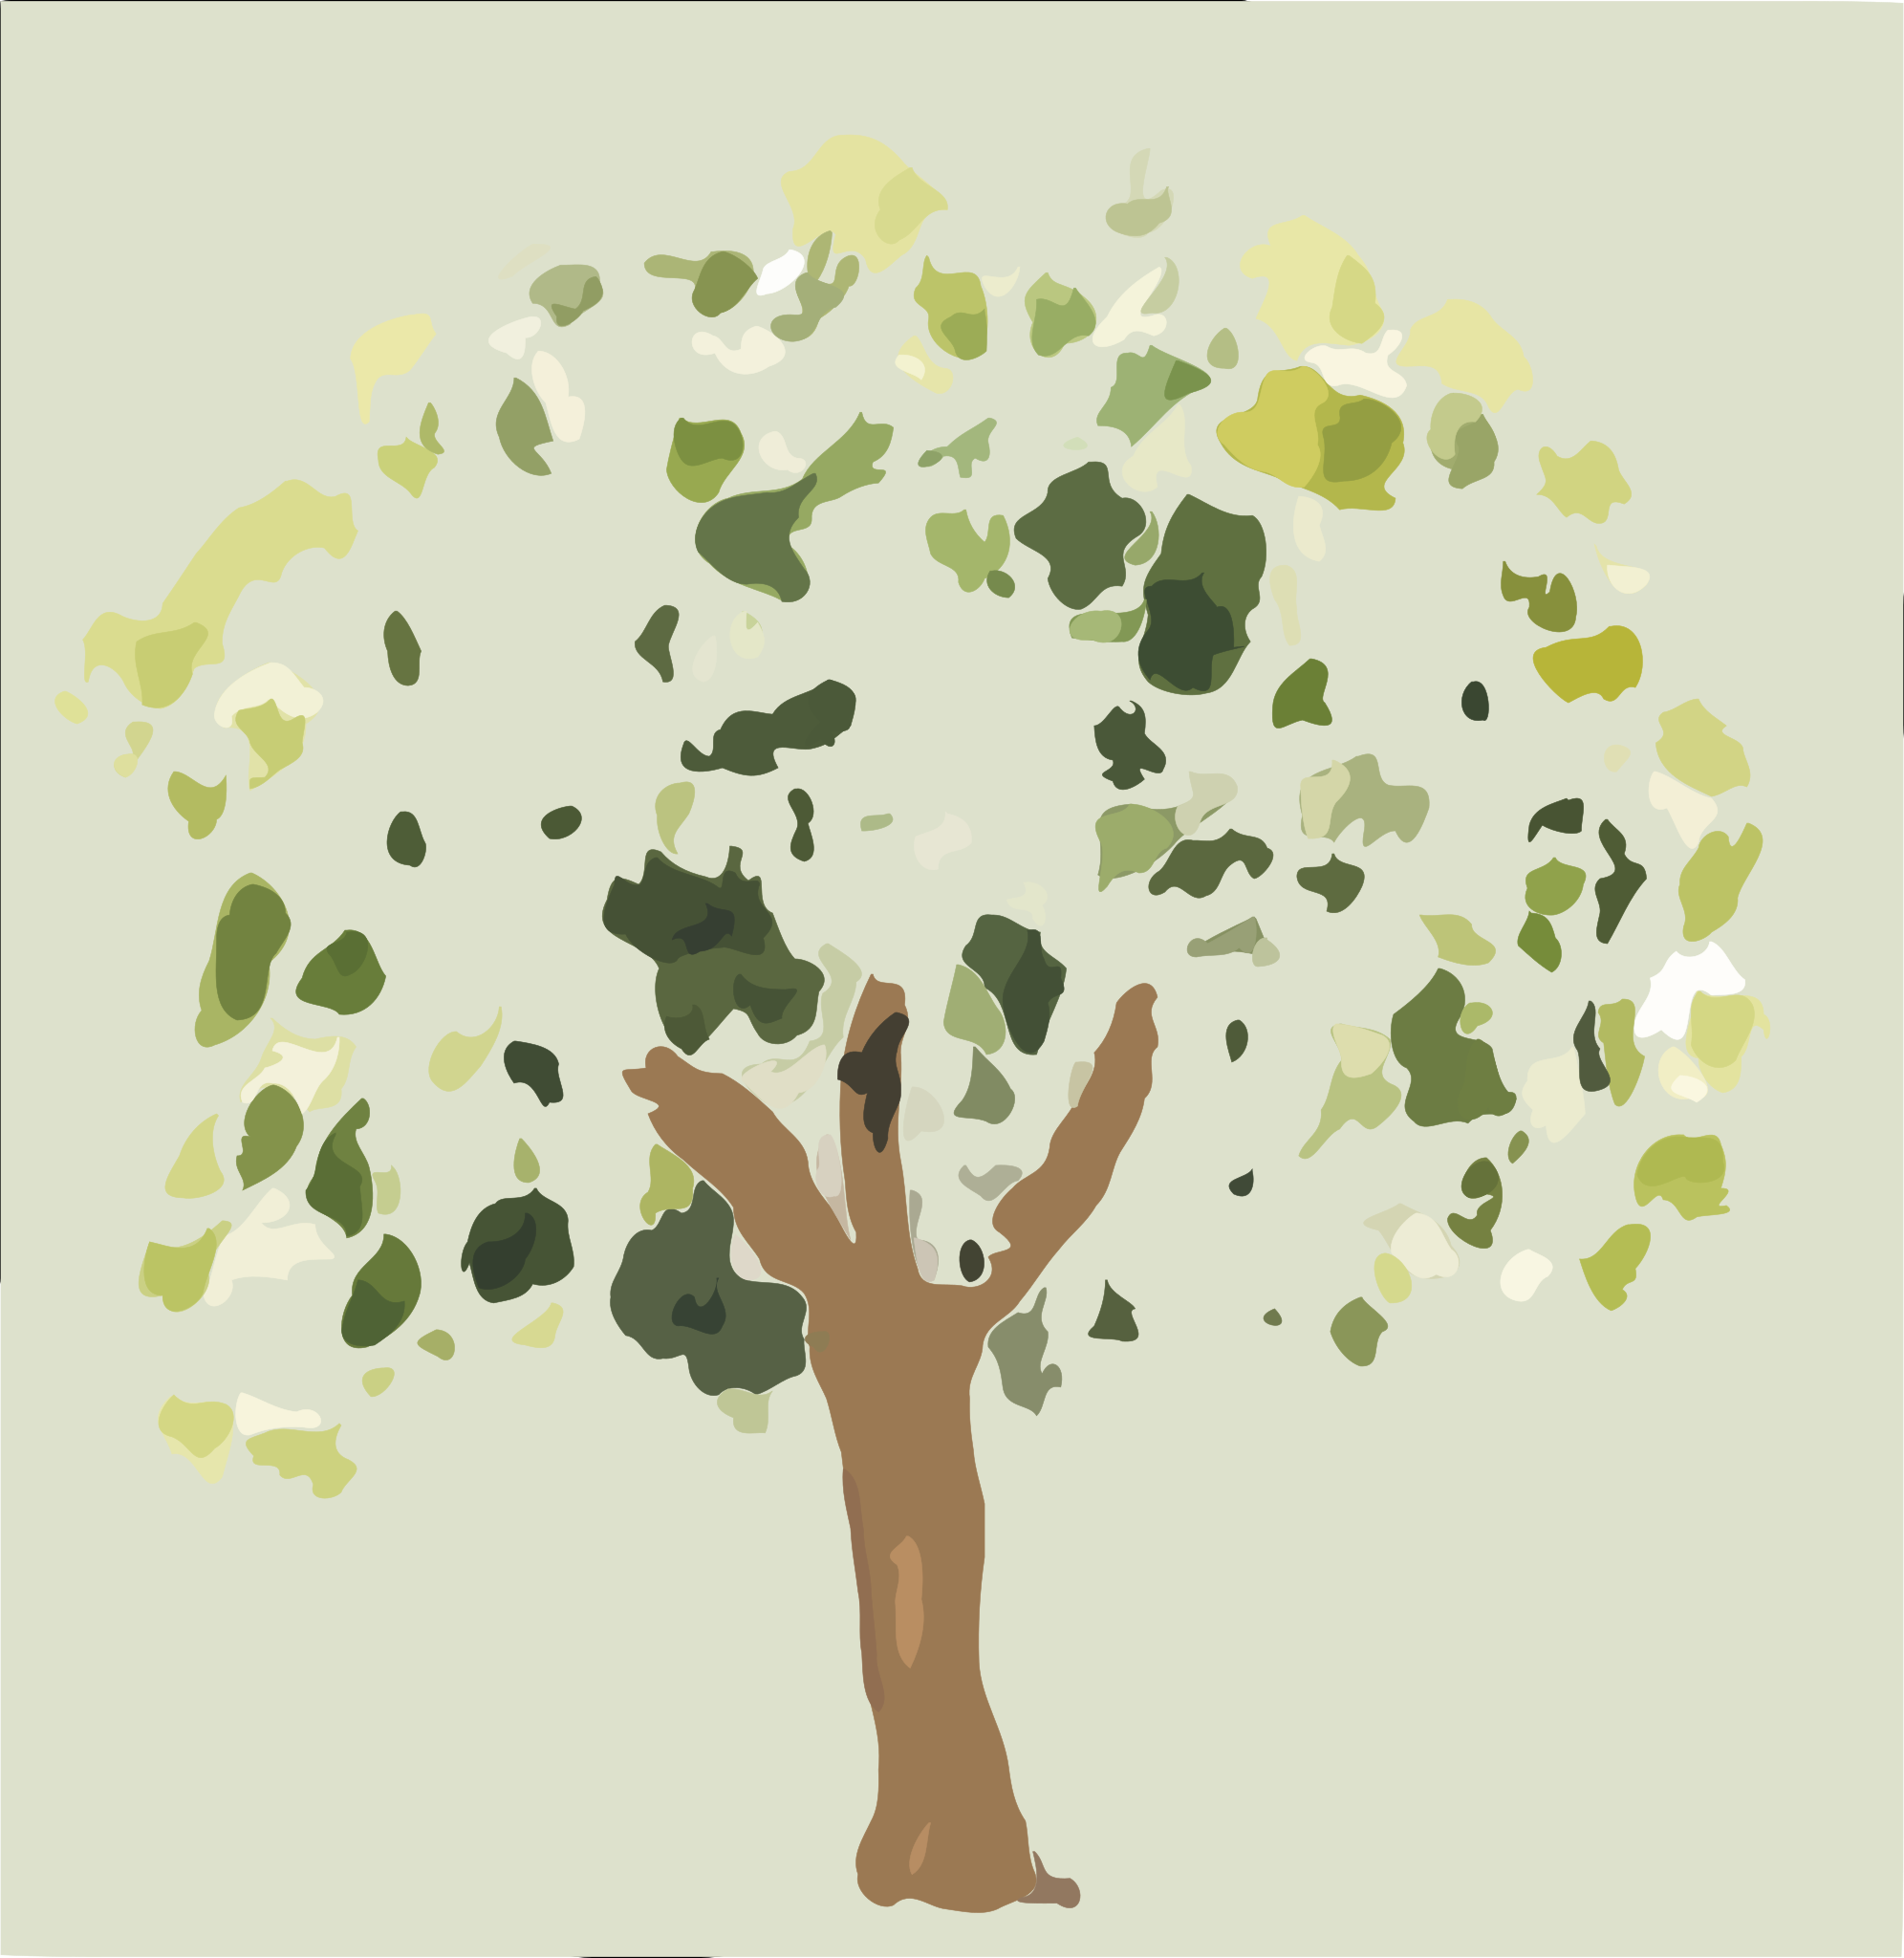

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.24797491188713
Topic5\work-from-home.png 
use_bezier_curve_num : 1000 
component_num : 42


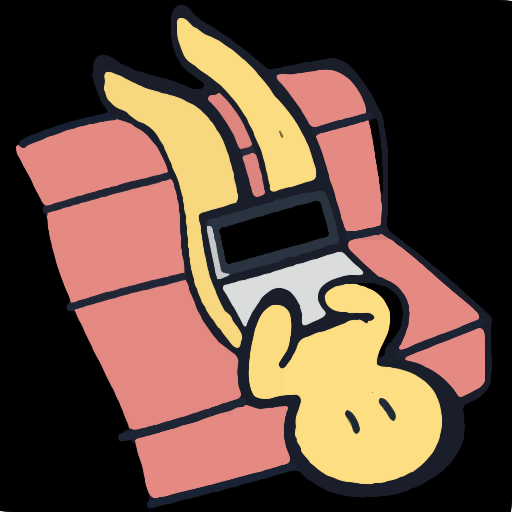

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 13.889216105143229
Topic5 Total MSE: 394.671786587897
851.9254834651947


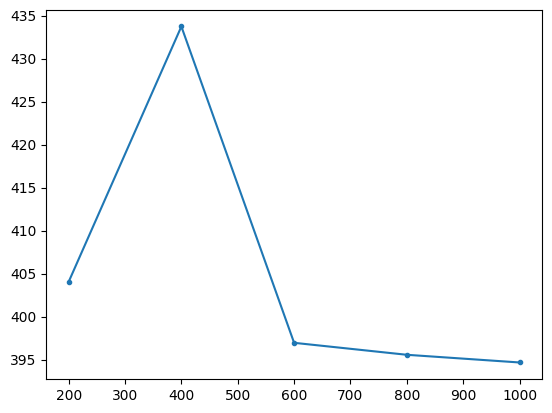

In [109]:
Test(V21=True,V22=True,V31=True,labelname="V22")

Topic5\fallingwater.jpg 
use_bezier_curve_num : 200 
component_num : 139


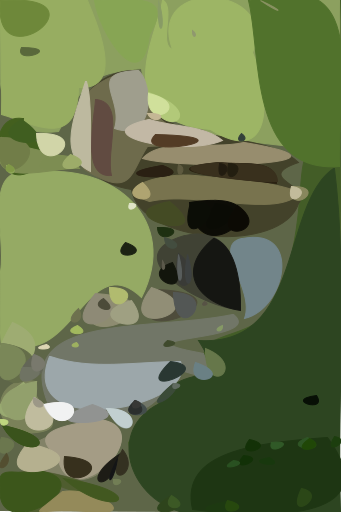

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 98.5037420576735
Topic5\flower.jpg 
use_bezier_curve_num : 200 
component_num : 177


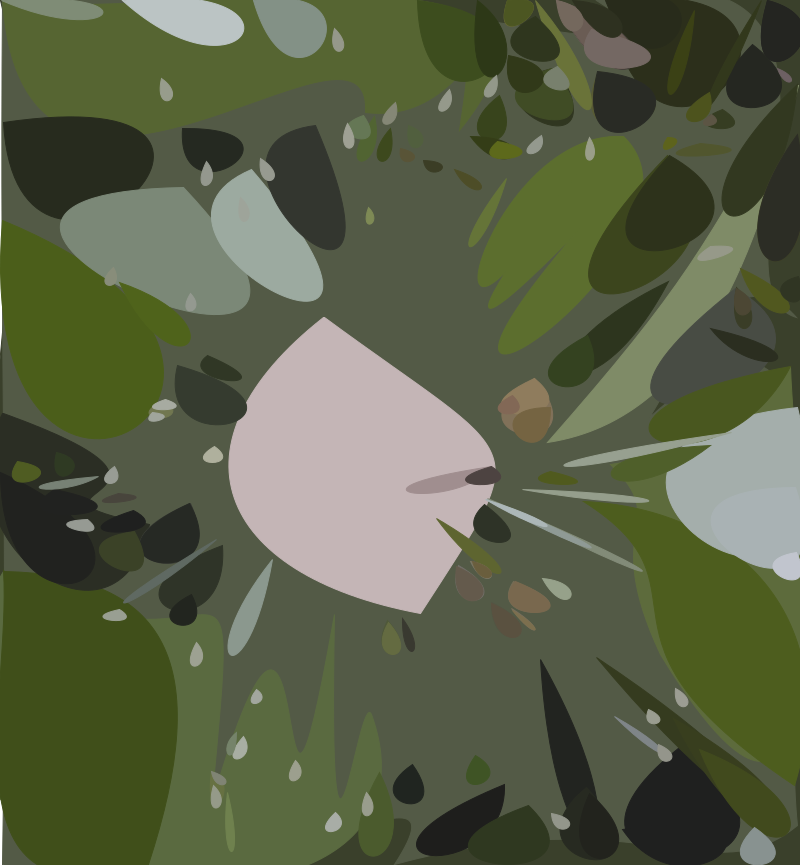

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 88.35008477842004
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 200 
component_num : 98


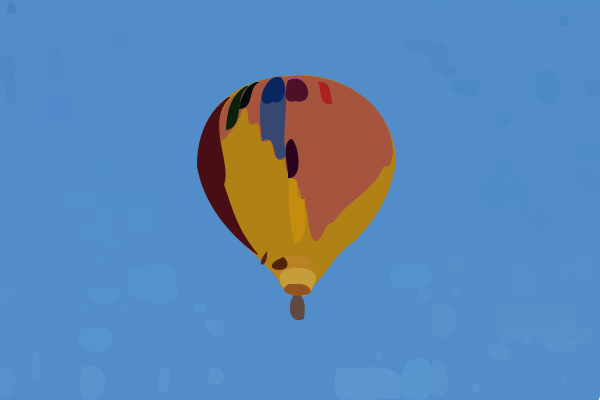

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.250004166666667
Topic5\autumn_01.png 
use_bezier_curve_num : 200 
component_num : 22


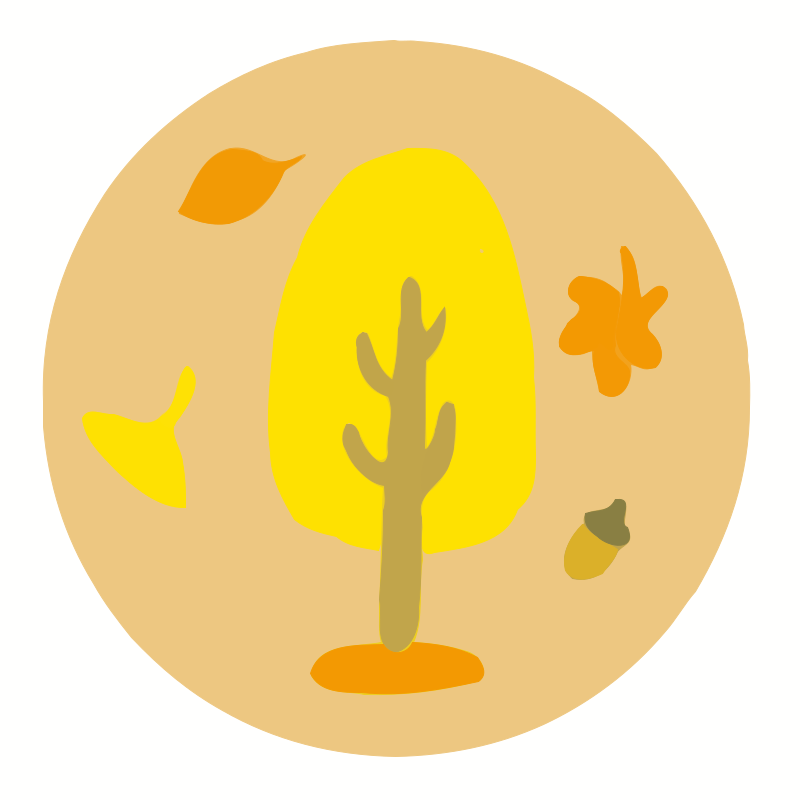

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 2.206905208333333
Topic5\dolphin.png 
use_bezier_curve_num : 200 
component_num : 78


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


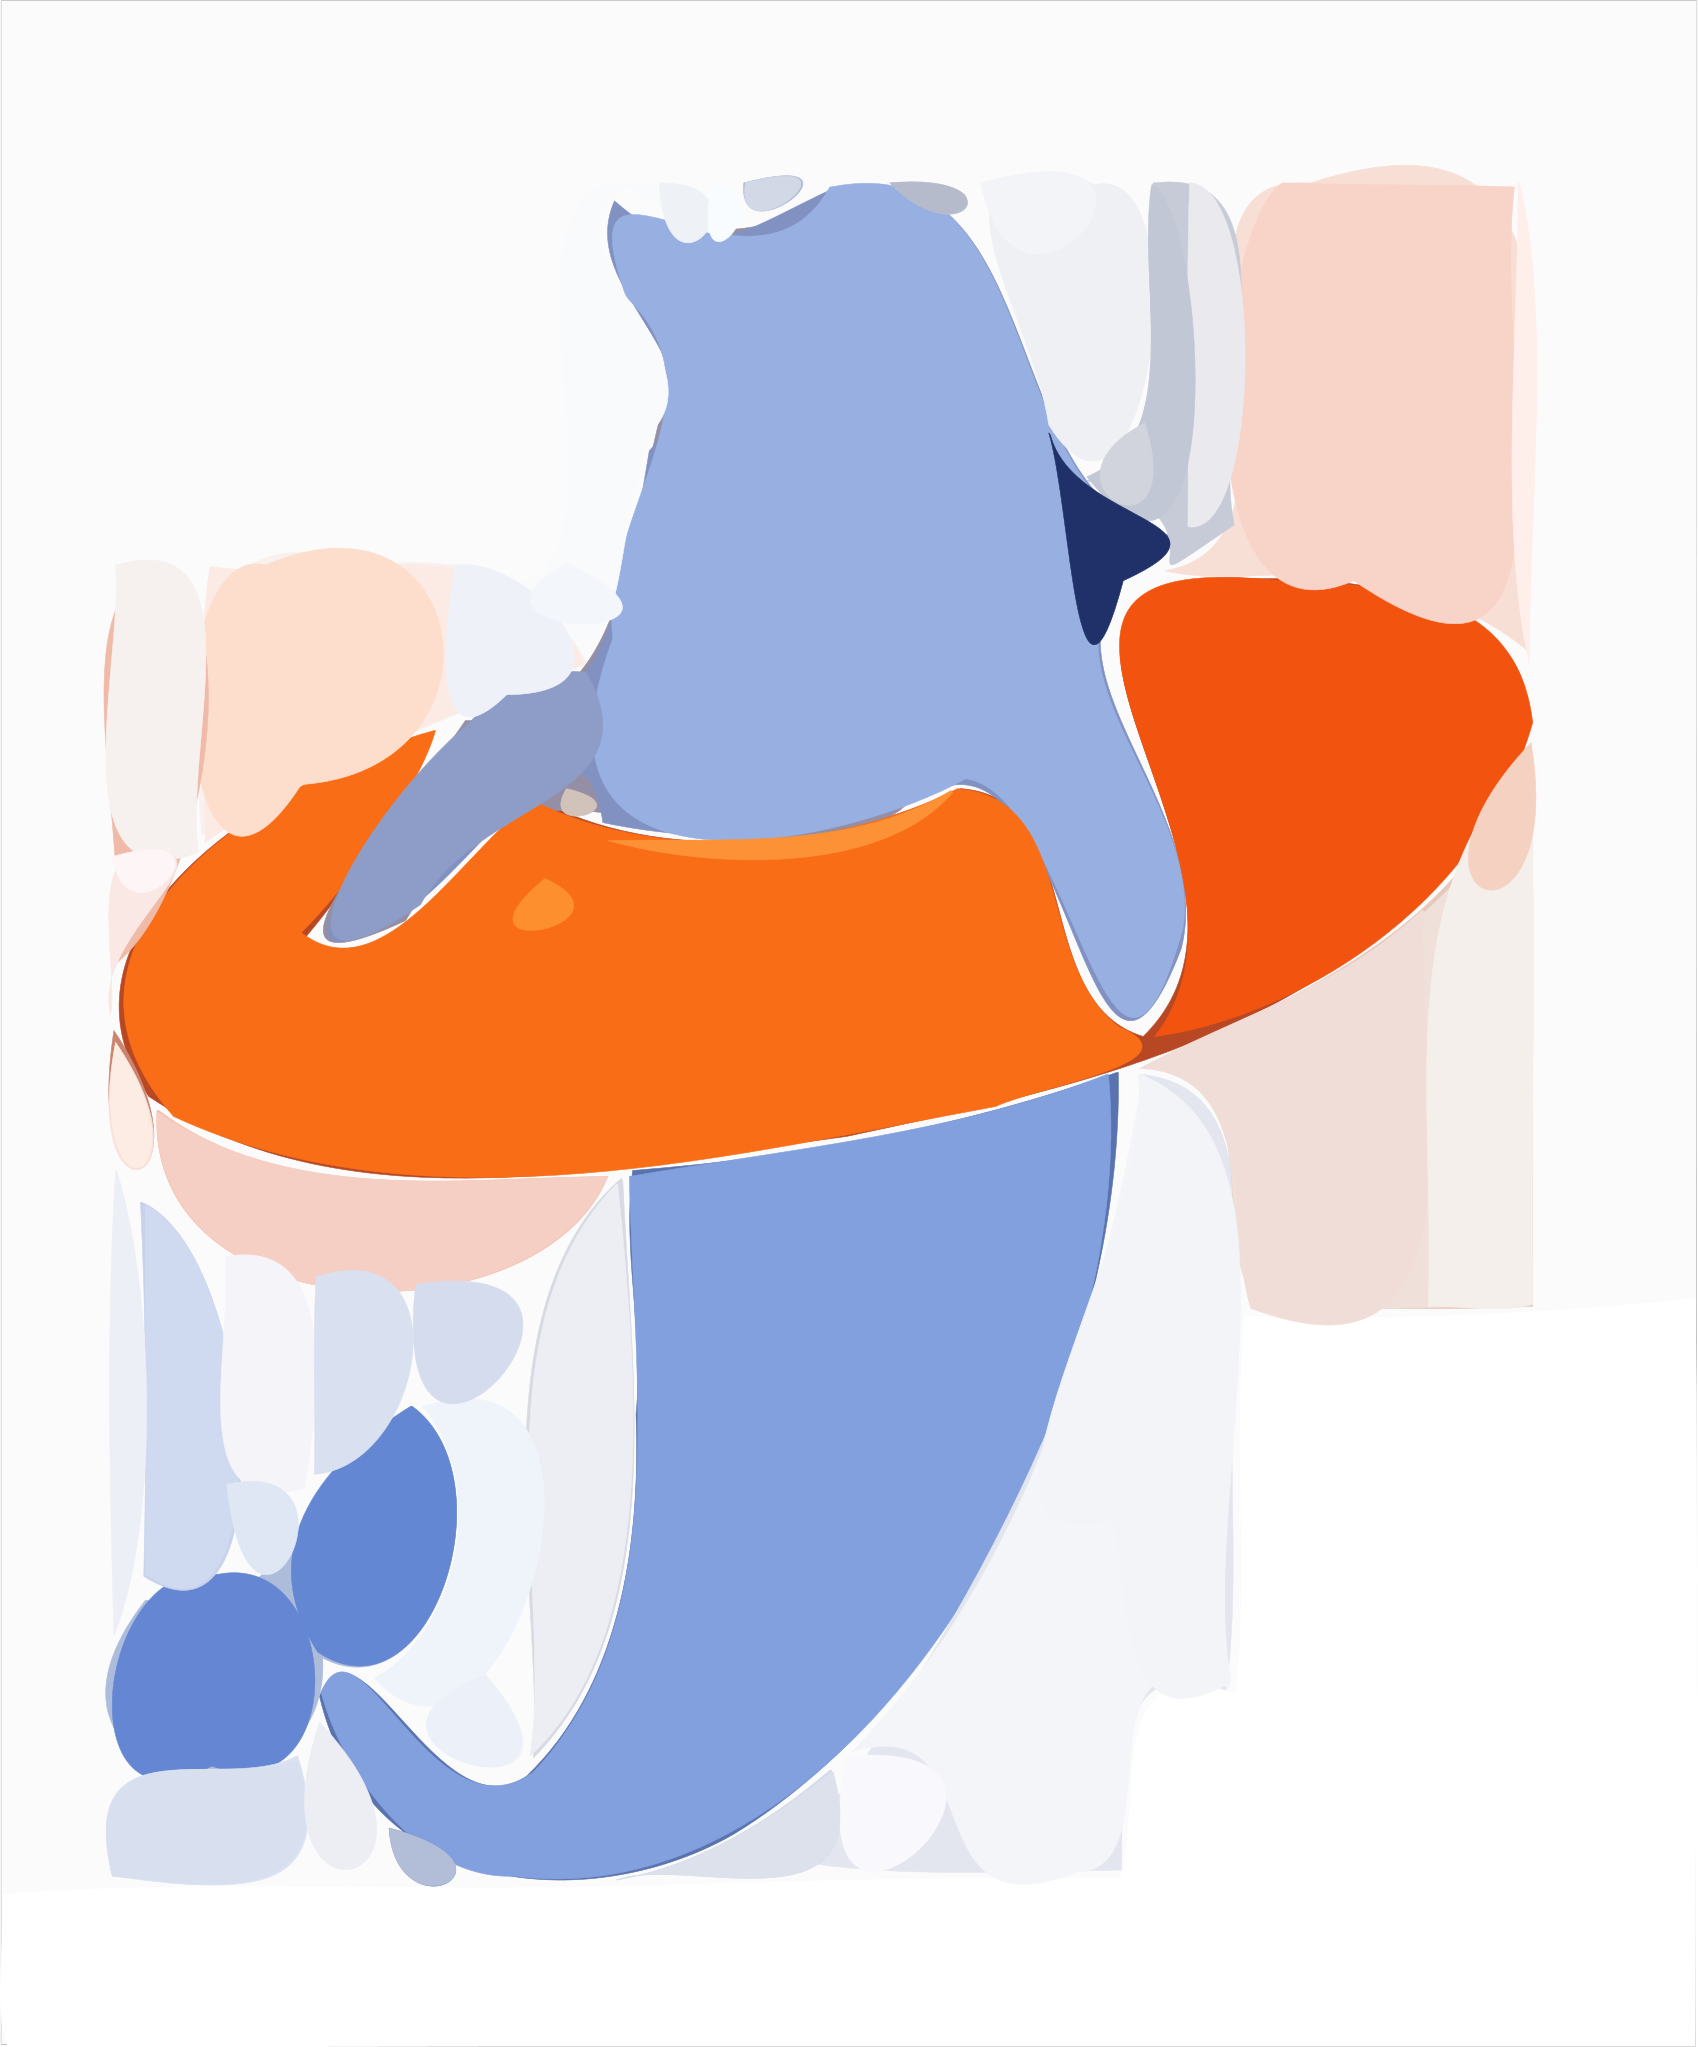

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 49.93617545154178
Topic5\house.png 
use_bezier_curve_num : 200 
component_num : 57


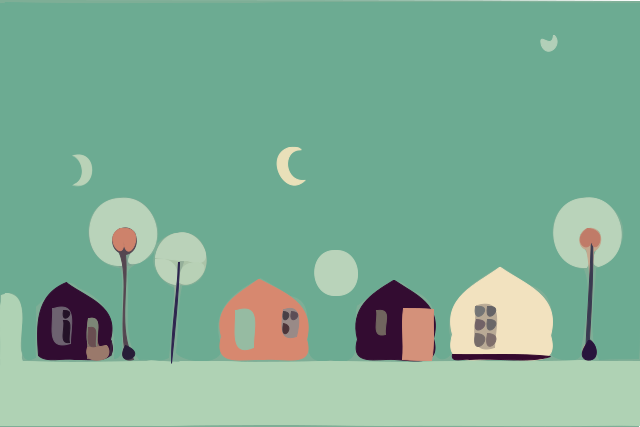

Topic5\house.png vs SVG2PNG_Topic5\house.png: 7.397514149102264
Topic5\meditation.png 
use_bezier_curve_num : 200 
component_num : 60


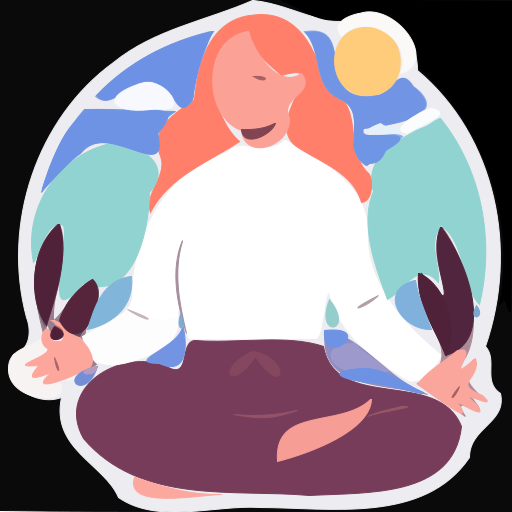

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 35.71942392985026
Topic5\tree.png 
use_bezier_curve_num : 200 
component_num : 200


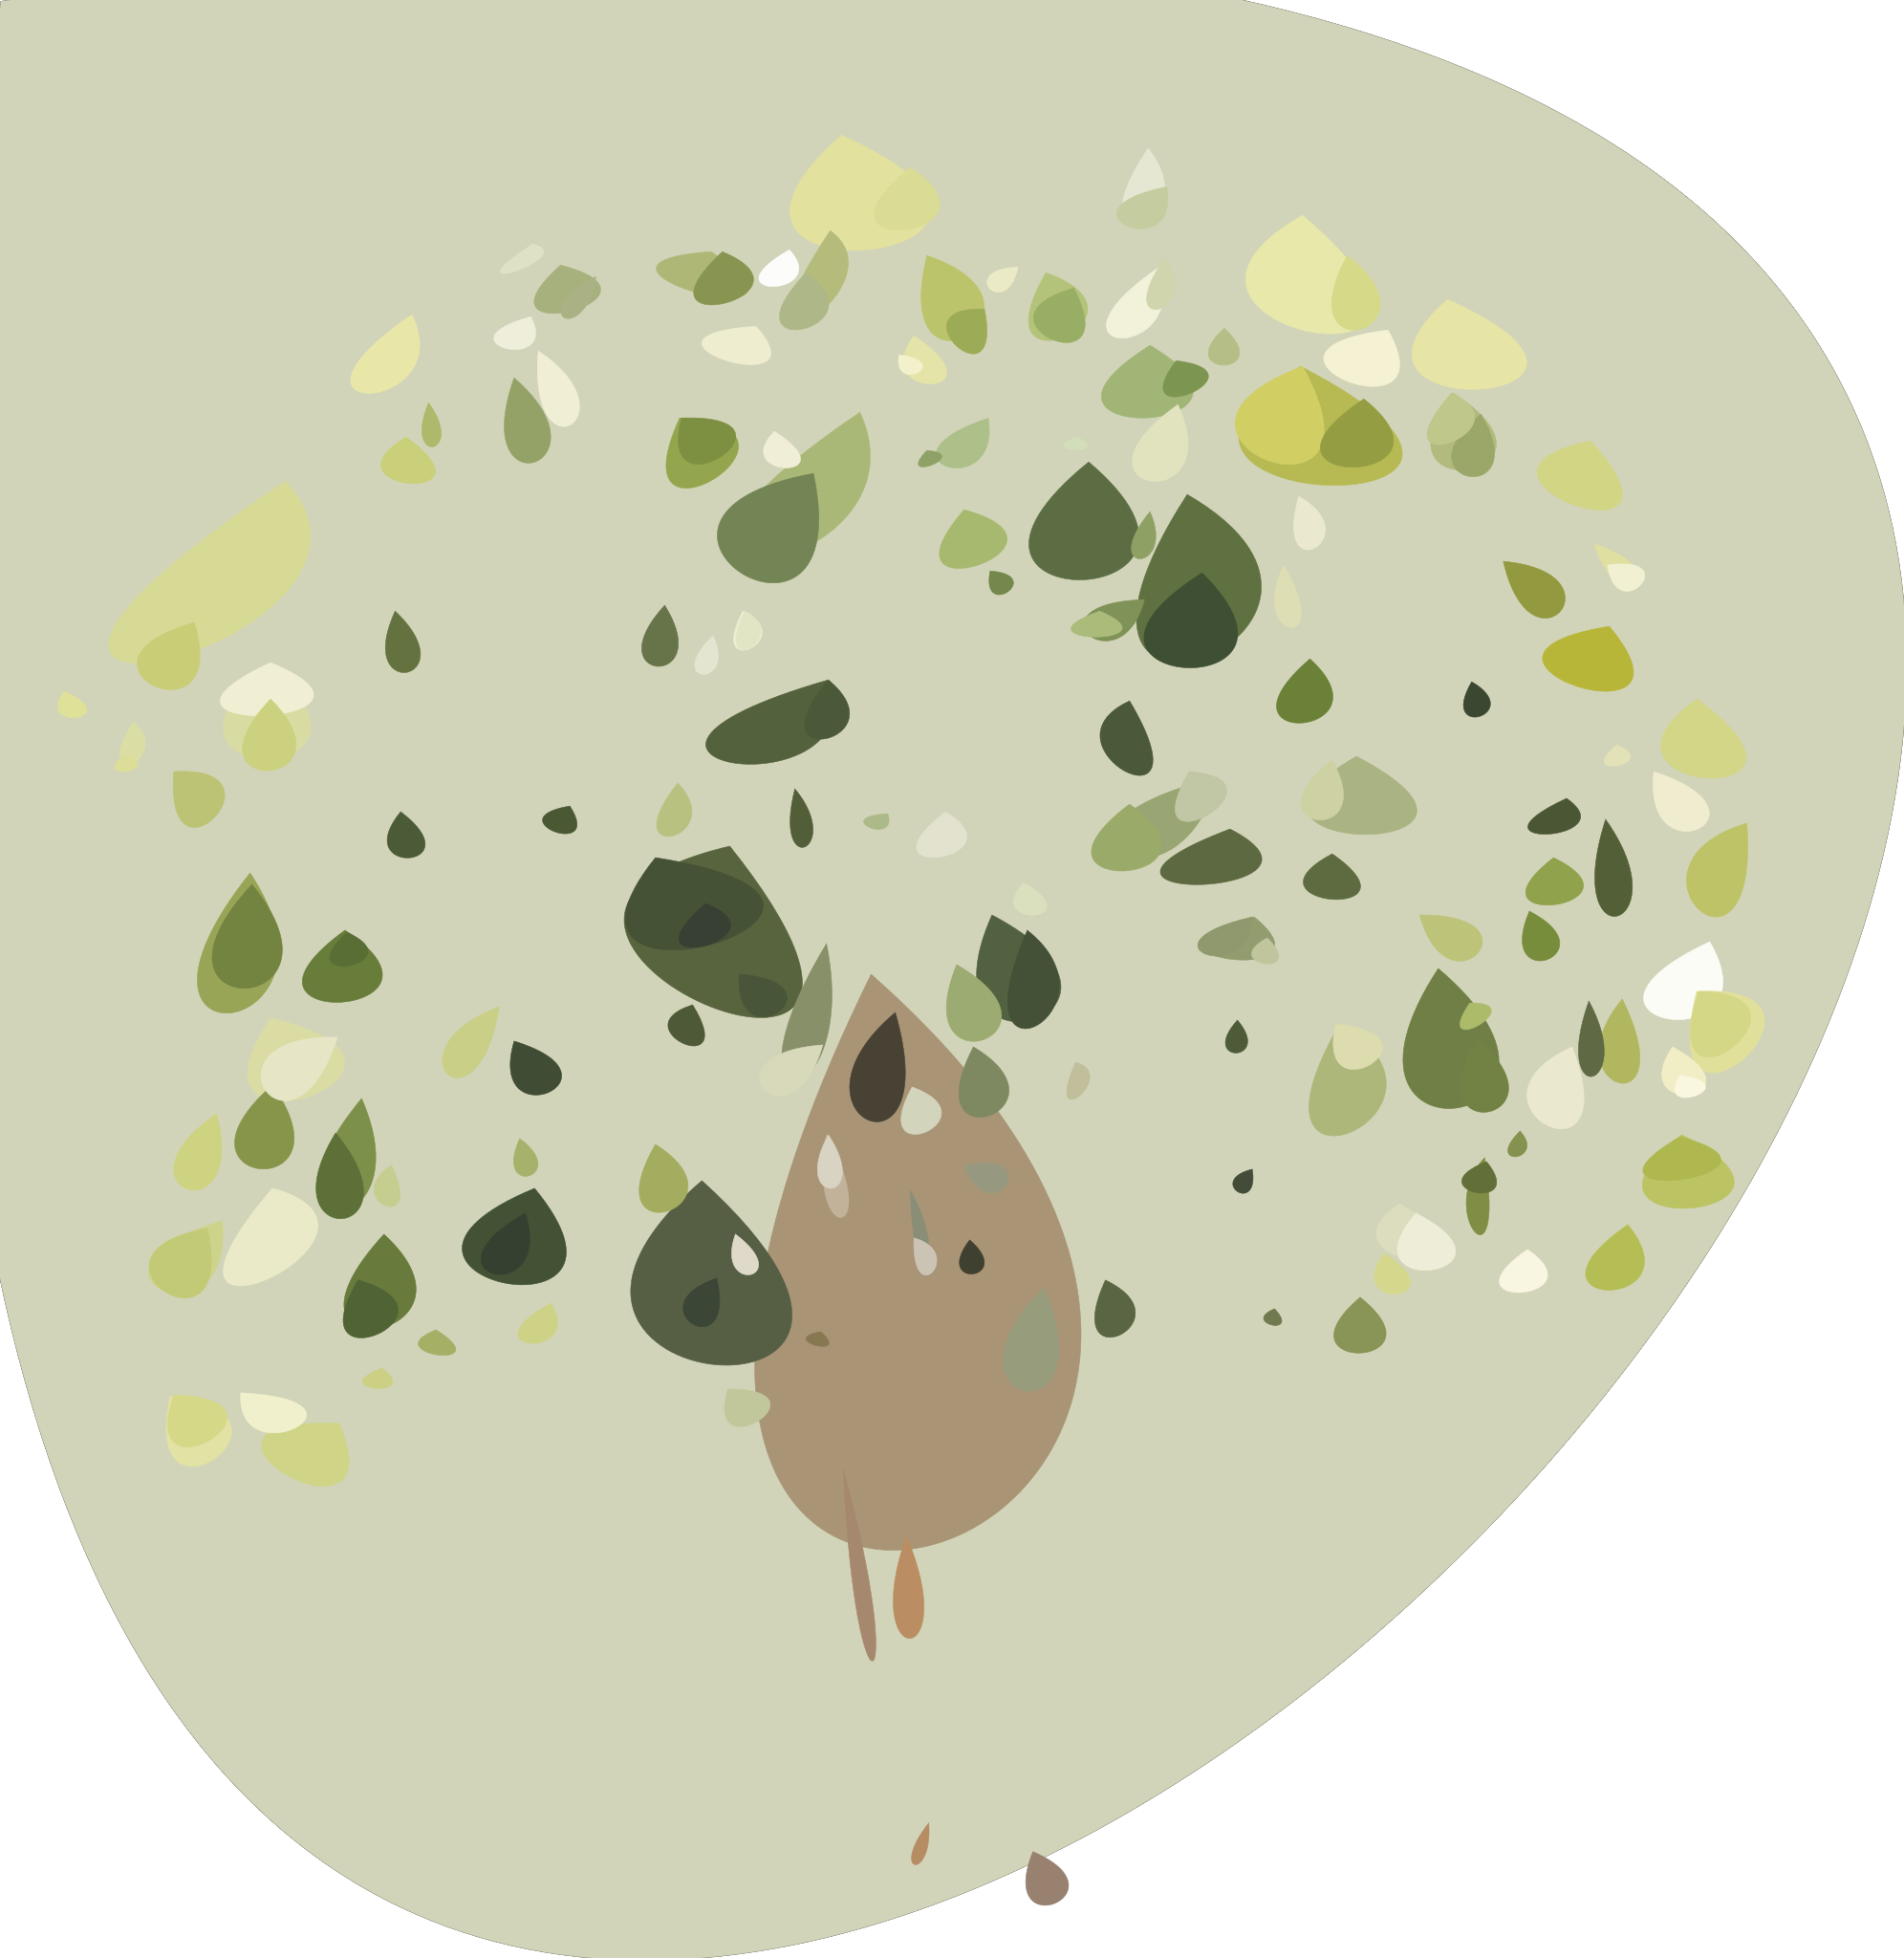

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 80.12982530303712
Topic5\work-from-home.png 
use_bezier_curve_num : 200 
component_num : 42


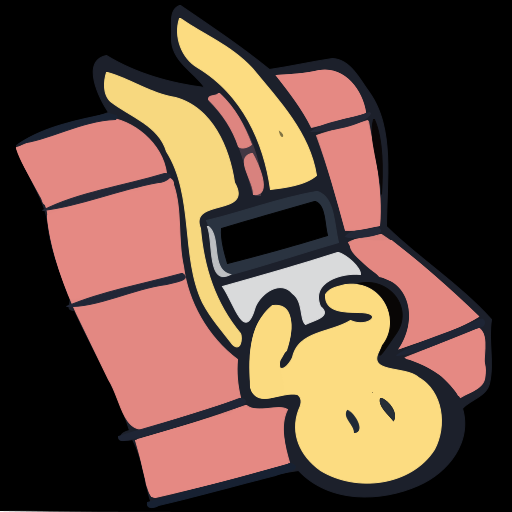

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 12.813397725423178
Topic5 Total MSE: 402.3070727700482
Topic5\fallingwater.jpg 
use_bezier_curve_num : 400 
component_num : 139


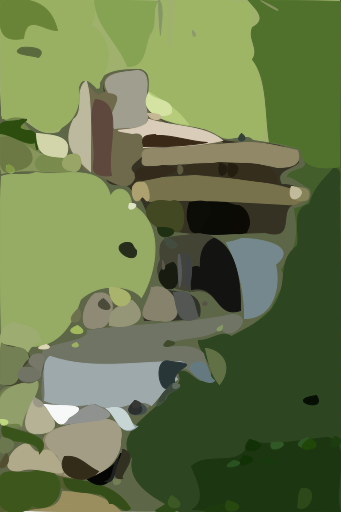

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.54682345124634
Topic5\flower.jpg 
use_bezier_curve_num : 400 
component_num : 177


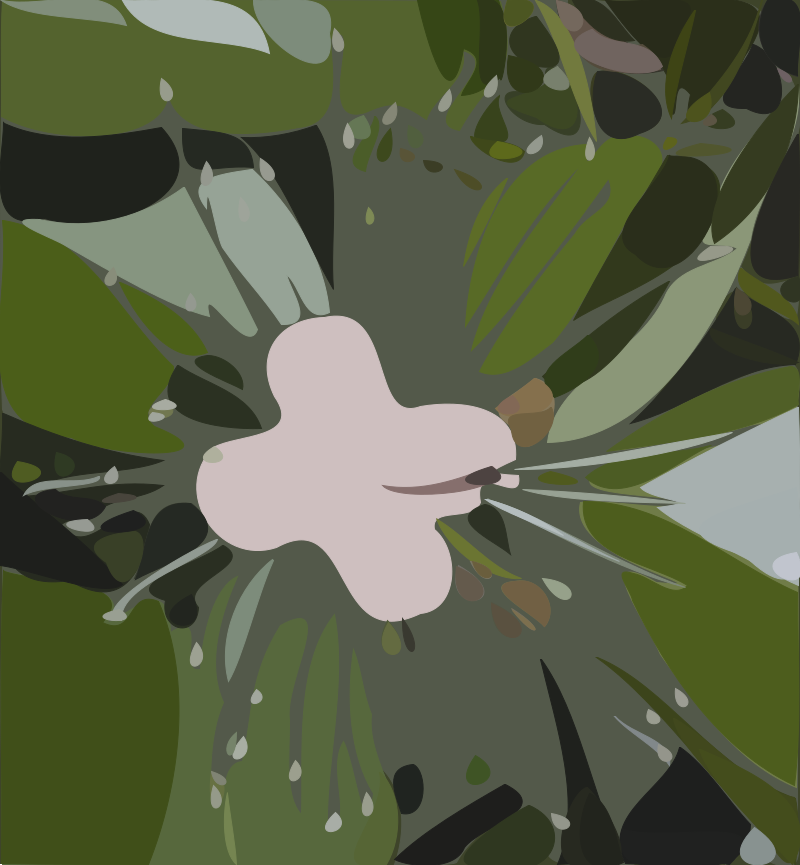

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 80.78088294797688
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 400 
component_num : 98


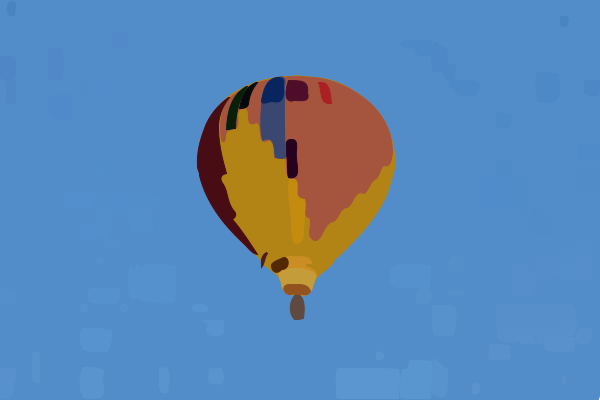

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 26.827526388888888
Topic5\autumn_01.png 
use_bezier_curve_num : 400 
component_num : 22


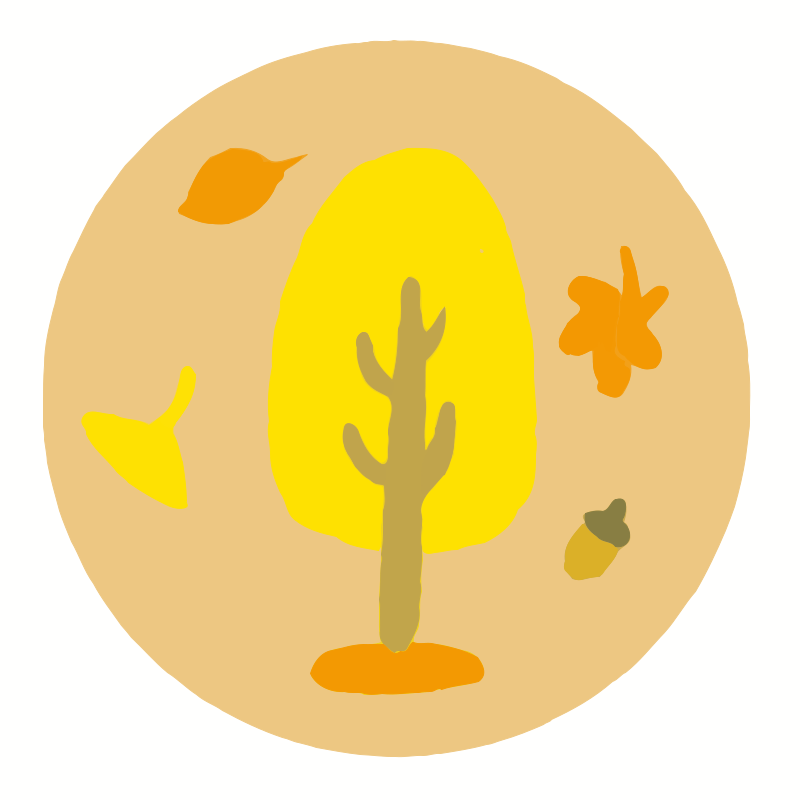

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.9357692708333334
Topic5\dolphin.png 
use_bezier_curve_num : 400 
component_num : 78


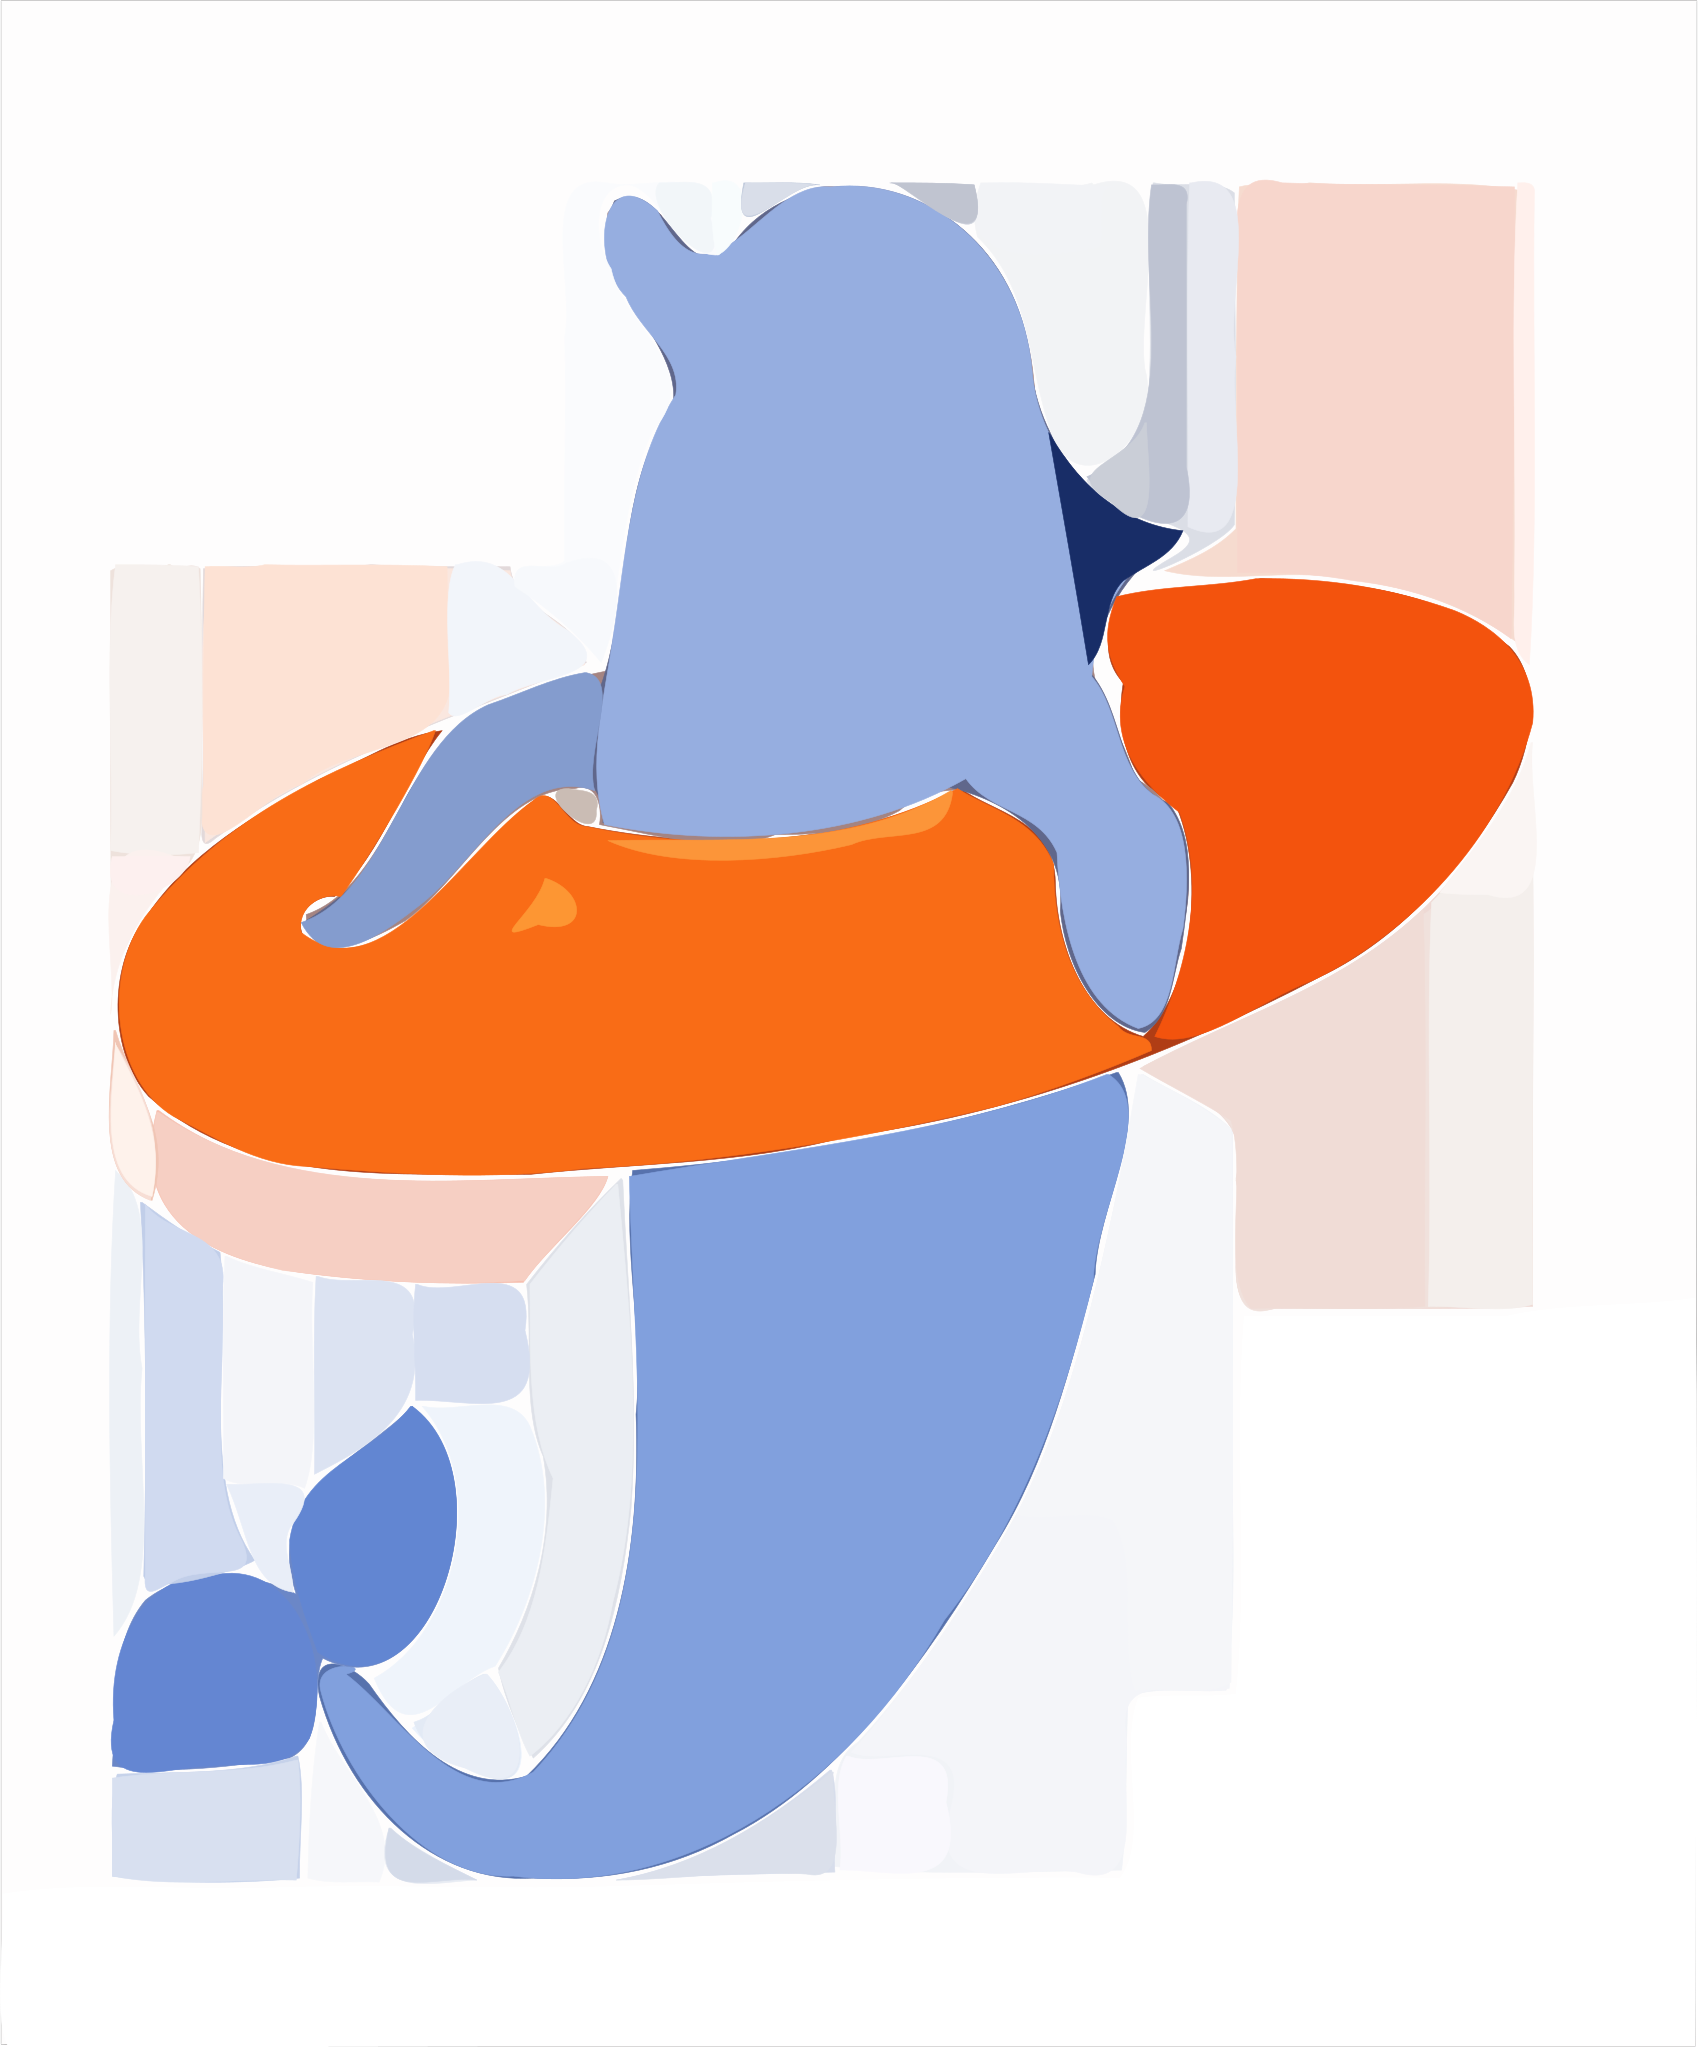

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.02552744945204
Topic5\house.png 
use_bezier_curve_num : 400 
component_num : 57


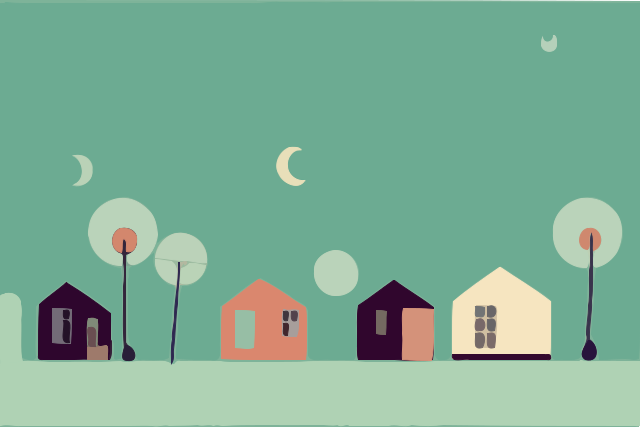

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.4504891198282595
Topic5\meditation.png 
use_bezier_curve_num : 400 
component_num : 60


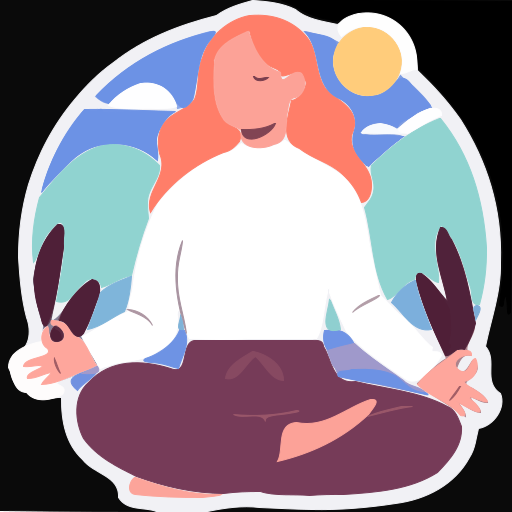

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 33.36155446370443
Topic5\tree.png 
use_bezier_curve_num : 400 
component_num : 200


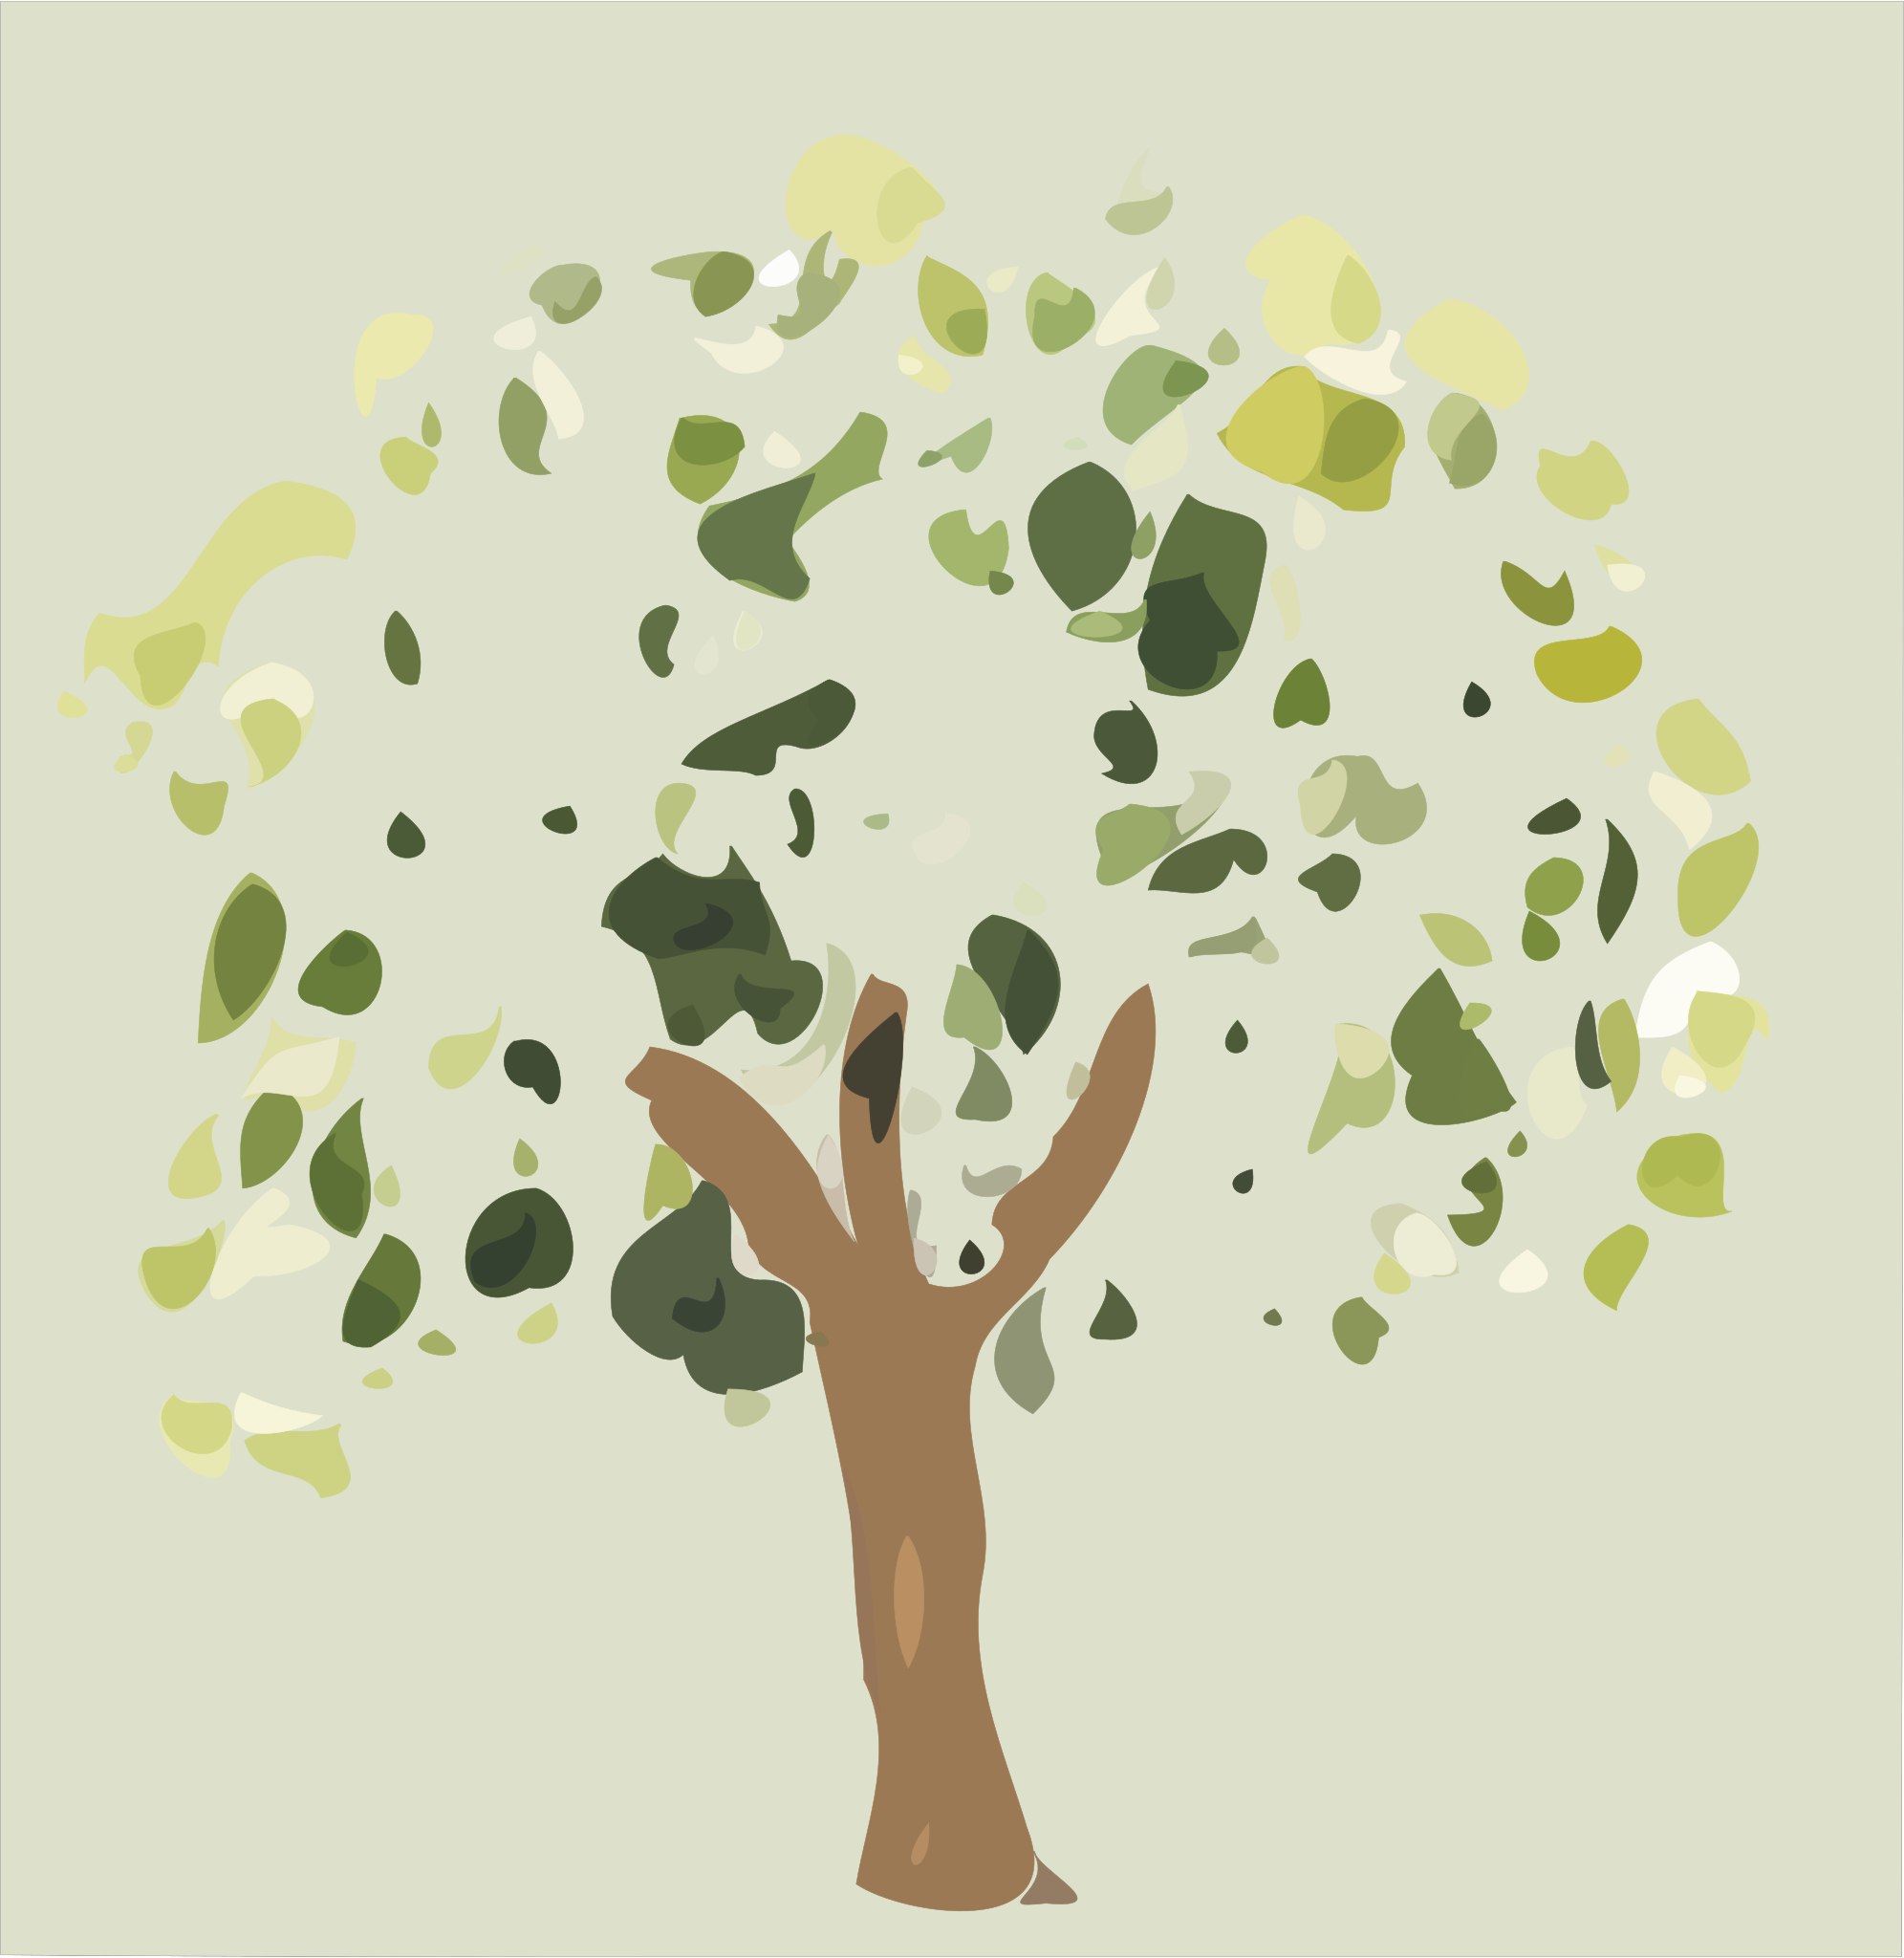

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 123.05686502742513
Topic5\work-from-home.png 
use_bezier_curve_num : 400 
component_num : 42


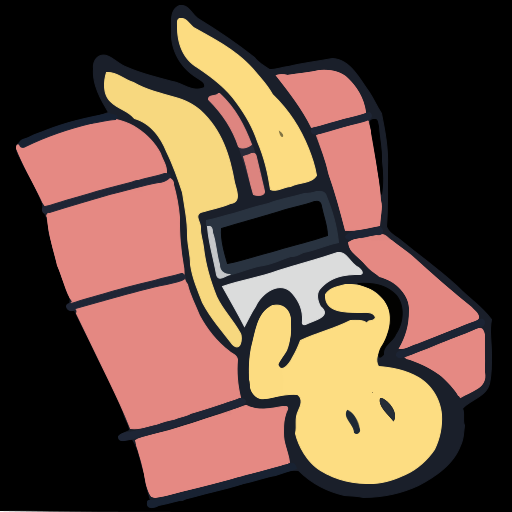

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 14.877208709716797
Topic5 Total MSE: 430.8626468290721
Topic5\fallingwater.jpg 
use_bezier_curve_num : 600 
component_num : 139


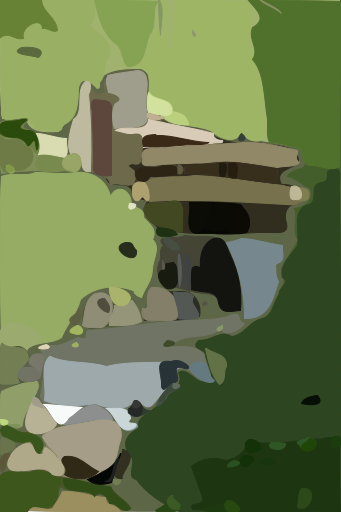

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.31073397788367
Topic5\flower.jpg 
use_bezier_curve_num : 600 
component_num : 177


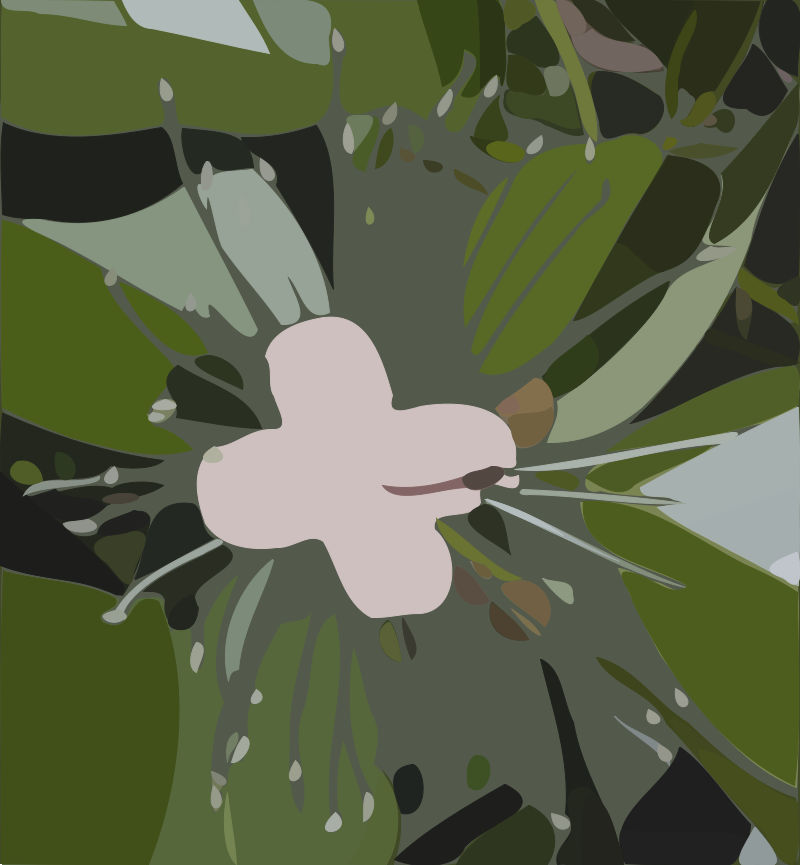

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.98464980732177
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 600 
component_num : 98


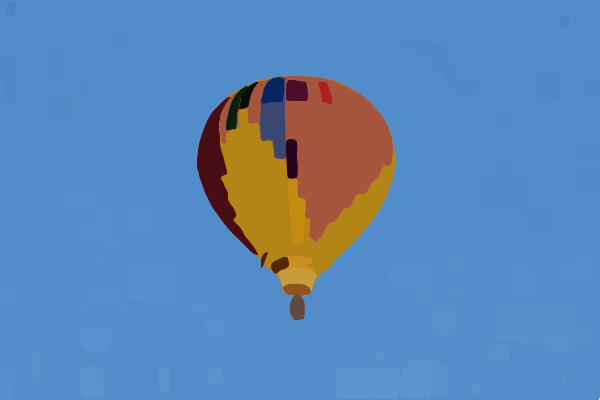

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.138708333333334
Topic5\autumn_01.png 
use_bezier_curve_num : 600 
component_num : 22


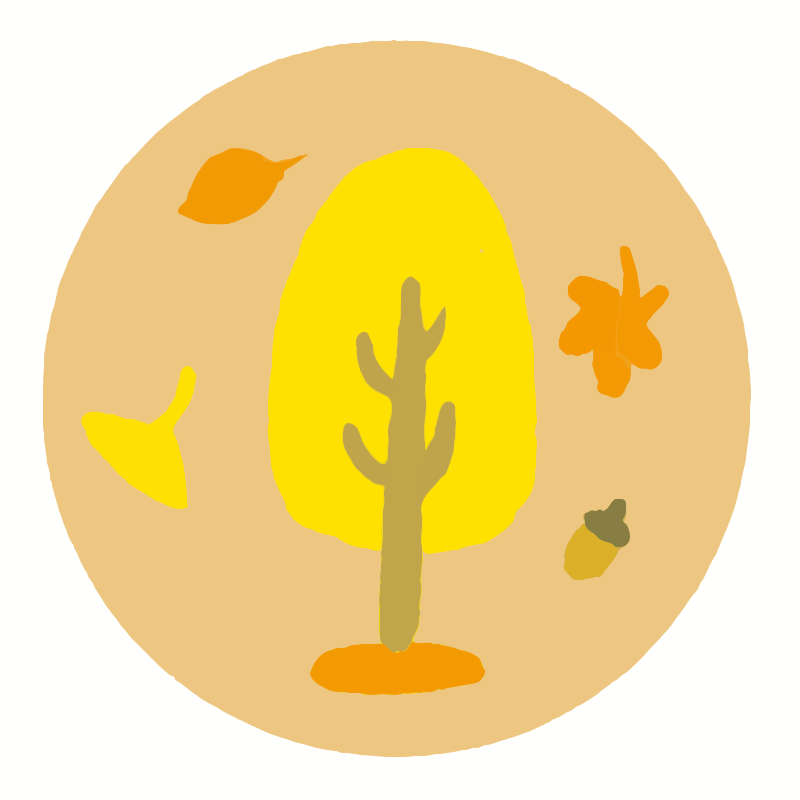

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.9038588541666666
Topic5\dolphin.png 
use_bezier_curve_num : 600 
component_num : 78


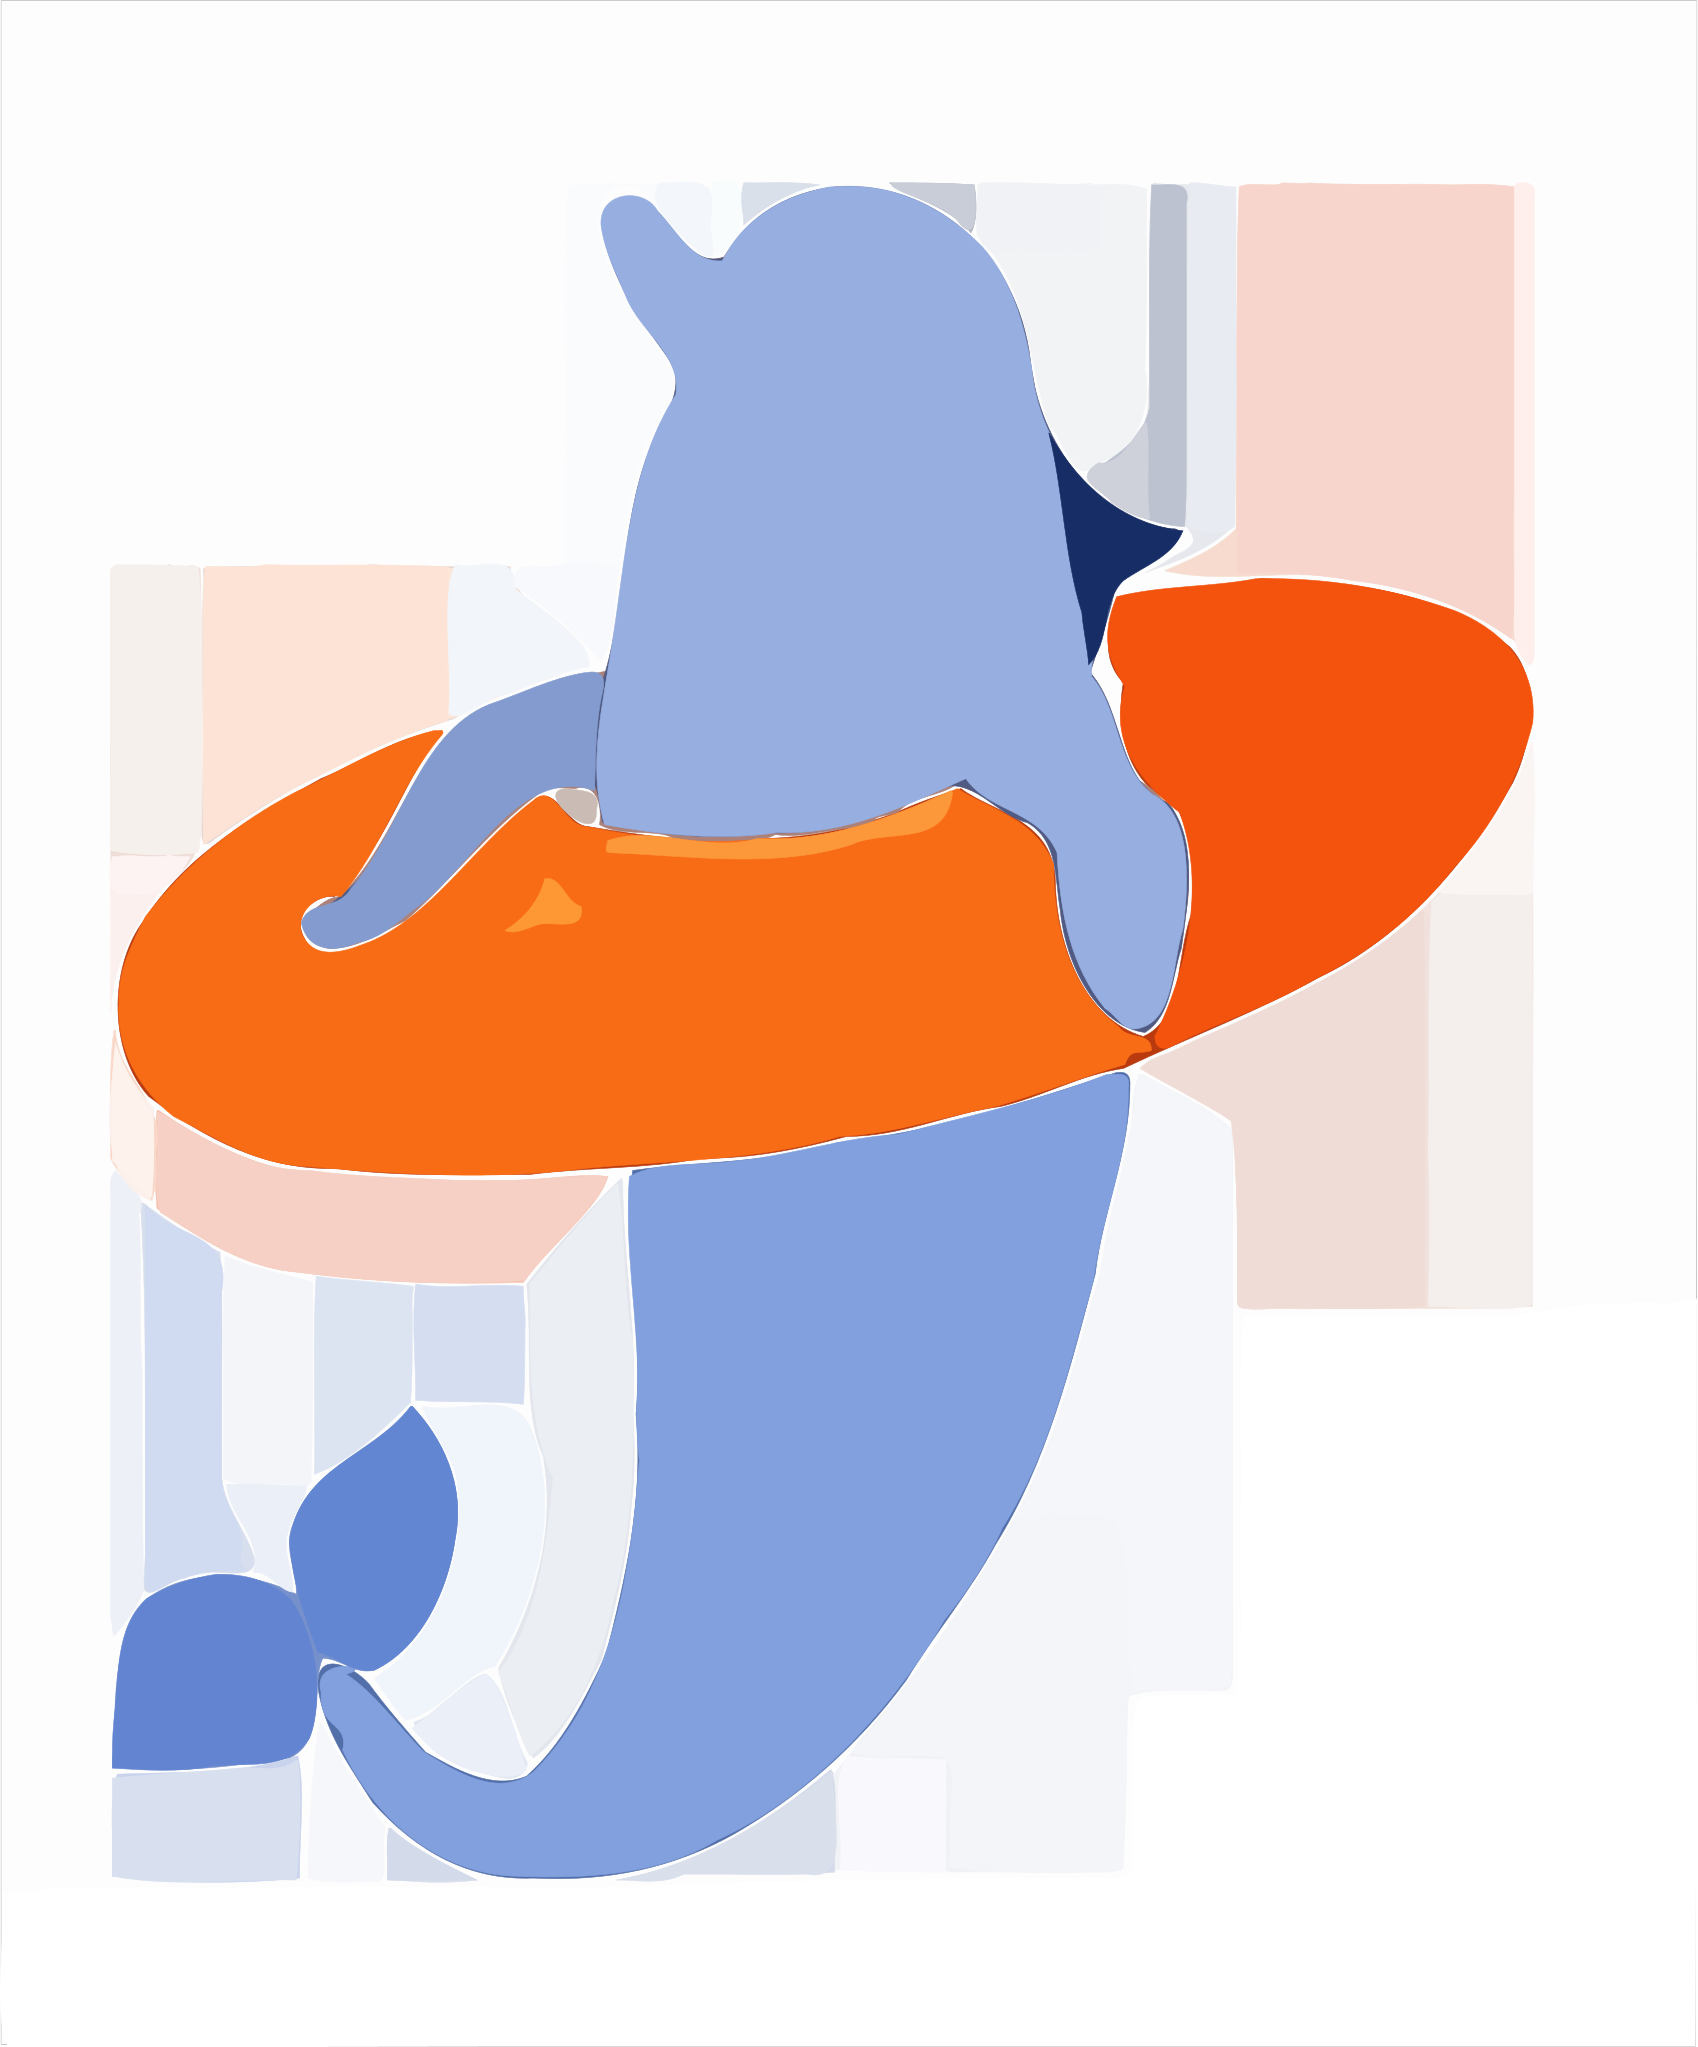

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.32537158716799
Topic5\house.png 
use_bezier_curve_num : 600 
component_num : 57


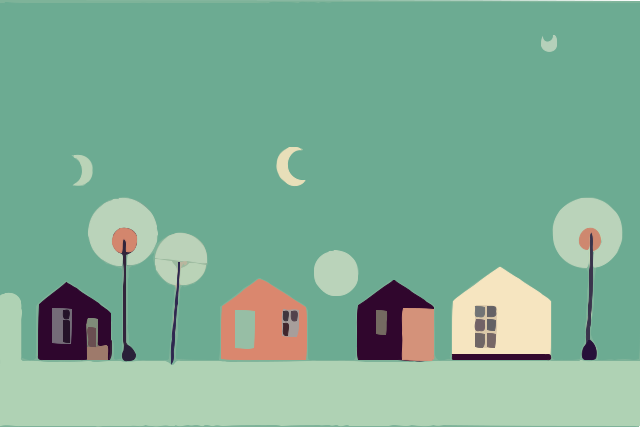

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.3812475604996095
Topic5\meditation.png 
use_bezier_curve_num : 600 
component_num : 60


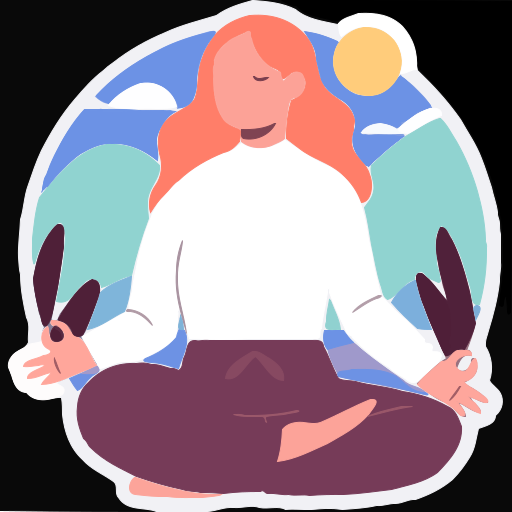

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 30.169007619222004
Topic5\tree.png 
use_bezier_curve_num : 600 
component_num : 200


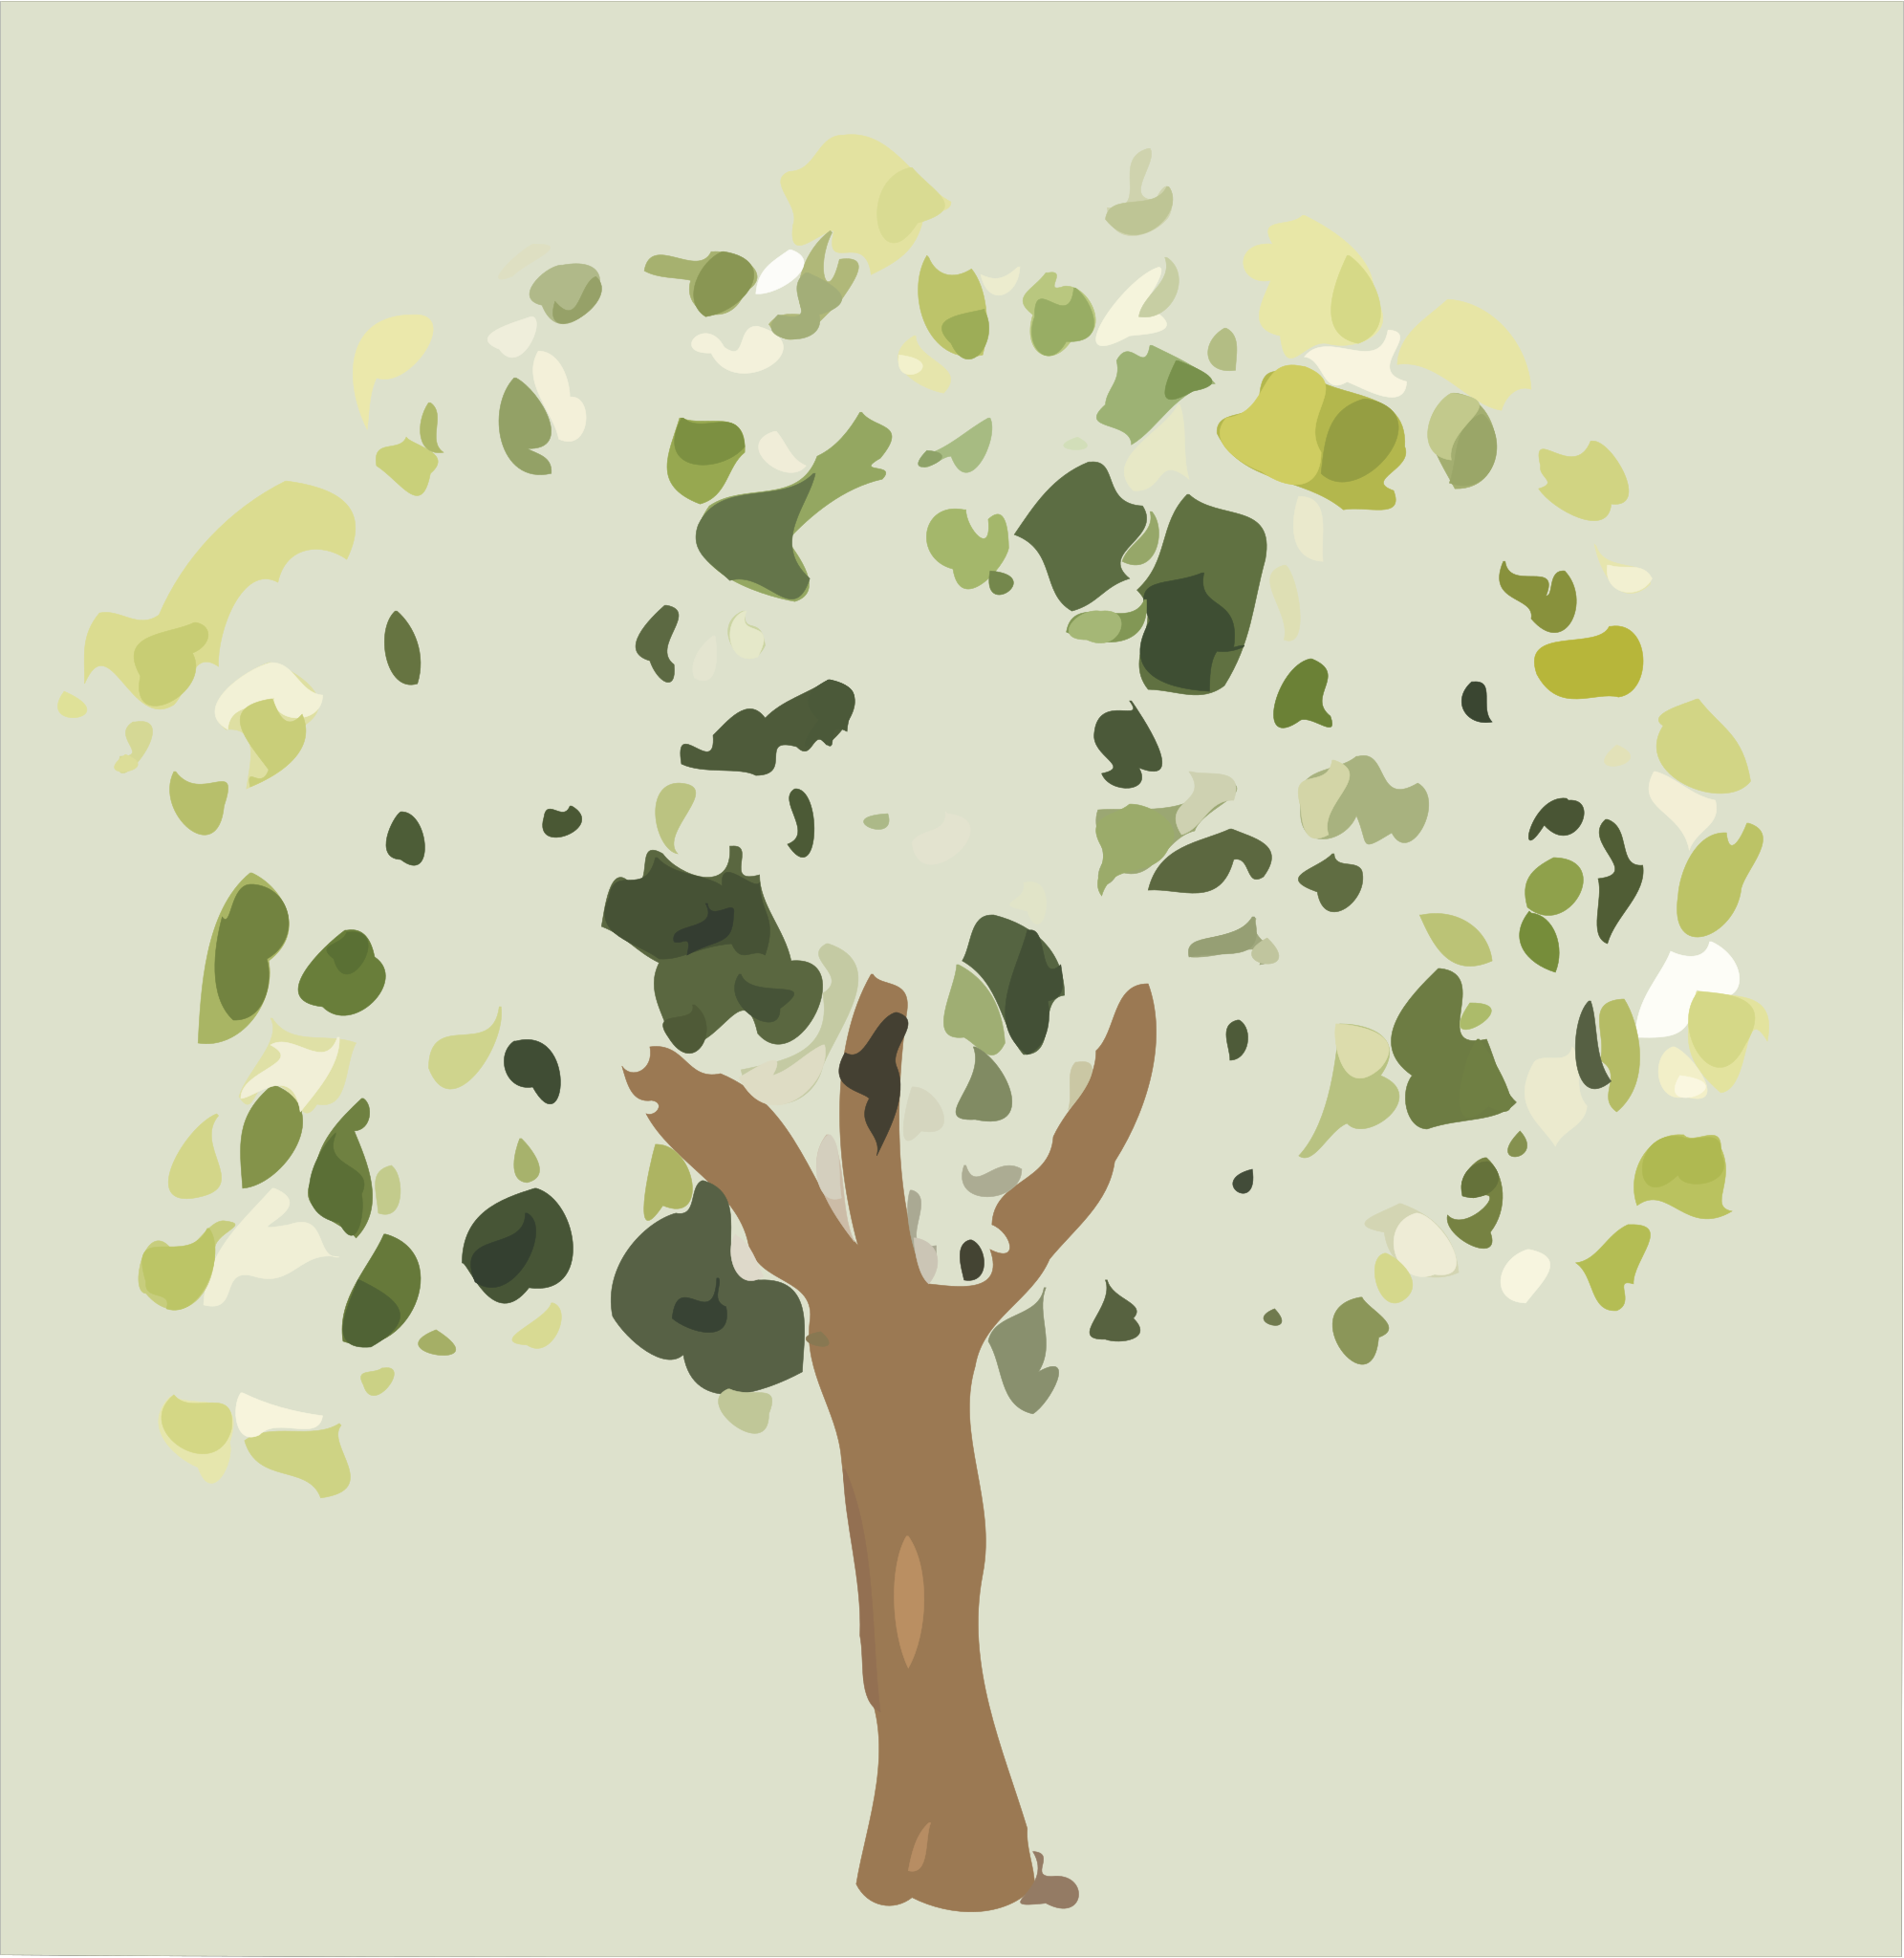

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.66833301576632
Topic5\work-from-home.png 
use_bezier_curve_num : 600 
component_num : 42


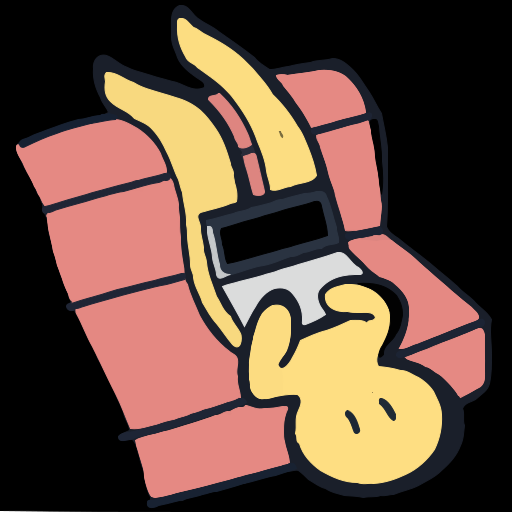

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 13.901849110921225
Topic5 Total MSE: 396.7837598662826
Topic5\fallingwater.jpg 
use_bezier_curve_num : 800 
component_num : 139


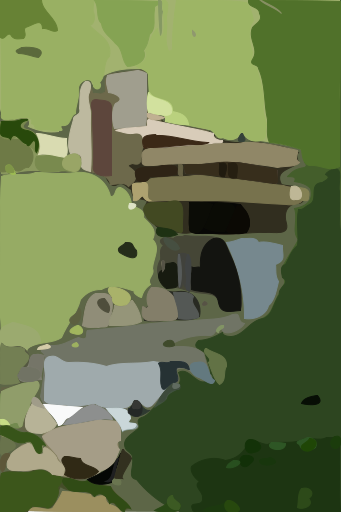

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.20213029997556
Topic5\flower.jpg 
use_bezier_curve_num : 800 
component_num : 177


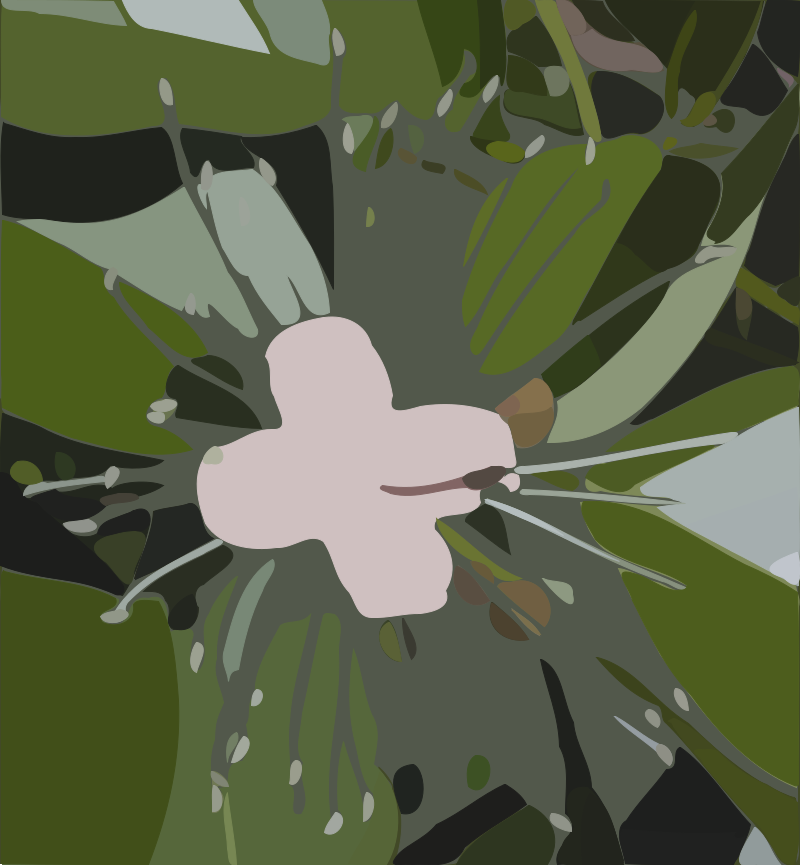

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.77826445086706
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 800 
component_num : 98


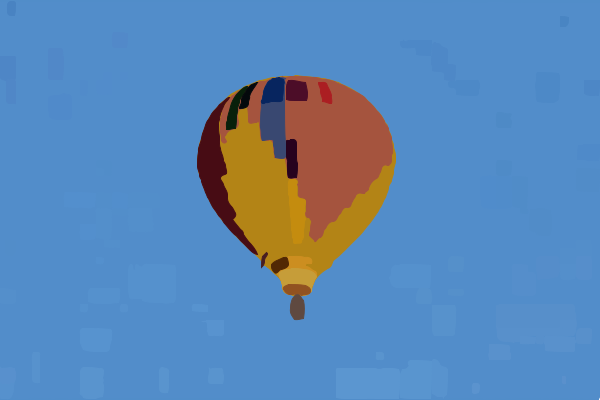

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.117952777777777
Topic5\autumn_01.png 
use_bezier_curve_num : 800 
component_num : 22


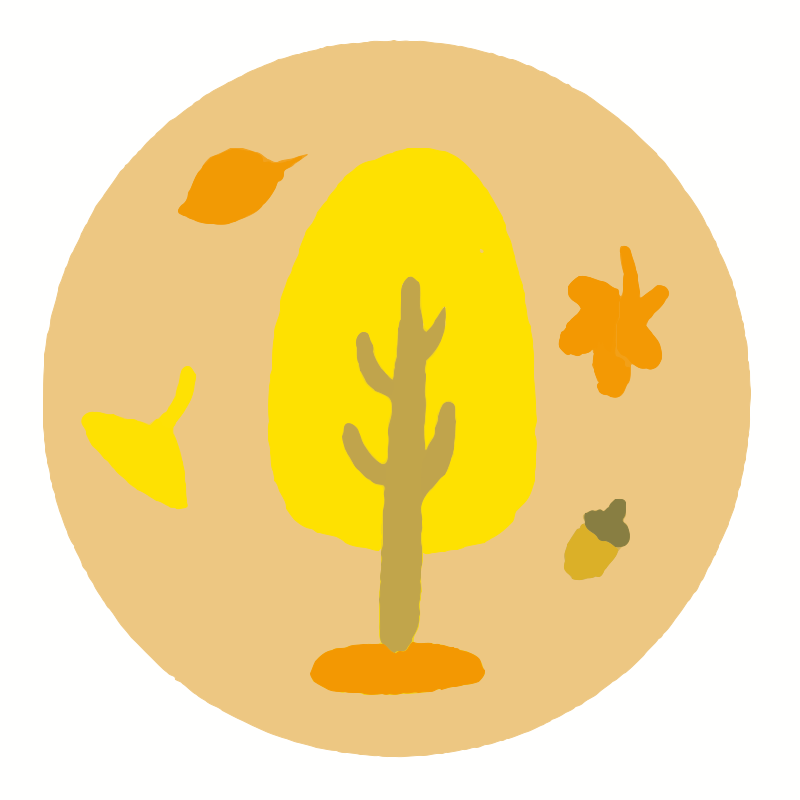

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.8812338541666667
Topic5\dolphin.png 
use_bezier_curve_num : 800 
component_num : 78


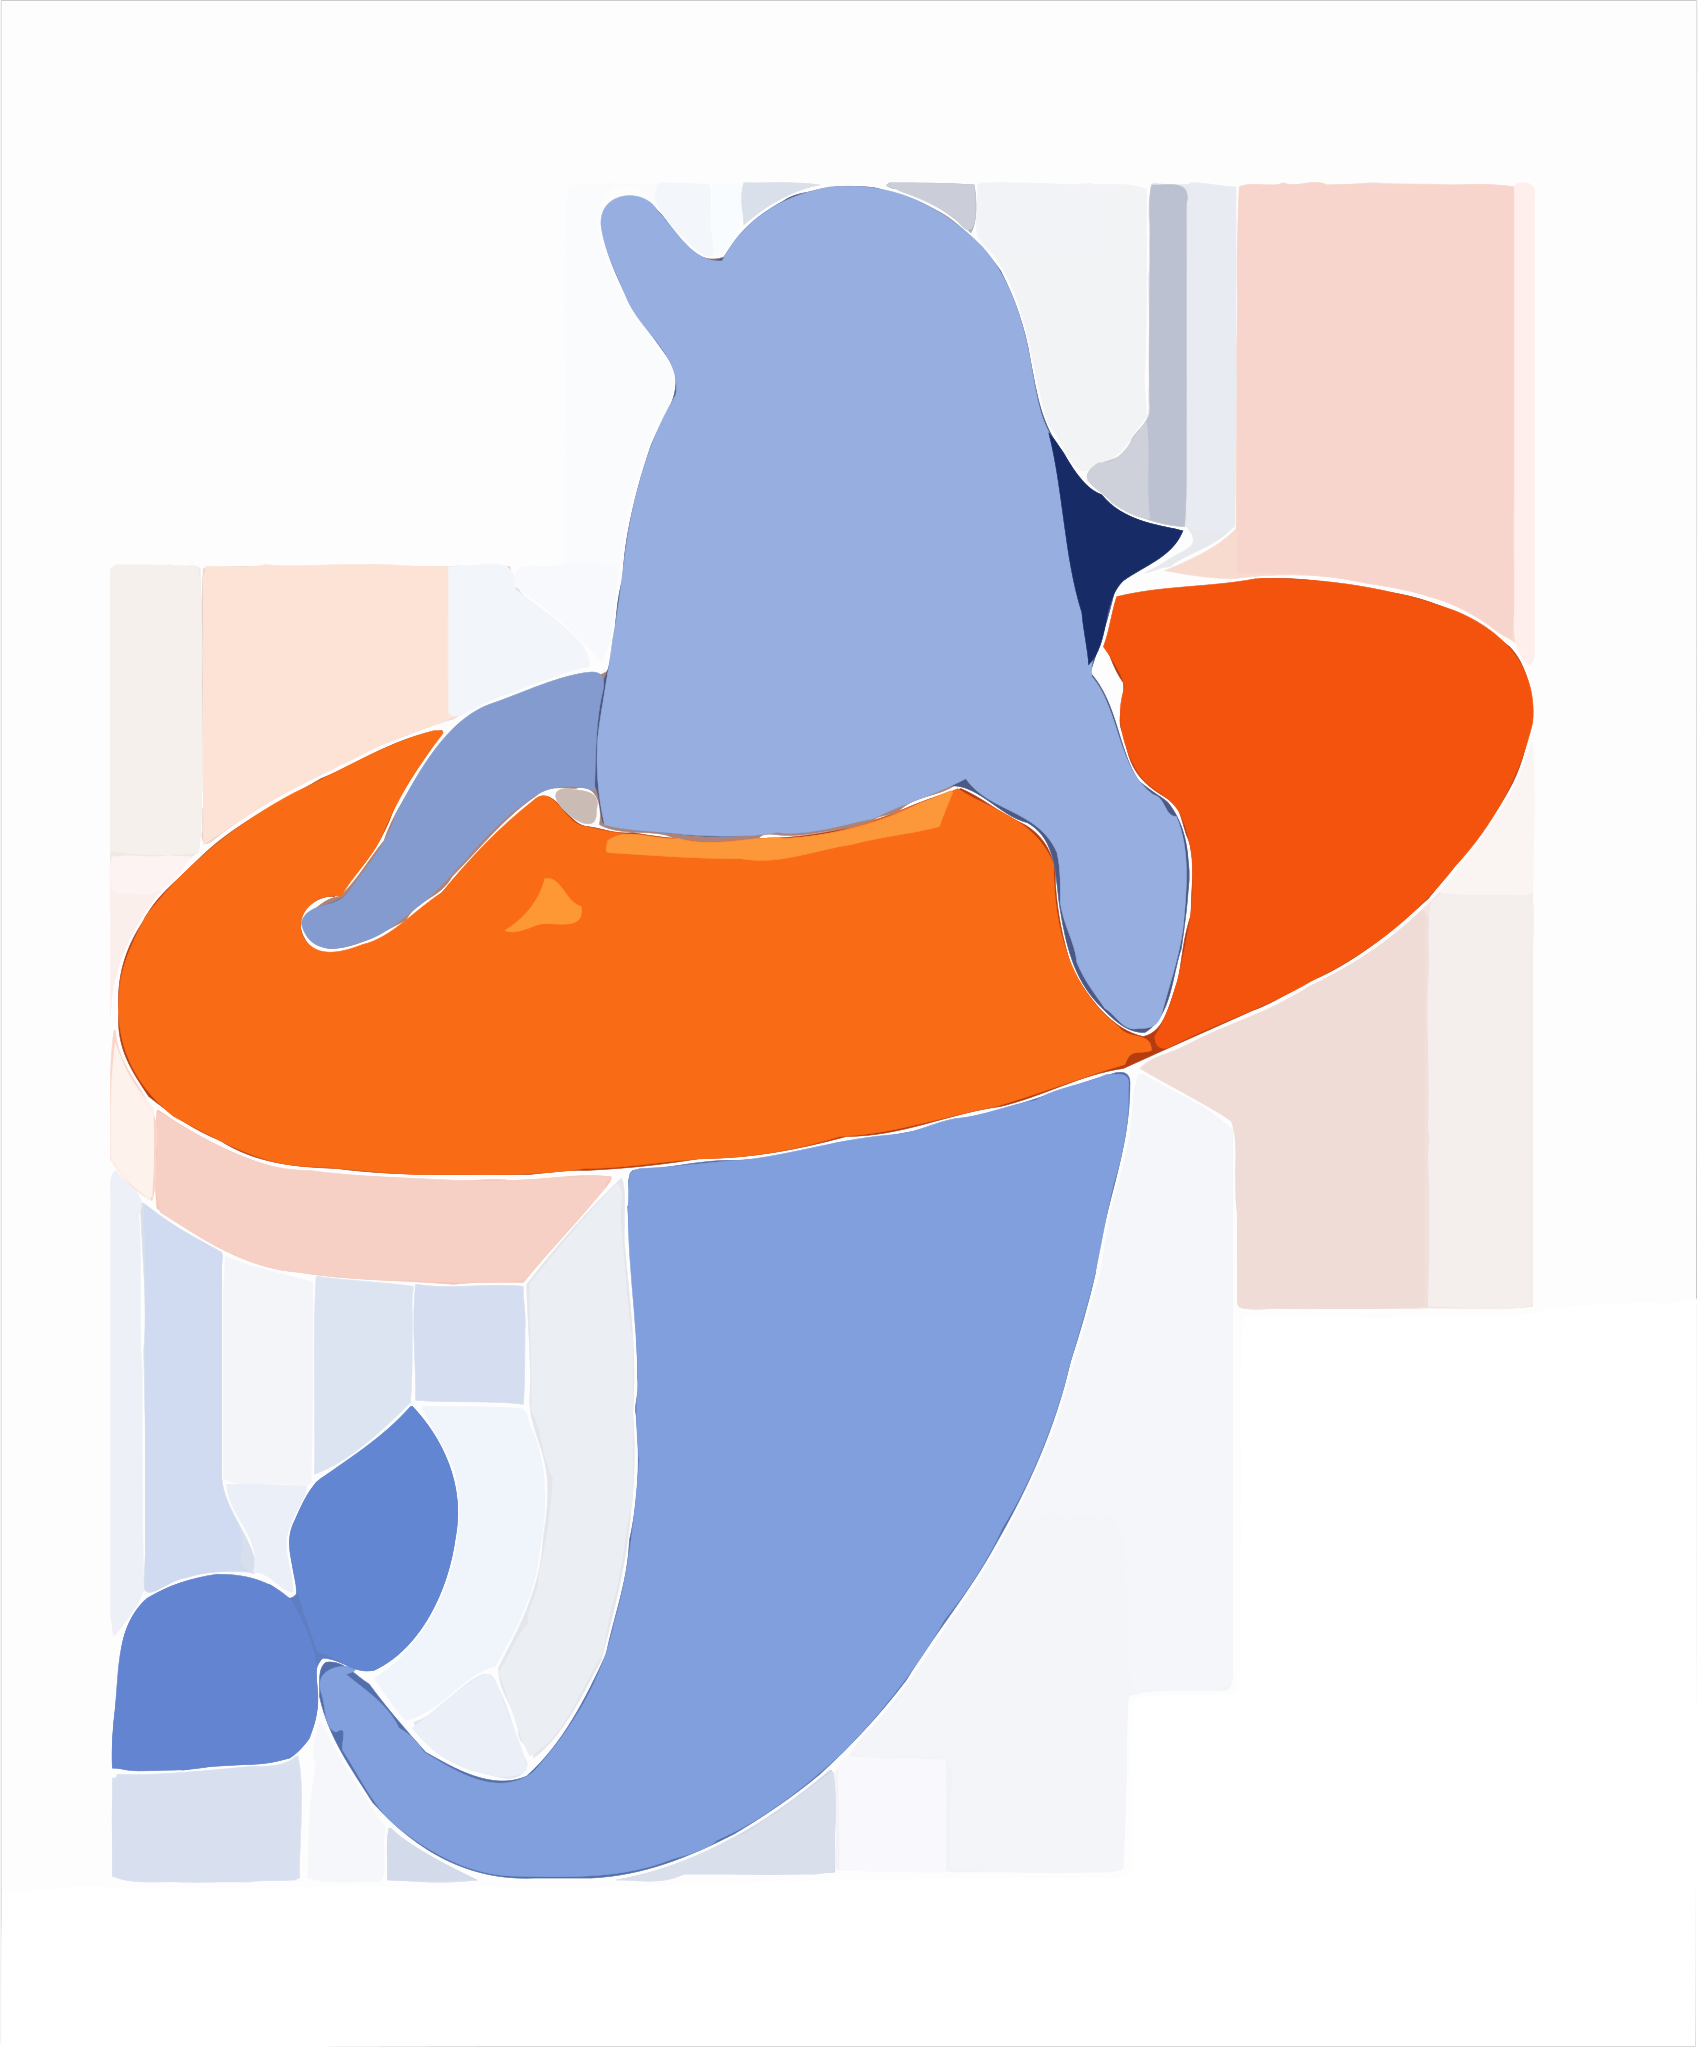

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.144291458686276
Topic5\house.png 
use_bezier_curve_num : 800 
component_num : 57


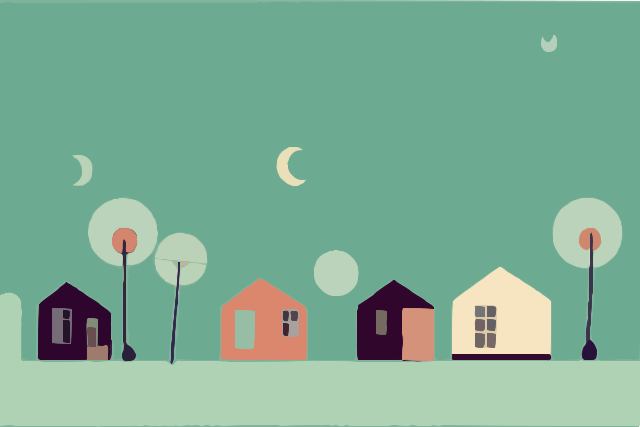

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.39245218579235
Topic5\meditation.png 
use_bezier_curve_num : 800 
component_num : 60


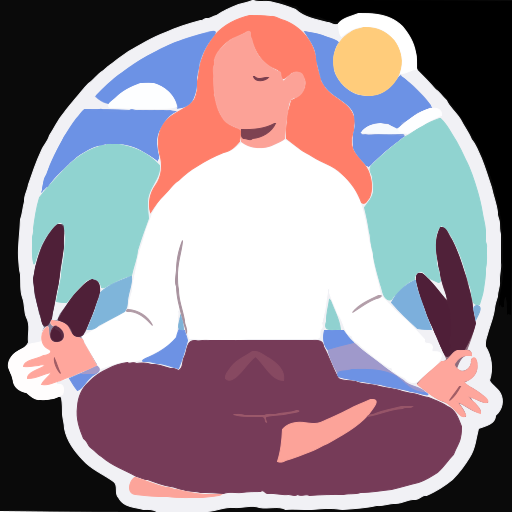

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 33.002079010009766
Topic5\tree.png 
use_bezier_curve_num : 800 
component_num : 200


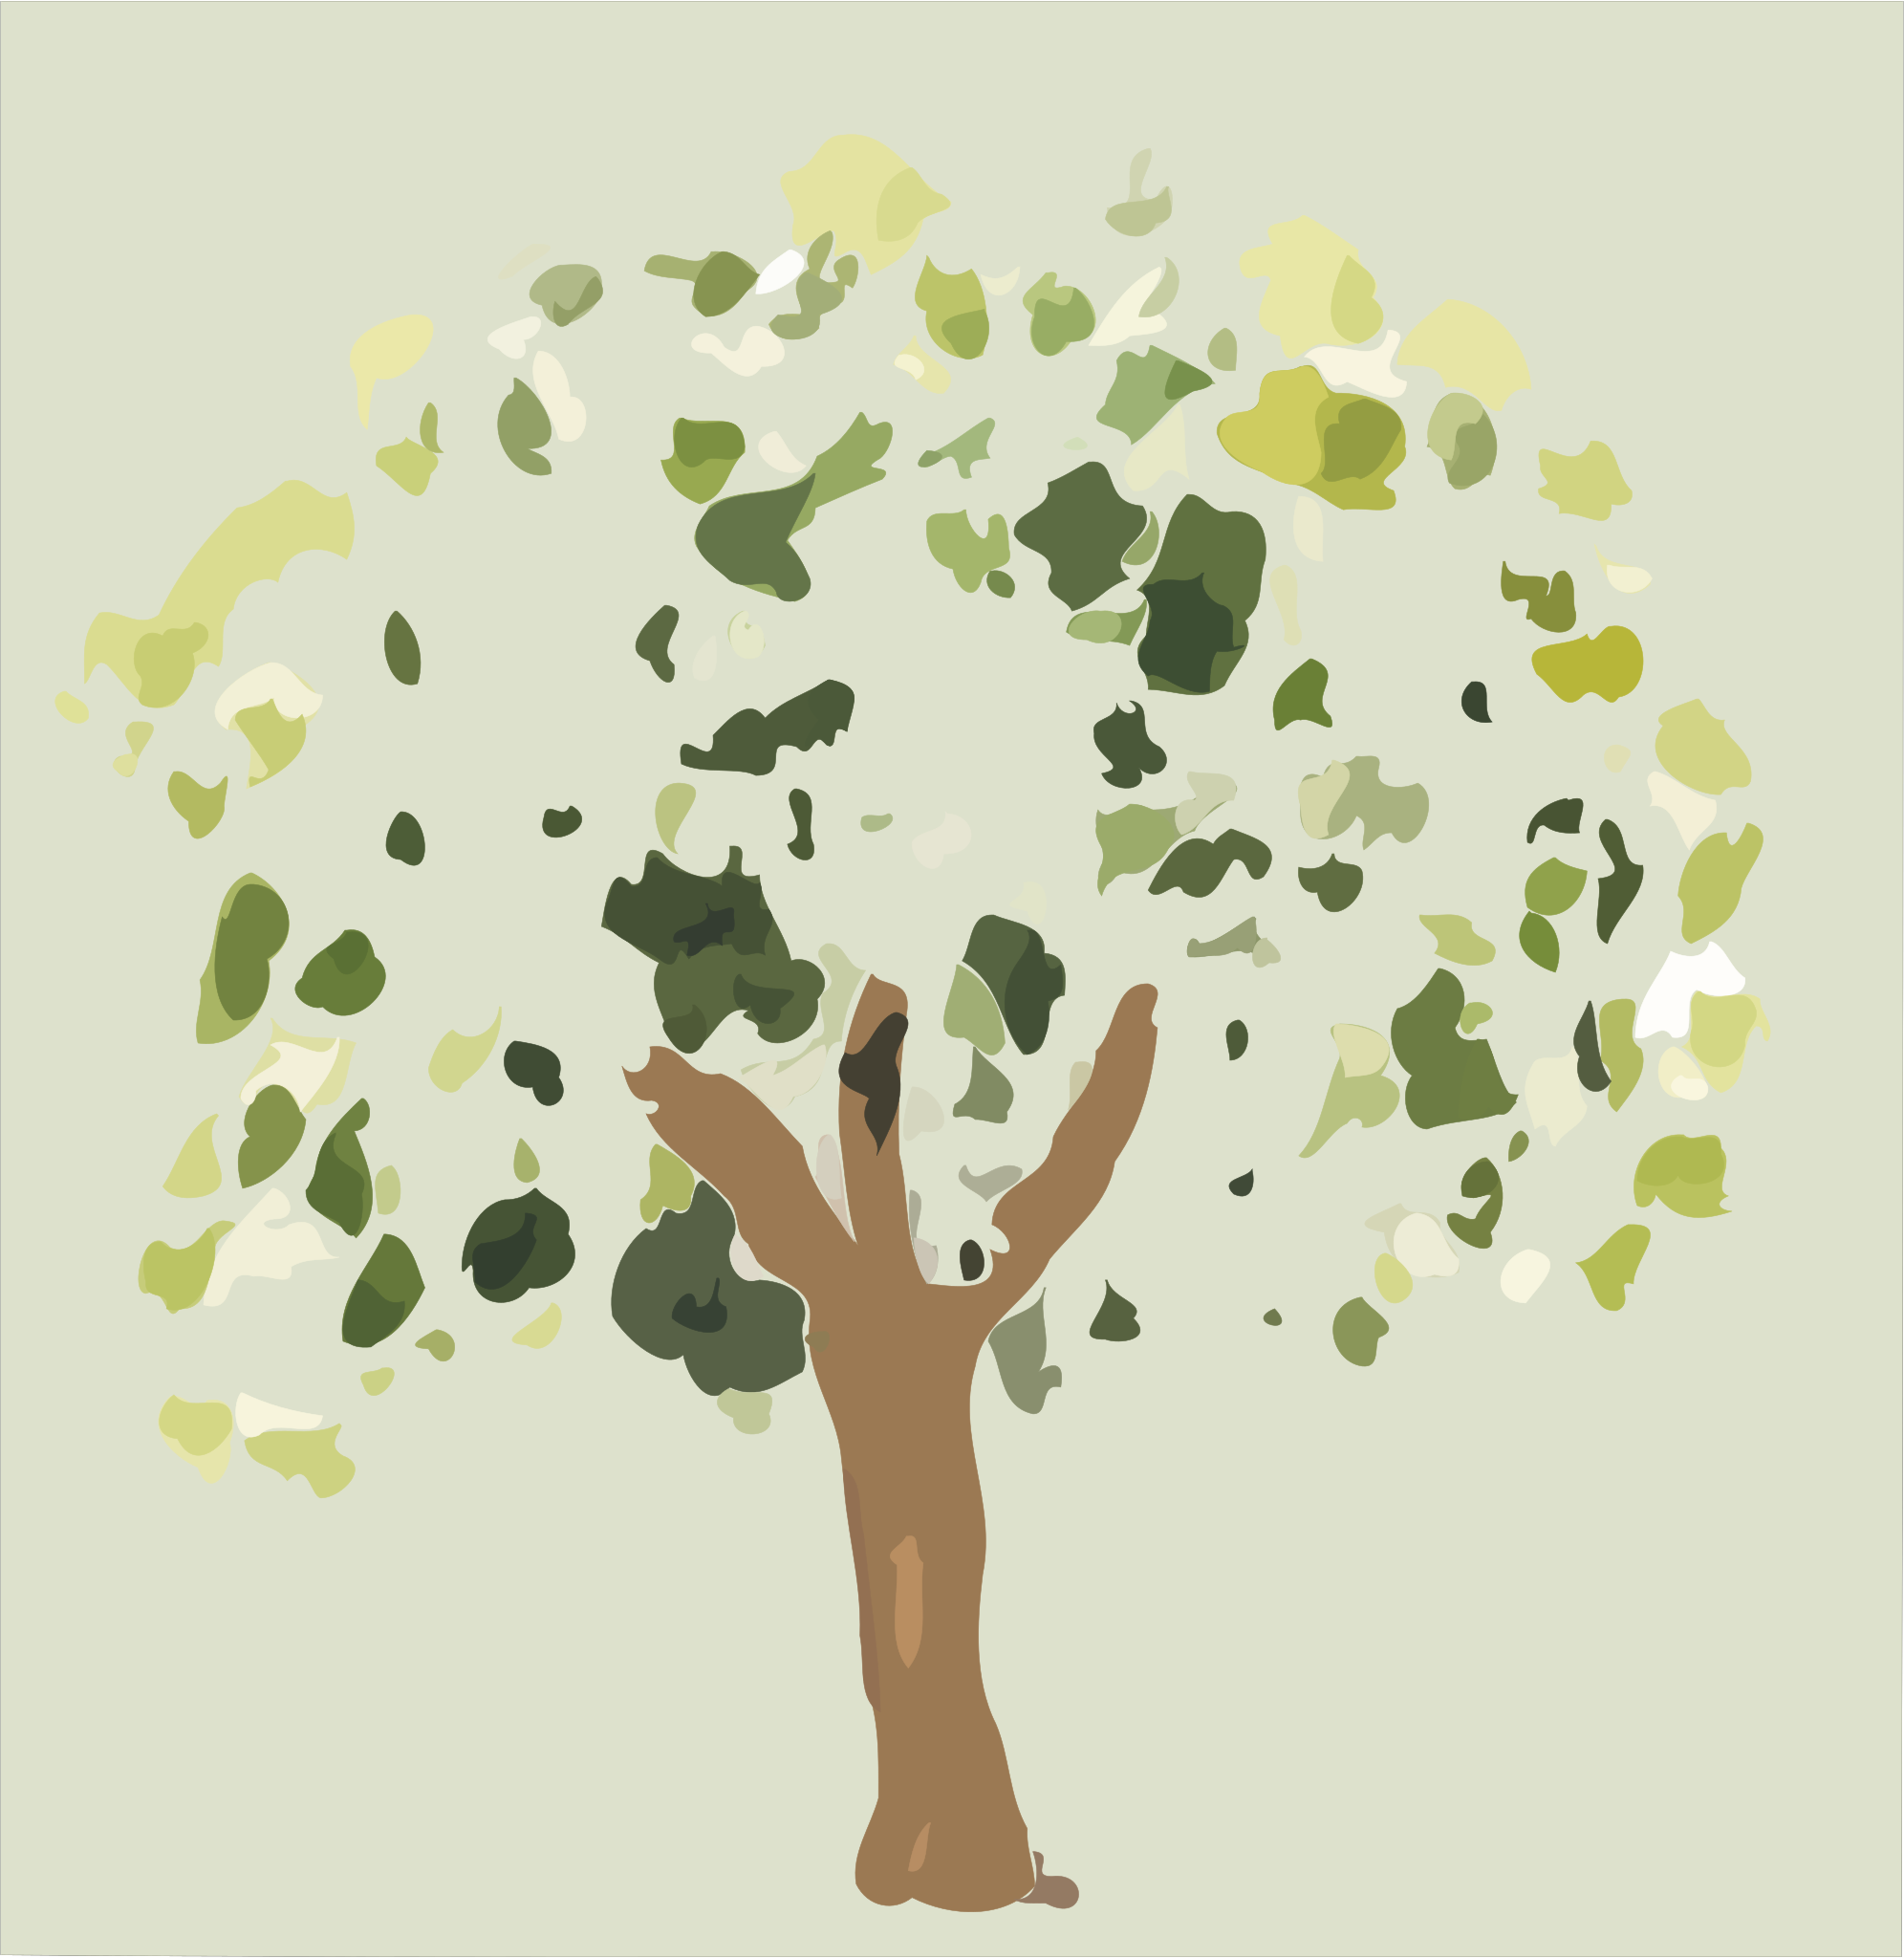

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.2786990678637
Topic5\work-from-home.png 
use_bezier_curve_num : 800 
component_num : 42


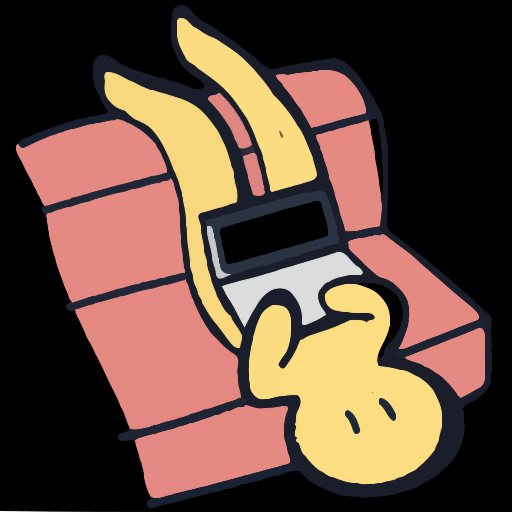

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 13.10528310139974
Topic5 Total MSE: 397.9023862065389
Topic5\fallingwater.jpg 
use_bezier_curve_num : 1000 
component_num : 139


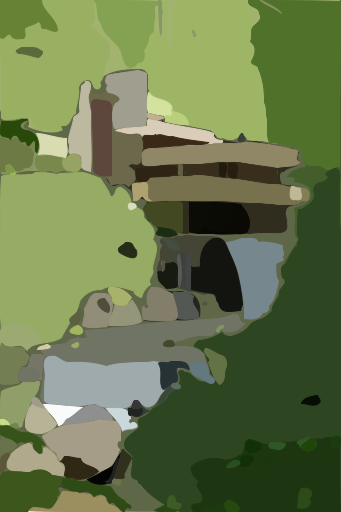

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.05104472140762
Topic5\flower.jpg 
use_bezier_curve_num : 1000 
component_num : 177


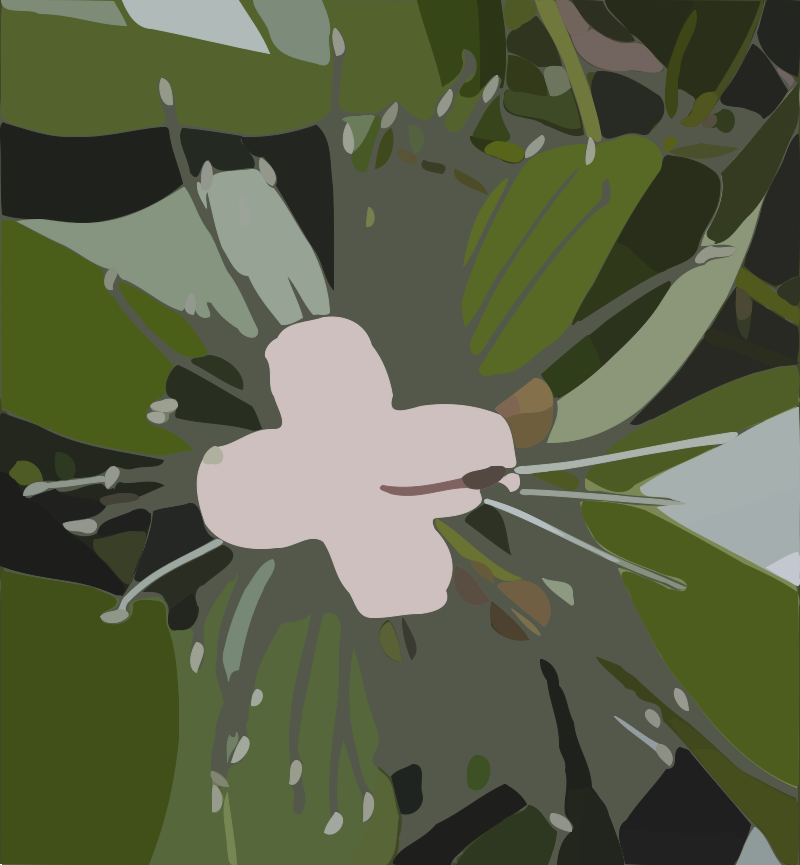

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.73476059730251
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 813 
component_num : 98


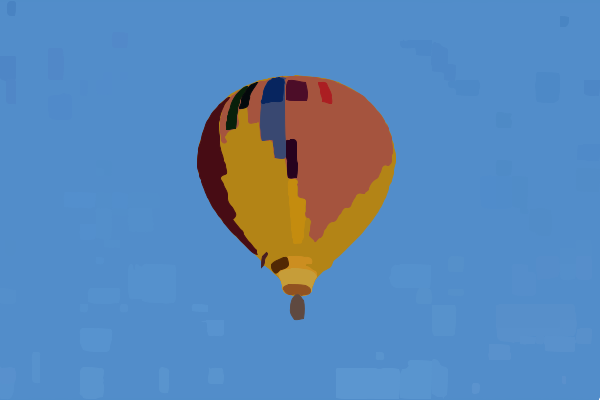

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.116870833333333
Topic5\autumn_01.png 
use_bezier_curve_num : 1000 
component_num : 22


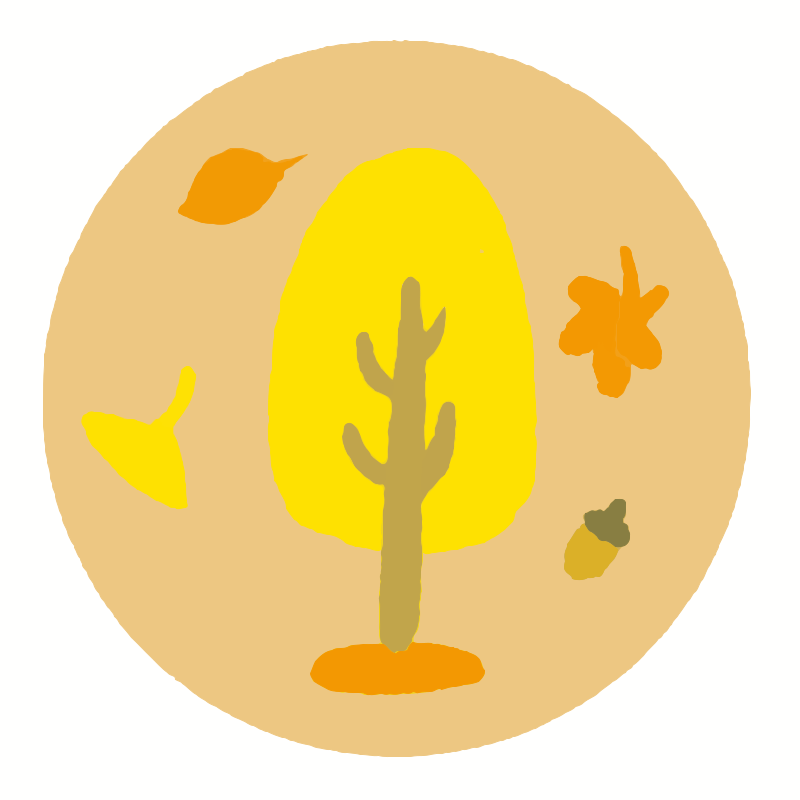

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.8460651041666667
Topic5\dolphin.png 
use_bezier_curve_num : 1000 
component_num : 78


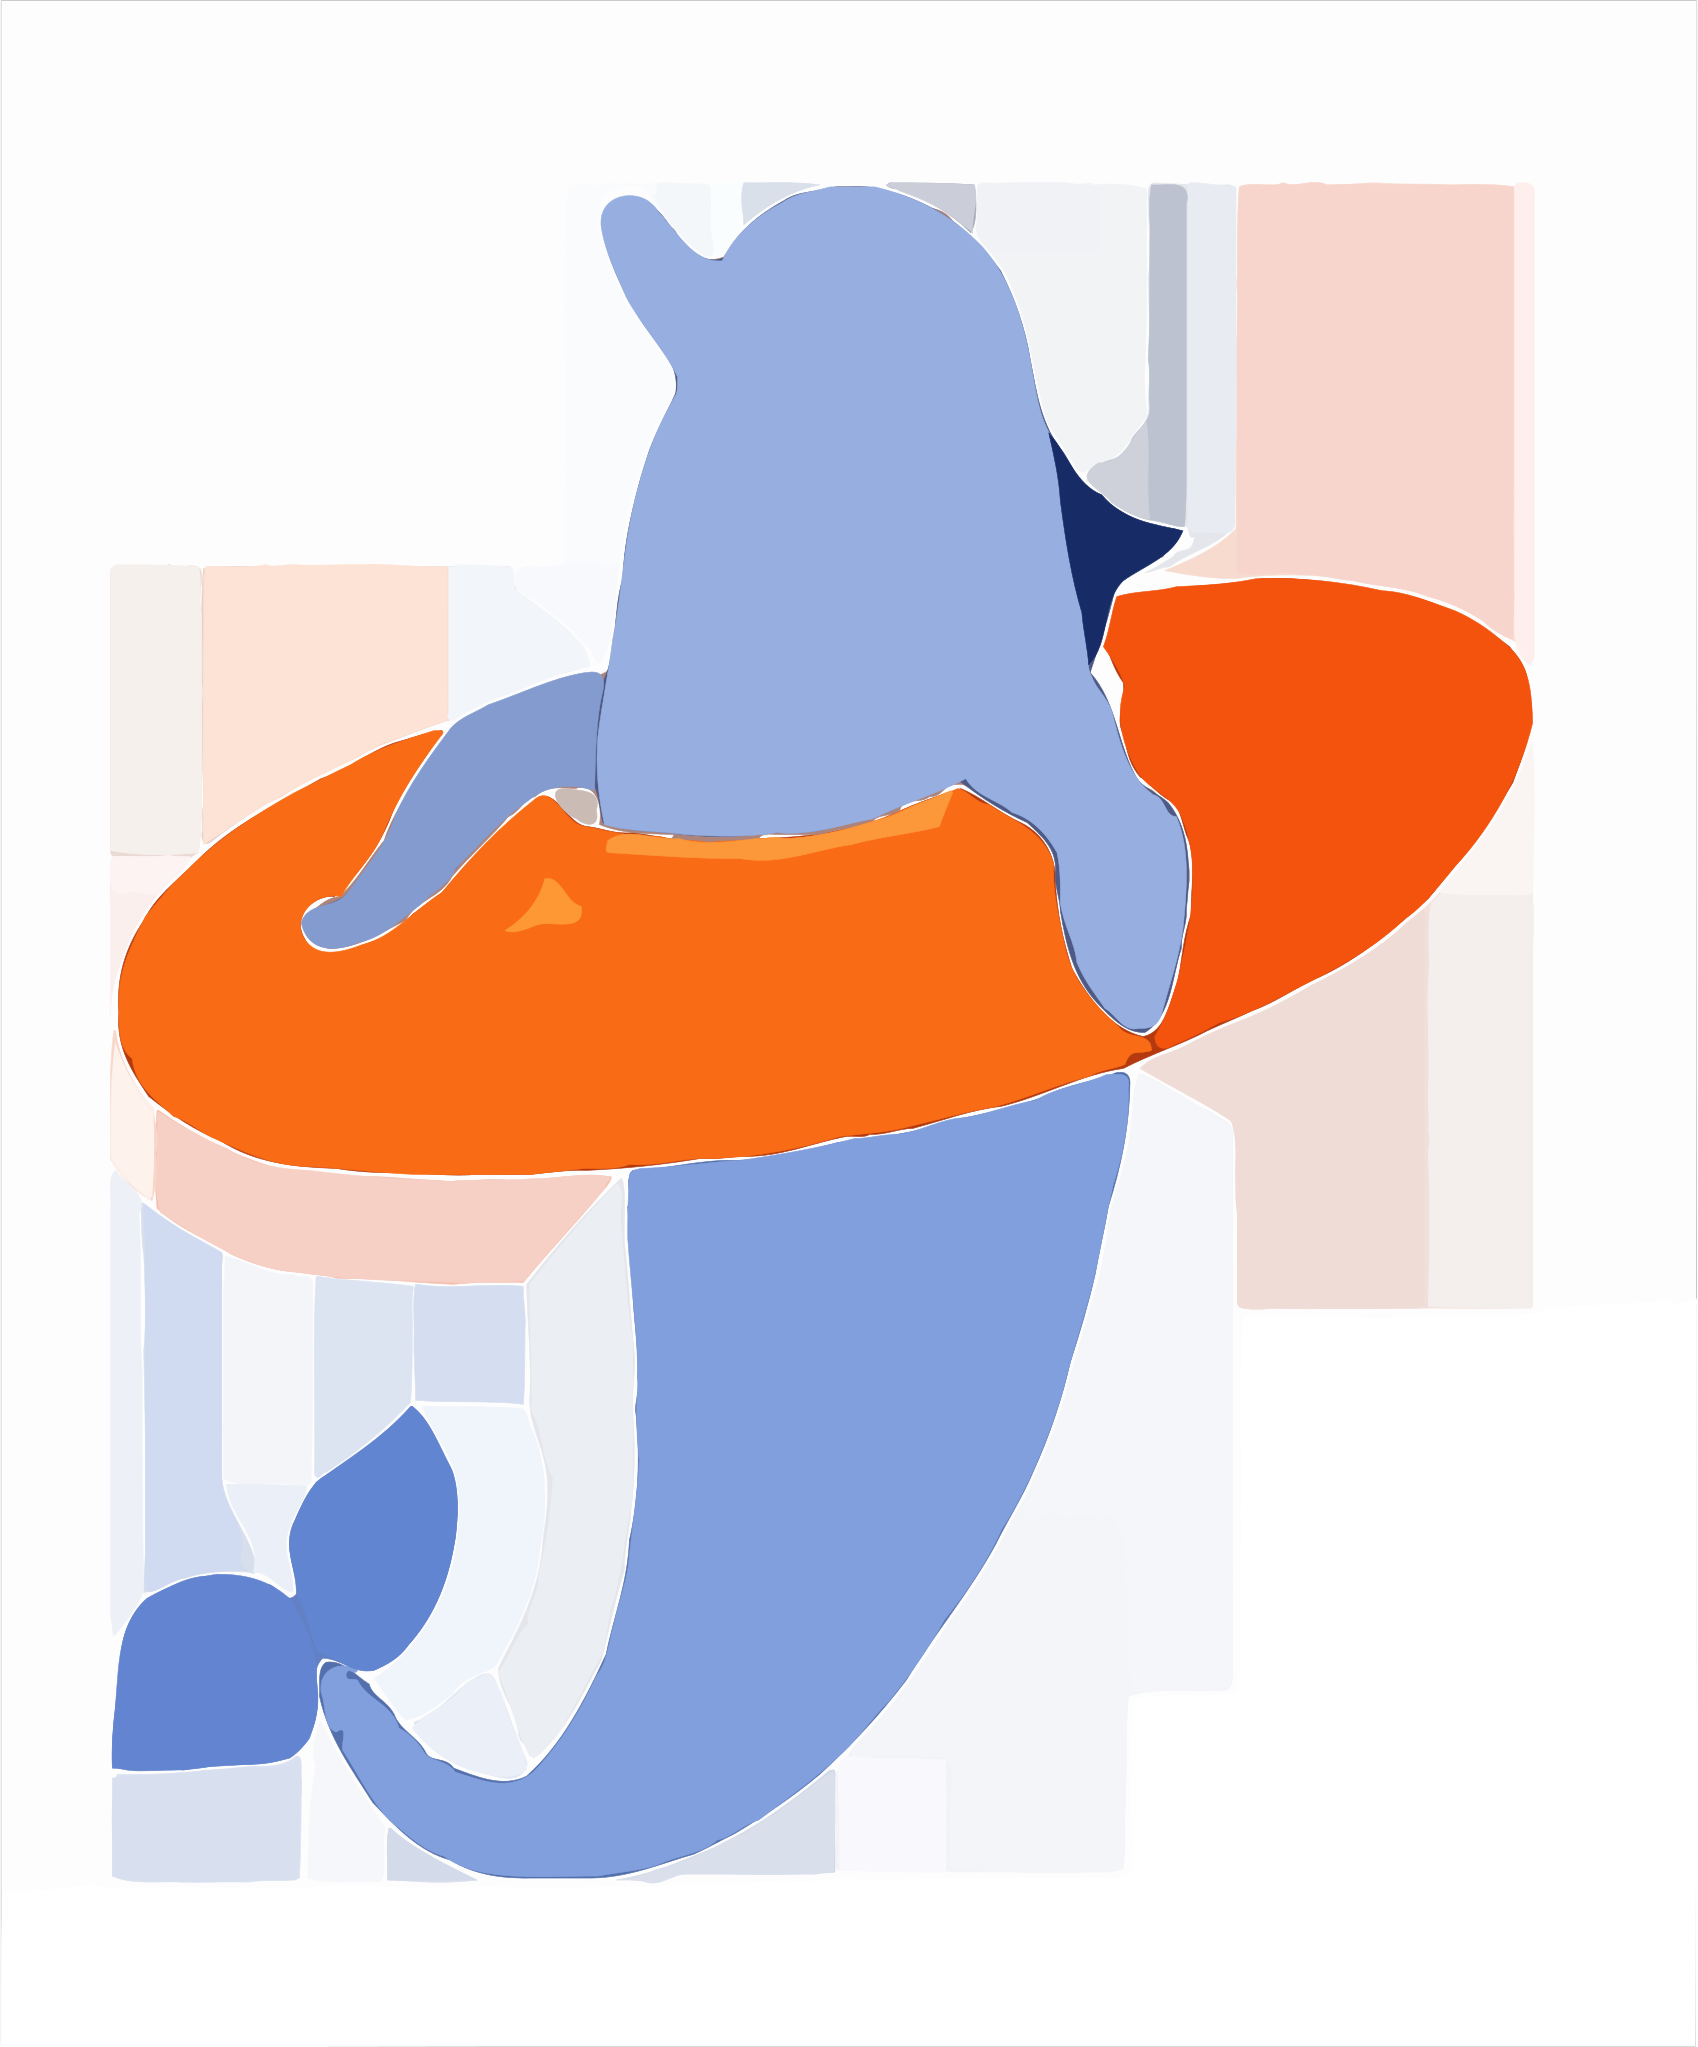

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.1540772658144
Topic5\house.png 
use_bezier_curve_num : 855 
component_num : 57


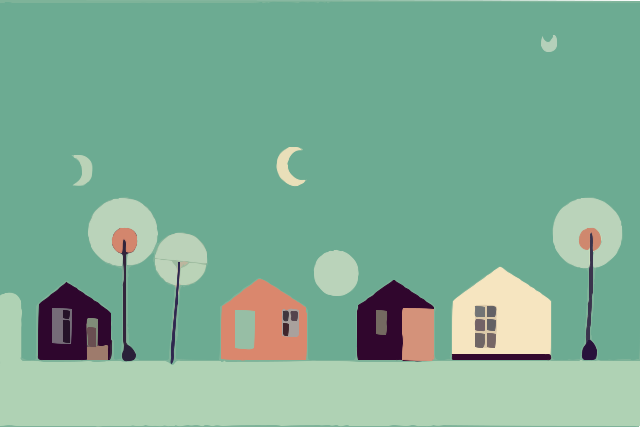

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.395144174473068
Topic5\meditation.png 
use_bezier_curve_num : 1000 
component_num : 60


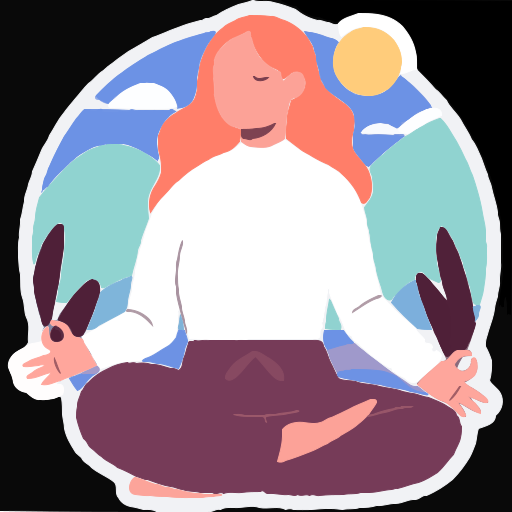

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 29.44830830891927
Topic5\tree.png 
use_bezier_curve_num : 1000 
component_num : 200


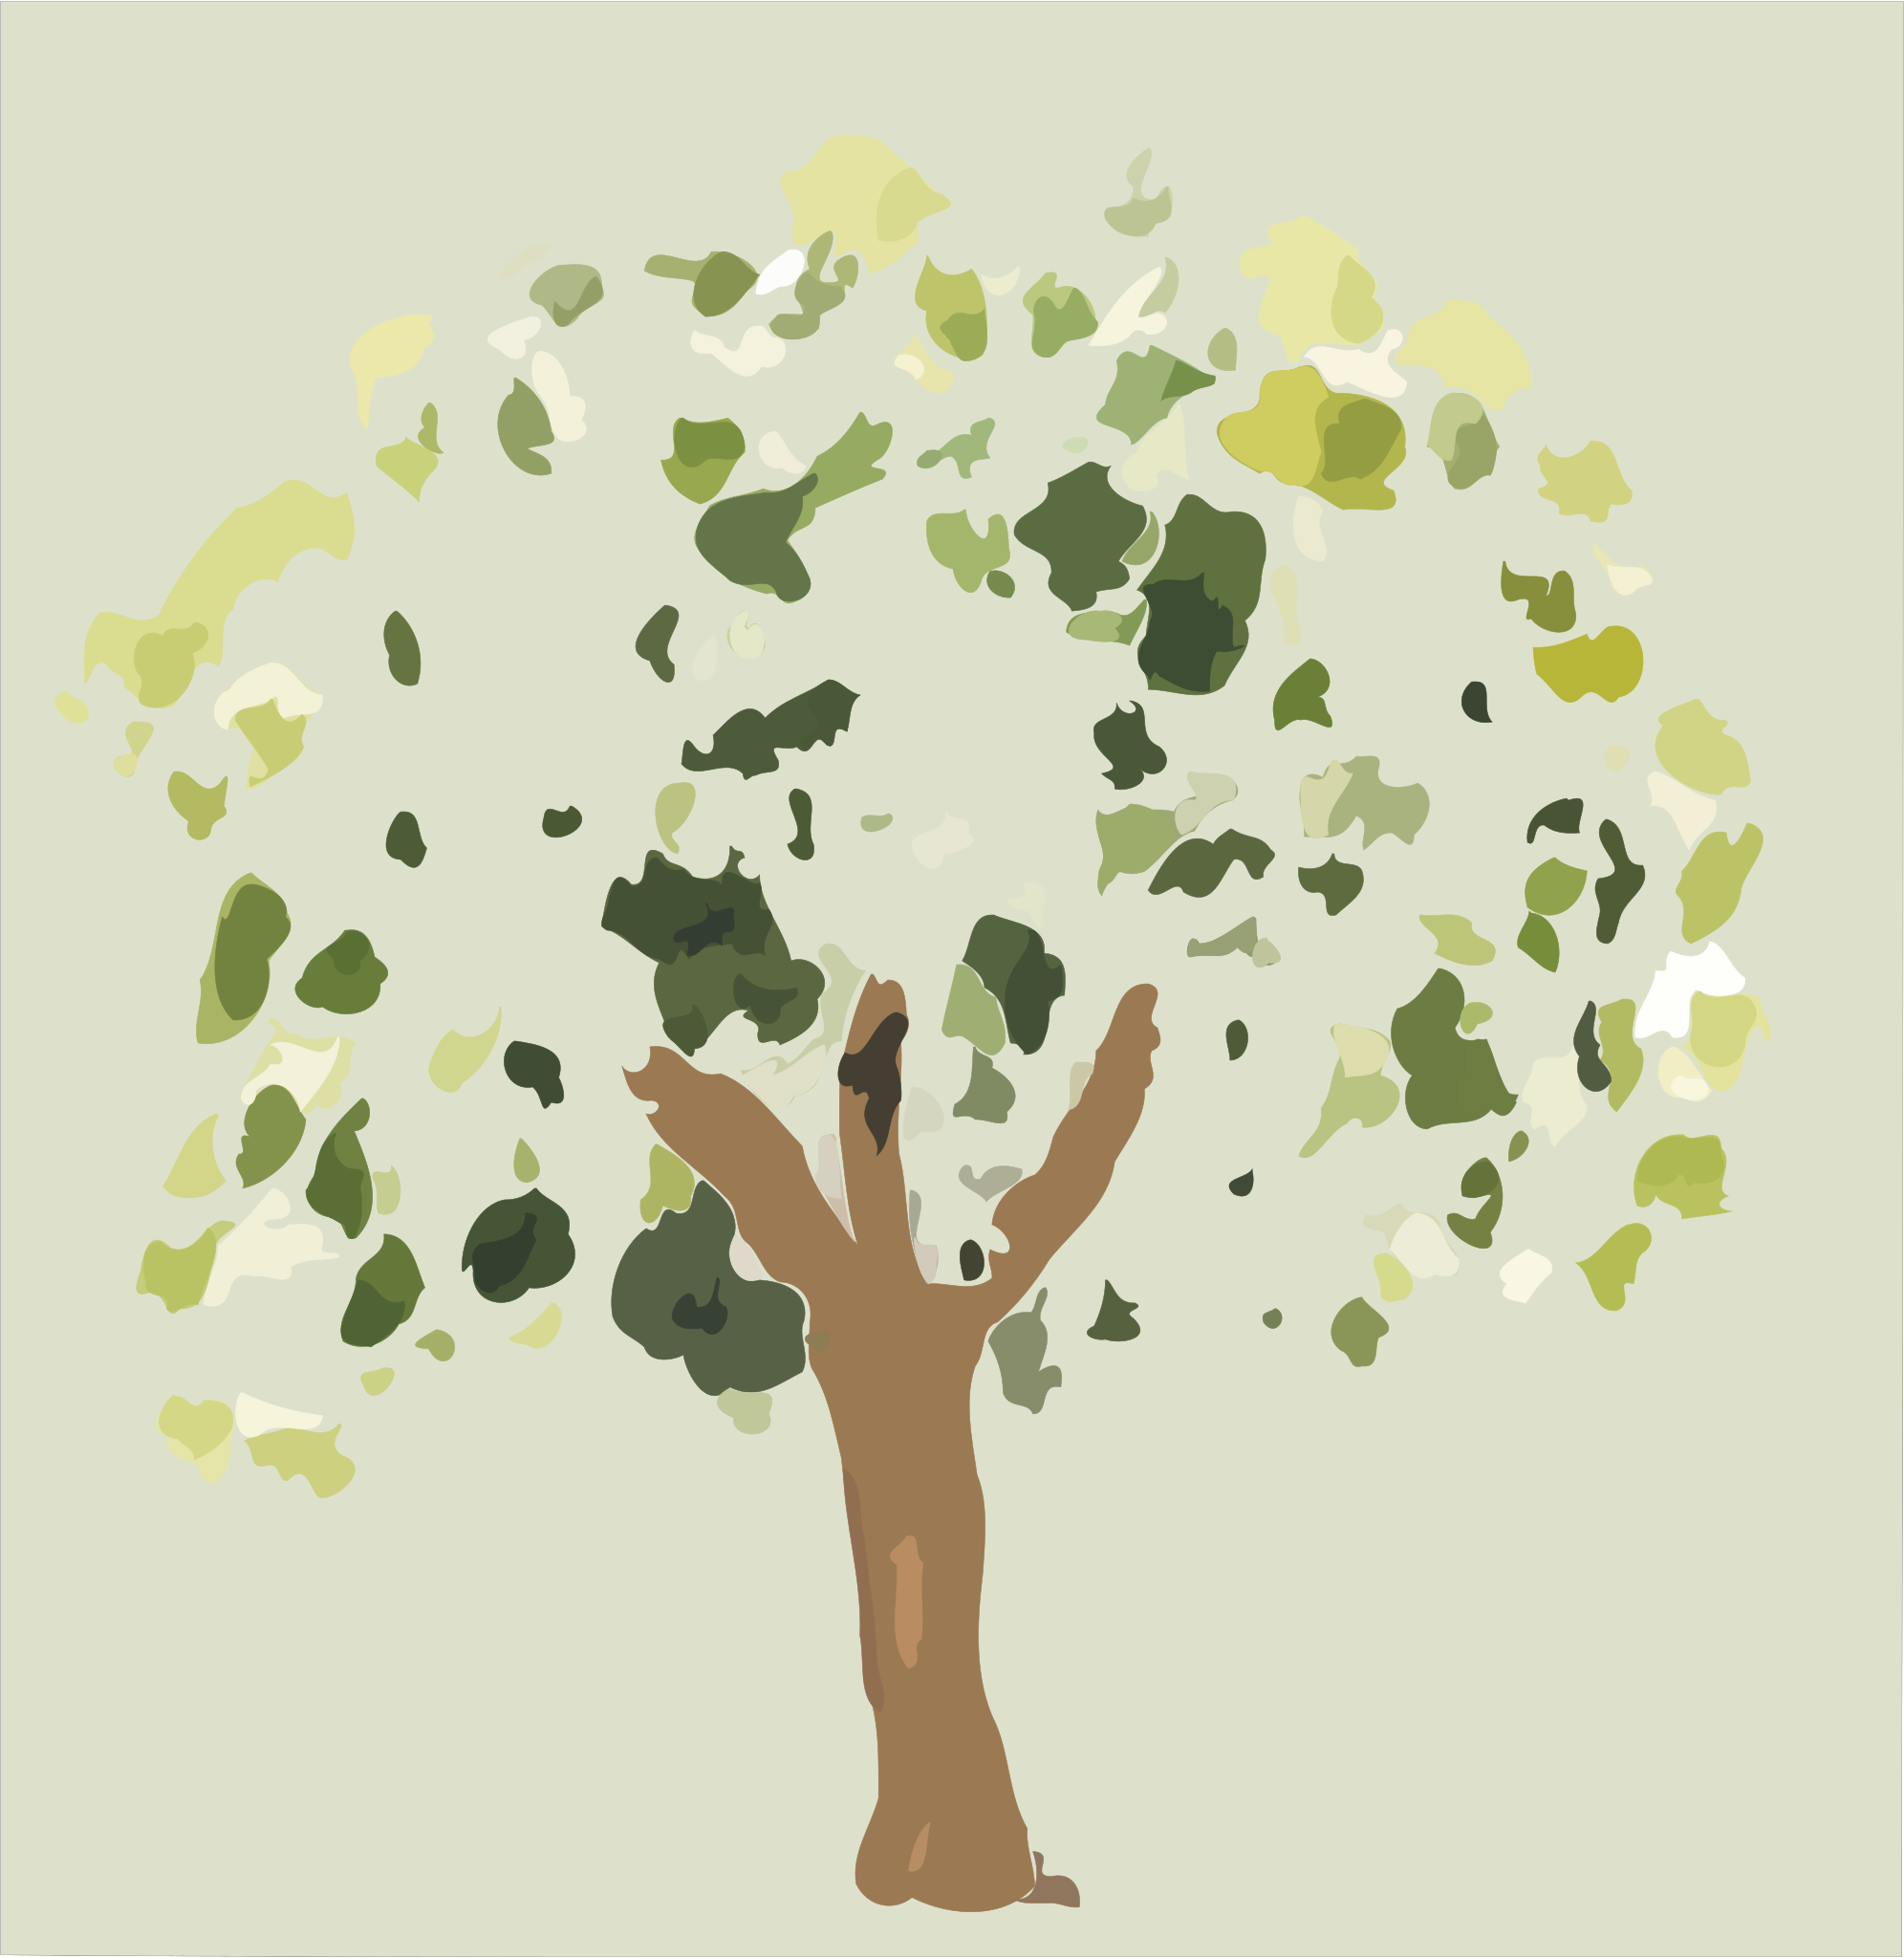

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.04508462123512
Topic5\work-from-home.png 
use_bezier_curve_num : 1000 
component_num : 42


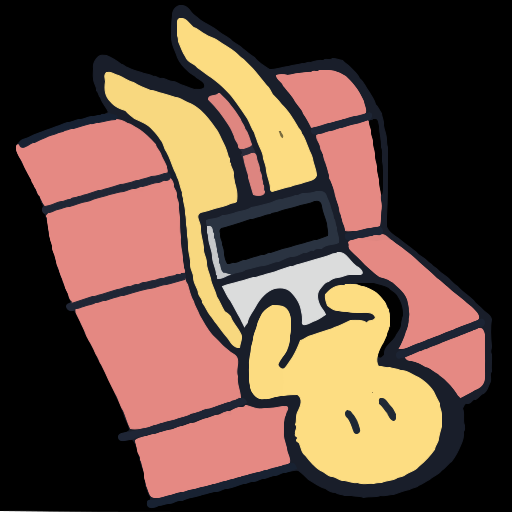

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 13.07657241821289
Topic5 Total MSE: 393.8679280448648
1275.0191214084625


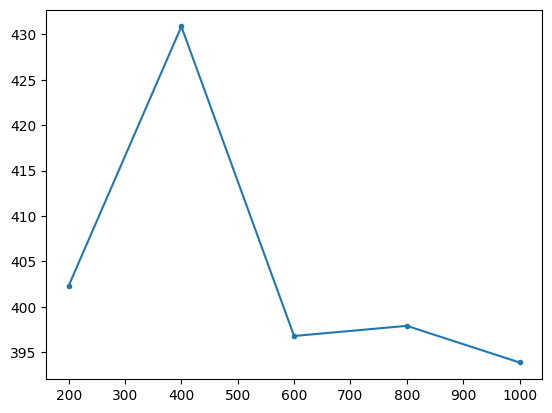

In [110]:
Test(V21=True,V23=True,V31=True,labelname="V23")

Topic5\fallingwater.jpg 
use_bezier_curve_num : 200 
component_num : 139


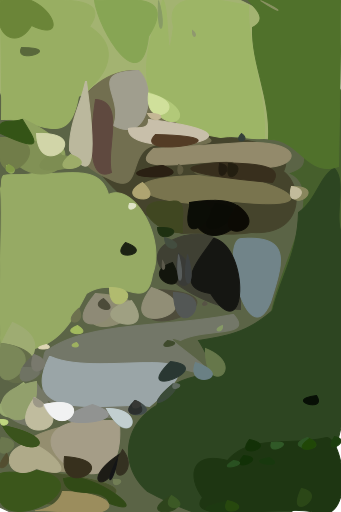

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 98.40440379093353
Topic5\flower.jpg 
use_bezier_curve_num : 200 
component_num : 177


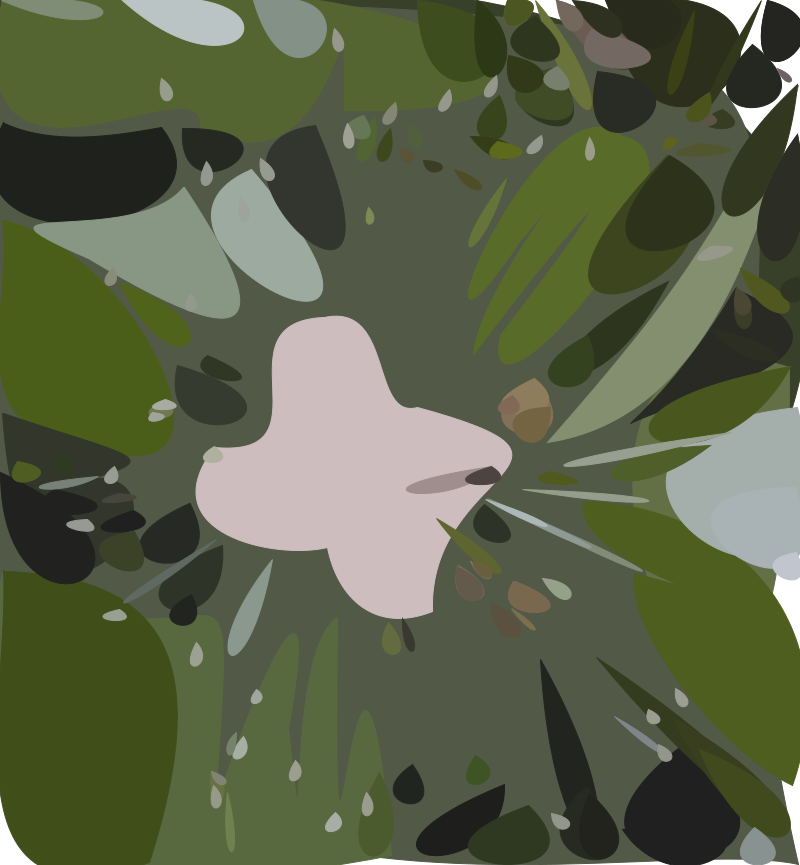

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 86.04514691714836
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 200 
component_num : 98


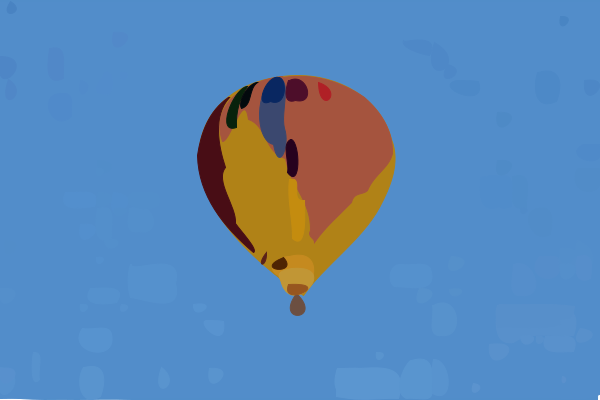

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 26.651341666666667
Topic5\autumn_01.png 
use_bezier_curve_num : 200 
component_num : 22


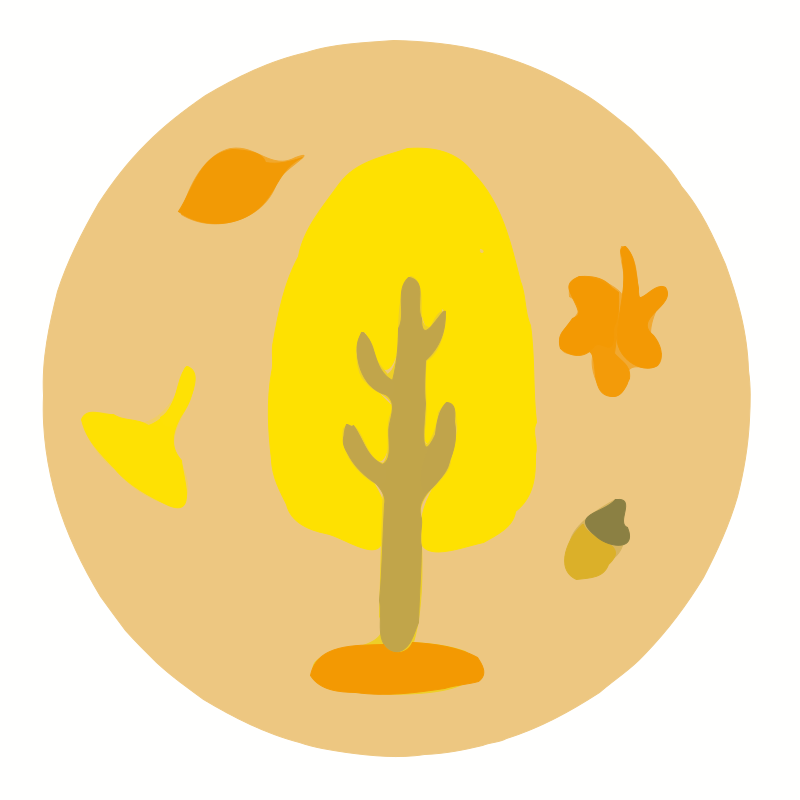

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 2.411341145833333
Topic5\dolphin.png 
use_bezier_curve_num : 200 
component_num : 78


C:\Users\a5658\AppData\Local\Temp\ipykernel_20316\263822590.py:178: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


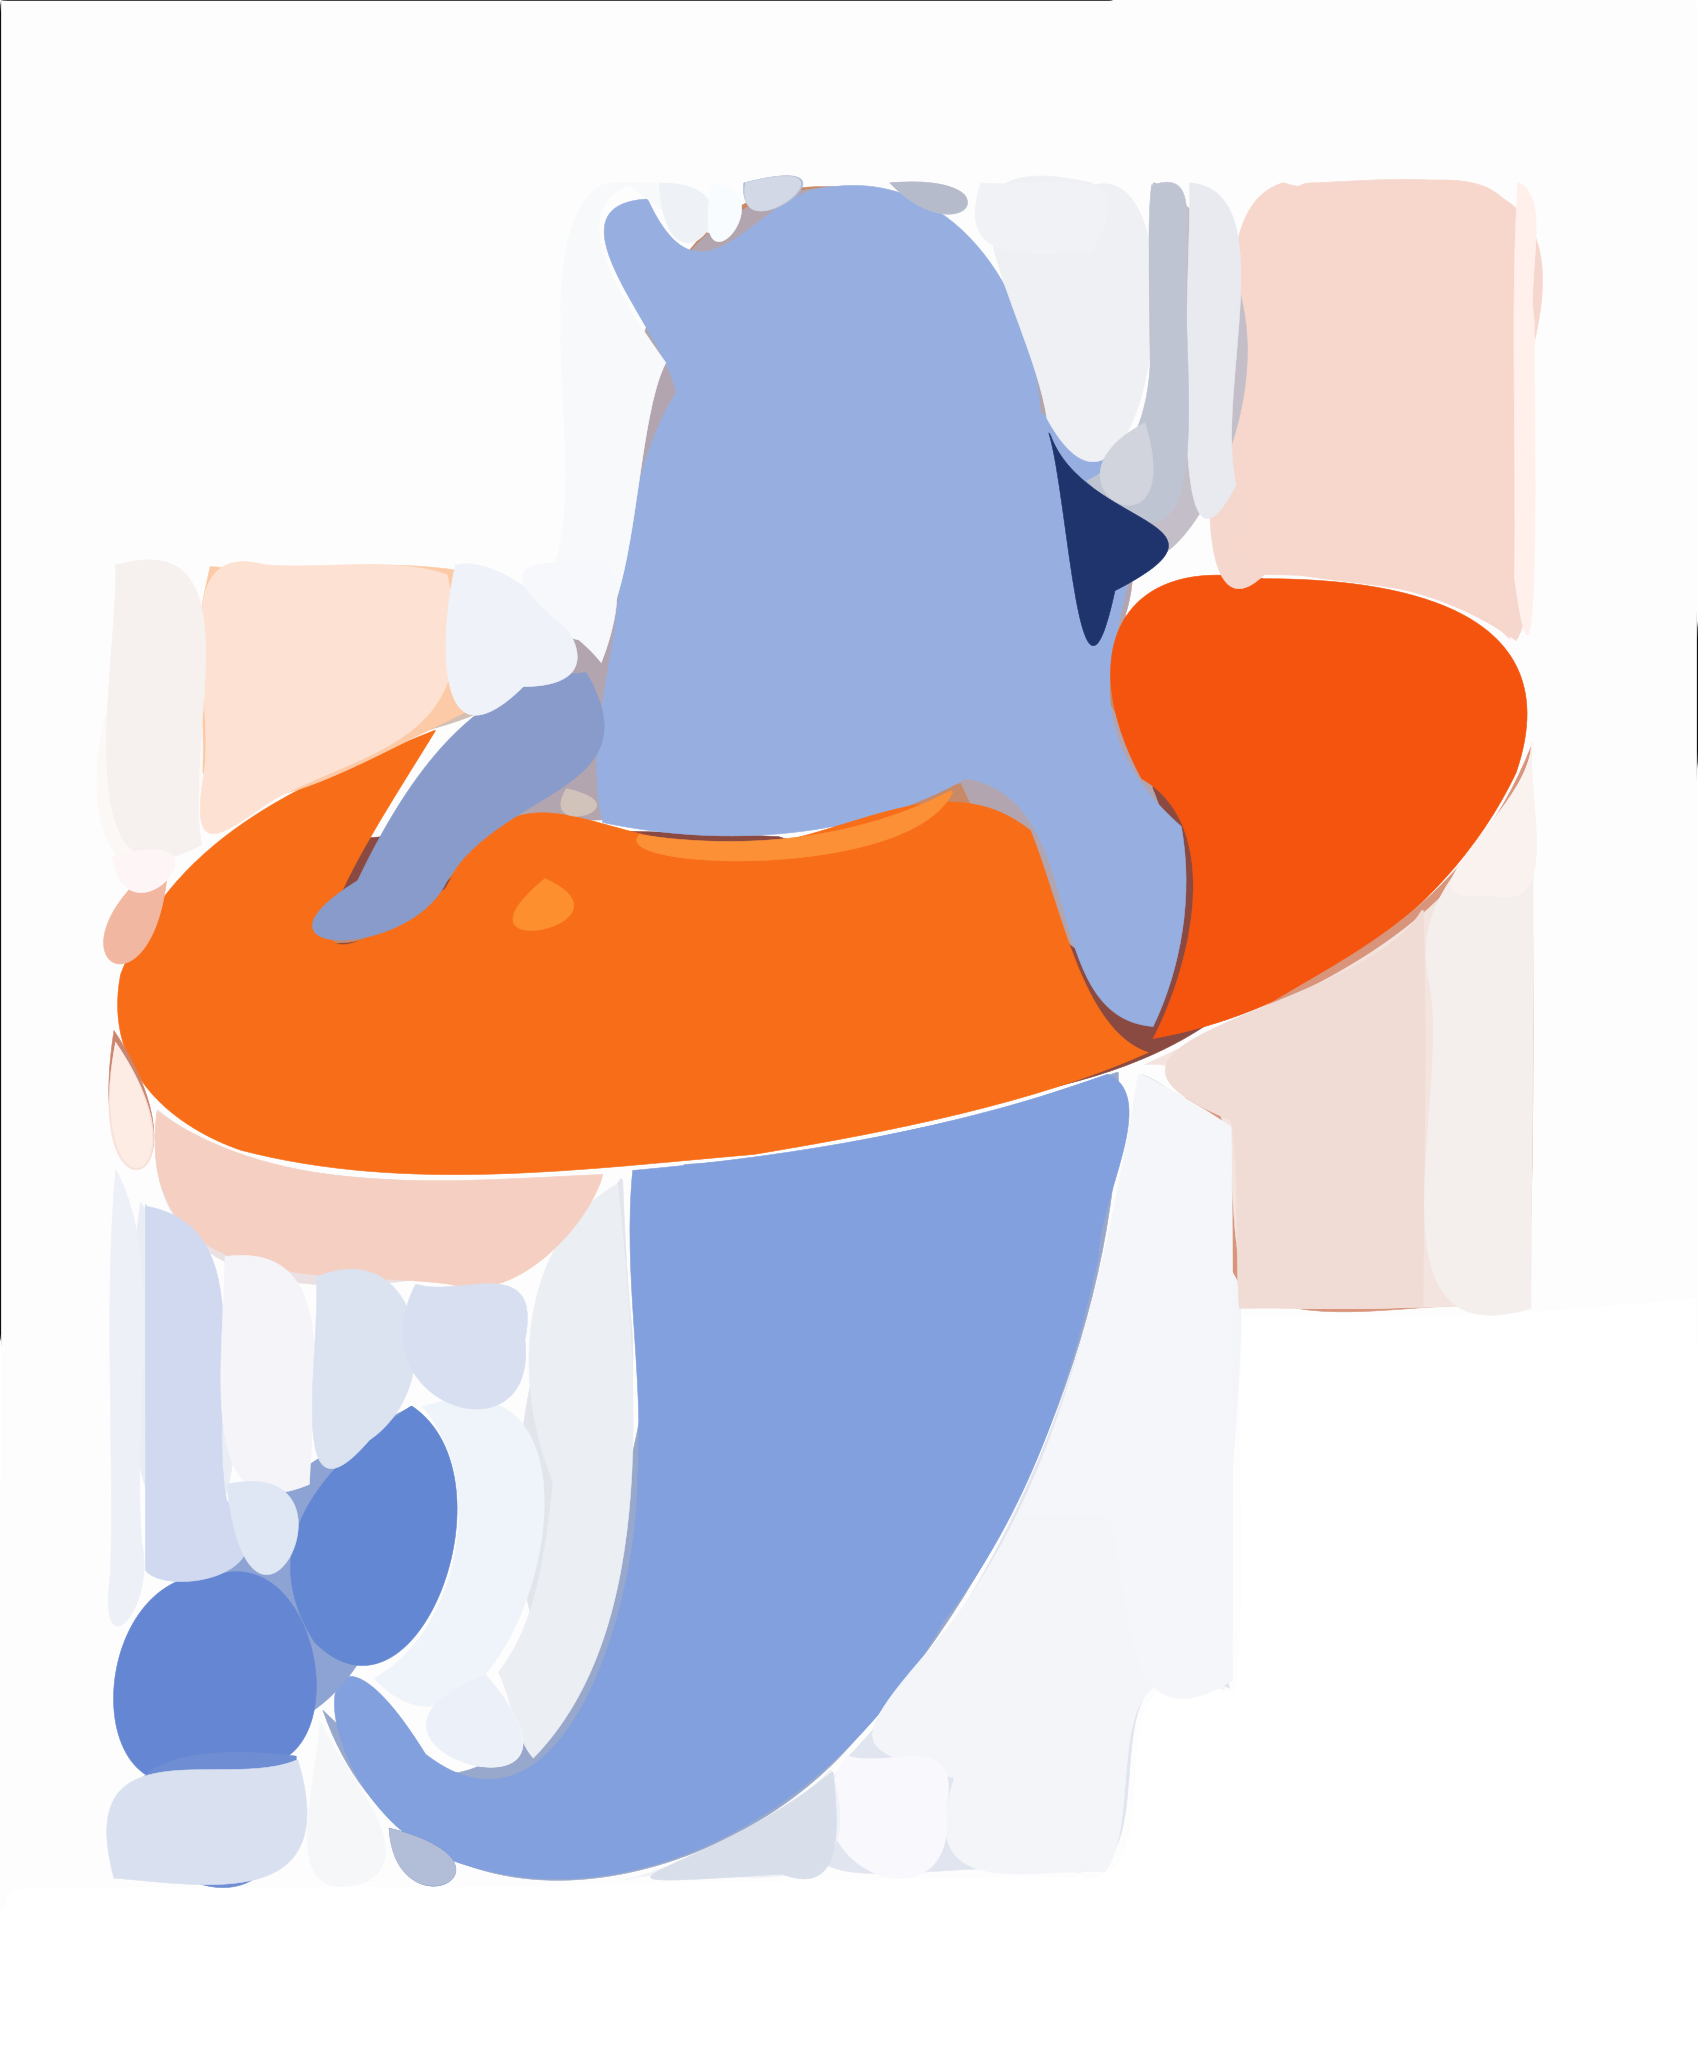

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 47.10825054004736
Topic5\house.png 
use_bezier_curve_num : 200 
component_num : 57


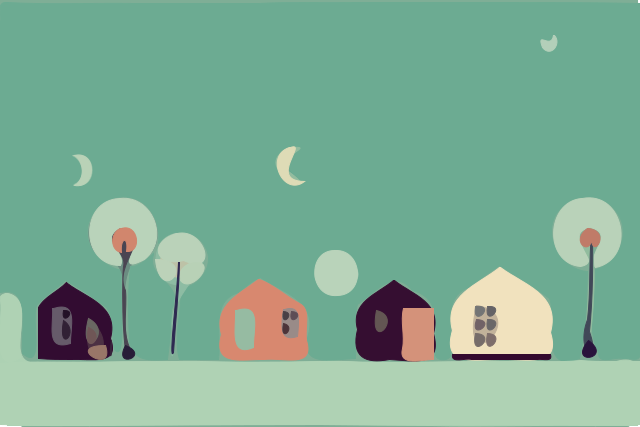

Topic5\house.png vs SVG2PNG_Topic5\house.png: 7.956354898516784
Topic5\meditation.png 
use_bezier_curve_num : 200 
component_num : 60


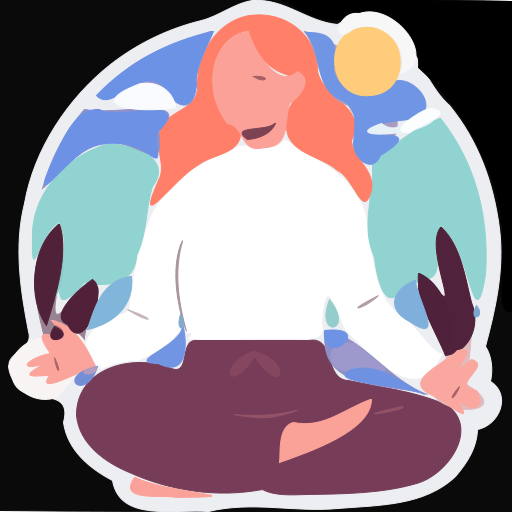

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 31.411665598551433
Topic5\tree.png 
use_bezier_curve_num : 200 
component_num : 200


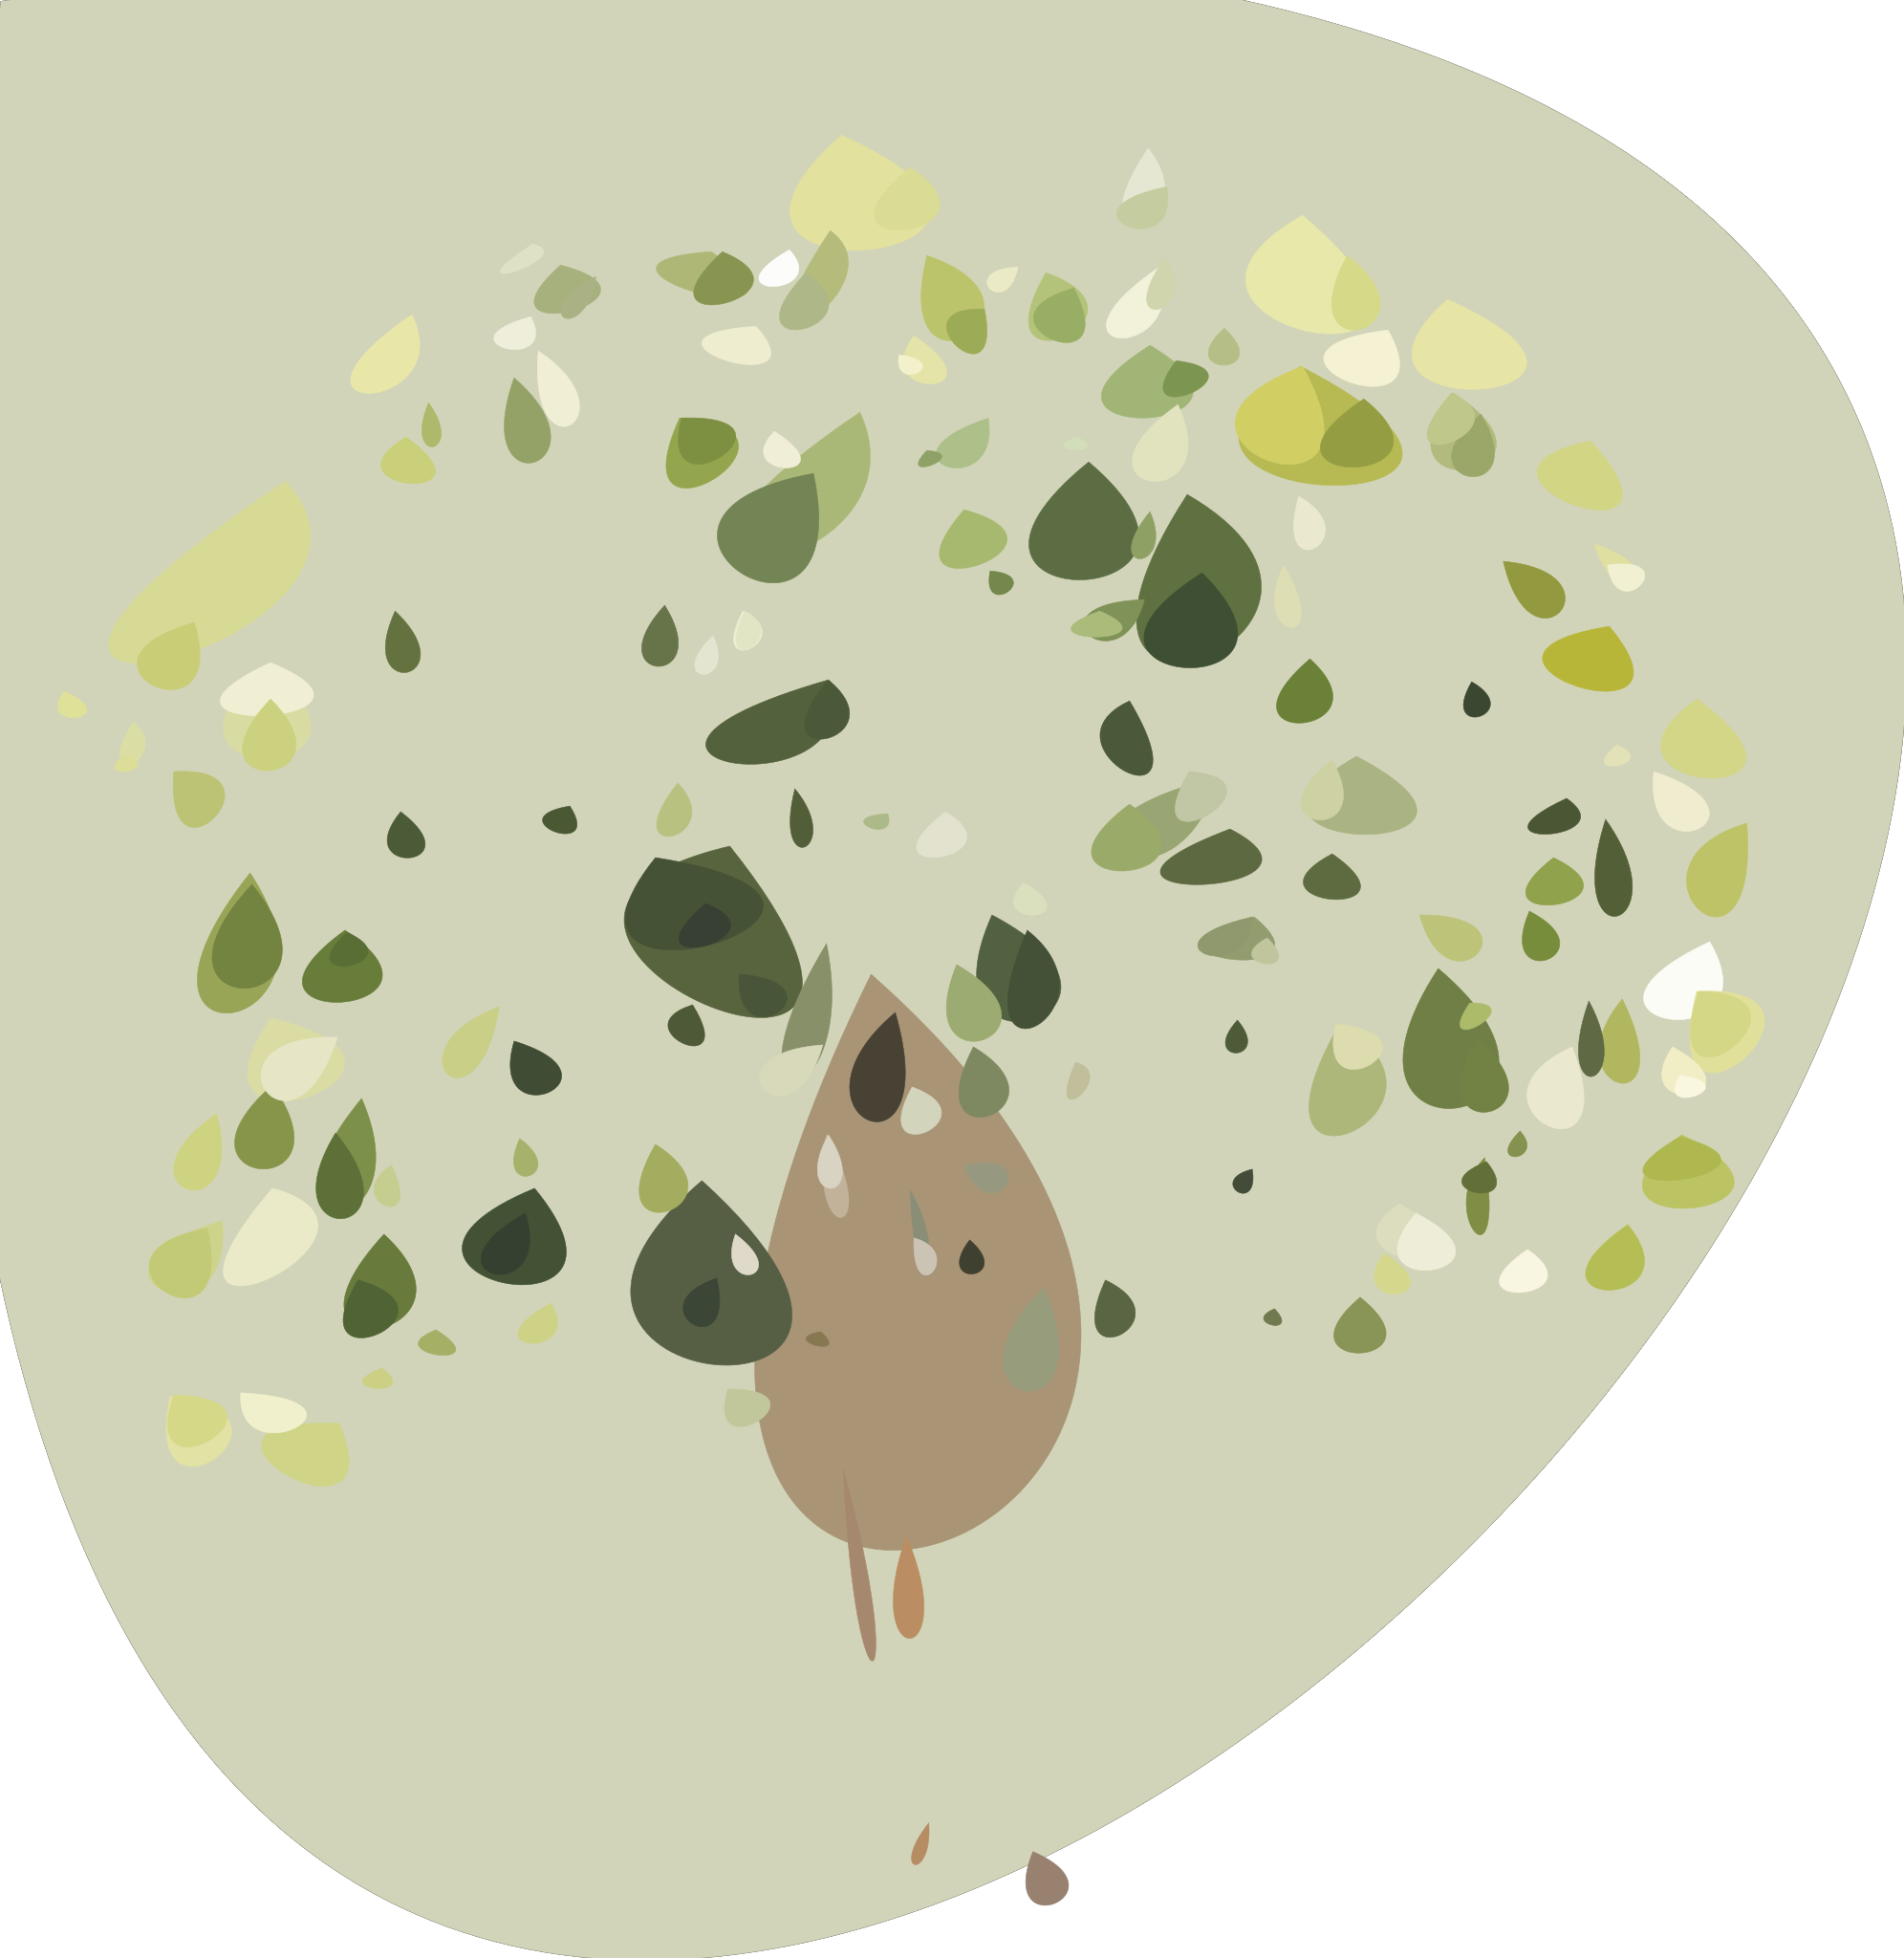

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 80.12982530303712
Topic5\work-from-home.png 
use_bezier_curve_num : 200 
component_num : 42


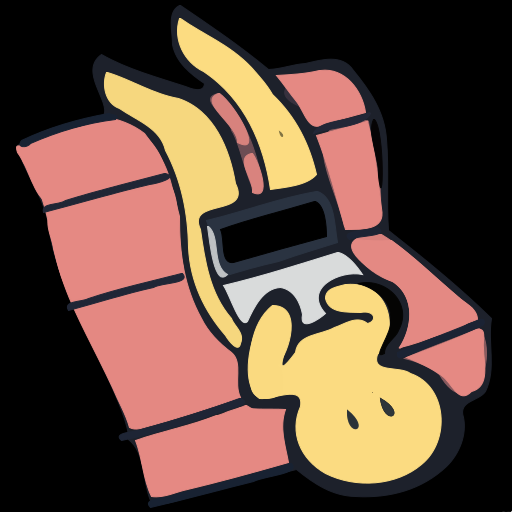

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 14.275249481201172
Topic5 Total MSE: 394.39357934193583
Topic5\fallingwater.jpg 
use_bezier_curve_num : 400 
component_num : 139


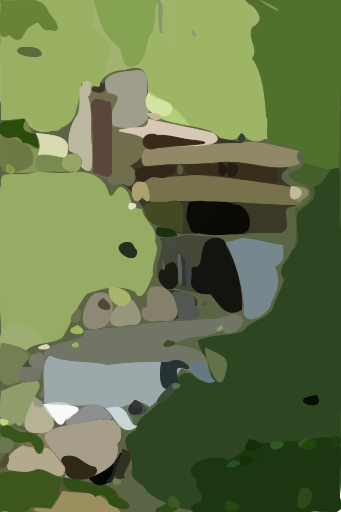

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.60755933834311
Topic5\flower.jpg 
use_bezier_curve_num : 400 
component_num : 177


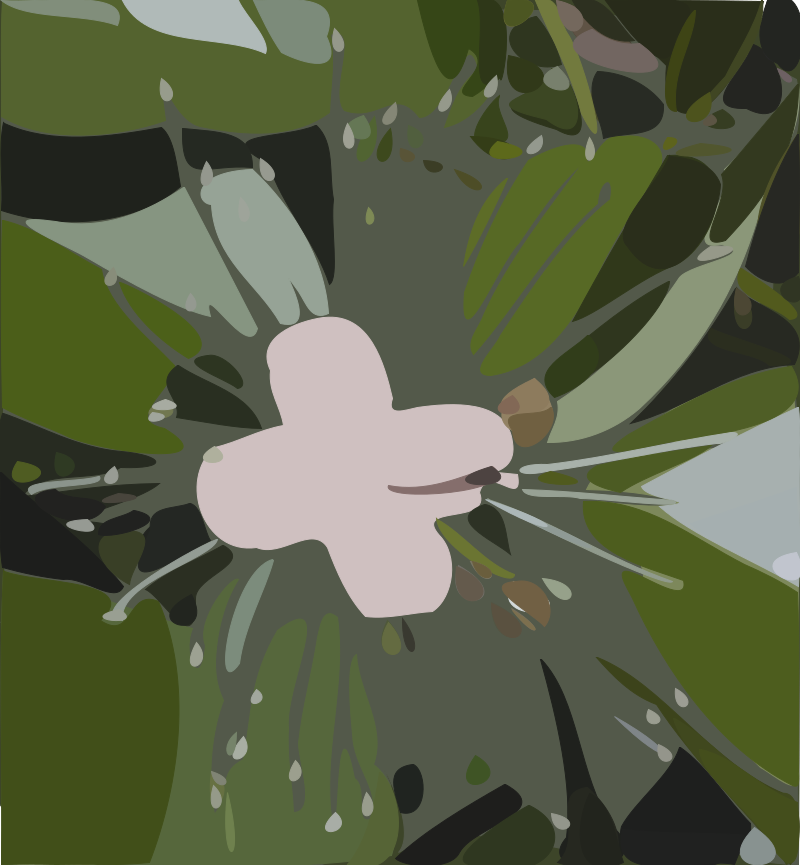

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 80.43486560693641
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 400 
component_num : 98


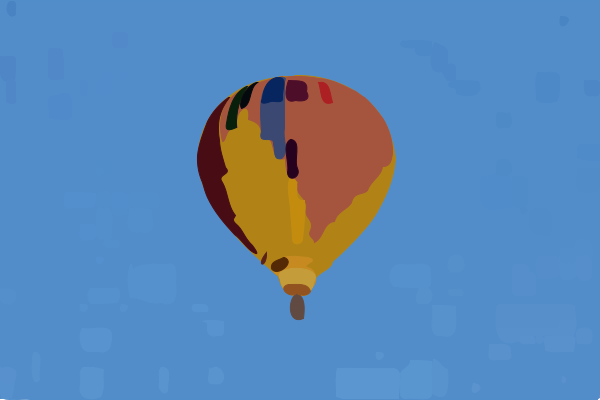

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.176231944444446
Topic5\autumn_01.png 
use_bezier_curve_num : 400 
component_num : 22


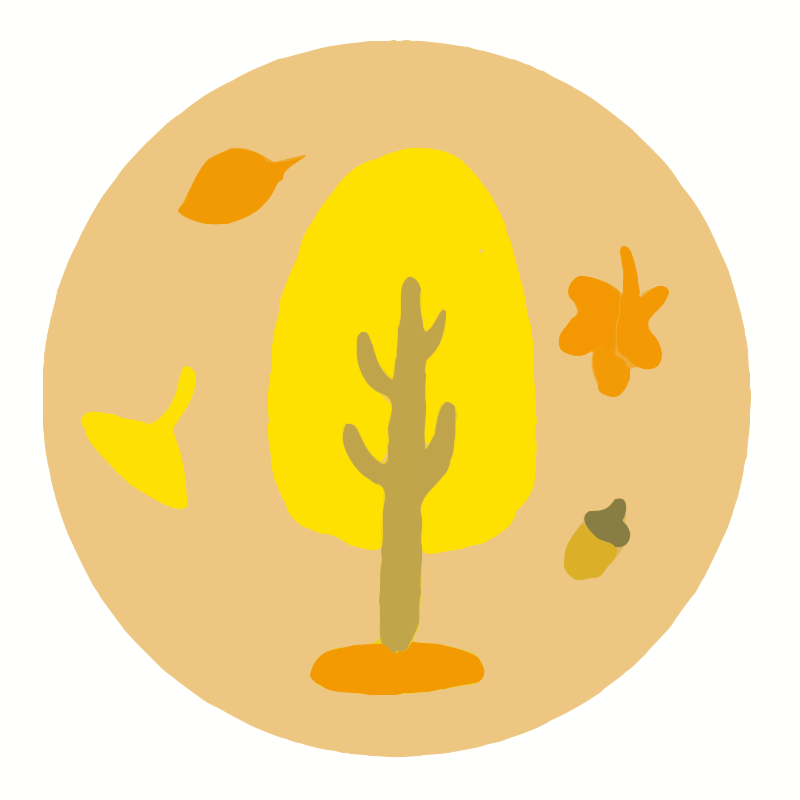

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 2.0006453125
Topic5\dolphin.png 
use_bezier_curve_num : 400 
component_num : 78


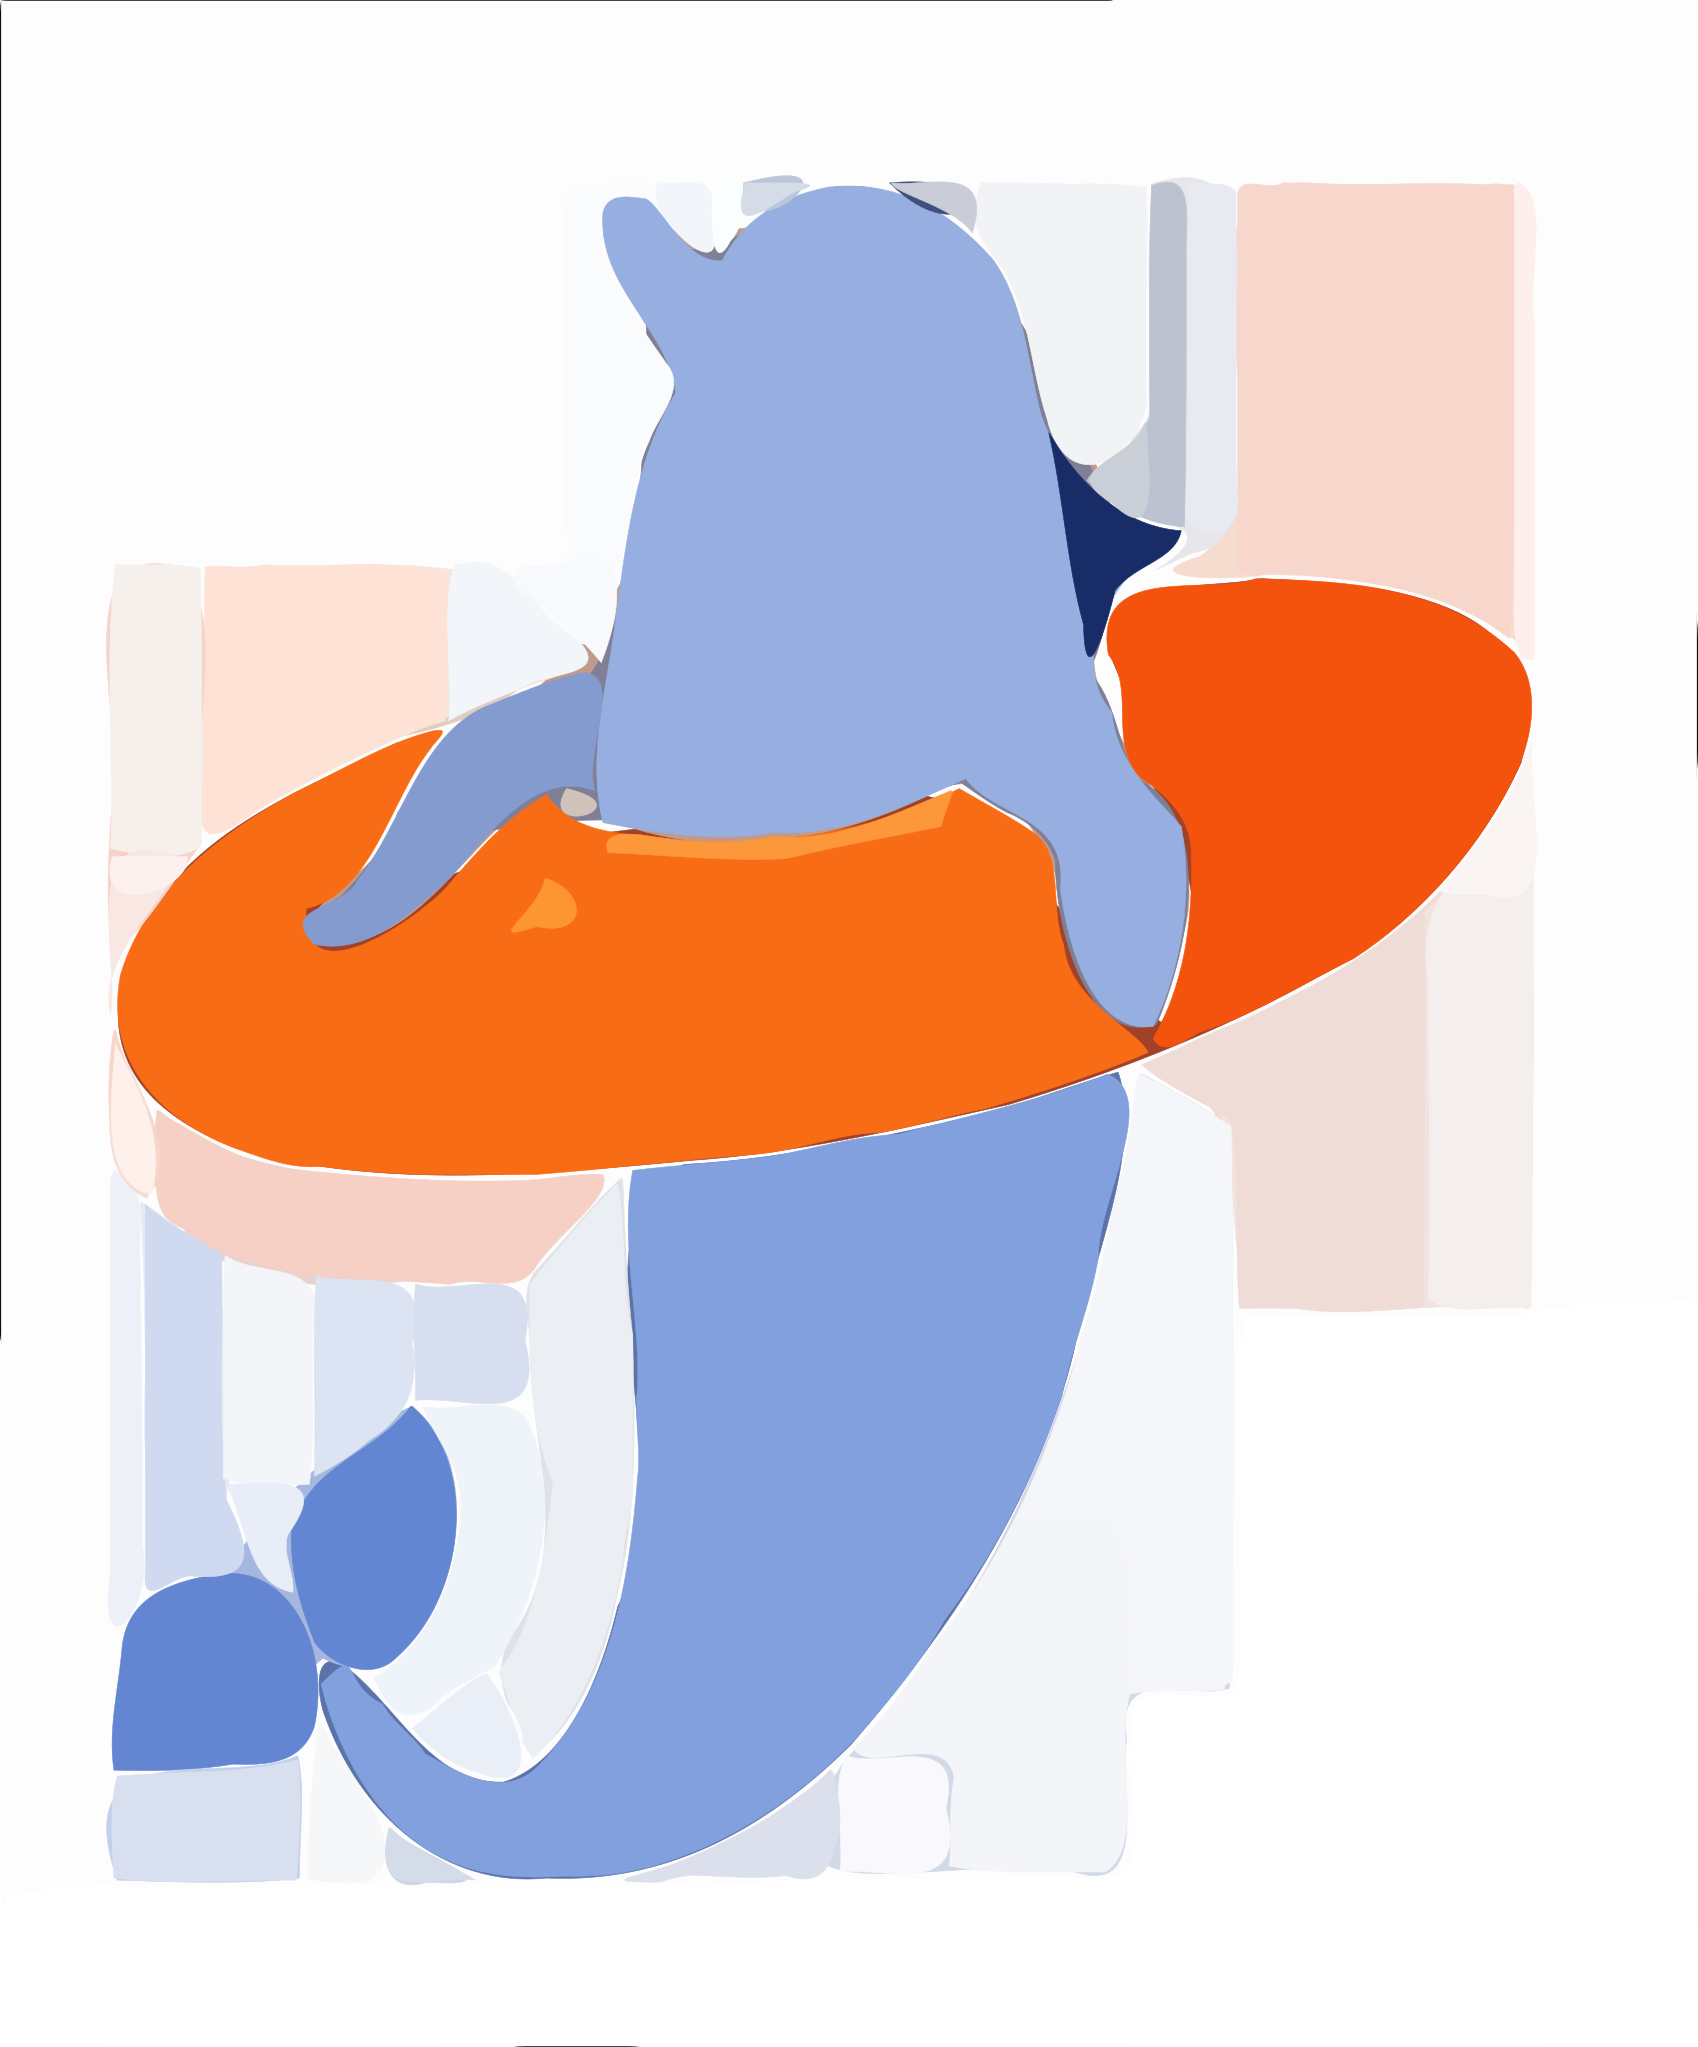

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.22046690091137
Topic5\house.png 
use_bezier_curve_num : 400 
component_num : 57


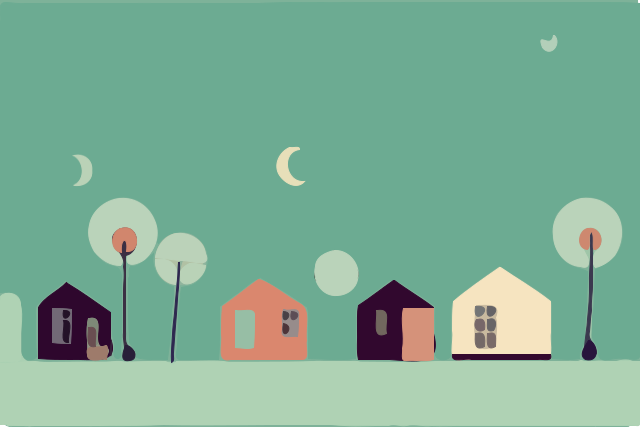

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.387937890320062
Topic5\meditation.png 
use_bezier_curve_num : 400 
component_num : 60


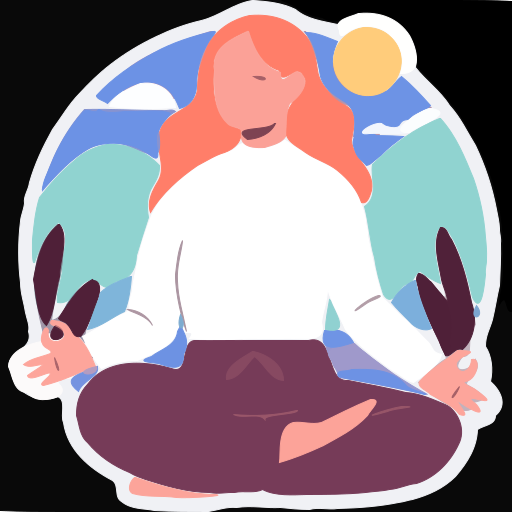

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 31.489859263102215
Topic5\tree.png 
use_bezier_curve_num : 400 
component_num : 200


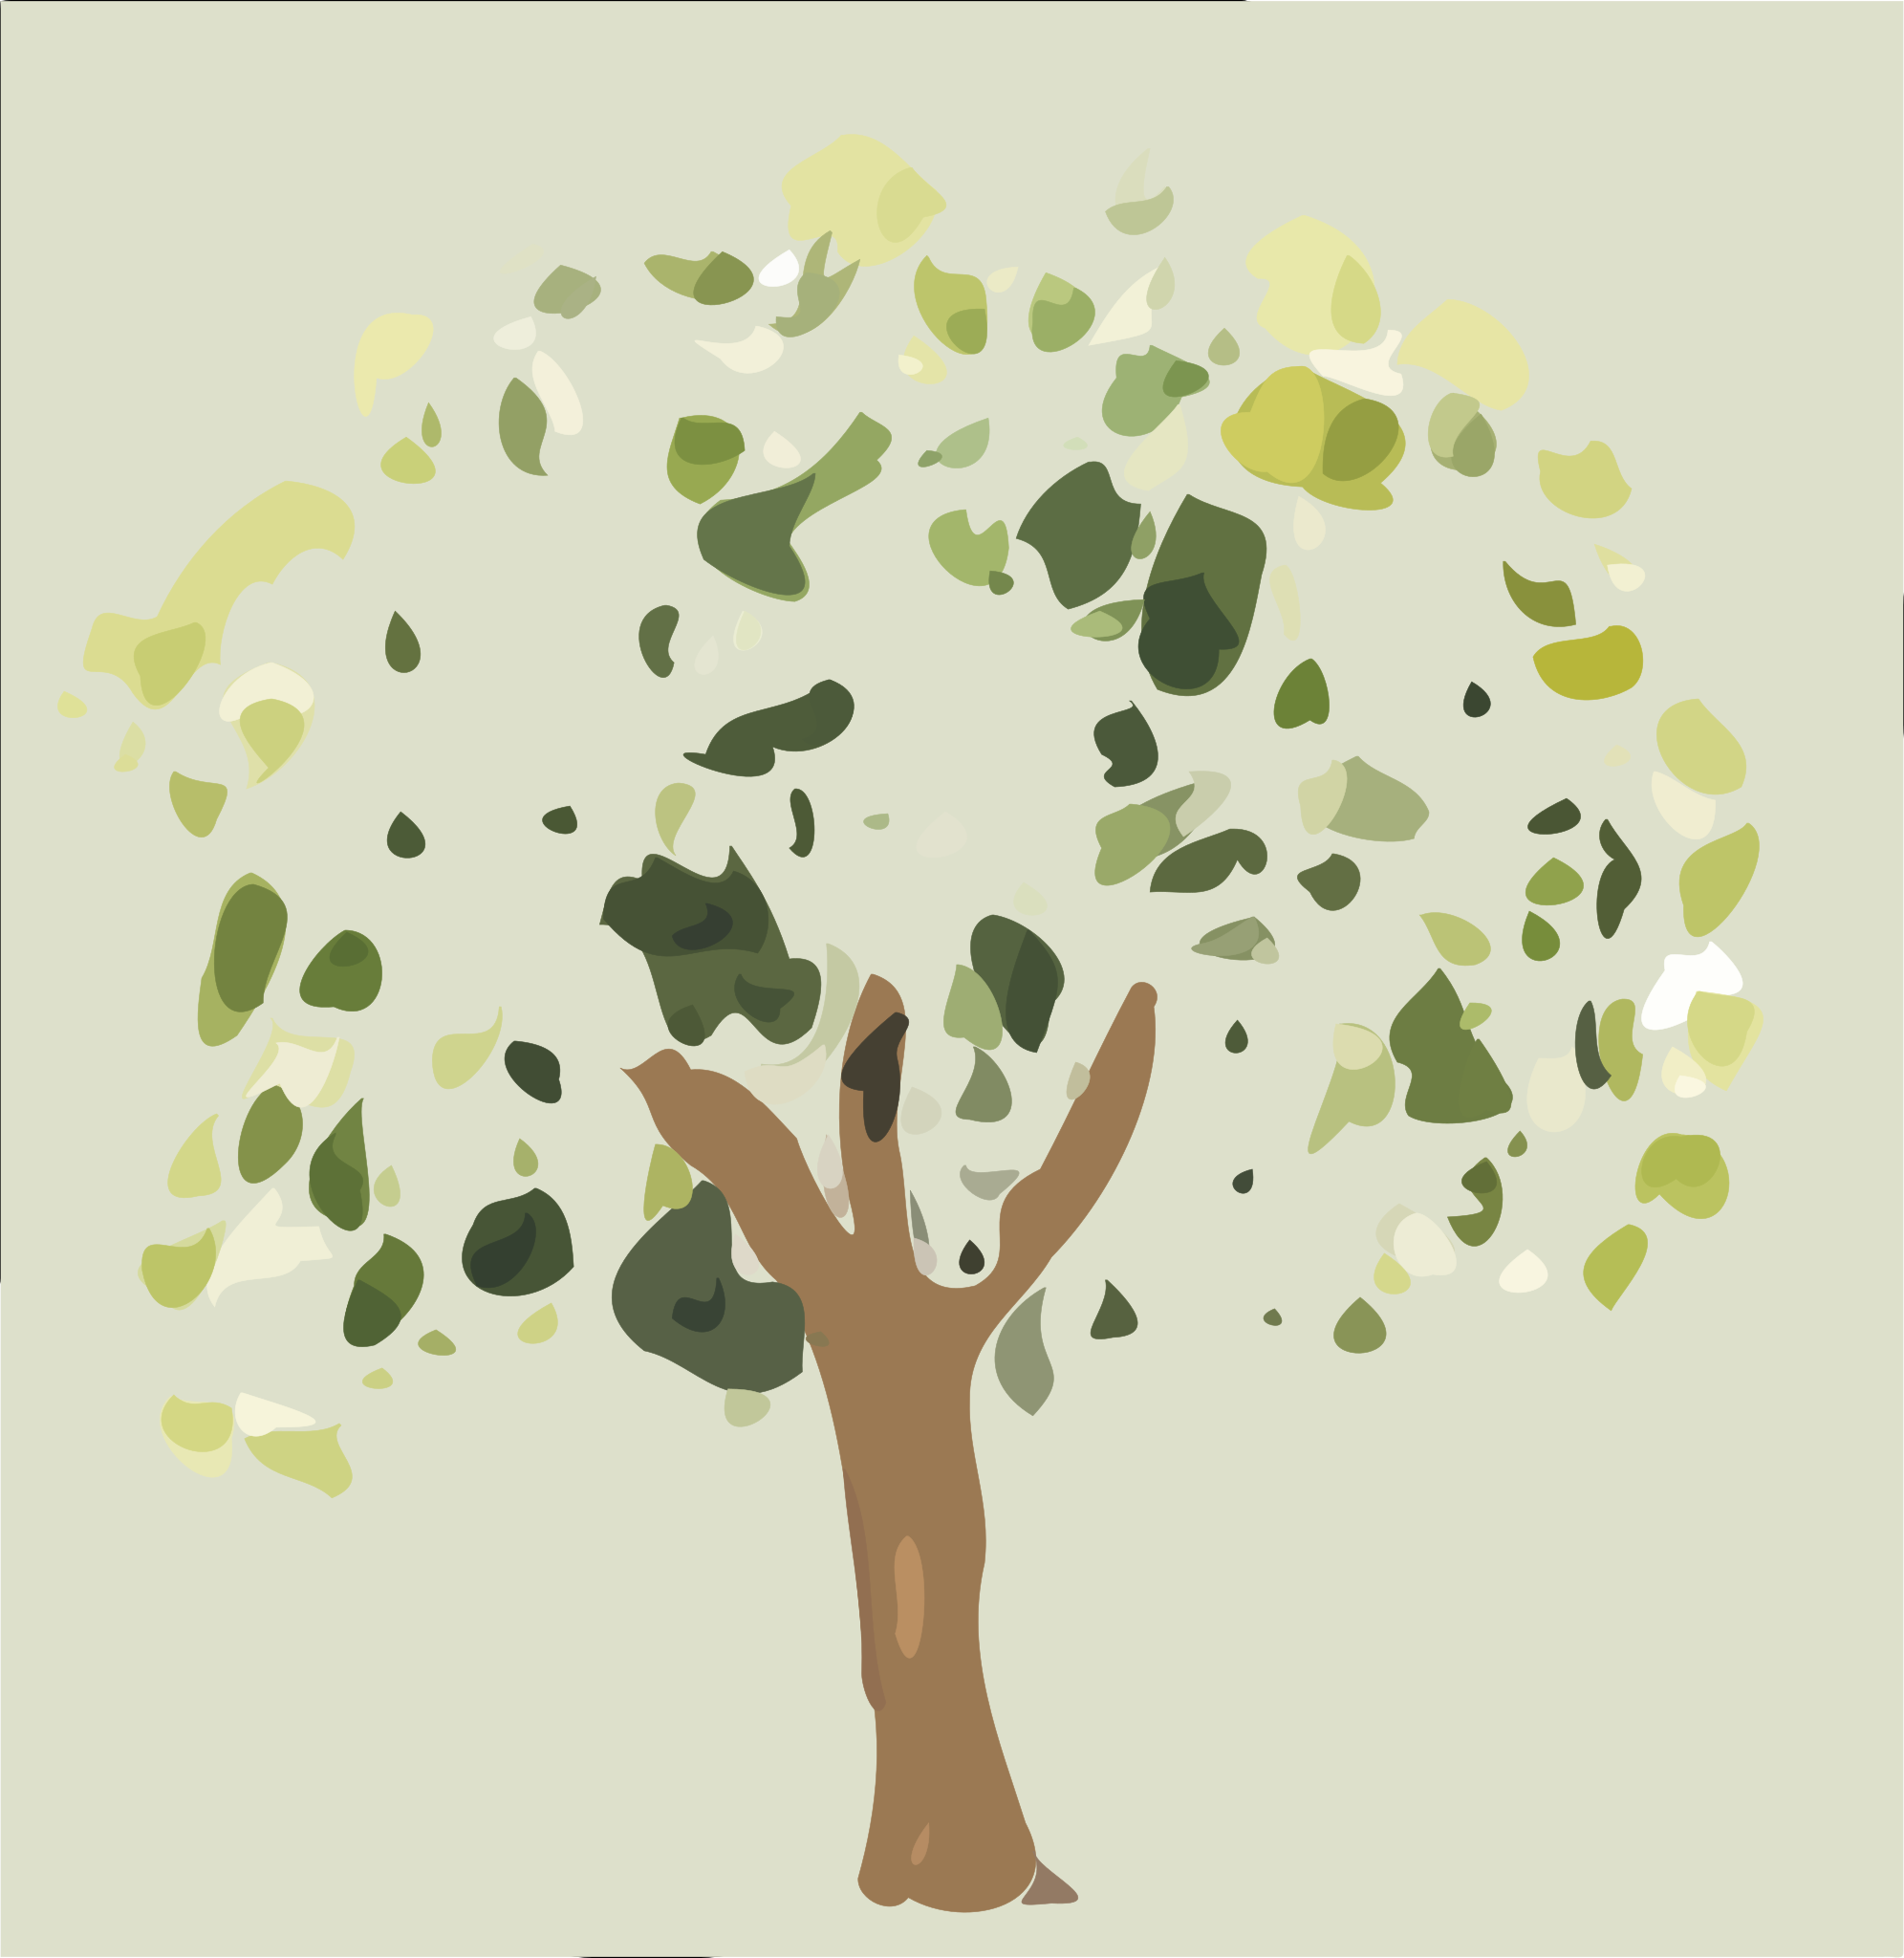

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 123.199141217953
Topic5\work-from-home.png 
use_bezier_curve_num : 400 
component_num : 42


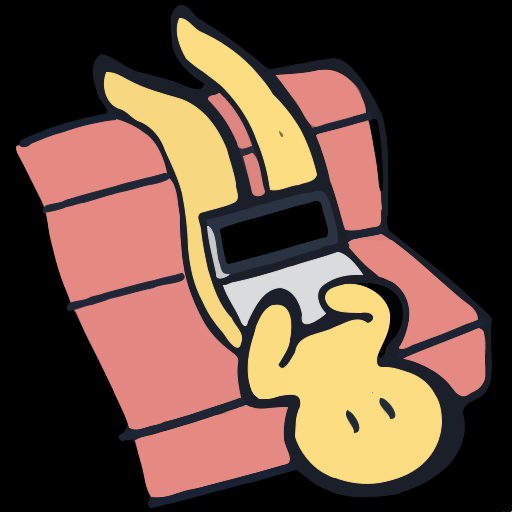

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 14.723800659179688
Topic5 Total MSE: 429.24050813369035
Topic5\fallingwater.jpg 
use_bezier_curve_num : 600 
component_num : 139


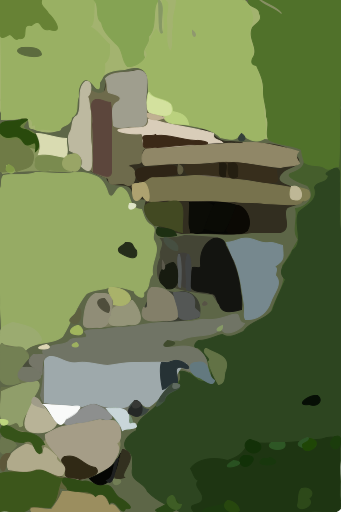

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.2294263196481
Topic5\flower.jpg 
use_bezier_curve_num : 600 
component_num : 177


Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.8721387283237
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 600 
component_num : 98


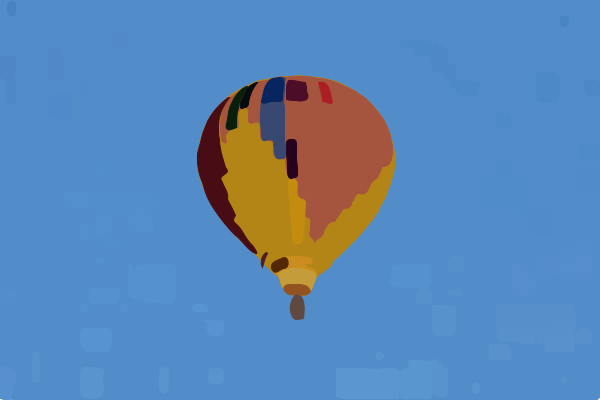

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.078294444444445
Topic5\autumn_01.png 
use_bezier_curve_num : 600 
component_num : 22


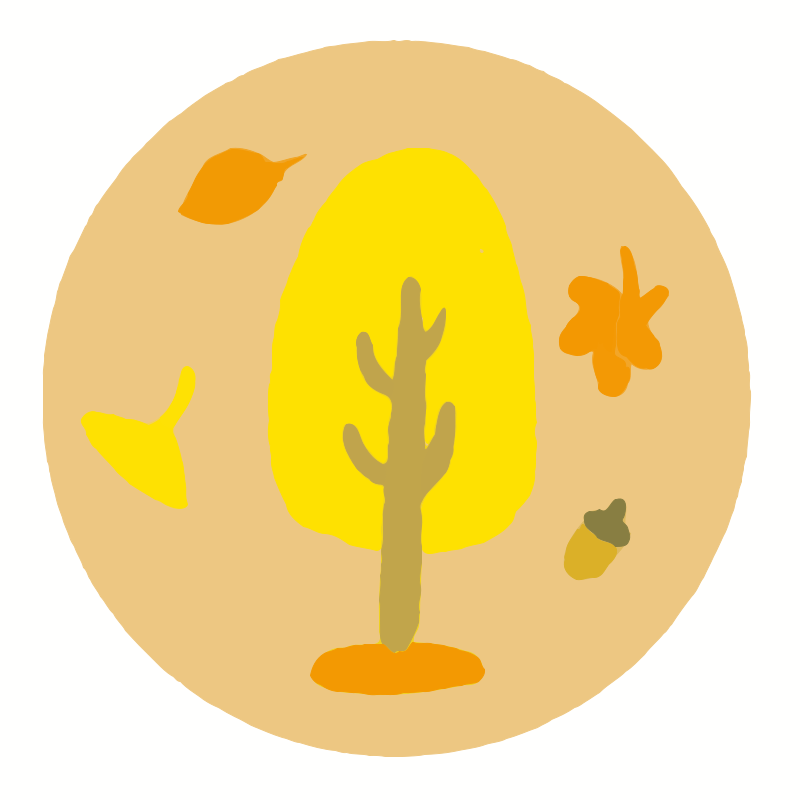

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.9475307291666666
Topic5\dolphin.png 
use_bezier_curve_num : 600 
component_num : 78


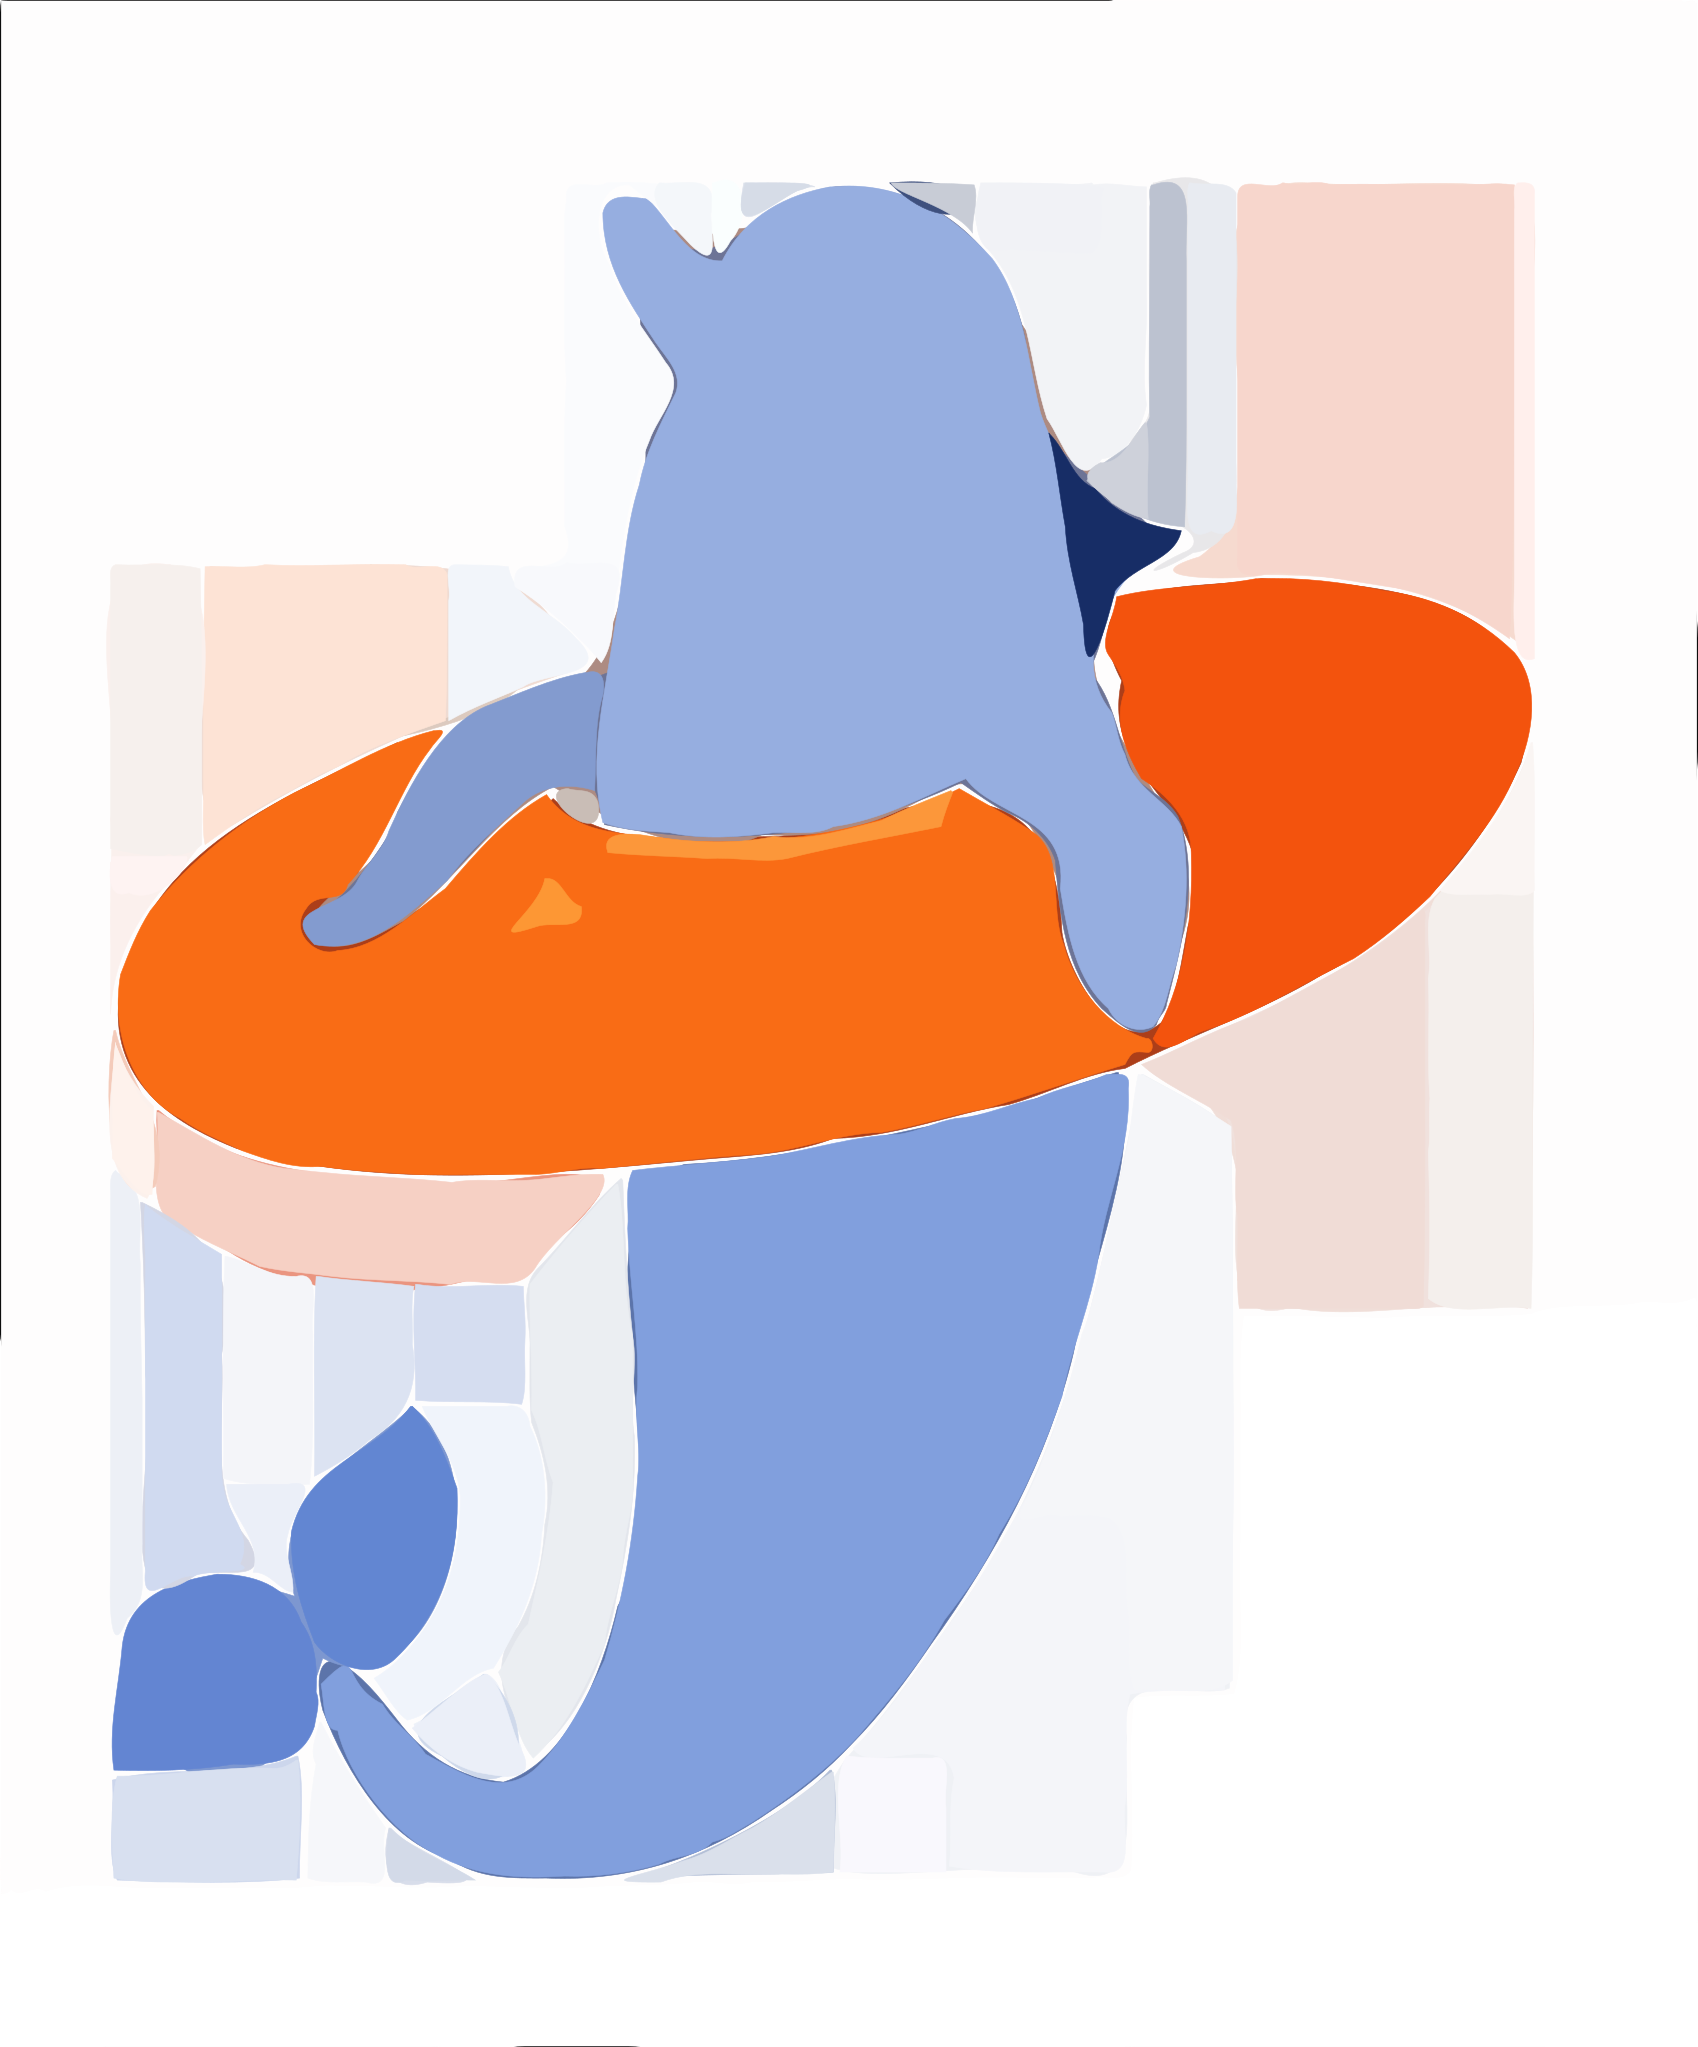

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 45.968058713037664
Topic5\house.png 
use_bezier_curve_num : 600 
component_num : 57


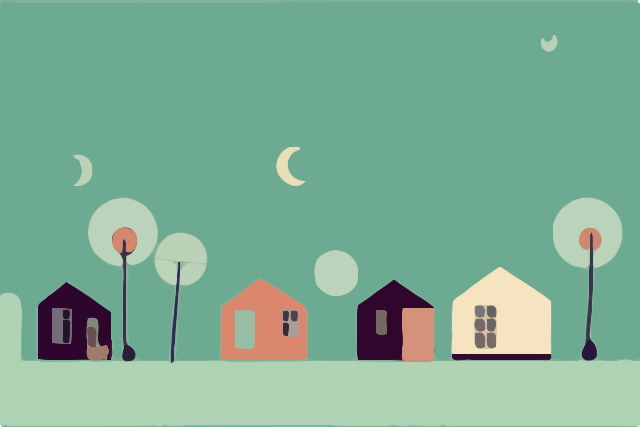

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.4409335967993755
Topic5\meditation.png 
use_bezier_curve_num : 600 
component_num : 60


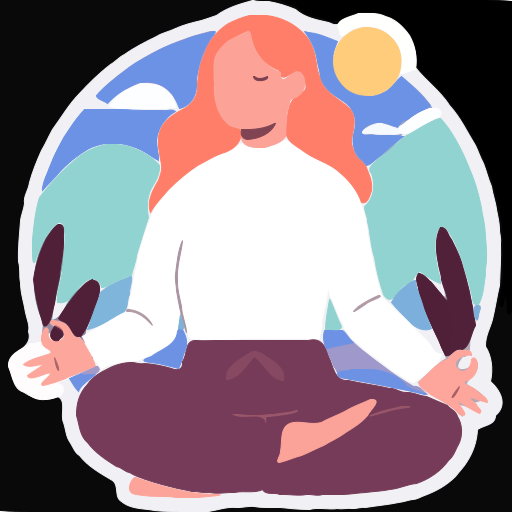

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 30.156172434488933
Topic5\tree.png 
use_bezier_curve_num : 600 
component_num : 200


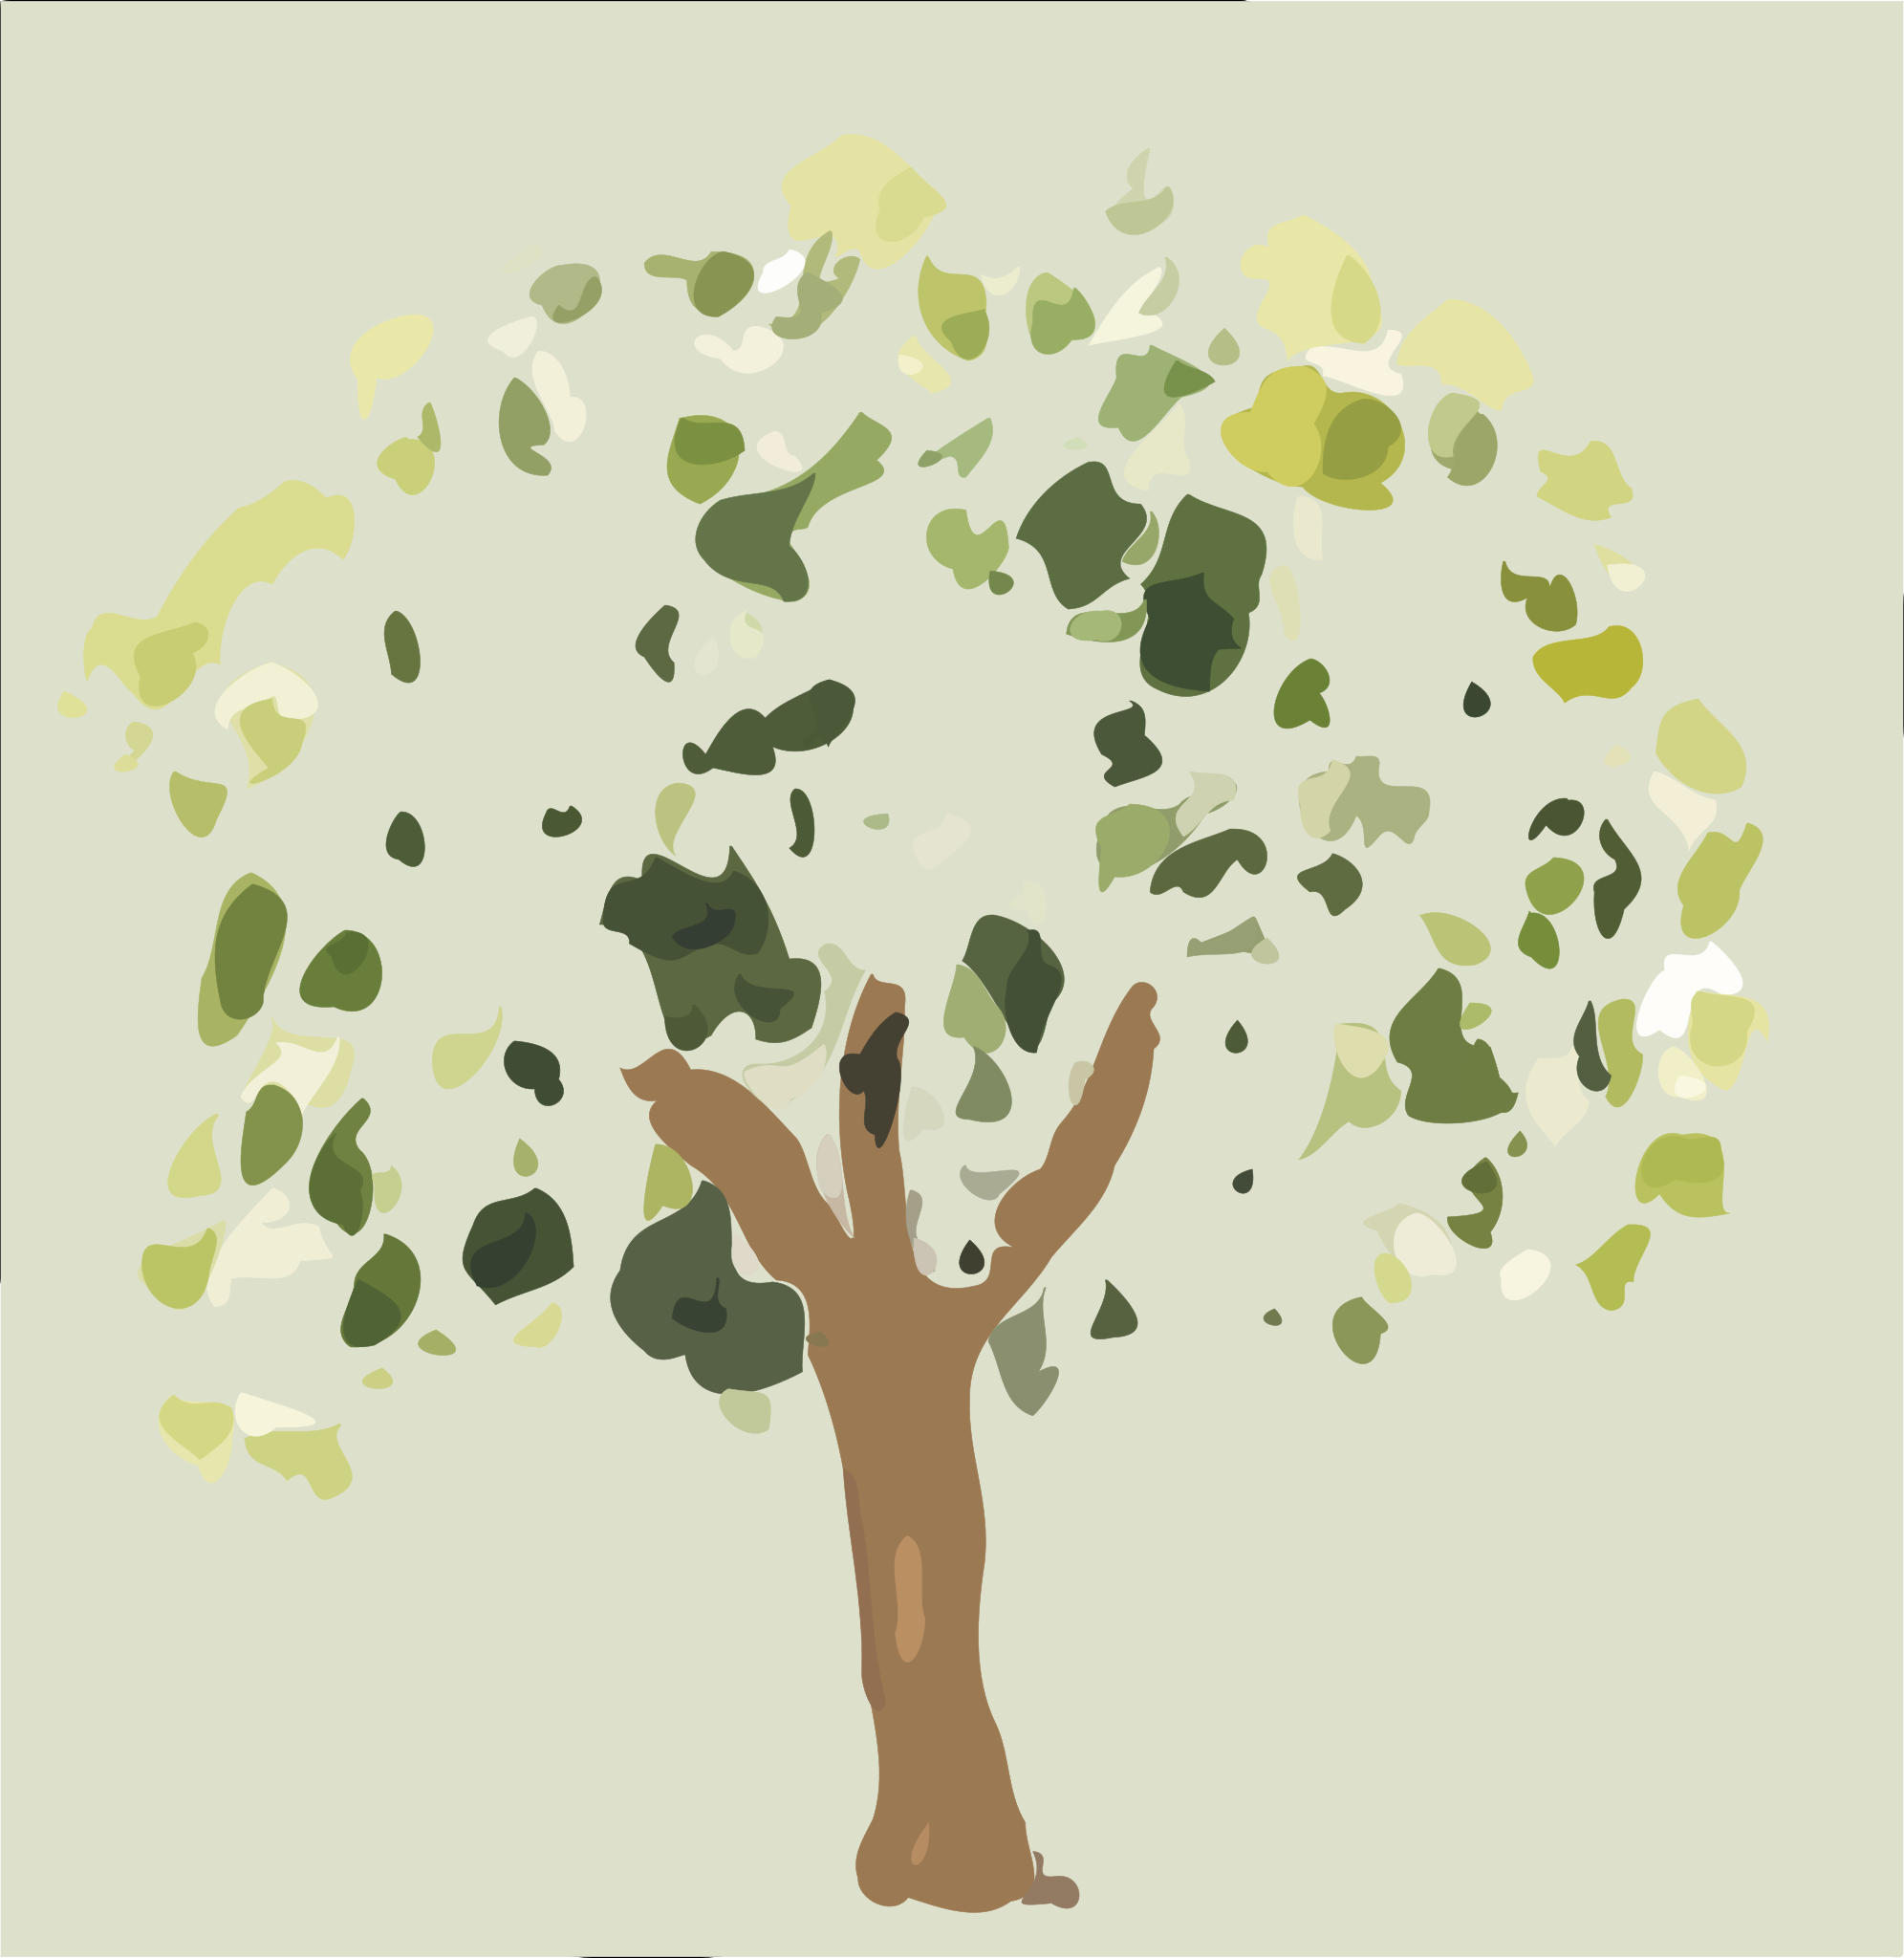

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.52941790233213
Topic5\work-from-home.png 
use_bezier_curve_num : 600 
component_num : 42


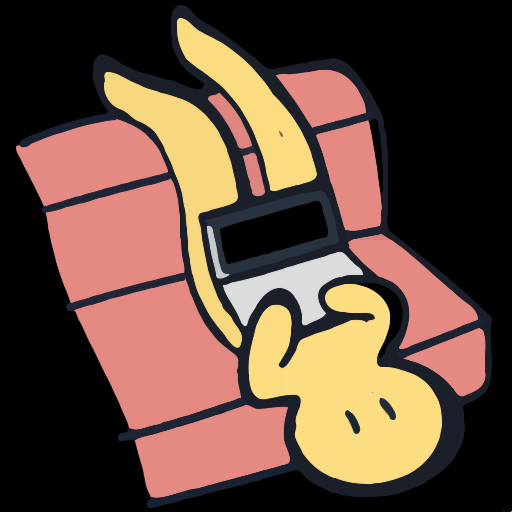

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 14.819002787272135
Topic5 Total MSE: 397.0409756555132
Topic5\fallingwater.jpg 
use_bezier_curve_num : 800 
component_num : 139


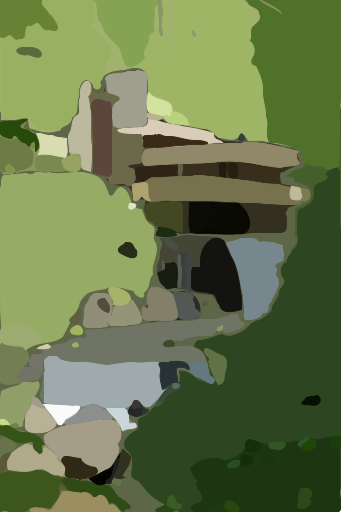

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.01530425219941
Topic5\flower.jpg 
use_bezier_curve_num : 800 
component_num : 177


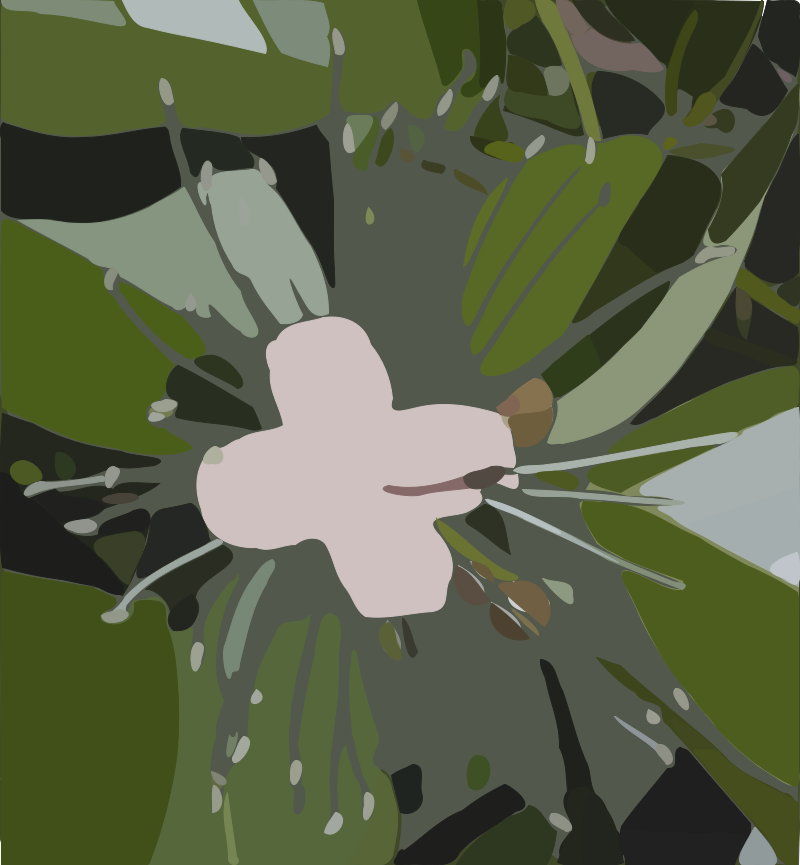

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.72908477842005
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 800 
component_num : 98


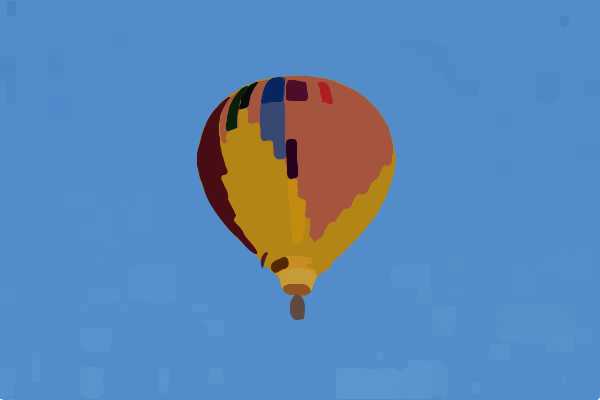

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.1009125
Topic5\autumn_01.png 
use_bezier_curve_num : 800 
component_num : 22


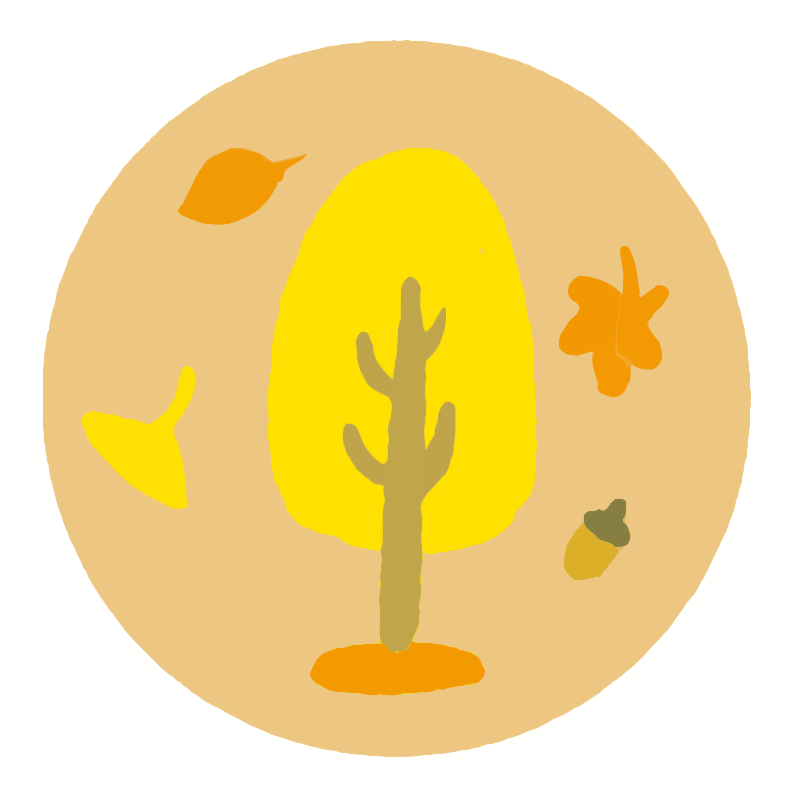

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.9293984375
Topic5\dolphin.png 
use_bezier_curve_num : 800 
component_num : 78


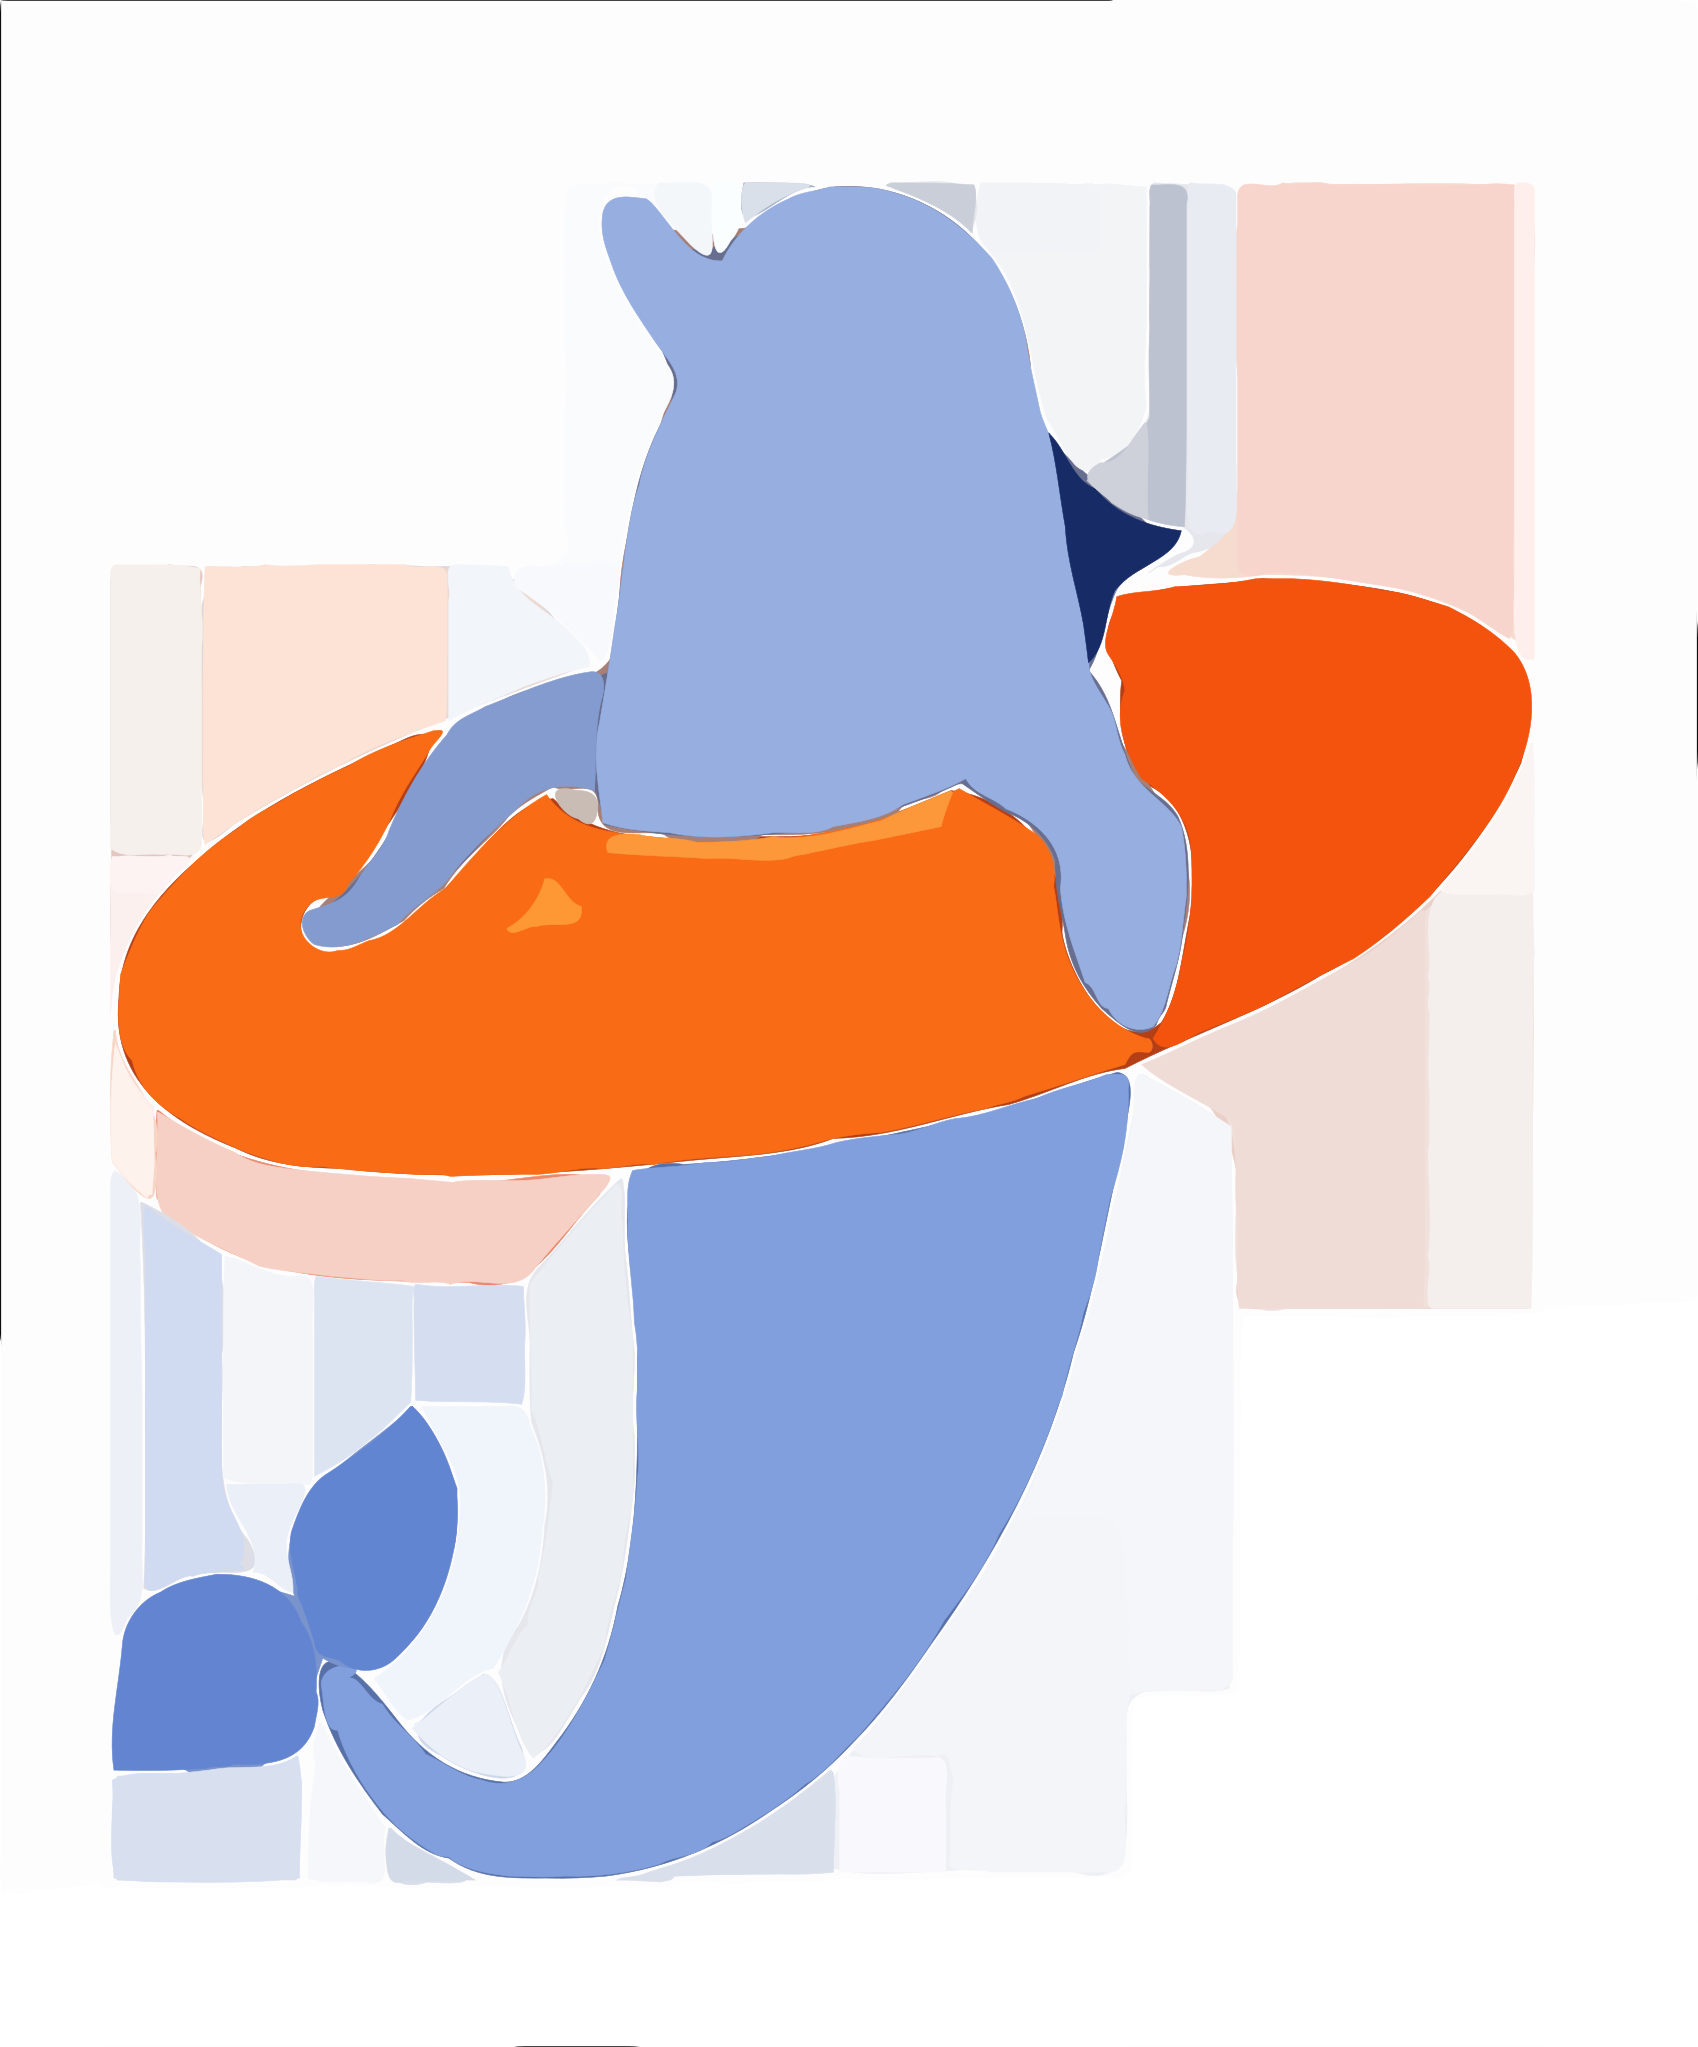

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 45.899645989336825
Topic5\house.png 
use_bezier_curve_num : 800 
component_num : 57


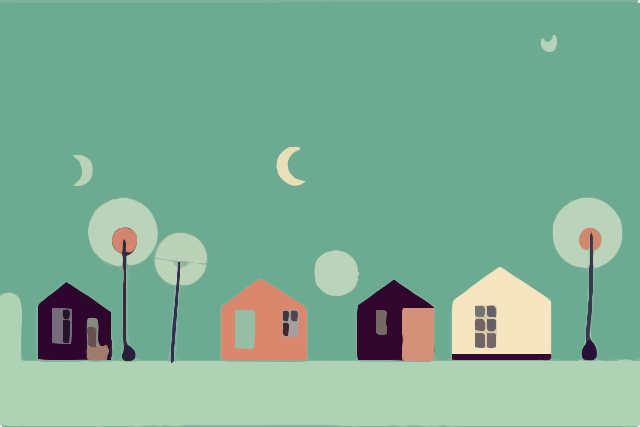

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.3077637099921935
Topic5\meditation.png 
use_bezier_curve_num : 800 
component_num : 60


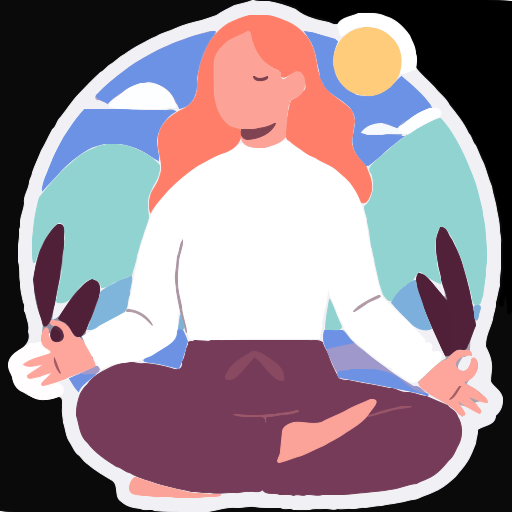

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 33.093466440836586
Topic5\tree.png 
use_bezier_curve_num : 800 
component_num : 200


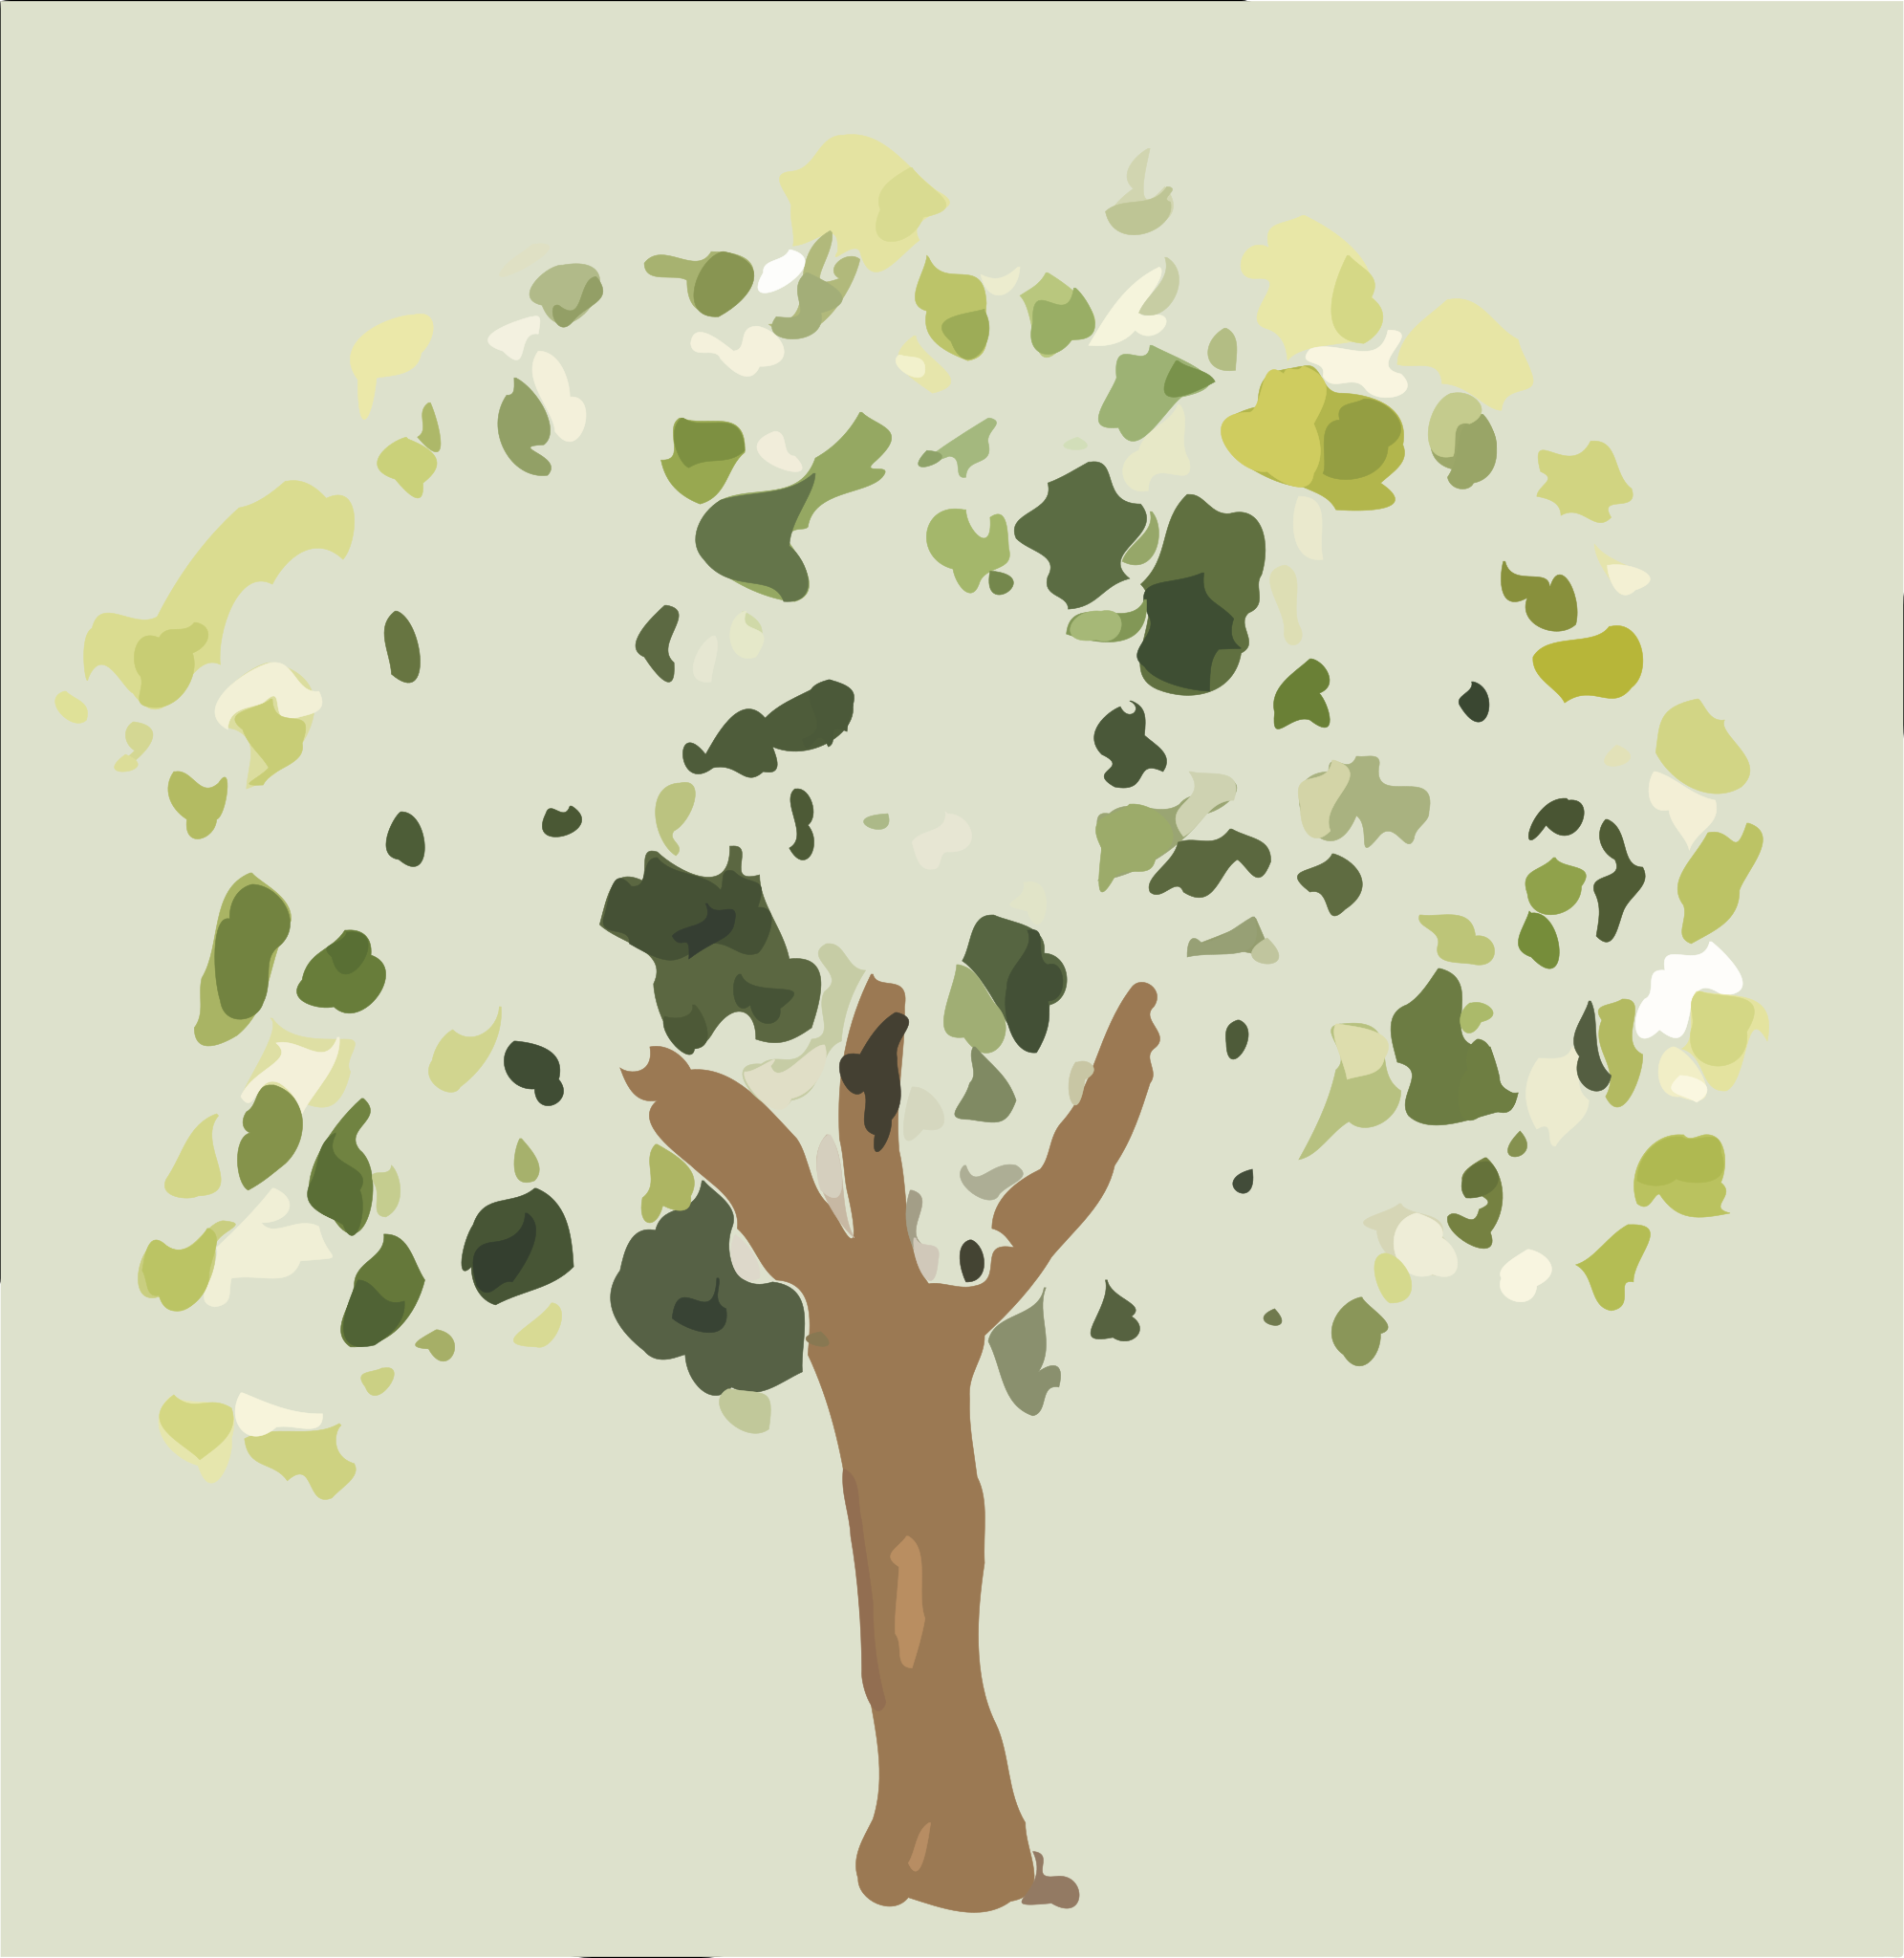

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.36145516863446
Topic5\work-from-home.png 
use_bezier_curve_num : 800 
component_num : 42


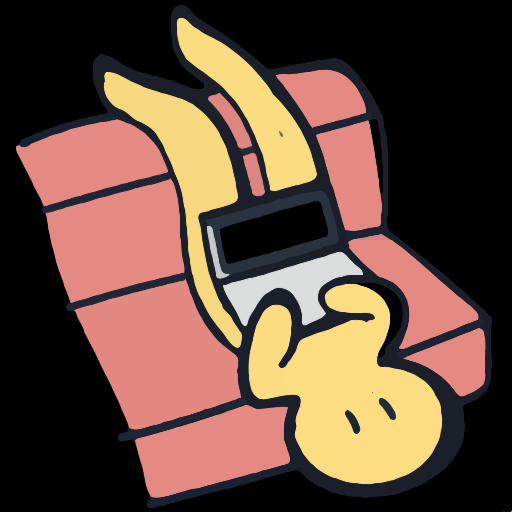

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 14.760740915934244
Topic5 Total MSE: 399.1977721928538
Topic5\fallingwater.jpg 
use_bezier_curve_num : 1000 
component_num : 139


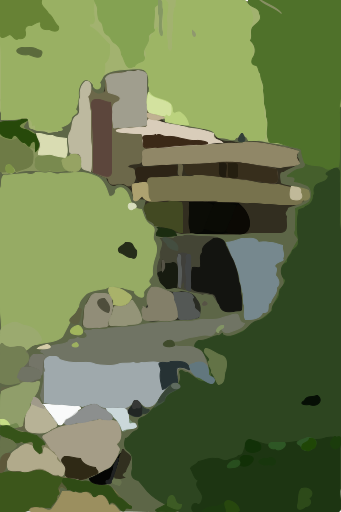

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 96.97170164345063
Topic5\flower.jpg 
use_bezier_curve_num : 1000 
component_num : 177


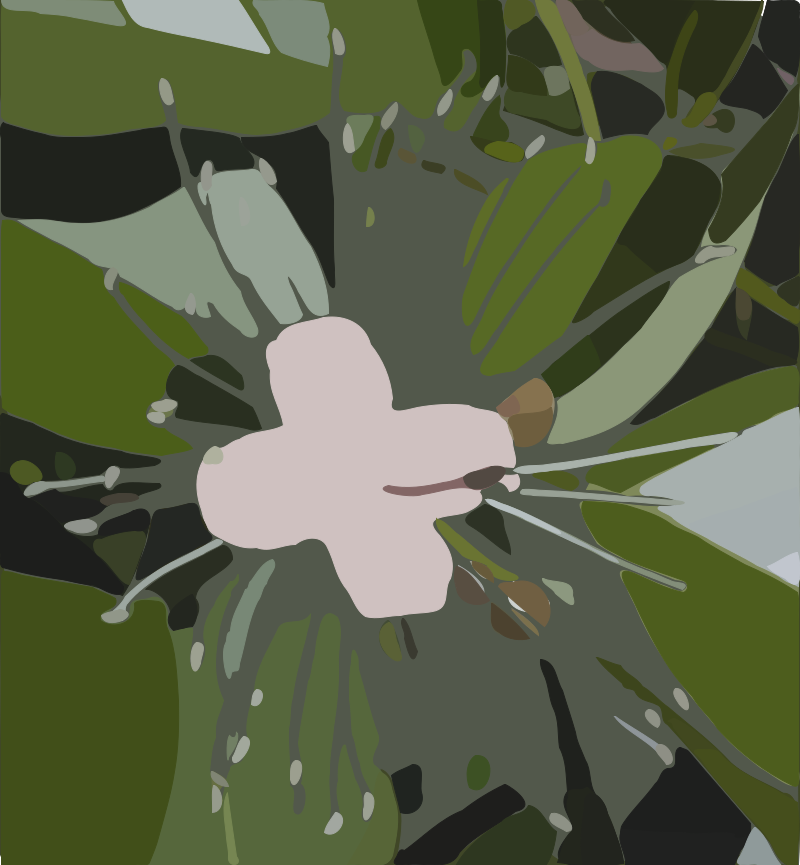

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 79.6911767822736
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 1000 
component_num : 98


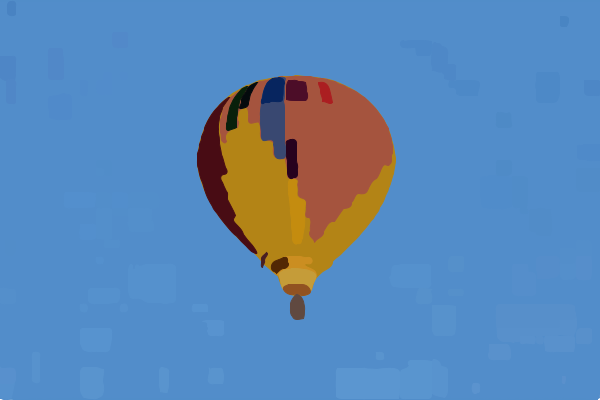

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.09392638888889
Topic5\autumn_01.png 
use_bezier_curve_num : 1000 
component_num : 22


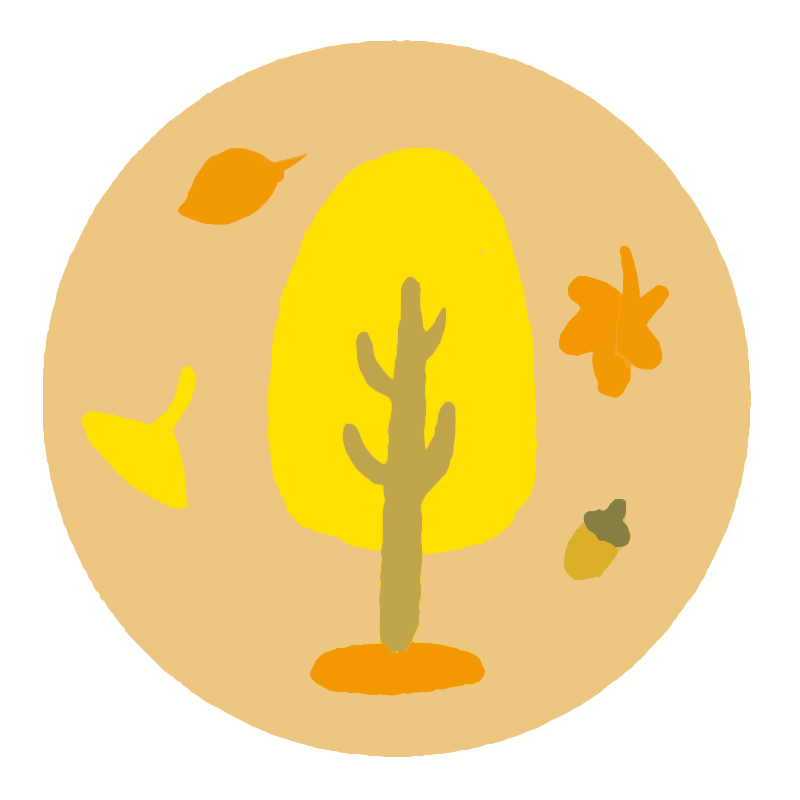

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 1.8886505208333333
Topic5\dolphin.png 
use_bezier_curve_num : 1000 
component_num : 78


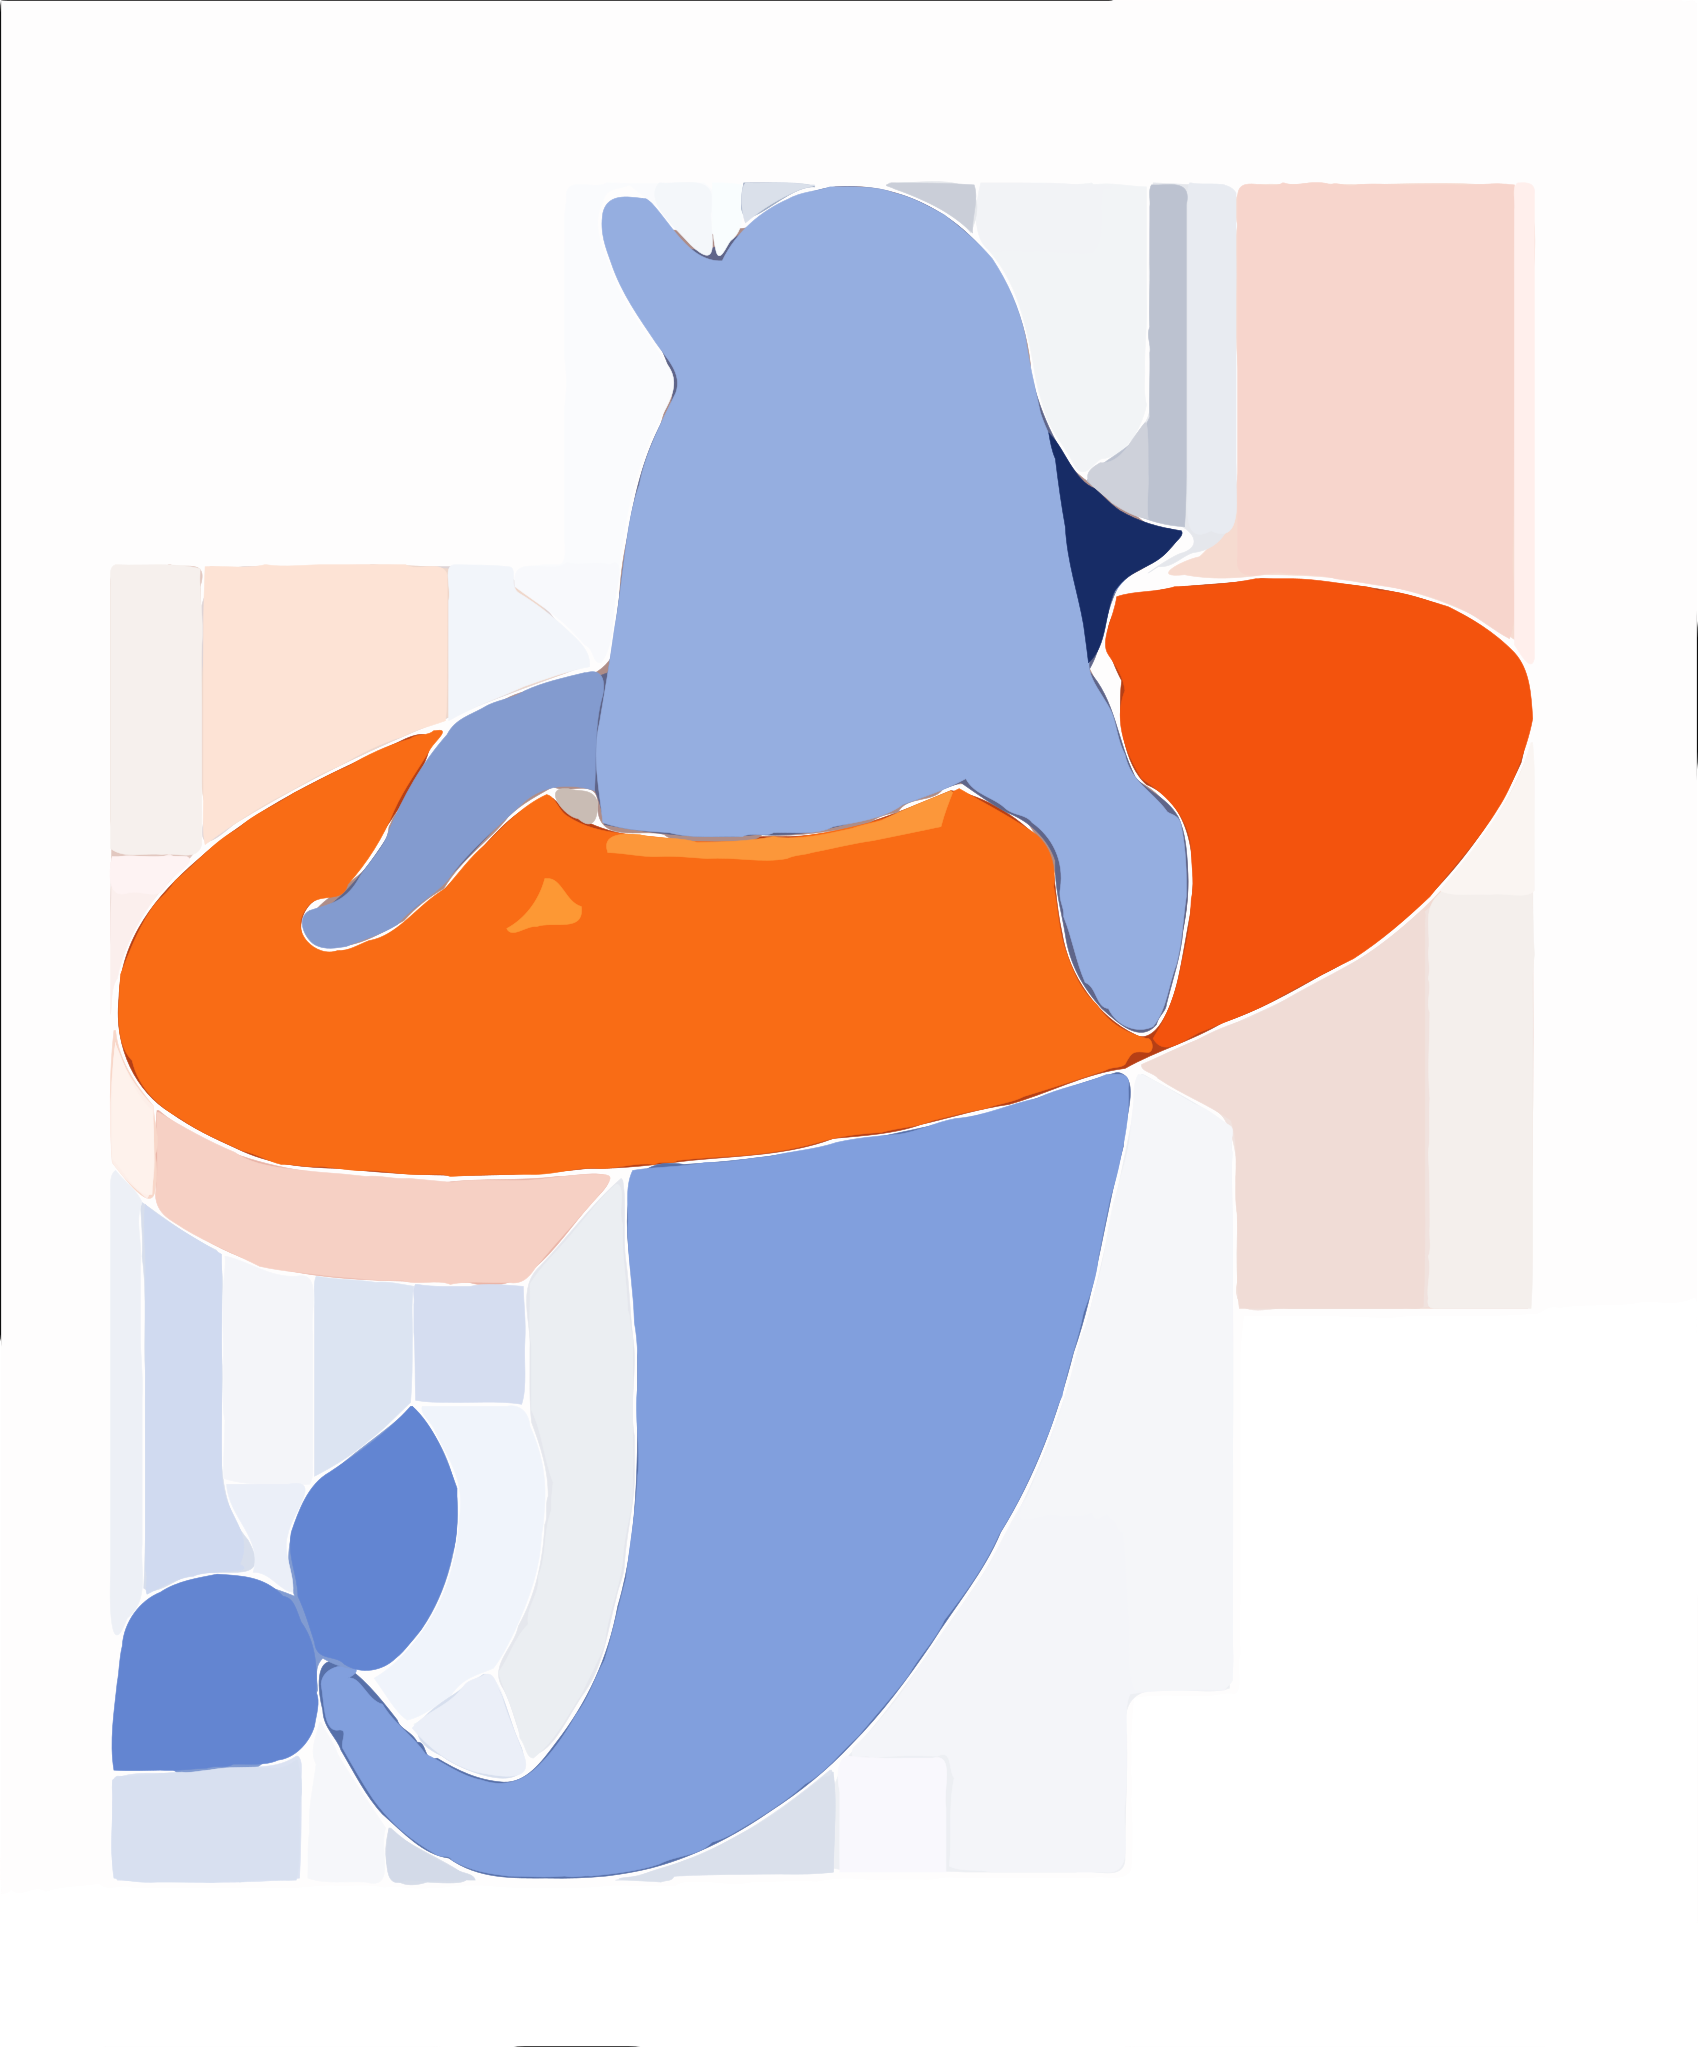

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 45.895879982256375
Topic5\house.png 
use_bezier_curve_num : 1000 
component_num : 57


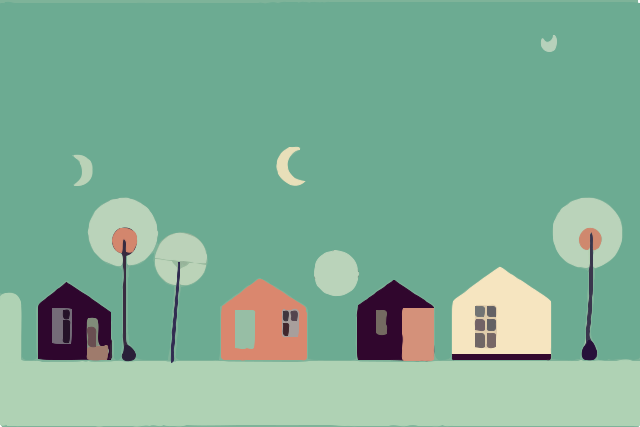

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.252638319672132
Topic5\meditation.png 
use_bezier_curve_num : 1000 
component_num : 60


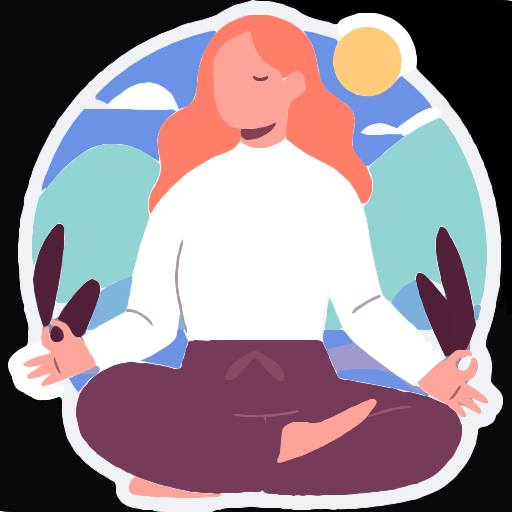

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 29.487186431884766
Topic5\tree.png 
use_bezier_curve_num : 1000 
component_num : 200


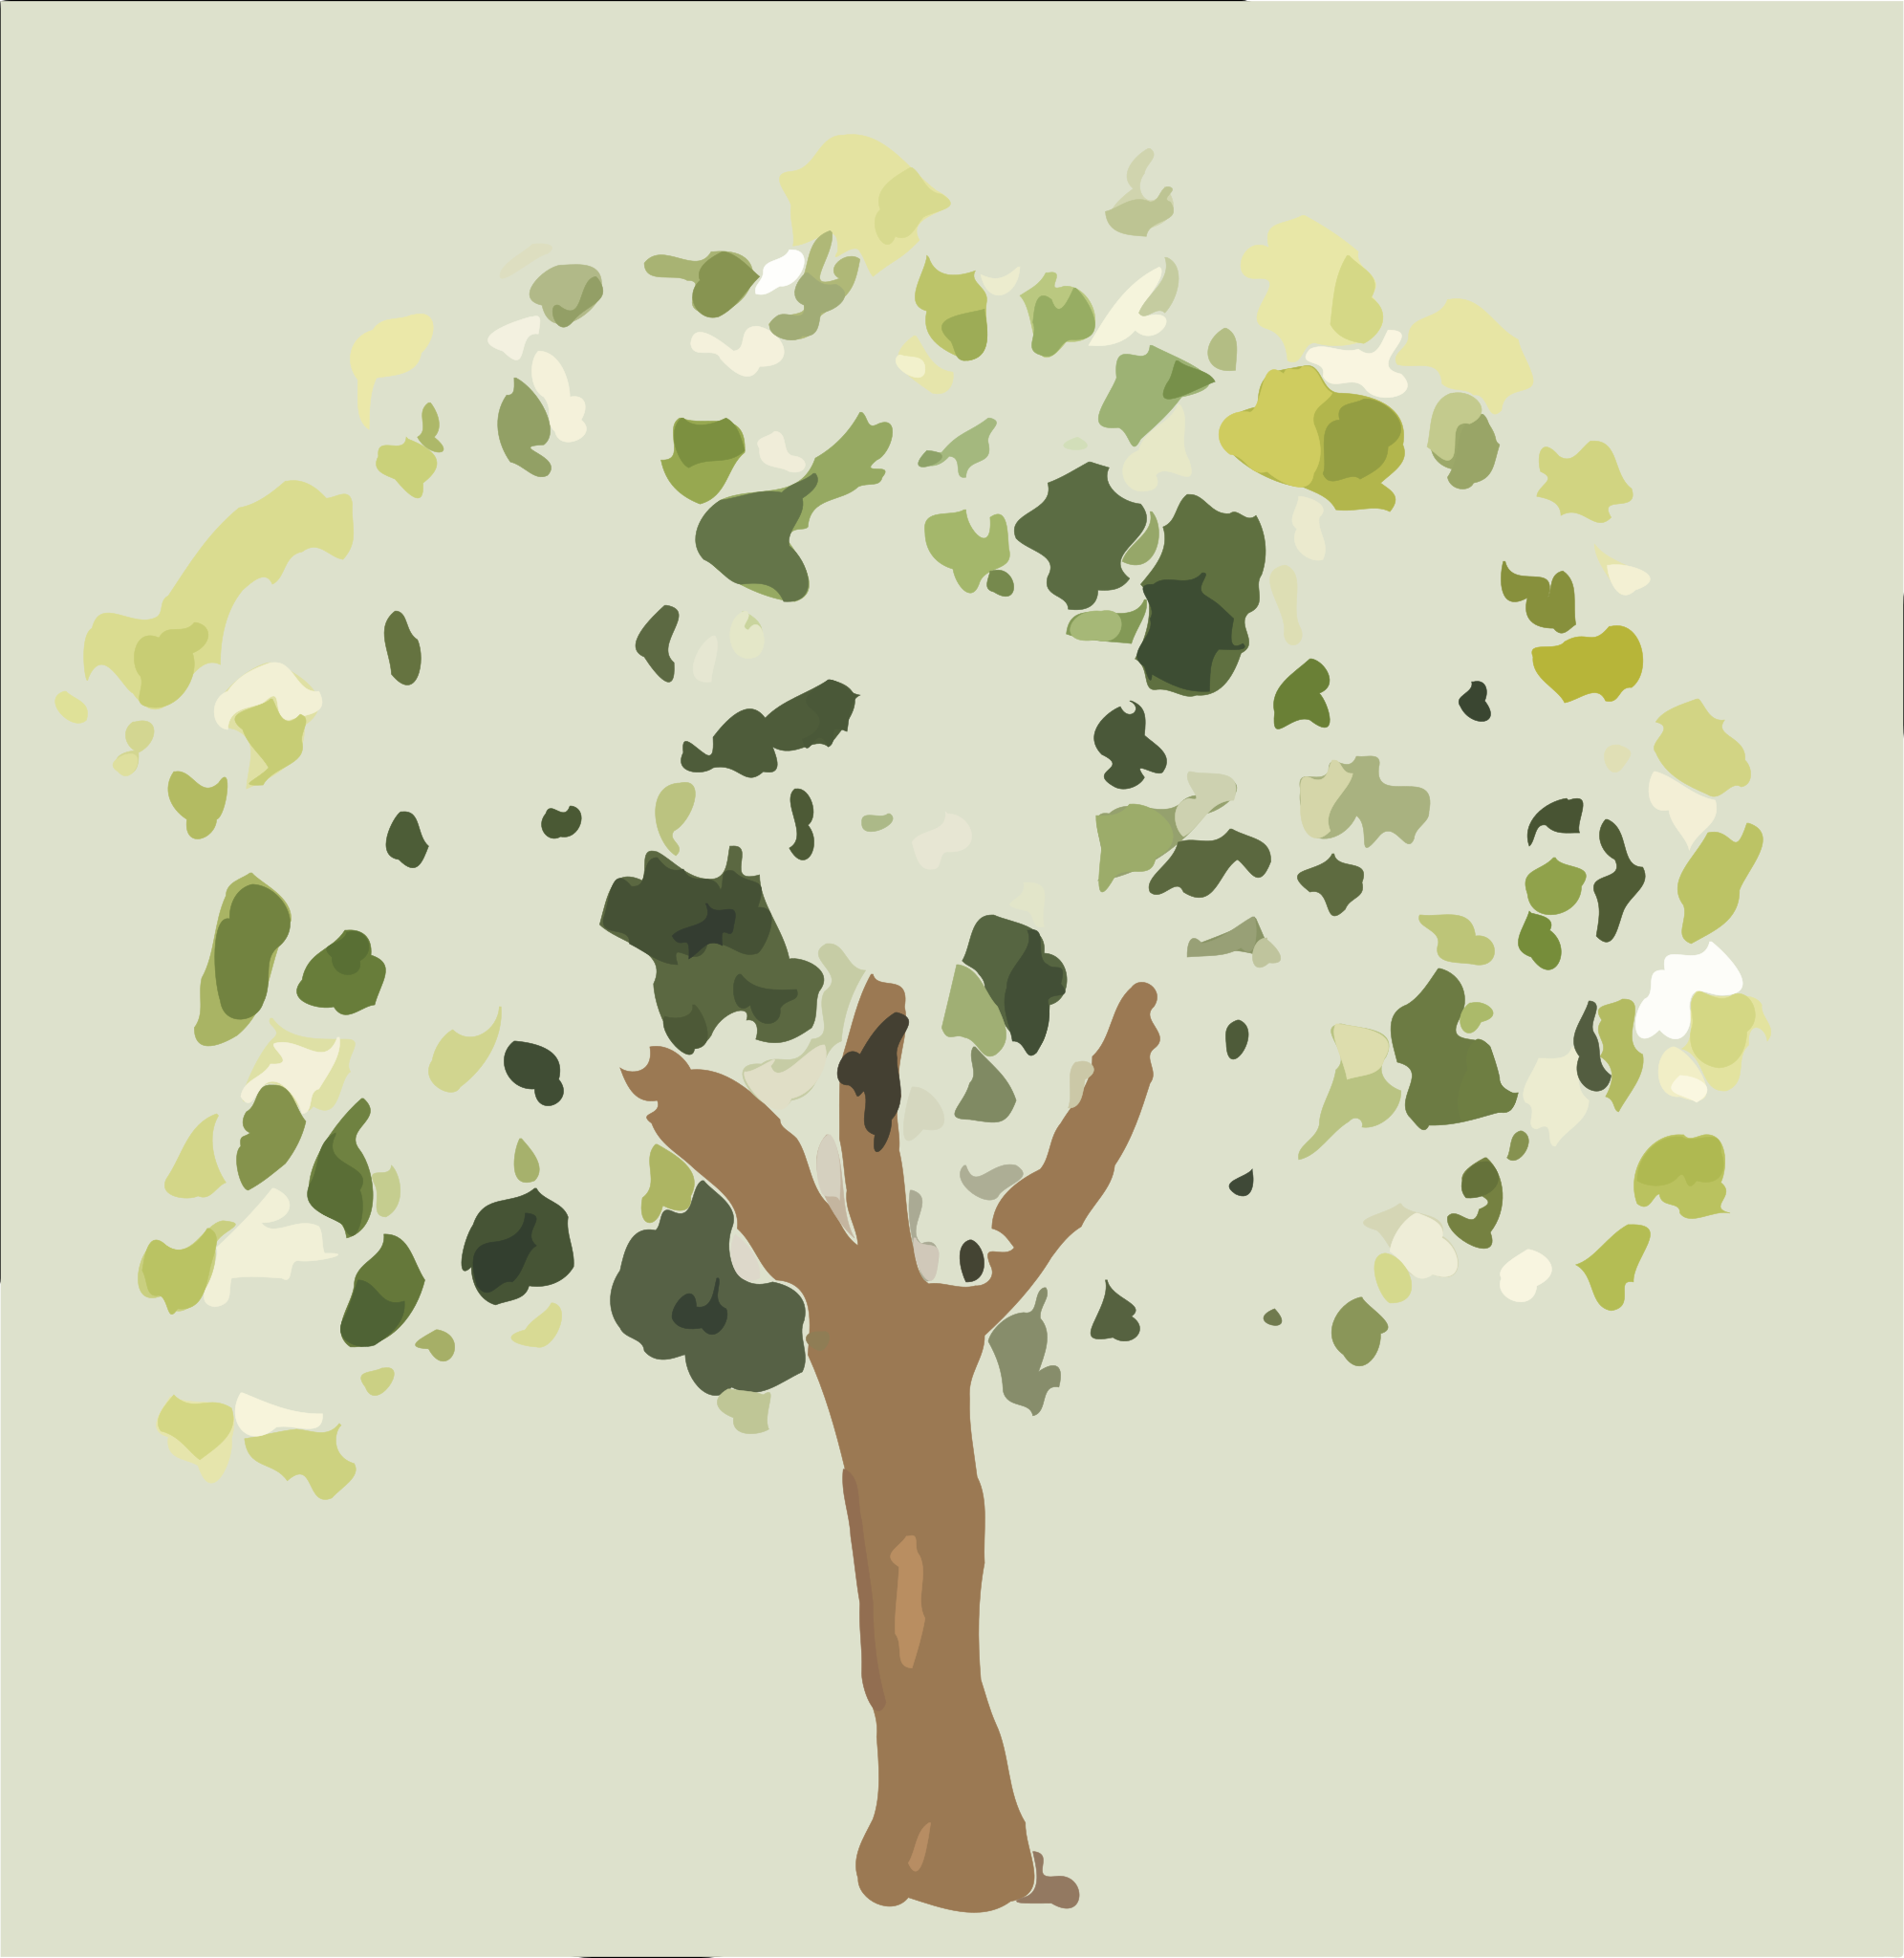

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 93.07270422723712
Topic5\work-from-home.png 
use_bezier_curve_num : 1000 
component_num : 42


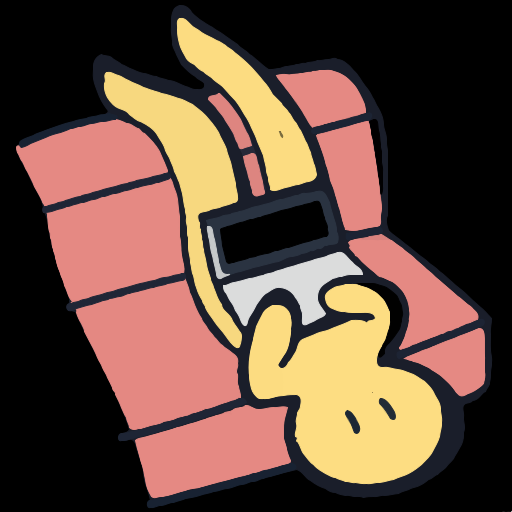

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 13.923094431559244
Topic5 Total MSE: 394.2769587280561
2038.5003743171692


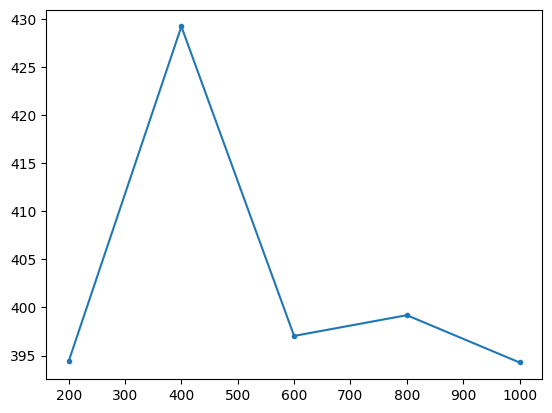

In [111]:
Test(V21=True,V22=True,V23=True,V31=True,labelname="V22&V23")

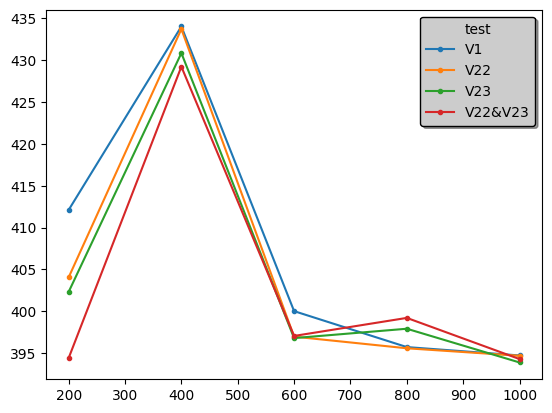

In [112]:
plt.plot(max_bezier_curve_nums,tmsess["V1"],'.-',label="V1")
plt.plot(max_bezier_curve_nums,tmsess["V22"],'.-',label="V22")
plt.plot(max_bezier_curve_nums,tmsess["V23"],'.-',label="V23")
plt.plot(max_bezier_curve_nums,tmsess["V22&V23"],'.-',label="V22&V23")
plt.legend(
    loc='best',
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=10)